# Lung Cancer Classification using Computerized Tomography (CT) Data

# Índice  <a name = "indice"></a>
1. [Introdução](#int)
2. [Análise Datasets](#ad)
    - [Nodule Counts By Patient](#ncbp)
    - [Patient Diagnoses](#pd)
    - [Metadata](#metadata)
3. [Análise de Dados Extraidos do Pylidc](#dpylidc)
4. [Merge Datasets](#merge_ds)
5. [Junção das Anotações Semanticas e Label's](#jasl)
6. [Pré-Processamento Imagens](#pre_imgs)
7. [Anáise Exploratória dos Dados](#aed)
8. [Extração de Features - Pyradiomics](#efp)
9. [Tratamento de Dados do Pyradiomics](#tdp)
10. [Feature Importance and Selection](#fias)
11. [Training Models](#tm)
12. [Comparação de resultados](#cr)
13. [Referências](#ref)

-----


# Introdução <a name = "int"></a>
[[voltar ao índice]](#indice)

O cancro do pulmão representa um dos tipos de cancro mais comuns e mortais em todo o mundo. A sua elevada mortalidade deve-se ao facto da deteção deste tipo de cancro ser um desafio para os profissionais da área. Para a sua deteção, são usualmente analisadas imagens de tomografia computadorizada, que possibilitam a identificação de nódulos pulmonares. Contudo, a análise desye tipo de dados exige um elevado grau de especialização e experiência, o que pode levar a diagnósticos incorretos. A solução pode passar pela utilização de modelos de Inteligência Artificial, que possam auxiliar os profissionais na deteção e classificação de nódulos pulmonares.

O projeto proposto consiste, então, na classificação de nódulos pulmunares, através de análise detalhada de dados e implementação de modelos de IA, utilizando imagens de tomografia computadorizada (CT). Os dados utilizados são provenientes do dataset LIDC-IDRI, disponível em https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI. Ao longo deste projeto serão propostas soluções para a sua análise e processamento, tendo por base estudos e projetos já realizados na área, que se encontram referenciados ao longo do documento. A classificação dos nódulos pulmonares será realizada através de diferentes técnicas e algoritmos, que serão comparados e avaliados, de forma a determinar qual o modelo que melhor se adequa ao problema proposto.

Para realizar este trabalho foram necessárias utilizar algumas bibliotecas como:

In [3]:
import pandas as pd
import pylidc as pl
import numpy as np
import cv2
import matplotlib.pyplot as plt
from radiomics import featureextractor
import SimpleITK as sitk
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import seaborn as sns

In [4]:
# Feature Importance and Selection
# t-test
from scipy.stats import ttest_ind
# Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [5]:
# Model Training
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pyswarm import pso
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.model_selection import train_test_split

# Análise de Datasets <a name = "ad"></a>
[[voltar ao índice]](#indice)

Nesta parte do projeto vamos começar por analisar os diferentes datasets fornecidos, de modo a compreender se existem dados que podem ser descartados. Para além disso é de extrema relevância compreender se todos os datasets devem ser utilizados ou não.

## Nodule Counts By Patient <a name = "ncbp"></a>
[[voltar a Análise de Datasets]](#ad)


Este dataset contem dados que nos indicam qual o número de nódulos por paciente, estando estes subdivididos em duas categorias:
- Number of Nodules >=3mm
- Number of Nodules <3mm

Começamos por fazer a leitura do ficheiro 'NoduleCountsByPatient.xlsx' que se encontra disponivel no site do dataset fornecido no enunciado do projeto.

In [4]:
df1_Nodules = pd.read_excel('NoduleCountsByPatient.xlsx')

Confirmamos agora se a leitura do ficheiro foi efetuada corretamente. Para isso começamos por ver se a leitura do nome das colunas está bem. 

In [5]:
print(df1_Nodules.columns)

Index(['TCIA Patent ID', 'Total Number of Nodules* ',
       'Number of Nodules >=3mm**', 'Number of Nodules <3mm***', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')


Concluimos que existem duas colunas sem nomes, vamos portanto ver quais são os dados que estas possuem. Para isso podemos utilizar head().

In [6]:
df1_Nodules.head()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                          4                          1   
1  LIDC-IDRI-0002                         12                          1   
2  LIDC-IDRI-0003                          4                          4   
3  LIDC-IDRI-0004                          4                          1   
4  LIDC-IDRI-0005                          9                          3   

   Number of Nodules <3mm***  Unnamed: 4  \
0                          3         NaN   
1                         11         NaN   
2                          0         NaN   
3                          3         NaN   
4                          6         NaN   

                                          Unnamed: 5  
0                                                NaN  
1  *total number of lesions that received either ...  
2  **total number of lesions that received a "nod...  
3  ***total number of lesions that received a "no...  
4                                                NaN

Como podemos concluir existem colunas com vários valores NaN. Vamos ver quantas vezes este valor aparece em cada coluna.

In [7]:
print(df1_Nodules.isna().sum())

TCIA Patent ID                  1
Total Number of Nodules*        0
Number of Nodules >=3mm**       0
Number of Nodules <3mm***       0
Unnamed: 4                   1019
Unnamed: 5                   1016
dtype: int64


**Eliminação de colunas**

Como percebemos existem vários valores NaN nas colunas 4 e 5. Sendo que na coluna 5, sabemos que na realidade existem mais 3 valores NaN, que estão a ser ocupados por textos descritivos, como se pode ver em head(). Como estas colunas não contribuem para informação relevante no dataset, serão eliminados. 

In [8]:
df1_Nodules = df1_Nodules.iloc[:, :-2]

Vamos só confirmar se a remoção das duas últimas colunas foi bem efetuada:

In [9]:
df1_Nodules.head()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                          4                          1   
1  LIDC-IDRI-0002                         12                          1   
2  LIDC-IDRI-0003                          4                          4   
3  LIDC-IDRI-0004                          4                          1   
4  LIDC-IDRI-0005                          9                          3   

   Number of Nodules <3mm***  
0                          3  
1                         11  
2                          0  
3                          3  
4                          6

Agora apenas precisamos de averiguar o porquê do NaN na primeira coluna.

In [10]:
df1_Nodules.tail()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
1014  LIDC-IDRI-1009                          2                          1   
1015  LIDC-IDRI-1010                         10                          1   
1016  LIDC-IDRI-1011                          4                          4   
1017  LIDC-IDRI-1012                          1                          1   
1018             NaN                       7371                       2669   

      Number of Nodules <3mm***  
1014                          1  
1015                          9  
1016                          0  
1017                          0  
1018                       4702

**Eliminação de uma entrada**

Como podemos ver e como sabemos graças ao site do dataset, a útima linha deste dataframe corresponde à soma do número de nódulos de cada coluna. Neste caso, consideramos que esses valores são irrelevantes e como tal, também podemos eliminar essa linha.

In [11]:
df1_Nodules = df1_Nodules.drop(df1_Nodules.index[-1])

Confirmamos agora que a última linha foi corretamente eliminada:

In [12]:
df1_Nodules.tail()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
1013  LIDC-IDRI-1008                          7                          6   
1014  LIDC-IDRI-1009                          2                          1   
1015  LIDC-IDRI-1010                         10                          1   
1016  LIDC-IDRI-1011                          4                          4   
1017  LIDC-IDRI-1012                          1                          1   

      Number of Nodules <3mm***  
1013                          1  
1014                          1  
1015                          9  
1016                          0  
1017                          0

Concluimos que sim. 

**Tipos de Dados**

In [13]:
df1_Nodules.dtypes

TCIA Patent ID               object
Total Number of Nodules*      int64
Number of Nodules >=3mm**     int64
Number of Nodules <3mm***     int64
dtype: object

**Análise Profunda**

Nota: Durante a análise dos dados notamos que os nomes das colunas estavam desformatados, pelo que os iremos modificar agora para que fiquem direitos.

In [14]:
df1_Nodules.columns = ['Patient_ID', 'Total Number of Nodules*', 'Number of Nodules >=3mm**', 
                         'Number of Nodules <3mm***']

Como sabemos este dataset diz respeito ao número de nódulos que cada paciente tem. Como tal vamos agora apenas confirmar quantos pacientes existem de facto, devendo esses ser 1010.

In [15]:
df1_Nodules['Patient_ID'].nunique()

1010

Concluimos que existem 1010 pacientes diferentes como seria suposto, contudo, existem 1018 entradas, logo existem entradas de pacientes repetidos. Vamos descorbrir quais

In [16]:
df1_Nodules[df1_Nodules['Patient_ID'].duplicated(keep=False)]

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
131  LIDC-IDRI-0132                        14                          6   
132  LIDC-IDRI-0132                        12                          8   
151  LIDC-IDRI-0151                         3                          1   
152  LIDC-IDRI-0151                         7                          1   
315  LIDC-IDRI-0315                        13                          7   
316  LIDC-IDRI-0315                         8                          5   
333  LIDC-IDRI-0332                         6                          5   
334  LIDC-IDRI-0332                         3                          2   
357  LIDC-IDRI-0355                         4                          1   
358  LIDC-IDRI-0355                         3                          2   
368  LIDC-IDRI-0365                         8                          1   
369  LIDC-IDRI-0365                         5                          1   
446  LIDC-IDRI-0442                         4                          3   
447  LIDC-IDRI-0442                         3                          3   
489  LIDC-IDRI-0484                        33                          2   
490  LIDC-IDRI-0484                         4                          2   

     Number of Nodules <3mm***  
131                          8  
132                          4  
151                          2  
152                          6  
315                          6  
316                          3  
333                          1  
334                          1  
357                          3  
358                          1  
368                          7  
369                          4  
446                          1  
447                          0  
489                         31  
490                          2

Como seria de esperar alguns pacientes apresentam mais que uma entrada, mas como é que sabemos qual é a correta. Talvez com a ajuda de outros datasets seja possivel obter uma resposta a este problema.

Será que há pacientes sem nódulos?

In [17]:
df1_Nodules[df1_Nodules['Total Number of Nodules*'] == 0]

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
306   LIDC-IDRI-0306                         0                          0   
307   LIDC-IDRI-0307                         0                          0   
323   LIDC-IDRI-0322                         0                          0   
367   LIDC-IDRI-0364                         0                          0   
445   LIDC-IDRI-0441                         0                          0   
512   LIDC-IDRI-0506                         0                          0   
546   LIDC-IDRI-0540                         0                          0   
570   LIDC-IDRI-0564                         0                          0   
579   LIDC-IDRI-0573                         0                          0   
617   LIDC-IDRI-0612                         0                          0   
673   LIDC-IDRI-0668                         0                          0   
694   LIDC-IDRI-0689                         0                          0   
721   LIDC-IDRI-0716                         0                          0   
736   LIDC-IDRI-0731                         0                          0   
765   LIDC-IDRI-0760                         0                          0   
892   LIDC-IDRI-0887                         0                          0   
905   LIDC-IDRI-0900                         0                          0   
942   LIDC-IDRI-0937                         0                          0   
980   LIDC-IDRI-0975                         0                          0   
1000  LIDC-IDRI-0995                         0                          0   

      Number of Nodules <3mm***  
306                           0  
307                           0  
323                           0  
367                           0  
445                           0  
512                           0  
546                           0  
570                           0  
579                           0  
617                           0  
673                           0  
694                           0  
721                           0  
736                           0  
765                           0  
892                           0  
905                           0  
942                           0  
980                           0  
1000                          0

Pelo que pudemos observar existem vários pacientes que não apresentam qualquer tipo de nódulos o que não nos é muito útil para este trabalho, uma vez que o objetivo é classificar nódulos. Como tal estas entradas deverão ser removidas, juntamente com todos os pacientes que também não apresentarem nódulos na coluna "Number of Nodules >=3mm**", pois como sabemos, apenas temos anotações para nódulos classificados como >= 3mm de diametro e menores que 30 mm.

No entanto, do mesmo modo que sabemos que este dataset apresenta incongruencias, pois tem pacientes repetidos, também podem existir erros aqui. Mais uma vez, de modo a resolver este problema, puderemos utilizar outros datasets para nos ajudarem a encontrar uma solução.

## Patient Diagnoses <a name = "pd"></a>
[[voltar a Análise de Datasets]](#ad)

Este dateset fornece informações valiosas sobre os pacientes e os seus nódulos,  como o facto deste apresentarem ou não tumores malignos.

Começamos por fazer a leitura do ficheiro 'PatientDiagnoses.xlsx' que se encontra disponivel no site do dataset fornecido no enunciado do projeto.

In [18]:
df2_Diagnoses = pd.read_excel('PatientDiagnoses.xls')

Confirmamos agora se a leitura do ficheiro foi efetuada corretamente. Para isso começamos por ver se a leitura do nome das colunas foi executada corretamente. 

In [19]:
df2_Diagnoses.columns

Index(['TCIA Patient ID',
       'Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n',
       'Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response',
       'Primary tumor site for metastatic disease',
       'Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n',
       'Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n',
       'Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n',
       'Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 =

**Mudar o nome das colunas**

Como podemos perceber, ao fazer a leitura do ficheiro, os nomes das colunas ficaram complexos. Vamos portanto simplificá-los:

In [20]:
df2_Diagnoses.columns = ['Patient_ID', 'Diagnosis at the Patient Level', 'Diagnosis Method at the Nodule', 
                         'Primary tumor site for metastatic disease',
                         'Nodule 1 Diagnosis at the Nodule Level', 'Nodule 1 Diagnosis Method at the Nodule Level', 
                         'Nodule 2 Diagnosis at the Nodule Level', 'Nodule 2 Diagnosis Method at the Nodule Level', 
                         'Nodule 3 Diagnosis at the Nodule Level', 'Nodule 3 Diagnosis Method at the Nodule Level',
                         'Nodule 4 Diagnosis at the Nodule Level', 'Nodule 4 Diagnosis Method at the Nodule Level',
                         'Nodule 5 Diagnosis at the Nodule Level', 'Nodule 5 Diagnosis Method at the Nodule Level']

Agora vamos confirmar se as alterações foram efetuadas corretamente:

In [21]:
df2_Diagnoses.columns

Index(['Patient_ID', 'Diagnosis at the Patient Level',
       'Diagnosis Method at the Nodule',
       'Primary tumor site for metastatic disease',
       'Nodule 1 Diagnosis at the Nodule Level',
       'Nodule 1 Diagnosis Method at the Nodule Level',
       'Nodule 2 Diagnosis at the Nodule Level',
       'Nodule 2 Diagnosis Method at the Nodule Level',
       'Nodule 3 Diagnosis at the Nodule Level',
       'Nodule 3 Diagnosis Method at the Nodule Level',
       'Nodule 4 Diagnosis at the Nodule Level',
       'Nodule 4 Diagnosis Method at the Nodule Level',
       'Nodule 5 Diagnosis at the Nodule Level',
       'Nodule 5 Diagnosis Method at the Nodule Level'],
      dtype='object')

Concluimos que sim.

Mas será que há a necessidade de haver todas estas colunas?

Vamos ver se existem valores NaN

In [22]:
print(df2_Diagnoses.isna().sum())

Patient_ID                                         0
Diagnosis at the Patient Level                     0
Diagnosis Method at the Nodule                     0
Primary tumor site for metastatic disease          0
Nodule 1 Diagnosis at the Nodule Level            20
Nodule 1 Diagnosis Method at the Nodule Level     20
Nodule 2 Diagnosis at the Nodule Level           137
Nodule 2 Diagnosis Method at the Nodule Level    137
Nodule 3 Diagnosis at the Nodule Level           156
Nodule 3 Diagnosis Method at the Nodule Level    156
Nodule 4 Diagnosis at the Nodule Level           157
Nodule 4 Diagnosis Method at the Nodule Level    157
Nodule 5 Diagnosis at the Nodule Level           157
Nodule 5 Diagnosis Method at the Nodule Level    157
dtype: int64


Sabemos que o dataset tem 157 entradas, logo as últimas quatro colunas não possuem quaisquer dados.

Mas será que as colunas que dizem respeito ao Nódulo 3 tem de facto uma entrada com dados, ou será algum erro de leitura?

In [23]:
print(df2_Diagnoses['Nodule 3 Diagnosis at the Nodule Level'].value_counts())

Nodule 3 Diagnosis at the Nodule Level
     1
Name: count, dtype: int64


In [24]:
df2_Diagnoses[df2_Diagnoses['Nodule 3 Diagnosis at the Nodule Level'] == ' ']

Patient_ID  Diagnosis at the Patient Level  \
114  LIDC-IDRI-0285                               3   

     Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
114                               3                                  melanoma   

     Nodule 1 Diagnosis at the Nodule Level  \
114                                     3.0   

     Nodule 1 Diagnosis Method at the Nodule Level  \
114                                            3.0   

     Nodule 2 Diagnosis at the Nodule Level  \
114                                     0.0   

     Nodule 2 Diagnosis Method at the Nodule Level  \
114                                            0.0   

    Nodule 3 Diagnosis at the Nodule Level  \
114                                          

    Nodule 3 Diagnosis Method at the Nodule Level  \
114                                                 

     Nodule 4 Diagnosis at the Nodule Level  \
114                                     NaN   

     Nodule 4 Diagnosis Method at the Nodule Level  \
114                                            NaN   

     Nodule 5 Diagnosis at the Nodule Level  \
114                                     NaN   

     Nodule 5 Diagnosis Method at the Nodule Level  
114                                            NaN

In [25]:
print(df2_Diagnoses['Nodule 3 Diagnosis Method at the Nodule Level'].value_counts())

Nodule 3 Diagnosis Method at the Nodule Level
     1
Name: count, dtype: int64


In [26]:
df2_Diagnoses[df2_Diagnoses['Nodule 3 Diagnosis Method at the Nodule Level'] == ' ']

Patient_ID  Diagnosis at the Patient Level  \
114  LIDC-IDRI-0285                               3   

     Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
114                               3                                  melanoma   

     Nodule 1 Diagnosis at the Nodule Level  \
114                                     3.0   

     Nodule 1 Diagnosis Method at the Nodule Level  \
114                                            3.0   

     Nodule 2 Diagnosis at the Nodule Level  \
114                                     0.0   

     Nodule 2 Diagnosis Method at the Nodule Level  \
114                                            0.0   

    Nodule 3 Diagnosis at the Nodule Level  \
114                                          

    Nodule 3 Diagnosis Method at the Nodule Level  \
114                                                 

     Nodule 4 Diagnosis at the Nodule Level  \
114                                     NaN   

     Nodule 4 Diagnosis Method at the Nodule Level  \
114                                            NaN   

     Nodule 5 Diagnosis at the Nodule Level  \
114                                     NaN   

     Nodule 5 Diagnosis Method at the Nodule Level  
114                                            NaN

**Eliminar Colunas**

Concluimos que é um erro de leitura e que também não tem dados. Por este motivo vamos eliminar as colunas que dizem respeito aos nódulos 3, 4 e 5.

In [27]:
df2_Diagnoses = df2_Diagnoses.iloc[:, :-6]

Vamos confirmar se as colunas foram removidas corretamente:

In [28]:
df2_Diagnoses.head()

Patient_ID  Diagnosis at the Patient Level  \
0  LIDC-IDRI-0068                               3   
1  LIDC-IDRI-0071                               3   
2  LIDC-IDRI-0072                               2   
3  LIDC-IDRI-0088                               3   
4  LIDC-IDRI-0090                               2   

   Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
0                               4                        Head & Neck Cancer   
1                               1                              Head & Neck    
2                               4                               Lung Cancer   
3                               0                            Uterine Cancer   
4                               3                                     NSCLC   

   Nodule 1 Diagnosis at the Nodule Level  \
0                                     3.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     2.0   

   Nodule 1 Diagnosis Method at the Nodule Level  \
0                                            4.0   
1                                            1.0   
2                                            4.0   
3                                            0.0   
4                                            3.0   

   Nodule 2 Diagnosis at the Nodule Level  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   Nodule 2 Diagnosis Method at the Nodule Level  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN

Concluimos que sim.

**Tipo de Dados**

In [29]:
df2_Diagnoses.dtypes

Patient_ID                                        object
Diagnosis at the Patient Level                     int64
Diagnosis Method at the Nodule                     int64
Primary tumor site for metastatic disease         object
Nodule 1 Diagnosis at the Nodule Level           float64
Nodule 1 Diagnosis Method at the Nodule Level    float64
Nodule 2 Diagnosis at the Nodule Level           float64
Nodule 2 Diagnosis Method at the Nodule Level    float64
dtype: object

Os valores dos nódulos 1 e 2 deveriam ser inteiros e não floats. Para convertermos uma coluna de floats em inteiros é preciso que não hajam valores NaN. Para isso iremos primeiro converter os valores NaN em -1 e depois passamos as colunas para inteiros.

In [30]:
colunas_para_converter = [
    'Nodule 1 Diagnosis at the Nodule Level',
    'Nodule 1 Diagnosis Method at the Nodule Level',
    'Nodule 2 Diagnosis at the Nodule Level',
    'Nodule 2 Diagnosis Method at the Nodule Level'
]

# Passo 1: Preencher NaN com -1
df2_Diagnoses[colunas_para_converter] = df2_Diagnoses[colunas_para_converter].fillna(-1)

# Passo 2: Converter as colunas para int
df2_Diagnoses[colunas_para_converter] = df2_Diagnoses[colunas_para_converter].astype(int)

# Exibe o DataFrame atualizado
df2_Diagnoses.head()

Patient_ID  Diagnosis at the Patient Level  \
0  LIDC-IDRI-0068                               3   
1  LIDC-IDRI-0071                               3   
2  LIDC-IDRI-0072                               2   
3  LIDC-IDRI-0088                               3   
4  LIDC-IDRI-0090                               2   

   Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
0                               4                        Head & Neck Cancer   
1                               1                              Head & Neck    
2                               4                               Lung Cancer   
3                               0                            Uterine Cancer   
4                               3                                     NSCLC   

   Nodule 1 Diagnosis at the Nodule Level  \
0                                       3   
1                                       1   
2                                       1   
3                                       0   
4                                       2   

   Nodule 1 Diagnosis Method at the Nodule Level  \
0                                              4   
1                                              1   
2                                              4   
3                                              0   
4                                              3   

   Nodule 2 Diagnosis at the Nodule Level  \
0                                      -1   
1                                      -1   
2                                      -1   
3                                      -1   
4                                      -1   

   Nodule 2 Diagnosis Method at the Nodule Level  
0                                             -1  
1                                             -1  
2                                             -1  
3                                             -1  
4                                             -1

Como podemos ver a conversão foi realizada com sucesso. Poderiamos voltar a passar os valores '-1' para NaN, mas pensamos que tal não seja necessário, pois sabemos que neste dataset todos os valores que são -1, correspondem a valores NaN.

**Análise Profunda** 

Anteriormente, quando vimos os valores NaN de cada coluna, havia entradas com esse valor nas colunas que dizem respeito ao Nódulo 1:

In [31]:
df2_Diagnoses[df2_Diagnoses['Nodule 1 Diagnosis Method at the Nodule Level'] == -1]

Patient_ID  Diagnosis at the Patient Level  \
120  LIDC-IDRI-0314                               2   
121  LIDC-IDRI-0325                               2   
126  LIDC-IDRI-0405                               1   
127  LIDC-IDRI-0454                               2   
130  LIDC-IDRI-0510                               1   
131  LIDC-IDRI-0522                               2   
132  LIDC-IDRI-0543                               2   
134  LIDC-IDRI-0562                               2   
136  LIDC-IDRI-0576                               0   
139  LIDC-IDRI-0624                               1   
140  LIDC-IDRI-0766                               2   
141  LIDC-IDRI-0771                               2   
143  LIDC-IDRI-0811                               2   
145  LIDC-IDRI-0875                               2   
146  LIDC-IDRI-0893                               3   
147  LIDC-IDRI-0905                               2   
148  LIDC-IDRI-0921                               2   
149  LIDC-IDRI-0924                               2   
151  LIDC-IDRI-0965                               2   
153  LIDC-IDRI-1002                               2   

     Diagnosis Method at the Nodule  \
120                               2   
121                               2   
126                               2   
127                               2   
130                               2   
131                               2   
132                               2   
134                               3   
136                               2   
139                               3   
140                               2   
141                               2   
143                               3   
145                               3   
146                               3   
147                               3   
148                               2   
149                               3   
151                               3   
153                               2   

      Primary tumor site for metastatic disease  \
120                              adenocarcinoma   
121      squamous cell carcinoma/non-small cell   
126                  reactive mesothelial cells   
127                    non-small cell carcinoma   
130                              focal fibrosis   
131                              Adenocarcinoma   
132                        small cell carcinoma   
134                              adenocarcinoma   
136                  reactive mesothelial cells   
139  Histoplasmosis with necrotizing granulomas   
140                    non-small cell carcinoma   
141                     squamous cell carcinoma   
143                              Adenocarcinoma   
145                              Adenocarcinoma   
146                        recurrent/metastatic   
147                          RLL NSCLC stage 1A   
148                        small cell carcinoma   
149        poorly differentiated adenocarcinoma   
151                              Adenocarcinoma   
153                    non-small cell carcinoma   

     Nodule 1 Diagnosis at the Nodule Level  \
120                                      -1   
121                                      -1   
126                                      -1   
127                                      -1   
130                                      -1   
131                                      -1   
132                                      -1   
134                                      -1   
136                                      -1   
139                                      -1   
140                                      -1   
141                                      -1   
143                                      -1   
145                                      -1   
146                                      -1   
147                                      -1   
148                                      -1   
149                                      -1   
151                                      -1   
153                  

Ou seja, existem entradas que não apresentam qualquer tipo de dados relativamente aos seus nós.

Será que há pacientes em duplicado?

In [32]:
df2_Diagnoses[df2_Diagnoses['Patient_ID'].duplicated(keep=False)]

Empty DataFrame
Columns: [Patient_ID, Diagnosis at the Patient Level, Diagnosis Method at the Nodule, Primary tumor site for metastatic disease, Nodule 1 Diagnosis at the Nodule Level, Nodule 1 Diagnosis Method at the Nodule Level, Nodule 2 Diagnosis at the Nodule Level, Nodule 2 Diagnosis Method at the Nodule Level]
Index: []

Não há pacientes em duplicado.

Quantos pacientes há?

Tendo em conta que deveriam ser 1010 pacientes, percebemos que este dataset encontra-se incompleto.

Mas de entre estes pacientes, será que há alguns que na realidade não tenham dados relevantes?

In [33]:
df2_Diagnoses.tail()

Patient_ID  Diagnosis at the Patient Level  \
152  LIDC-IDRI-0994                               2   
153  LIDC-IDRI-1002                               2   
154  LIDC-IDRI-1004                               2   
155  LIDC-IDRI-1010                               0   
156  LIDC-IDRI-1011                               3   

     Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
152                               3                         LUL Large cell CA   
153                               2                  non-small cell carcinoma   
154                               3                                 LUL NSCLC   
155                               0                                  lymphoma   
156                               2        small-cell carcinoma of the tongue   

     Nodule 1 Diagnosis at the Nodule Level  \
152                                       2   
153                                      -1   
154                                       2   
155                                       0   
156                                       3   

     Nodule 1 Diagnosis Method at the Nodule Level  \
152                                              3   
153                                             -1   
154                                              3   
155                                              0   
156                                              2   

     Nodule 2 Diagnosis at the Nodule Level  \
152                                      -1   
153                                      -1   
154                                      -1   
155                                      -1   
156                                       3   

     Nodule 2 Diagnosis Method at the Nodule Level  
152                                             -1  
153                                             -1  
154                                             -1  
155                                             -1  
156                                              4

Ao analisarmos a parte final do dataset, por exemplo, percebemos que existem entradas dos nódulos que não apresentam qualquer classificação. Para além disso, encontramos também casos de entradas que tem todas as colunas com valor 0, o que não faz sentido manter, porque isso significa que não sabem qualquer tipo de informações sobre esses dados.

## Metadata <a name = "metadata"></a>
[[voltar a Análise de Datasets]](#ad)

Este dataset também foi obtido através do site do fornecido no enunciado do projeto e contem algumas informações relativas às imagens extraidas, como o número de imagens que cada paciente deve ter.

In [34]:
df3_metadata = pd.read_csv('MetadataDigest.csv')

Vamos ver o que é que este dataset tem:

In [35]:
df3_metadata.head()

Subject ID                                          Study UID  \
0  LIDC-IDRI-1001  1.3.6.1.4.1.14519.5.2.1.6279.6001.281499745765...   
1  LIDC-IDRI-0778  1.3.6.1.4.1.14519.5.2.1.6279.6001.174809695196...   
2  LIDC-IDRI-0813  1.3.6.1.4.1.14519.5.2.1.6279.6001.139110171863...   
3  LIDC-IDRI-0710  1.3.6.1.4.1.14519.5.2.1.6279.6001.116146223752...   
4  LIDC-IDRI-0410  1.3.6.1.4.1.14519.5.2.1.6279.6001.818775038273...   

  Study Description             Study Date  \
0               NaN  2000-01-01 00:00:00.0   
1             CHEST  2000-01-01 00:00:00.0   
2               NaN  2000-01-01 00:00:00.0   
3             CHEST  2000-01-01 00:00:00.0   
4    CT LUNG SCREEN  2000-01-01 00:00:00.0   

                                           Series ID    Series Description  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...                   NaN   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840...              Recon 2:   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...                   NaN   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926...  Recon 2: ACRIN LARGE   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482...                   NaN   

   Number of images  File Size (Bytes) Collection Name Modality  \
0               194          102096016       LIDC-IDRI       CT   
1               481          253245158       LIDC-IDRI       CT   
2               157           82630786       LIDC-IDRI       CT   
3               471          247987448       LIDC-IDRI       CT   
4               126           66314722       LIDC-IDRI       CT   

         Manufacturer  
0             SIEMENS  
1  GE MEDICAL SYSTEMS  
2             SIEMENS  
3  GE MEDICAL SYSTEMS  
4  GE MEDICAL SYSTEMS

Temos dados de quantos pacientes?

In [36]:
df3_metadata['Subject ID'].value_counts()

Subject ID
LIDC-IDRI-0132    3
LIDC-IDRI-0151    3
LIDC-IDRI-0034    2
LIDC-IDRI-0258    2
LIDC-IDRI-0020    2
                 ..
LIDC-IDRI-0478    1
LIDC-IDRI-0921    1
LIDC-IDRI-0523    1
LIDC-IDRI-0432    1
LIDC-IDRI-0493    1
Name: count, Length: 1010, dtype: int64

Existem 1010 entradas, o que seria de esperar porque temos 1010 pacientes. No entanto alguns pacientes tem mais que uma entrada, a que se deve esse facto?

Vamos ver o caso de 'LIDC-IDRI-0132' e de 'LIDC-IDRI-0151' que apresentam ambos 3 entradas.

In [37]:
df3_metadata[df3_metadata['Subject ID'] == 'LIDC-IDRI-0132']

Subject ID                                          Study UID  \
233   LIDC-IDRI-0132  1.3.6.1.4.1.14519.5.2.1.6279.6001.218658642102...   
683   LIDC-IDRI-0132  1.3.6.1.4.1.14519.5.2.1.6279.6001.314138616411...   
1109  LIDC-IDRI-0132  1.3.6.1.4.1.14519.5.2.1.6279.6001.300027087262...   

     Study Description             Study Date  \
233                NaN  2000-01-01 00:00:00.0   
683                NaN  2000-01-01 00:00:00.0   
1109               NaN  2000-01-01 00:00:00.0   

                                              Series ID  \
233   1.3.6.1.4.1.14519.5.2.1.6279.6001.151647338241...   
683   1.3.6.1.4.1.14519.5.2.1.6279.6001.254176853278...   
1109  1.3.6.1.4.1.14519.5.2.1.6279.6001.513114548408...   

           Series Description  Number of images  File Size (Bytes)  \
233   ChestRoutine  3.0  B31f               127           66849474   
683    ThorRoutine  3.0  B31f               116           61034058   
1109               W Chest PA                 1           15046506   

     Collection Name Modality Manufacturer  
233        LIDC-IDRI       CT      SIEMENS  
683        LIDC-IDRI       CT      SIEMENS  
1109       LIDC-IDRI       CR      SIEMENS

In [38]:
df3_metadata[df3_metadata['Subject ID'] == 'LIDC-IDRI-0151']

Subject ID                                          Study UID  \
1076  LIDC-IDRI-0151  1.3.6.1.4.1.14519.5.2.1.6279.6001.222444895275...   
1110  LIDC-IDRI-0151  1.3.6.1.4.1.14519.5.2.1.6279.6001.280420083608...   
1210  LIDC-IDRI-0151  1.3.6.1.4.1.14519.5.2.1.6279.6001.780121538270...   

     Study Description             Study Date  \
1076               NaN  2000-01-01 00:00:00.0   
1110               NaN  2000-01-01 00:00:00.0   
1210               NaN  2000-01-01 00:00:00.0   

                                              Series ID  \
1076  1.3.6.1.4.1.14519.5.2.1.6279.6001.453946099750...   
1110  1.3.6.1.4.1.14519.5.2.1.6279.6001.516669228793...   
1210  1.3.6.1.4.1.14519.5.2.1.6279.6001.768856069922...   

            Series Description  Number of images  File Size (Bytes)  \
1076  ThoraxRoutine  3.0  B31s               111           58428866   
1110                W Chest PA                 1           13859978   
1210                       NaN               112           58921658   

     Collection Name Modality Manufacturer  
1076       LIDC-IDRI       CT      SIEMENS  
1110       LIDC-IDRI       CR      SIEMENS  
1210       LIDC-IDRI       CT      TOSHIBA

Concluimos que quando se trata do mesmo sujeito, apesar de este puder ter mais que uma entrada, essas entradas podem ser bastante diferentes entre si. Variando dados como o Study UID, a Modality, o Manufacturer, entre outros.

Vamos observar em maior detalhe o Study UID:

In [39]:
df3_metadata['Study UID'].value_counts()

Study UID
1.3.6.1.4.1.14519.5.2.1.6279.6001.281499745765120562304307889347    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.127299727722058129007613721740    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.190036064555105762519342089670    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.120580422725898456426920474122    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.238406803970631866767433328949    1
                                                                   ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.327077273262887321600634232119    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.147733809306552412615241520287    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.165928214371593461789742284562    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.305863253247137744276642948253    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.333362756208643390458434024958    1
Name: count, Length: 1308, dtype: int64

In [40]:
df3_metadata['Study UID'].nunique()

1308

Sabemos que existem 1308 entradas neste dataset e que na coluna 'Study UID' todos os seus valores são difernetes.

Será que o mesmo acontece para o Series ID?

In [41]:
df3_metadata['Series ID'].value_counts()

Series ID
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.300392272203629213913702120739    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.305000574633573438189782624063    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.304700823314998198591652152637    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.304676828064484590312919543151    1
                                                                   ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.199916291608127150948127902598    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.199282854229880908602362094937    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335    1
Name: count, Length: 1308, dtype: int64

In [42]:
df3_metadata['Series ID'].nunique()

1308

Concluimos que também não apresenta dados repetidos. O que não nos oferece grandes informações, uma vez que não é possivel fazer agrupamento de dados.

Mas será que há outras colunas que nos permitam agrupar os dados?

In [43]:
df3_metadata['Collection Name'].nunique()

1

Ao que parece a coleção de onde os dados foram extraidos também não nos permite fazer partições dos dados. 

In [44]:
df3_metadata['Modality'].nunique()

3

In [45]:
df3_metadata['Modality'].value_counts()

Modality
CT    1018
DX     237
CR      53
Name: count, dtype: int64

Mas a Modality já permite. Como podemos ver aqui temos informações sobre o modo utilizado para obter as imagens. Uma vez que o objetivo deste trabalho é utilizar CT scans, todos os dados obtidos atraves de outros meio não são relevantes, como tal podem ser eliminados. 

In [46]:
df3_metadata = df3_metadata[df3_metadata['Modality'] == 'CT'] 

Agora que apenas temos dados obtidos através de CT scans, deparamo-nos com outro problema: há pacientes que tem mais que uma entrada, pois há 1018 entradas com CT scans. Será que os pacientes que estão aqui repetidos são os mesmos que estavam em NoduleCountsByPatient?

In [47]:
df3_metadata[df3_metadata['Subject ID'].duplicated(keep=False)]

Subject ID                                          Study UID  \
136   LIDC-IDRI-0484  1.3.6.1.4.1.14519.5.2.1.6279.6001.202012743926...   
206   LIDC-IDRI-0484  1.3.6.1.4.1.14519.5.2.1.6279.6001.292226263060...   
218   LIDC-IDRI-0355  1.3.6.1.4.1.14519.5.2.1.6279.6001.246541809203...   
233   LIDC-IDRI-0132  1.3.6.1.4.1.14519.5.2.1.6279.6001.218658642102...   
266   LIDC-IDRI-0332  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...   
306   LIDC-IDRI-0355  1.3.6.1.4.1.14519.5.2.1.6279.6001.221138977753...   
478   LIDC-IDRI-0365  1.3.6.1.4.1.14519.5.2.1.6279.6001.212341120080...   
557   LIDC-IDRI-0442  1.3.6.1.4.1.14519.5.2.1.6279.6001.193438875802...   
683   LIDC-IDRI-0132  1.3.6.1.4.1.14519.5.2.1.6279.6001.314138616411...   
934   LIDC-IDRI-0332  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
947   LIDC-IDRI-0315  1.3.6.1.4.1.14519.5.2.1.6279.6001.709924281509...   
1001  LIDC-IDRI-0442  1.3.6.1.4.1.14519.5.2.1.6279.6001.265657827498...   
1055  LIDC-IDRI-0315  1.3.6.1.4.1.14519.5.2.1.6279.6001.190722769298...   
1076  LIDC-IDRI-0151  1.3.6.1.4.1.14519.5.2.1.6279.6001.222444895275...   
1210  LIDC-IDRI-0151  1.3.6.1.4.1.14519.5.2.1.6279.6001.780121538270...   
1227  LIDC-IDRI-0365  1.3.6.1.4.1.14519.5.2.1.6279.6001.216207548522...   

     Study Description             Study Date  \
136                NaN  2000-01-01 00:00:00.0   
206                NaN  2000-01-01 00:00:00.0   
218                NaN  2000-01-01 00:00:00.0   
233                NaN  2000-01-01 00:00:00.0   
266                NaN  2000-01-01 00:00:00.0   
306                NaN  2000-01-01 00:00:00.0   
478                NaN  2000-01-01 00:00:00.0   
557                NaN  2000-01-01 00:00:00.0   
683                NaN  2000-01-01 00:00:00.0   
934                NaN  2000-01-01 00:00:00.0   
947                NaN  2000-01-01 00:00:00.0   
1001               NaN  2000-01-01 00:00:00.0   
1055               NaN  2000-01-01 00:00:00.0   
1076               NaN  2000-01-01 00:00:00.0   
1210               NaN  2000-01-01 00:00:00.0   
1227               NaN  2000-01-01 00:00:00.0   

                                              Series ID  \
136   1.3.6.1.4.1.14519.5.2.1.6279.6001.132435134414...   
206   1.3.6.1.4.1.14519.5.2.1.6279.6001.145600217263...   
218   1.3.6.1.4.1.14519.5.2.1.6279.6001.147979688121...   
233   1.3.6.1.4.1.14519.5.2.1.6279.6001.151647338241...   
266   1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...   
306   1.3.6.1.4.1.14519.5.2.1.6279.6001.170344311940...   
478   1.3.6.1.4.1.14519.5.2.1.6279.6001.207544473852...   
557   1.3.6.1.4.1.14519.5.2.1.6279.6001.226813447046...   
683   1.3.6.1.4.1.14519.5.2.1.6279.6001.254176853278...   
934   1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
947   1.3.6.1.4.1.14519.5.2.1.6279.6001.322682676064...   
1001  1.3.6.1.4.1.14519.5.2.1.6279.6001.335799017122...   
1055  1.3.6.1.4.1.14519.5.2.1.6279.6001.406508755509...   
1076  1.3.6.1.4.1.14519.5.2.1.6279.6001.453946099750...   
1210  1.3.6.1.4.1.14519.5.2.1.6279.6001.768856069922...   
1227  1.3.6.1.4.1.14519.5.2.1.6279.6001.802846969823...   

            Series Description  Number of images  File Size (Bytes)  \
136    ChestRoutine  3.0  B31f               106           55797516   
206    ChestRoutine  3.0  B31f               112           58933202   
218   ThoraxRoutine  3.0  B31s               121           63667038   
233    ChestRoutine  3.0  B31f               127           66849474   
266                        NaN               292          153732646   
306                        NaN               119           62632798   
478   ThoraxRoutine  3.0  B31f               101           53167548   
557   ThoraxRoutine  3.0  B31s               116           61035616   
683     ThorRoutine  3.0  B31f               116           61034058   
934                        NaN               181           95292780   
947                        NaN               117           61552098   
1001    ThorRoutine  3.0  B31f              

Após analisar os pacientes repetidos em NoduleCountsByPatient, concluimos que os pacientes que se encontram repetidos aqui, são os mesmo que se encontram repetidos no outro dataset. A diferença mais significativa que se encontra aqui presente é o facto de nas entradas repetidas haver números de imagens distintos. O que nos coloca a questão de qual é a entrada correta.

Agora que já temos uma ideia do dataset resta-nos questionar se há valores NaN?

In [48]:
print(df3_metadata.isna().sum())

Subject ID              0
Study UID               0
Study Description     549
Study Date              0
Series ID               0
Series Description    706
Number of images        0
File Size (Bytes)       0
Collection Name         0
Modality                0
Manufacturer            0
dtype: int64


Concluimos que sim, mas em colunas redundantes, isto é, os valores em falta não são de interesse. 

## Análise de Dados Extraidos do Pylidc <a name = "dpylidc"></a>
[[voltar ao Indice]](#indice)

Este dataset foi gerado por nós e consiste na extração dos dados que achamos relevantes das anotações disponibilizadas dos diferentes radiologistas e alguns outros dados que achamos relevantes.

In [49]:
df4_pylidc = pd.read_csv('DadosPylidc.csv')

Aqui podemos ver quais os dados que extraimos das Annotations. 

In [50]:
df4_pylidc.head()

Patient_ID  Número de Nódulos  Nódulo ID  Quantidade de Anotações  \
0  LIDC-IDRI-0078                  4        1.0                        4   
1  LIDC-IDRI-0078                  4        1.0                        4   
2  LIDC-IDRI-0078                  4        1.0                        4   
3  LIDC-IDRI-0078                  4        1.0                        4   
4  LIDC-IDRI-0078                  4        2.0                        4   

   Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0          2.0         1.0         4.0     4.0       4.0      5.0   
1          1.0         2.0         4.0     2.0       4.0      5.0   
2          4.0         4.0         4.0     4.0       5.0      5.0   
3          2.0         2.0         4.0     3.0       5.0      4.0   
4          1.0         1.0         3.0     4.0       5.0      5.0   

   Calcification  Malignancy  Internal Structure Agrupamento com Erro  \
0            6.0         3.0                 1.0                  Não   
1            6.0         4.0                 1.0                  Não   
2            6.0         5.0                 1.0                  Não   
3            6.0         3.0                 1.0                  Não   
4            6.0         3.0                 1.0                  Não   

                                  Study Instance UID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   

                                 Series Instance UID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...   

   Espessura das Fatias (mm)  Resolução do Pixel  
0                        3.0                0.65  
1                        3.0                0.65  
2                        3.0                0.65  
3                        3.0                0.65  
4                        3.0                0.65

Vejamos então se existem 1010 pacientes:

In [51]:
df4_pylidc['Patient_ID'].nunique()

1010

Existem de facto 1010 pacientes, tal como seria suposto. Sabemos também que existem pacientes com mais que uma entrada pois extraimos os dados de cada nó e de cada anotação. Mas será que há pacientes que não tenham nódulos? De acordo com o dataset analisado anteriormente ("Nodules Counts By Patient"), há pacientes que não tem nódulos analisados.

In [52]:
df4_pylidc[df4_pylidc['Número de Nódulos'] == 0]

Patient_ID  Número de Nódulos  Nódulo ID  Quantidade de Anotações  \
313   LIDC-IDRI-0028                  0        NaN                        0   
333   LIDC-IDRI-0032                  0        NaN                        0   
652   LIDC-IDRI-0062                  0        NaN                        0   
727   LIDC-IDRI-0071                  0        NaN                        0   
895   LIDC-IDRI-0100                  0        NaN                        0   
...              ...                ...        ...                      ...   
6762  LIDC-IDRI-0668                  0        NaN                        0   
6763  LIDC-IDRI-0667                  0        NaN                        0   
6770  LIDC-IDRI-0665                  0        NaN                        0   
6863  LIDC-IDRI-0653                  0        NaN                        0   
6927  LIDC-IDRI-0646                  0        NaN                        0   

      Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
313           NaN         NaN         NaN     NaN       NaN      NaN   
333           NaN         NaN         NaN     NaN       NaN      NaN   
652           NaN         NaN         NaN     NaN       NaN      NaN   
727           NaN         NaN         NaN     NaN       NaN      NaN   
895           NaN         NaN         NaN     NaN       NaN      NaN   
...           ...         ...         ...     ...       ...      ...   
6762          NaN         NaN         NaN     NaN       NaN      NaN   
6763          NaN         NaN         NaN     NaN       NaN      NaN   
6770          NaN         NaN         NaN     NaN       NaN      NaN   
6863          NaN         NaN         NaN     NaN       NaN      NaN   
6927          NaN         NaN         NaN     NaN       NaN      NaN   

      Calcification  Malignancy  Internal Structure Agrupamento com Erro  \
313             NaN         NaN                 NaN                  Sim   
333             NaN         NaN                 NaN                  Sim   
652             NaN         NaN                 NaN                  Sim   
727             NaN         NaN                 NaN                  Sim   
895             NaN         NaN                 NaN                  Sim   
...             ...         ...                 ...                  ...   
6762            NaN         NaN                 NaN                  Sim   
6763            NaN         NaN                 NaN                  Sim   
6770            NaN         NaN                 NaN                  Sim   
6863            NaN         NaN                 NaN                  Sim   
6927            NaN         NaN                 NaN                  Sim   

                                     Study Instance UID  \
313   1.3.6.1.4.1.14519.5.2.1.6279.6001.313822485916...   
333   1.3.6.1.4.1.14519.5.2.1.6279.6001.188500211166...   
652   1.3.6.1.4.1.14519.5.2.1.6279.6001.121427641977...   
727   1.3.6.1.4.1.14519.5.2.1.6279.6001.194873495479...   
895   1.3.6.1.4.1.14519.5.2.1.6279.6001.318037728418...   
...                                                 ...   
6762  1.3.6.1.4.1.14519.5.2.1.6279.6001.814893999756...   
6763  1.3.6.1.4.1.14519.5.2.1.6279.6001.239106706584...   
6770  1.3.6.1.4.1.14519.5.2.1.6279.6001.165036883604...   
6863  1.3.6.1.4.1.14519.5.2.1.6279.6001.951333474961...   
6927  1.3.6.1.4.1.14519.5.2.1.6279.6001.123684553091...   

                                    Series Instance UID  \
313   1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654...   
333   1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682...   
652   1.3.6.1.4.1.14519.5.2.1.6279.6001.210426531621...   
727   1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650...   
895   1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620...   
...                                                 ...   
6762  1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976...   
6763  1.3.6.1.4.1.14519.5.2.1.6279.6001.199069398344...   
6770  1.3.6.1.4.1.14519.5.2.1.6279.6001.215

Como percebemos há de facto pacientes que não tem nódulos analisados e como tal para este trabalho, eles não são relevantes.

Será que houve algum agrupamento com erro? Isto é, que apresentava mais de 4 anotações, o que não vai de acordo com o que deveria acontecer e casos em que o paciente não apresenta nódulos, pois só há anotações para aqueles pacientes que tinham nódulos classificados com diametro >= 3mm.

In [53]:
df4_pylidc[df4_pylidc['Agrupamento com Erro'] == 'Sim']

Patient_ID  Número de Nódulos  Nódulo ID  Quantidade de Anotações  \
313   LIDC-IDRI-0028                  0        NaN                        0   
333   LIDC-IDRI-0032                  0        NaN                        0   
573   LIDC-IDRI-0055                  7        1.0                        6   
574   LIDC-IDRI-0055                  7        1.0                        6   
575   LIDC-IDRI-0055                  7        1.0                        6   
...              ...                ...        ...                      ...   
6762  LIDC-IDRI-0668                  0        NaN                        0   
6763  LIDC-IDRI-0667                  0        NaN                        0   
6770  LIDC-IDRI-0665                  0        NaN                        0   
6863  LIDC-IDRI-0653                  0        NaN                        0   
6927  LIDC-IDRI-0646                  0        NaN                        0   

      Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
313           NaN         NaN         NaN     NaN       NaN      NaN   
333           NaN         NaN         NaN     NaN       NaN      NaN   
573           1.0         1.0         4.0     5.0       4.0      5.0   
574           2.0         2.0         3.0     3.0       3.0      4.0   
575           4.0         3.0         3.0     3.0       4.0      5.0   
...           ...         ...         ...     ...       ...      ...   
6762          NaN         NaN         NaN     NaN       NaN      NaN   
6763          NaN         NaN         NaN     NaN       NaN      NaN   
6770          NaN         NaN         NaN     NaN       NaN      NaN   
6863          NaN         NaN         NaN     NaN       NaN      NaN   
6927          NaN         NaN         NaN     NaN       NaN      NaN   

      Calcification  Malignancy  Internal Structure Agrupamento com Erro  \
313             NaN         NaN                 NaN                  Sim   
333             NaN         NaN                 NaN                  Sim   
573             6.0         2.0                 1.0                  Sim   
574             6.0         3.0                 1.0                  Sim   
575             6.0         4.0                 1.0                  Sim   
...             ...         ...                 ...                  ...   
6762            NaN         NaN                 NaN                  Sim   
6763            NaN         NaN                 NaN                  Sim   
6770            NaN         NaN                 NaN                  Sim   
6863            NaN         NaN                 NaN                  Sim   
6927            NaN         NaN                 NaN                  Sim   

                                     Study Instance UID  \
313   1.3.6.1.4.1.14519.5.2.1.6279.6001.313822485916...   
333   1.3.6.1.4.1.14519.5.2.1.6279.6001.188500211166...   
573   1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
574   1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
575   1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
...                                                 ...   
6762  1.3.6.1.4.1.14519.5.2.1.6279.6001.814893999756...   
6763  1.3.6.1.4.1.14519.5.2.1.6279.6001.239106706584...   
6770  1.3.6.1.4.1.14519.5.2.1.6279.6001.165036883604...   
6863  1.3.6.1.4.1.14519.5.2.1.6279.6001.951333474961...   
6927  1.3.6.1.4.1.14519.5.2.1.6279.6001.123684553091...   

                                    Series Instance UID  \
313   1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654...   
333   1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682...   
573   1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927...   
574   1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927...   
575   1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927...   
...                                                 ...   
6762  1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976...   
6763  1.3.6.1.4.1.14519.5.2.1.6279.6001.199069398344...   
6770  1.3.6.1.4.1.14519.5.2.1.6279.6001.215

Concluimos que de facto existem casos assim.

Será que existem pacientes com Study UID distintoS como acontecia na metadata?

In [54]:
study_count = df4_pylidc.groupby('Patient_ID')['Study Instance UID'].nunique()

# Filtra pacientes que têm mais de um Study Instance UID
study_count[study_count > 1]

Patient_ID
LIDC-IDRI-0132    2
LIDC-IDRI-0151    2
LIDC-IDRI-0315    2
LIDC-IDRI-0332    2
LIDC-IDRI-0355    2
LIDC-IDRI-0365    2
LIDC-IDRI-0442    2
LIDC-IDRI-0484    2
Name: Study Instance UID, dtype: int64

Estes são exatamente os mesmo pacientes que tinham erro na metadata.

In [55]:
study_count = df4_pylidc.groupby('Patient_ID')['Número de Nódulos'].nunique()

# Filtra pacientes que têm mais de um Número de Nódulos
study_count[study_count > 1]

Patient_ID
LIDC-IDRI-0132    2
LIDC-IDRI-0315    2
LIDC-IDRI-0332    2
LIDC-IDRI-0355    2
Name: Número de Nódulos, dtype: int64

In [56]:
df4_pylidc.dtypes

Patient_ID                    object
Número de Nódulos              int64
Nódulo ID                    float64
Quantidade de Anotações        int64
Spiculation                  float64
Lobulation                   float64
Sphericity                   float64
Margin                       float64
Subtlety                     float64
Texture                      float64
Calcification                float64
Malignancy                   float64
Internal Structure           float64
Agrupamento com Erro          object
Study Instance UID            object
Series Instance UID           object
Espessura das Fatias (mm)    float64
Resolução do Pixel           float64
dtype: object

# Merge Datasets <a name = "merge_ds"></a>
[[voltar a Indice]](#indice)

Após analisarmos todos os datasets percebemos que há alguns com mais importância que outros, portanto quais é que vamos usar?

- **NoduleCountsByPatient:** Este dataset **vai ser usado** apesar de que ainda precisam de ser feitos alguns ajustes nos seus dados para corrigir alguns erros.

- **PatientDiagnoses:** Após analisarmos este dataset concluimos que **não vai ser utilizado**. Apesar de conter dados que podem ser considerados relevantes para classificar nódulos e a condição dos pacientes, há muitos dados em falta, sendo que apenas tem 157 pacientes e que alguns deles nem seriam utilizados por estarem classificados com 0 (unknown). Deste modo, iremos encontrar outra forma de classificar os nódulos.

- **Metadata:** Este dataset também **será utilizado** pois irá ajudar-nos a encontram as correspondencias corretas entre os diferentes datasets.

- **DadosPylidc:** Este dataset é essencial, pois permite-nos encontram erros nos restantes datasets, como tal, este dataset **será utilizado**.

O **objetivo** deste merge é sermos capazes de compreender quais são os pacientes que podem ser descartadados, seja por não terem nódulos para analisar ou por qualquer outro motivo que achemos relevantes e para garantir que os dados estão em concordância uns com os outros.

**Primeiro Passo:** Dar merge a NoduleCountsByPatient e a DadosPylidc.

In [57]:
merged_data = pd.merge(df1_Nodules, df4_pylidc, on='Patient_ID', how='inner')

In [58]:
merged_data.head()

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                         4                          1   
1  LIDC-IDRI-0001                         4                          1   
2  LIDC-IDRI-0001                         4                          1   
3  LIDC-IDRI-0001                         4                          1   
4  LIDC-IDRI-0002                        12                          1   

   Number of Nodules <3mm***  Número de Nódulos  Nódulo ID  \
0                          3                  1        1.0   
1                          3                  1        1.0   
2                          3                  1        1.0   
3                          3                  1        1.0   
4                         11                  1        1.0   

   Quantidade de Anotações  Spiculation  Lobulation  Sphericity  ...  \
0                        4          4.0         3.0         3.0  ...   
1                        4          5.0         5.0         4.0  ...   
2                        4          3.0         3.0         3.0  ...   
3                        4          5.0         1.0         5.0  ...   
4                        2          1.0         1.0         5.0  ...   

   Subtlety  Texture  Calcification  Malignancy  Internal Structure  \
0       5.0      5.0            6.0         5.0                 1.0   
1       5.0      5.0            6.0         5.0                 1.0   
2       5.0      5.0            6.0         5.0                 1.0   
3       5.0      4.0            6.0         4.0                 1.0   
4       2.0      1.0            6.0         5.0                 1.0   

   Agrupamento com Erro                                 Study Instance UID  \
0                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
2                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
3                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
4                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...   

                                 Series Instance UID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...   

  Espessura das Fatias (mm)  Resolução do Pixel  
0                      2.50            0.703125  
1                      2.50            0.703125  
2                      2.50            0.703125  
3                      2.50            0.703125  
4                      1.25            0.681641  

[5 rows x 21 columns]

Vamos apenas confirmar que temos todos os pacientes:

In [59]:
merged_data['Patient_ID'].nunique()

1010

Agora que demos merge aos datasets vamos começar a tentar resolver os problemas que existiam:

- **Remover pacientes que tenham 0 nódulos em ambos os datasets:**

In [60]:
merged_data = merged_data[(merged_data['Número de Nódulos'] != 0) & (merged_data['Number of Nodules >=3mm**'] != 0)]

Confirmar se há algum caso em que houvessem pacientes com zero numa das colunas e na outra não:

In [61]:
merged_data[merged_data['Número de Nódulos'] == 0]

Empty DataFrame
Columns: [Patient_ID, Total Number of Nodules*, Number of Nodules >=3mm**, Number of Nodules <3mm***, Número de Nódulos, Nódulo ID, Quantidade de Anotações, Spiculation, Lobulation, Sphericity, Margin, Subtlety, Texture, Calcification, Malignancy, Internal Structure, Agrupamento com Erro, Study Instance UID, Series Instance UID, Espessura das Fatias (mm), Resolução do Pixel]
Index: []

[0 rows x 21 columns]

In [62]:
merged_data[merged_data['Number of Nodules >=3mm**'] == 0]

Empty DataFrame
Columns: [Patient_ID, Total Number of Nodules*, Number of Nodules >=3mm**, Number of Nodules <3mm***, Número de Nódulos, Nódulo ID, Quantidade de Anotações, Spiculation, Lobulation, Sphericity, Margin, Subtlety, Texture, Calcification, Malignancy, Internal Structure, Agrupamento com Erro, Study Instance UID, Series Instance UID, Espessura das Fatias (mm), Resolução do Pixel]
Index: []

[0 rows x 21 columns]

In [63]:
merged_data['Patient_ID'].nunique()

875

- **Remover todas as entradas que deram erro ao fazer o agrupamento:**

In [64]:
merged_data = merged_data[merged_data['Agrupamento com Erro'] != 'Sim']

Acabamos de remover todos aquele nódulos que tinham mais de 4 anotações, pois já removemos aqueles que tinham 0 nódulos. Deste modo garantimos que só há sempre até 4 anotações o que deveria ser o correto, uma vez que só há 4 radiologistas.

In [65]:
merged_data[merged_data['Agrupamento com Erro'] == 'Sim']

Empty DataFrame
Columns: [Patient_ID, Total Number of Nodules*, Number of Nodules >=3mm**, Number of Nodules <3mm***, Número de Nódulos, Nódulo ID, Quantidade de Anotações, Spiculation, Lobulation, Sphericity, Margin, Subtlety, Texture, Calcification, Malignancy, Internal Structure, Agrupamento com Erro, Study Instance UID, Series Instance UID, Espessura das Fatias (mm), Resolução do Pixel]
Index: []

[0 rows x 21 columns]

In [66]:
merged_data['Patient_ID'].nunique()

870

- **Remover os pacientes que tem números de nódulos >= 3mm distintos nos datasets**

In [67]:
merged_data = merged_data[merged_data['Número de Nódulos'] == merged_data['Number of Nodules >=3mm**']]

Neste momento todas as entradas deste dataset estão de acordo uma com as outras no que diz respeito ao número de nódulos >= 3mm.

In [68]:
merged_data[merged_data['Número de Nódulos'] != merged_data['Number of Nodules >=3mm**']]

Empty DataFrame
Columns: [Patient_ID, Total Number of Nodules*, Number of Nodules >=3mm**, Number of Nodules <3mm***, Número de Nódulos, Nódulo ID, Quantidade de Anotações, Spiculation, Lobulation, Sphericity, Margin, Subtlety, Texture, Calcification, Malignancy, Internal Structure, Agrupamento com Erro, Study Instance UID, Series Instance UID, Espessura das Fatias (mm), Resolução do Pixel]
Index: []

[0 rows x 21 columns]

In [69]:
merged_data['Patient_ID'].nunique()

855

- **Confirmar se há entradas com pacientes repetidos e com 'Total Number of Nodules' distintos**

In [70]:
study_count = merged_data.groupby('Patient_ID')['Total Number of Nodules*'].nunique()

# Filtra pacientes que têm mais de um Study Instance UID
study_count[study_count > 1]

Patient_ID
LIDC-IDRI-0132    2
LIDC-IDRI-0151    2
LIDC-IDRI-0315    2
LIDC-IDRI-0355    2
LIDC-IDRI-0365    2
LIDC-IDRI-0442    2
LIDC-IDRI-0484    2
Name: Total Number of Nodules*, dtype: int64

Como podemos ver os pacientes que tinham entradas duplicadas com valores distintos em NoduleCountsByPatient continuam aqui presentes, exceto o paciente 'LIDC-IDRI-0332'.

In [71]:
merged_data[merged_data['Patient_ID'] == 'LIDC-IDRI-0332']

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
2507  LIDC-IDRI-0332                         3                          2   
2508  LIDC-IDRI-0332                         3                          2   
2509  LIDC-IDRI-0332                         3                          2   
2510  LIDC-IDRI-0332                         3                          2   
2511  LIDC-IDRI-0332                         3                          2   
2512  LIDC-IDRI-0332                         3                          2   
2513  LIDC-IDRI-0332                         3                          2   
2514  LIDC-IDRI-0332                         3                          2   

      Number of Nodules <3mm***  Número de Nódulos  Nódulo ID  \
2507                          1                  2        1.0   
2508                          1                  2        1.0   
2509                          1                  2        1.0   
2510                          1                  2        1.0   
2511                          1                  2        2.0   
2512                          1                  2        2.0   
2513                          1                  2        2.0   
2514                          1                  2        2.0   

      Quantidade de Anotações  Spiculation  Lobulation  Sphericity  ...  \
2507                        4          1.0         4.0         2.0  ...   
2508                        4          2.0         1.0         4.0  ...   
2509                        4          2.0         2.0         5.0  ...   
2510                        4          4.0         5.0         3.0  ...   
2511                        4          4.0         5.0         2.0  ...   
2512                        4          4.0         3.0         2.0  ...   
2513                        4          4.0         4.0         3.0  ...   
2514                        4          2.0         2.0         2.0  ...   

      Subtlety  Texture  Calcification  Malignancy  Internal Structure  \
2507       5.0      4.0            6.0         5.0                 1.0   
2508       5.0      5.0            6.0         5.0                 1.0   
2509       5.0      4.0            6.0         5.0                 1.0   
2510       5.0      4.0            6.0         5.0                 1.0   
2511       4.0      5.0            6.0         4.0                 1.0   
2512       4.0      5.0            6.0         3.0                 1.0   
2513       4.0      5.0            6.0         3.0                 1.0   
2514       3.0      5.0            6.0         2.0                 1.0   

      Agrupamento com Erro                                 Study Instance UID  \
2507                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
2508                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
2509                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
2510                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
2511                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
2512                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
2513                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   
2514                   Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...   

                                    Series Instance UID  \
2507  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
2508  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
2509  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
2510  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
2511  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
2512  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
2513  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   
2514  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...   

     Espessura das Fatias (mm)  Resolução do Pixel  
2507                       2.5            0.644531  
2508               

In [72]:
df1_Nodules[df1_Nodules['Patient_ID'] == 'LIDC-IDRI-0332']

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
333  LIDC-IDRI-0332                         6                          5   
334  LIDC-IDRI-0332                         3                          2   

     Number of Nodules <3mm***  
333                          1  
334                          1

Como podemos ver uma das suas entradas foi eliminada quando se confirmou se o número de nódulos com diametro >= 3mm eram iguais em ambos os datasets.

O problema com o qual nos deparamos neste momento é que apesar de os dados que se encontram com 'Total Number of Nodules*' distintos tem o mesmo valor para nódulos >= 3mm, como não temos como confirmar qual das entradas é a correta, de modo a não termos problemas, iremos eliminar estes 7 pacientes.

In [73]:
# Lista de pacientes a serem removidos
pacientes_a_remover = ['LIDC-IDRI-0132', 'LIDC-IDRI-0151', 'LIDC-IDRI-0315', 
                        'LIDC-IDRI-0355', 'LIDC-IDRI-0365', 'LIDC-IDRI-0442', 
                        'LIDC-IDRI-0484']

# Remove os pacientes da lista
merged_data = merged_data[~merged_data['Patient_ID'].isin(pacientes_a_remover)]

Concluimos que até ao momento já só temos pacientes que tem nódulos >= 3mm de diametro e que os dados de NoduleCountsByPatient estão de acordo com os dados do pylidc.

In [74]:
merged_data['Patient_ID'].nunique()

848

**Segundo Passo:** Juntar a merged_data a metadata.

Para dar merge precisamos apenas de mudar o nome da coluna com os ID's dos pacientes em metadata.

In [75]:
df3_metadata = df3_metadata.rename(columns={'Subject ID': 'Patient_ID'})

Agora que ambos os datasets tem uma coluna com os mesmo dados e o nome em comum, podemos dar merge.

In [76]:
data = pd.merge(merged_data, df3_metadata, on='Patient_ID', how='inner')

In [77]:
data.head()

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                         4                          1   
1  LIDC-IDRI-0001                         4                          1   
2  LIDC-IDRI-0001                         4                          1   
3  LIDC-IDRI-0001                         4                          1   
4  LIDC-IDRI-0002                        12                          1   

   Number of Nodules <3mm***  Número de Nódulos  Nódulo ID  \
0                          3                  1        1.0   
1                          3                  1        1.0   
2                          3                  1        1.0   
3                          3                  1        1.0   
4                         11                  1        1.0   

   Quantidade de Anotações  Spiculation  Lobulation  Sphericity  ...  \
0                        4          4.0         3.0         3.0  ...   
1                        4          5.0         5.0         4.0  ...   
2                        4          3.0         3.0         3.0  ...   
3                        4          5.0         1.0         5.0  ...   
4                        2          1.0         1.0         5.0  ...   

                                           Study UID  Study Description  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...                NaN   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...                NaN   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...                NaN   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...                NaN   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...                NaN   

              Study Date                                          Series ID  \
0  2000-01-01 00:00:00.0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
1  2000-01-01 00:00:00.0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
2  2000-01-01 00:00:00.0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
3  2000-01-01 00:00:00.0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
4  2000-01-01 00:00:00.0  1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...   

   Series Description  Number of images File Size (Bytes) Collection Name  \
0                 NaN               133          70018838       LIDC-IDRI   
1                 NaN               133          70018838       LIDC-IDRI   
2                 NaN               133          70018838       LIDC-IDRI   
3                 NaN               133          70018838       LIDC-IDRI   
4                 NaN               261         137396696       LIDC-IDRI   

  Modality        Manufacturer  
0       CT  GE MEDICAL SYSTEMS  
1       CT  GE MEDICAL SYSTEMS  
2       CT  GE MEDICAL SYSTEMS  
3       CT  GE MEDICAL SYSTEMS  
4       CT  GE MEDICAL SYSTEMS  

[5 rows x 31 columns]

Vamos confirmar se continua a haver o mesmo número de pacientes:

In [78]:
data['Patient_ID'].nunique()

848

- **Será que há dados com Study UID diferentes?**

In [79]:
data[data['Study Instance UID'] != data['Study UID']]

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
2226  LIDC-IDRI-0332                         3                          2   
2228  LIDC-IDRI-0332                         3                          2   
2230  LIDC-IDRI-0332                         3                          2   
2232  LIDC-IDRI-0332                         3                          2   
2234  LIDC-IDRI-0332                         3                          2   
2236  LIDC-IDRI-0332                         3                          2   
2238  LIDC-IDRI-0332                         3                          2   
2240  LIDC-IDRI-0332                         3                          2   

      Number of Nodules <3mm***  Número de Nódulos  Nódulo ID  \
2226                          1                  2        1.0   
2228                          1                  2        1.0   
2230                          1                  2        1.0   
2232                          1                  2        1.0   
2234                          1                  2        2.0   
2236                          1                  2        2.0   
2238                          1                  2        2.0   
2240                          1                  2        2.0   

      Quantidade de Anotações  Spiculation  Lobulation  Sphericity  ...  \
2226                        4          1.0         4.0         2.0  ...   
2228                        4          2.0         1.0         4.0  ...   
2230                        4          2.0         2.0         5.0  ...   
2232                        4          4.0         5.0         3.0  ...   
2234                        4          4.0         5.0         2.0  ...   
2236                        4          4.0         3.0         2.0  ...   
2238                        4          4.0         4.0         3.0  ...   
2240                        4          2.0         2.0         2.0  ...   

                                              Study UID  Study Description  \
2226  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   
2228  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   
2230  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   
2232  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   
2234  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   
2236  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   
2238  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   
2240  1.3.6.1.4.1.14519.5.2.1.6279.6001.299122687641...                NaN   

                 Study Date  \
2226  2000-01-01 00:00:00.0   
2228  2000-01-01 00:00:00.0   
2230  2000-01-01 00:00:00.0   
2232  2000-01-01 00:00:00.0   
2234  2000-01-01 00:00:00.0   
2236  2000-01-01 00:00:00.0   
2238  2000-01-01 00:00:00.0   
2240  2000-01-01 00:00:00.0   

                                              Series ID  Series Description  \
2226  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   
2228  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   
2230  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   
2232  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   
2234  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   
2236  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   
2238  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   
2240  1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466...                 NaN   

      Number of images File Size (Bytes) Collection Name Modality  \
2226               292         153732646       LIDC-IDRI       CT   
2228               292         153732646       LIDC-IDRI       CT   
2230               292         153732646       LIDC-IDRI       CT   
2232               292         153732646       LIDC-IDRI       CT   
2234          

Como conseguimos perceber o paciente que está a dar erro era aquele que aparecia em duplicado em NoduleCountsByPatient que na primeira parte desta fase do trabalho não deu erro, pois o número de nódulos que tinham >= 3mm eram iguais. No entanto, agora conseguimos perceber porque é que haviam várias entradas com dados distintos para o mesmo paciente, estava relacionado com o facto de pertencerem a estudos diferentes.

Vamos portanto eliminar os casos em que este erro acontece:

In [80]:
data = data[data['Study Instance UID'] == data['Study UID']]

In [81]:
data[data['Patient_ID'] == 'LIDC-IDRI-0332']

Patient_ID  Total Number of Nodules*  Number of Nodules >=3mm**  \
2227  LIDC-IDRI-0332                         3                          2   
2229  LIDC-IDRI-0332                         3                          2   
2231  LIDC-IDRI-0332                         3                          2   
2233  LIDC-IDRI-0332                         3                          2   
2235  LIDC-IDRI-0332                         3                          2   
2237  LIDC-IDRI-0332                         3                          2   
2239  LIDC-IDRI-0332                         3                          2   
2241  LIDC-IDRI-0332                         3                          2   

      Number of Nodules <3mm***  Número de Nódulos  Nódulo ID  \
2227                          1                  2        1.0   
2229                          1                  2        1.0   
2231                          1                  2        1.0   
2233                          1                  2        1.0   
2235                          1                  2        2.0   
2237                          1                  2        2.0   
2239                          1                  2        2.0   
2241                          1                  2        2.0   

      Quantidade de Anotações  Spiculation  Lobulation  Sphericity  ...  \
2227                        4          1.0         4.0         2.0  ...   
2229                        4          2.0         1.0         4.0  ...   
2231                        4          2.0         2.0         5.0  ...   
2233                        4          4.0         5.0         3.0  ...   
2235                        4          4.0         5.0         2.0  ...   
2237                        4          4.0         3.0         2.0  ...   
2239                        4          4.0         4.0         3.0  ...   
2241                        4          2.0         2.0         2.0  ...   

                                              Study UID  Study Description  \
2227  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   
2229  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   
2231  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   
2233  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   
2235  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   
2237  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   
2239  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   
2241  1.3.6.1.4.1.14519.5.2.1.6279.6001.124508094927...                NaN   

                 Study Date  \
2227  2000-01-01 00:00:00.0   
2229  2000-01-01 00:00:00.0   
2231  2000-01-01 00:00:00.0   
2233  2000-01-01 00:00:00.0   
2235  2000-01-01 00:00:00.0   
2237  2000-01-01 00:00:00.0   
2239  2000-01-01 00:00:00.0   
2241  2000-01-01 00:00:00.0   

                                              Series ID  Series Description  \
2227  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   
2229  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   
2231  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   
2233  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   
2235  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   
2237  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   
2239  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   
2241  1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002...                 NaN   

      Number of images File Size (Bytes) Collection Name Modality  \
2227               181          95292780       LIDC-IDRI       CT   
2229               181          95292780       LIDC-IDRI       CT   
2231               181          95292780       LIDC-IDRI       CT   
2233               181          95292780       LIDC-IDRI       CT   
2235          

Apesar de se terem eliminado as entradas em que o Study UID era difernete percebemos que o paciente 'LIDC-IDRI-0332' continua a ter dados válidos netse dataset.

- **Será que há dados com Series ID diferentes?**

In [82]:
data[data['Series Instance UID'] != data['Series ID']]

Empty DataFrame
Columns: [Patient_ID, Total Number of Nodules*, Number of Nodules >=3mm**, Number of Nodules <3mm***, Número de Nódulos, Nódulo ID, Quantidade de Anotações, Spiculation, Lobulation, Sphericity, Margin, Subtlety, Texture, Calcification, Malignancy, Internal Structure, Agrupamento com Erro, Study Instance UID, Series Instance UID, Espessura das Fatias (mm), Resolução do Pixel, Study UID, Study Description, Study Date, Series ID, Series Description, Number of images, File Size (Bytes), Collection Name, Modality, Manufacturer]
Index: []

[0 rows x 31 columns]

Para as Series não há qualquer tipo de incompatibilidade.

- **Será que há pacientes com números de imagens diferentes?**

In [83]:
study_count = data.groupby('Patient_ID')['Number of images'].nunique()

# Filtra pacientes que têm mais de um Número de Imagens
study_count[study_count > 1]

Series([], Name: Number of images, dtype: int64)

Concluimos que os dados estão corretos e limpos.

**Terceiro Passo:** Eliminar colunas repetidas ou desnecessárias.

Neste momento temos várias colunas que apresentam extamente a mesma informação e que não necessitam de estar repetidas, sendo essas:

- Number of Nodules >=3mm**  == Número de Nódulos
- Study Instance UID == Study UID
- Series Instance UID == Series ID

E colunas que neste momento apresentam dados que já não são necessários, pois para o que se segue adiante não nos dão qualquer tipo de informação valiosa, sendo essas colunas:

- Total Number of Nodules*
- Number of Nodules <3mm***
- Agrupamento com Erro
- Study Description
- Study Date
- Series Description
- Number of images
- File Size (Bytes)
- Collection Name
- Modality
- Manufacturer

Assim sendo vamos remover todas as colunas sem interesse e deixar das repetidas apenas uma delas.

In [84]:
data = data.drop(['Total Number of Nodules*', 'Number of Nodules >=3mm**',
       'Number of Nodules <3mm***','Agrupamento com Erro', 'Study UID', 'Study Description', 'Study Date',
       'Series ID', 'Series Description', 'Number of images',
       'File Size (Bytes)', 'Collection Name', 'Modality', 'Manufacturer'], axis = 1)

Confirmar que as colunas foram removidas com sucesso:

In [85]:
data.head()

Patient_ID  Número de Nódulos  Nódulo ID  Quantidade de Anotações  \
0  LIDC-IDRI-0001                  1        1.0                        4   
1  LIDC-IDRI-0001                  1        1.0                        4   
2  LIDC-IDRI-0001                  1        1.0                        4   
3  LIDC-IDRI-0001                  1        1.0                        4   
4  LIDC-IDRI-0002                  1        1.0                        2   

   Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0          4.0         3.0         3.0     3.0       5.0      5.0   
1          5.0         5.0         4.0     4.0       5.0      5.0   
2          3.0         3.0         3.0     2.0       5.0      5.0   
3          5.0         1.0         5.0     4.0       5.0      4.0   
4          1.0         1.0         5.0     1.0       2.0      1.0   

   Calcification  Malignancy  Internal Structure  \
0            6.0         5.0                 1.0   
1            6.0         5.0                 1.0   
2            6.0         5.0                 1.0   
3            6.0         4.0                 1.0   
4            6.0         5.0                 1.0   

                                  Study Instance UID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...   

                                 Series Instance UID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...   

   Espessura das Fatias (mm)  Resolução do Pixel  
0                       2.50            0.703125  
1                       2.50            0.703125  
2                       2.50            0.703125  
3                       2.50            0.703125  
4                       1.25            0.681641

Vamos apenas alterar o nome de duas colunas para que fiquem iguais aos dados originais:

In [86]:
data.rename(columns={
    'Study Instance UID': 'Study UID',
    'Series Instance UID': 'Series ID'
}, inplace=True)

**Quarto Passo:** Passar de floats para inteiros algumas colunas do pylidc

In [87]:
cols_to_convert = ['Nódulo ID', 'Spiculation', 'Lobulation', 'Sphericity', 'Margin', 'Subtlety', 'Texture', 'Calcification', 'Malignancy', 'Internal Structure']
data[cols_to_convert] = data[cols_to_convert].astype(int)

Ficamos então com o dataset pronto a ser utilizado. Iremos portanto convertê-o para um csv:

In [88]:
data.to_csv("merged_data.csv", encoding='utf-8', index=False)

A partir deste momento passamos a ter um dataset que nos garante que todos os pacientes e os seus nódulos aqui presentes estão dentro das condições que pertendemos analisar.

# Junção das Anotações Semanticas e Label's <a name = "jasl"></a>
[[voltar a Indice]](#indice)

Até ao momento, não existem informações que nos permitam saber se um nódulo é cancerisno ou não, logo, como é que os podemos classificar como tal?

A base de dados LIDC-IDRI, na qual o pylidc se baseia, foi criada para fornecer imagens de tomografia computadorizada (TC) de pulmão e anotações feitas por radiologistas, mas ela não contém um diagnóstico final de malignidade confirmado por biópsia ou tratamento clínico. Em vez disso, a base de dados oferece informações sobre a probabilidade de malignidade estimada por radiologistas, sendo que a cada nódulo foi atruibuida uma pontuação de malignidade, sendo essa: 

1: Altamente improvável de ser maligno.

2: Improvável de ser maligno.

3: Indeterminado.

4: Provável de ser maligno.

5: Altamente provável de ser maligno.

Estas pontuações são subjetivas e baseadas na experiência dos radiologistas, sendo úteis para avaliar a probabilidade de um nódulo ser maligno, apesar de não garantirem um diagnóstico definitivo. Por este motivo, de modo a termos uma classificação de nódulos o mais próxima do real possivel, decidimos fazer tal como é feito em vários estudos como [[LLZ18]](#LLZ18). Neste caso, o que estudo diz é que os dados serão divididos em 3 categorias:

- Malignancy > 3
- Malignancy == 3
- Malignancy < 3

De acordo com esta divisão, devemos usar apenas aqueles casos nos quais há pelo menos 3 radiologistas em concordância, isto é, tem de haver pelo menos 3 dos 4 radiologistas a escolher valores de malignidade dentro da mesma categoria, caso contrário o nódulo deve ser descartado.

In [89]:
df_merged = pd.read_csv("merged_data.csv")

In [90]:
contagem_valores = df_merged['Malignancy'].value_counts()
contagem_valores

Malignancy
3    2481
2    1529
1     957
4     894
5     638
Name: count, dtype: int64

De modo a ir de acordo com o métodos que escolhemos para classificar um nódulo como maligno ou benigno, vamos começar por transformar os valores da coluna 'Malignancy' de modo a que os valores menores que 3, tenham valor 0 e os valores maiores que 3 tenham valor 1, isto é:

[4,5] = 1

[1,2] = 0

In [91]:
binary_values = {4: 1, 5: 1, 1: 0, 2: 0}
df_merged['Malignancy'] = df_merged['Malignancy'].map(binary_values)

Neste momento já temos os valores da Malignancy prontos para que possa ser utilizada a moda, no entanto, se queremos agrupar as anotações de modo a ter apenas uma classificação por nódulo, precisamos de fazer o mesmo às restantes colunas, para isso iremos primeiro criar um novo dataset, com apenas aqueles dados que nos interessam, usando a moda para classificar cada nódulo:

In [92]:
# Definir as colunas de identificação e as semânticas
identification_columns = ['Número de Nódulos', 'Quantidade de Anotações']
semantic_columns = ['Spiculation', 'Lobulation', 'Sphericity', 'Margin', 'Subtlety', 
                    'Texture', 'Calcification', 'Internal Structure']

# Agrupar por 'Patient_ID' e 'Nódulo ID' e pegar a primeira entrada dos dados de identificação
df_identification = df_merged.groupby(['Patient_ID', 'Nódulo ID'])[identification_columns].first()

# Calcular a moda para as colunas semânticas agrupando por 'Patient_ID' e 'Nódulo ID'
df_semantic_mode = df_merged.groupby(['Patient_ID', 'Nódulo ID'])[semantic_columns].agg(lambda x: x.mode().iloc[0])

# Juntar os dados de identificação com os dados das colunas semânticas
df_final = df_identification.join(df_semantic_mode)

Ficamos então com um dataset pronto para ser classificado de acordo com o  critério defenido previamente:

In [93]:
# Função para aplicar o critério de malignidade
def malignancy_criteria(group):
    count_ones = (group == 1).sum()
    count_zeros = (group == 0).sum()
    count_threes = (group == 3).sum()
    
    if count_ones >= 3:
        return 1
    elif count_zeros >= 3:
        return 0
    else:
        return 3  # Manter os indeterminados no critério

In [94]:
# Aplicar o critério de malignidade por 'Patient_ID' e 'Nódulo ID'
df_malignancy = df_merged.groupby(['Patient_ID', 'Nódulo ID'])['Malignancy'].agg(malignancy_criteria)

In [95]:
# Juntar a coluna 'Malignancy' no dataframe final
df_final = df_final.join(df_malignancy, on=['Patient_ID', 'Nódulo ID'])

Como podemos ver ficamos com apenas uma classificação por nódulo, contudo, levanta-se uma questão: devemos usar aqueles nódulos que foram classificados como indeterminados ou não?

Usando AUC, accuracy, sensitivity e specificity, o estudo [XZX+18](#XZX+18), mostrou que é mais vantajoso eliminar todos aqueles nódulos que são classificados como indeterminados (3), uma vez que o dataset que exclui completamente esses nódulos foi o que obteve melhores resuldados. Desta forma, decidimos eliminar completamente os nódulos que tenham tido essa classificação.

Removemos, portanto, todas as entradas cujos nódulos que tenham sido classificados como indeterminados(3):

In [96]:
# Remover os casos indeterminados (3)
df_final_cleaned = df_final[df_final['Malignancy'] != 3]

O dataset está quase pronto a ser utilizado. Resta apenas descobrir se ao fazer a junção das anotações, alguma das colunas ficou com valores únicos, pois caso isso tenha acontecido a feature deixa de ser relevantes, pois em nada contribui para a melhor classificação dos nódulos. 

In [97]:
df_final_cleaned.nunique()

Número de Nódulos          16
Quantidade de Anotações     2
Spiculation                 5
Lobulation                  5
Sphericity                  5
Margin                      5
Subtlety                    5
Texture                     5
Calcification               5
Internal Structure          1
Malignancy                  2
dtype: int64

Como podemos ver a coluna 'Internal Structure' apresenta um único valor e como tal deixa de ser relevante.

In [98]:
df_final_cleaned = df_final_cleaned.drop(columns=['Internal Structure'])

Vamos ver quantos nódulos temos classificados como malignos e benignos: 

In [99]:
contagem_valores = df_final_cleaned['Malignancy'].value_counts()
contagem_valores

Malignancy
1    205
0    204
Name: count, dtype: int64

Conseguimos verificar que as classes estão bem balenciadas. 

Agora sim podemos guardar o dataset.

In [100]:
# Guardar o novo dataset
df_final_cleaned.to_csv("data.csv", encoding='utf-8', index=True)

# Pré-Processamento Imagens <a name = "pre_imgs"></a>
[[voltar ao índice]](#indice)

Neste momento já fizemos uma análise e tratamento dos dados que dizem respeito a quais pacientes devem ser utilizados neste projeto. Tendo isto em conta, devemos agora preparar os dados desses pacientes para que possamos extrair de modo mais eficaz as features usando o radiomics.

O pré-processamento de imagens é uma etapa essencial em qualquer projeto de visão computacional, especialmente quando se trata de imagens médicas como as de tomografia computadorizada (CT), devido à complexidade e variabilidade desses dados.

Apesar de colocarmos aqui as funções que iremos utilizar para o pré-processamento das imagens decidimos que apenas as iremos utilizar aquando da extração das features com o pyradiomics.

**Hounsfield Units (HU)**

A Hounsfield Unit é uma escala adimensional utilizada em tomografia computarizada para expressar valores de forma padronizada. Os valores são obtidos a partir de transformações lineares a partir dos coeficientes de atenuação medidos (quantificam a perda de intensidade dos raios X). Pode ser usada para fornecer informações importantes sobre densidade e composição dos nódulos.

In [101]:
# Função para converter valores de pixel para Hounsfield Units (HU)
def convert_to_hu(image):
    # Aceder a Rescale Intercept e Rescale Slope
    intercept = -1024
    slope = 1
    
    # Aplicar a fórmula de conversão
    hu_image = image * slope + intercept
    hu_image = np.clip(hu_image, -1000, 400)  # Limitar a faixa de HU
    return hu_image

**Normalização e Redimensionamento**

A normalização e o redimensionamento permitem ajustar a escala dos valores (como os Hounsfield Units), colocando-os num intervalo uniforme e garantir que todas as imagens tem dimensões consistentes, o que é essencial para processá-las em lotes uniformes e reduzir a complexidade computacional.

In [102]:
# Função de pré-processamento: normalização
def norm(hu_image):
    # Normalização dos valores HU para o intervalo [0, 1]
    normalized_image = (hu_image - np.min(hu_image)) / (np.max(hu_image) - np.min(hu_image))
    return normalized_image

**Segmentação - 2d**

A segmentação de imagens é o processo de dividir uma imagem em partes ou regiões significativas, com o objetivo de identificar e isolar objetos ou estruturas específicas dentro da imagem. Em termos simples, segmentar uma imagem significa separar ou destacar áreas de interesse para análise, ignorando as demais áreas que não são relevantes para o estudo. Deste modo, a segmentação facilita a análise e interpretação das imagens, tal como a extração de features. Para a segmentação, foi usada o centroide do nódulo para encontrar a melhor slice para segmentar. [[CBMLN]](#CBMLN)

In [103]:
# Esta função devolve a imagem e a máscara a serem usadas num determinado nó.
def segmentation_2d(scan, annotation):
    
    volume = scan.to_volume()

    # Obter o centro do nódulo (i, j, k) - k é a slice correspondente ao centro
    i, j, k = annotation.centroid
    slice_idx = int(k)  # Convertendo k para índice da slice

    # Gerar a máscara binária para a slice correspondente
    mascara_binaria = np.zeros(volume[:, :, slice_idx].shape, dtype=np.uint8)

    for contour in annotation.contours:
        if contour.image_k_position == slice_idx:
            # Obter as coordenadas do contorno e convertê-las em 2D
            ii, jj = contour.to_matrix(include_k=False).T
            mascara_binaria[ii.astype(int), jj.astype(int)] = 1

    # Aplicar a máscara na imagem original da slice
    imagem_slice = volume[:, :, slice_idx]
    
    return imagem_slice, mascara_binaria

**Segmentação - 3d**

Tal como a segmentação em 2d, a segmentação em 3d permite identificar objetos ou regiões de interesse, mas em vez de ser numa imagem, esta aplica-se a imagens tridimensionais (3D), que geralmente são obtidas a partir de várias fatias de CT scans, por exemplo. Essas imagens possuem informações em três dimensões (x, y e z), resultando em uma representação volumétrica dos objetos.

In [104]:
# Esta função devolve o volume 3d e a máscara 3d do nódulo.
def segmentation_3d(scan, annotation):
    
    # Obter o volume completo do scan em HU
    volume = scan.to_volume()

    # Obter os limites de cada fatia do contorno
    mascara_binaria_3d = np.zeros(volume.shape, dtype=np.uint8)  # Máscara 3D para o volume completo

    # Iterar sobre os contornos e preencher a máscara 3D
    for contour in annotation.contours:
        slice_idx = np.argmin(np.abs(scan.slice_zvals - contour.image_z_position))  # Encontra o índice da slice

        # Obter as coordenadas do contorno e convertê-las em 2D
        ii, jj = contour.to_matrix(include_k=False).T  # Coordenadas do contorno em 2D
        mascara_binaria_3d[ii.astype(int), jj.astype(int), slice_idx] = 1  # Preencher a máscara 3D na slice correta

    # O volume HU já está pronto para ser retornado
    return volume, mascara_binaria_3d

# Análise Exploratória dos Dados <a name = "aed"></a>
[[voltar ao índice]](#indice)

Tal como mencionamos previamente, decidimos que o pré-processamento das imagens será feito imediatamente antes da extração das features com auxilio ao pyradiomics. Contudo, de modo a compreender o que cada uma daquelas funções irá realmente fazer, vamos fazer uma pequena análise: 

Começamos por escolher um paciente específico:

In [105]:
# Exemplo de teste com o scan do pylidc
scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').all()
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
print(scan)

Scan(id=12,patient_id=LIDC-IDRI-0001)


In [106]:
# Carregar a primeira fatia DICOM (image)
image = scan.load_all_dicom_images()[0]

Loading dicom files ... This may take a moment.


**Conversão para HU**

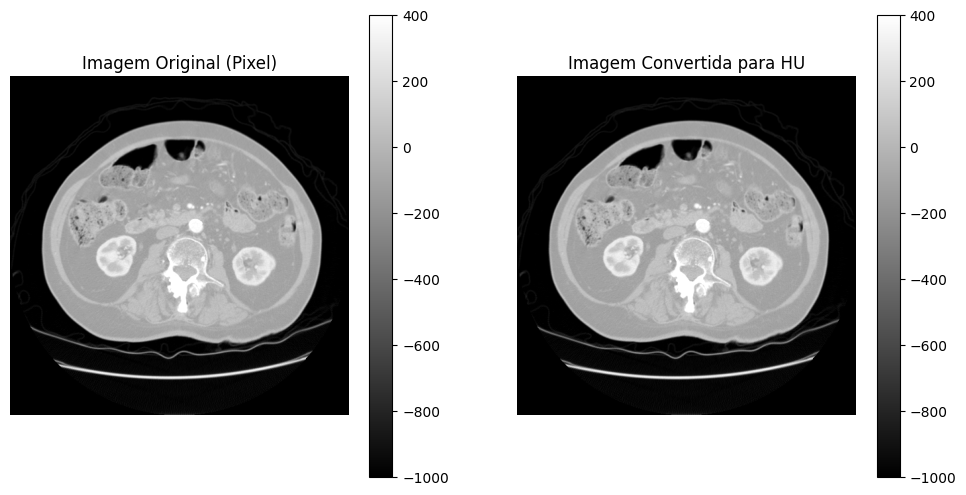

In [107]:
# Obter a imagem original (valores de pixel)
pixel_image = image.pixel_array

# Testar a função de conversão para HU
hu_image = convert_to_hu(image.pixel_array)

# Visualizar as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagem original (pixels)
axes[0].imshow(pixel_image, cmap='gray')
axes[0].set_title('Imagem Original (Pixel)')

# Imagem convertida para HU
axes[1].imshow(hu_image, cmap='gray')
axes[1].set_title('Imagem Convertida para HU')

# Mostrar as barras de cor
for ax in axes:
    ax.axis('off')
    plt.colorbar(ax.imshow(hu_image, cmap='gray'), ax=ax)

plt.show()

Na maioria dos casos, não há uma diferença visual muito evidente entre a imagem original (valores de pixel brutos) e a imagem convertida para Unidades Hounsfield (HU), quando ambas são exibidas em escala de cinza. Contudo, a diferença mais importante está no array de pixels em si, que agora tem valores que representam as densidades de diferentes materiais em termos de HU, que é a escala padrão usada na prática médica, como podemos ver:

In [108]:
# Imagem original
print(pixel_image)

[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]


In [109]:
# Imagem convertida
print(hu_image)

[[-1000 -1000 -1000 ... -1000 -1000 -1000]
 [-1000 -1000 -1000 ... -1000 -1000 -1000]
 [-1000 -1000 -1000 ... -1000 -1000 -1000]
 ...
 [-1000 -1000 -1000 ... -1000 -1000 -1000]
 [-1000 -1000 -1000 ... -1000 -1000 -1000]
 [-1000 -1000 -1000 ... -1000 -1000 -1000]]


**Normalizar**

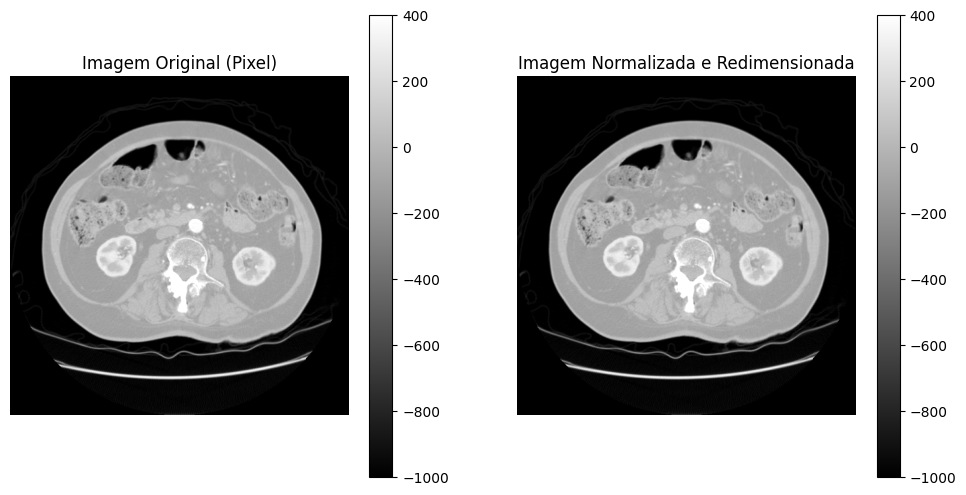

In [110]:
normalized_image = norm(hu_image)

# Visualizar as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagem original (pixels)
axes[0].imshow(pixel_image, cmap='gray')
axes[0].set_title('Imagem Original (Pixel)')

# Imagem convertida para HU
axes[1].imshow(normalized_image, cmap='gray')
axes[1].set_title('Imagem Normalizada e Redimensionada')

# Mostrar as barras de cor
for ax in axes:
    ax.axis('off')
    plt.colorbar(ax.imshow(hu_image, cmap='gray'), ax=ax)

plt.show()

Observadas assim lado a lado, também não vemos grandes diferenças, mas isso tem a haver com o modo como o  matplotlib mostra as imagens, pois se analisarmos as caracteristicas das imagens é possivel ver as diferenças:

- PIXEL_ARRAY

In [111]:
print(normalized_image)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Como não é possivel ver o array completo, podemos fazer um histograma que mostre as intensidades dos pixel's antes e depois da normalização:

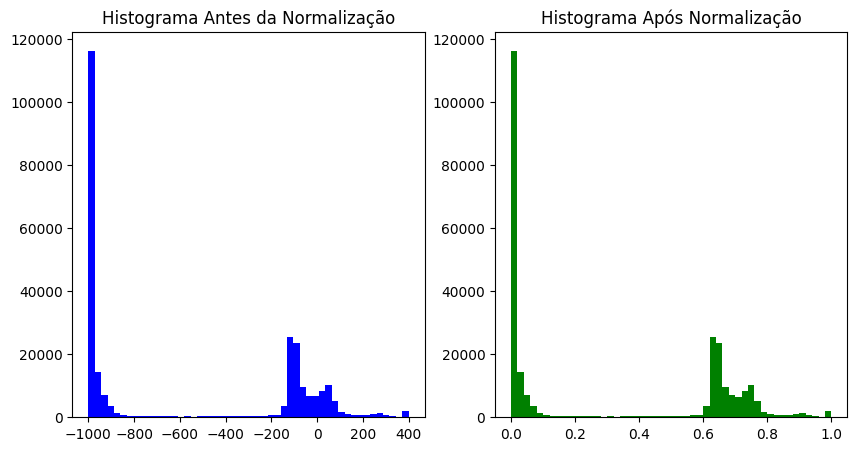

In [112]:
# Plotar o histograma dos valores de pixel antes e depois
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(hu_image.flatten(), bins=50, color='blue')
plt.title('Histograma Antes da Normalização')

plt.subplot(1, 2, 2)
plt.hist(normalized_image.flatten(), bins=50, color='green')
plt.title('Histograma Após Normalização')

plt.show()


Como podemos ver, de facto, existem diferenças nas escalas.

**Segmentação 2D**

Loading dicom files ... This may take a moment.


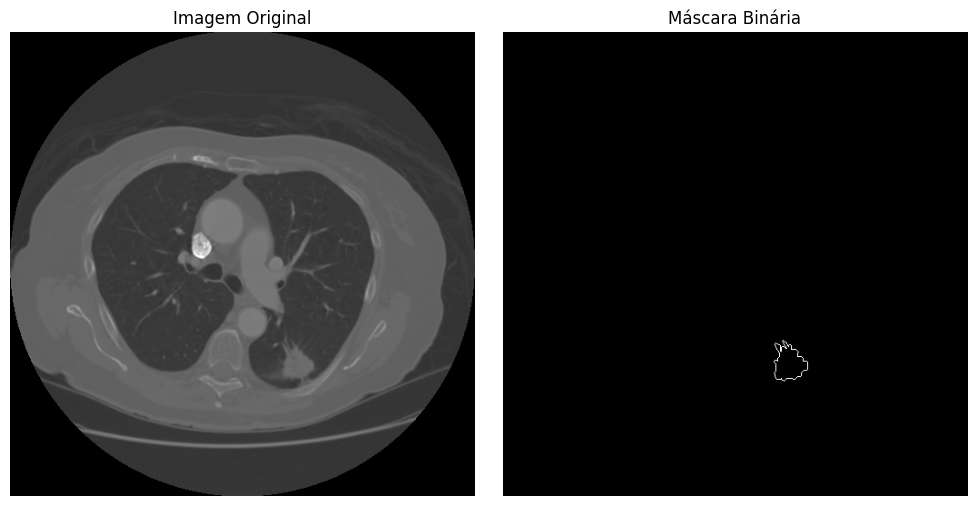

In [113]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').all()[0]
annotation = scan.annotations[0]
# Chamar a função para processar cada nódulo
imagem, mascara = segmentation_2d(scan, annotation)

# Criar um subplot para exibir as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar a imagem original no primeiro eixo
axes[0].imshow(imagem, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')  # Esconder os eixos

# Mostrar a máscara binária no segundo eixo
axes[1].imshow(mascara, cmap='gray')
axes[1].set_title('Máscara Binária')
axes[1].axis('off')  # Esconder os eixos

# Mostrar a figura com as duas imagens
plt.tight_layout()
plt.show()

Como podemos ver o segmentation em 2d está a funcionar corretamente. Neste caso o que fizemos foi dar à função as anotações relativas a um nódulo e deixamos que a função escolha o slice que passa pelo centro do centroide, devolvendo-nos a imagem e a respetiva máscara binária, como podemos ver observar.

**Segmentação 3D**

Loading dicom files ... This may take a moment.


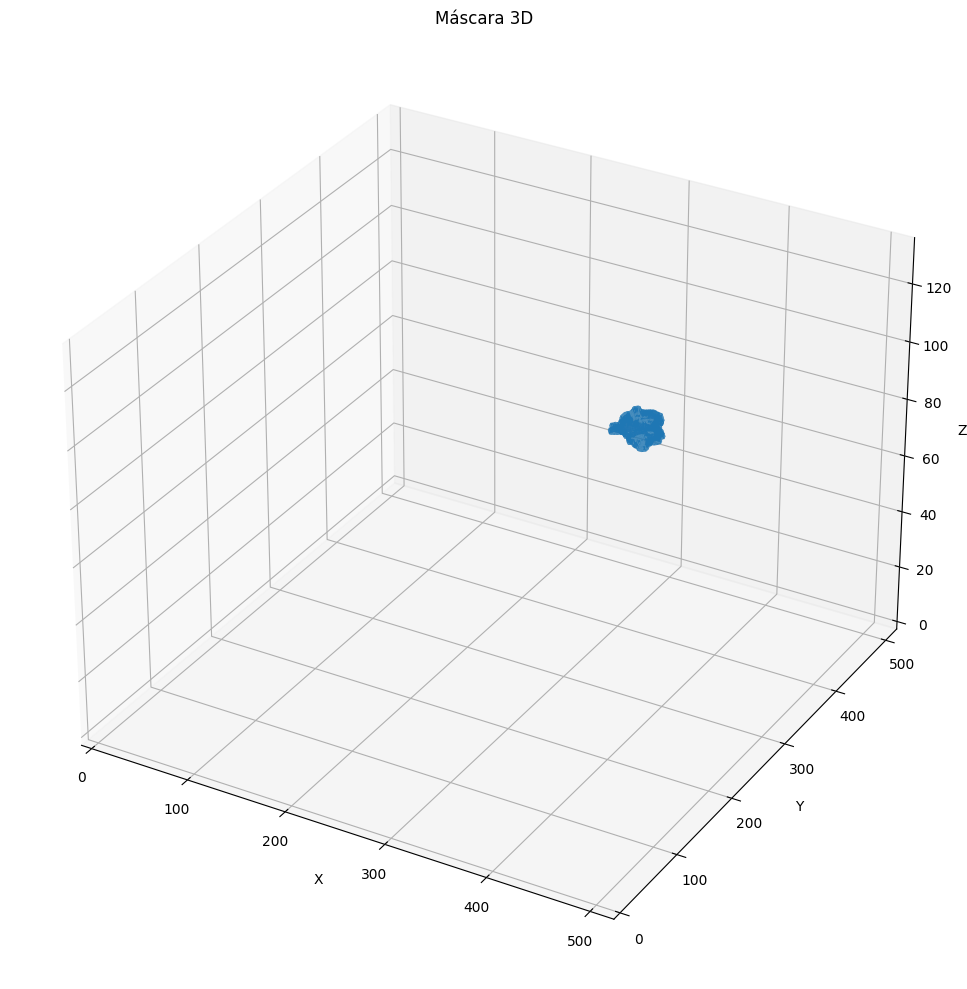

In [114]:
scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').all()[0]
annotations = scan.annotations
_, mascara_3d = segmentation_3d(scan, annotation)


# Encontrar a superfície da máscara binária usando marching cubes
verts, faces, _, _ = measure.marching_cubes(mascara_3d, level=0)

# Criar a figura e o eixo 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Renderizar a superfície 3D da máscara
mesh = Poly3DCollection(verts[faces], alpha=0.7)
ax.add_collection3d(mesh)

# Definir os limites do gráfico
ax.set_xlim(0, mascara_3d.shape[0])
ax.set_ylim(0, mascara_3d.shape[1])
ax.set_zlim(0, mascara_3d.shape[2])

# Ajustar a visualização
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Máscara 3D")

plt.tight_layout()
plt.show()

Como podemos ver a função de segmentação em 3d também está a funcionar corretamente, como podemos observar pela máscara binária criada.

# Extração de Features - Pyradiomics <a name = "efp"></a>
[[voltar ao índice]](#indice)

**IR BUSCAR OS PACIENTES E OS NÓDULOS A ANALISAR**

Vamos buscar os pacientes que tem nódulos malignos e benignos e que temos informação dos outros datasets:

In [115]:
df= pd.read_csv("data.csv")
df['Nódulo ID'] = df['Nódulo ID'].astype(int)

In [116]:
patient_dict = df.groupby('Patient_ID')['Nódulo ID'].apply(lambda x: list(set(x))).to_dict()

**Extração de Features -> 2D**

Vamos configurar as features que queremos extrair das imagens 2D, para evitar que descarreguemos features descenessárias: 

In [117]:
extractor_2d = featureextractor.RadiomicsFeatureExtractor() 

extractor_2d.disableAllFeatures()

extractor_2d.enableFeatureClassByName('firstorder')   
extractor_2d.enableFeatureClassByName('glcm')         
extractor_2d.enableFeatureClassByName('glrlm')        
extractor_2d.enableFeatureClassByName('glszm')        
extractor_2d.enableFeatureClassByName('gldm')         
extractor_2d.enableFeatureClassByName('ngtdm')        
extractor_2d.enableFeatureClassByName('shape2D')      

feature_list = [] 

Agora podemos começar a extração dos dados que serão guardados num CSV.

In [118]:
def processar_pacientes(patient_dict, extractor):
    feature_list = []
    
    for patient_id in patient_dict:
        print(patient_id)
        # Obter os scans por paciente
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()

        for _, scan in enumerate(scans):            
            # Obter todas as anotações (nódulos) para esse scan
            annotations = scan.annotations

            # Iterar dentro dos nódulos
            for nodule_idx, annotation in enumerate(annotations):
                if nodule_idx + 1 in patient_dict[patient_id]:                    
                    # Chamar a função para processar cada nódulo
                    imagem, mascara = segmentation_2d(scan, annotation)
                    
                    # Converter a imagem para unidades HU
                    imagem_hu = convert_to_hu(imagem)
                    
                    # Converter a imagem e a máscara para SimpleITK
                    imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                    mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                    
                    # Extrair as features radiômicas
                    features = extractor.execute(imagem_sitk, mascara_sitk)
                    
                    feature_dict = dict(features)
                    
                    # Adicionar o ID do paciente e o ID do nódulo ao dicionário de features
                    feature_dict['Patient_ID'] = patient_id
                    feature_dict['Nodule_ID'] = nodule_idx + 1
                    
                    # Adicionar o dicionário à lista de features
                    feature_list.append(feature_dict)

    # Converter a lista de dicionários em um DataFrame do pandas
    df_features = pd.DataFrame(feature_list)
    
    # Salvar o DataFrame em um arquivo CSV com codificação UTF-8
    df_features.to_csv('radiomics_features.csv', index=False, encoding='utf-8')
    
    return df_features

# Chamar a função principal para processar os pacientes e salvar o resultado no CSV
result_features = processar_pacientes(patient_dict, extractor_2d)

LIDC-IDRI-0001
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0003
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0004
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0007
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0011
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0013
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0015
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0016
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0018
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0021
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0023
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0031
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0034
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0037
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0039
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0043
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0044
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0045
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0046
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0047
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0049
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0051
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0052
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0053
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0054
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0057
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0058
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0059
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0061
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0066
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0067
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0068
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0072
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0073
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0075
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0077
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0078
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0080
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0081
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0082
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0085
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0087
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0088
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0089
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0094
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0095
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0106
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0108
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0111
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0116
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0118
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0119
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0120
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0121
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0124
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0126
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0130
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0142
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0144
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0148
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0156
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0160
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0163
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0168
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0169
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0170
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0171
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0172
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0183
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0185
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0186
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0187
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0188
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0190
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0191
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0193
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0194
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0195
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0196
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0203
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0206
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0211
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0212
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0213
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0215
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0217
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0221
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0222
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0229
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0240
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0242
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0244
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0248
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0249
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0250
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0256
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0262
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0263
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0265
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0267
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0272
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0276
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0281
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0284
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0286
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0287
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0294
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0305
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0309
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0313
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0321
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0325
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0332
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0337
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0346
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0347
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0348
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0351
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0353
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0354
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0359
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0362
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0368
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0375
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0376
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0377
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0379
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0380
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0385
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0386
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0390
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0399
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0402
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0403
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0407
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0412
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0415
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0419
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0421
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0423
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0426
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0427
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0433
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0436
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0437
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0440
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0443
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0447
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0450
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0456
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0461
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0462
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0463
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0464
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0466
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0470
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0473
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0481
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0485
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0486
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0488
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0489
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0492
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0496
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0497
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0507
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0515
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0523
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0526
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0529
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0530
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0537
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0541
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0542
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0546
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0559
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0562
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0565
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0568
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0569
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0572
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0576
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0578
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0587
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0590
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0602
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0604
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0605
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0606
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0610
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0614
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0615
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0617
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0619
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0620
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0625
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0639
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0640
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0641
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0642
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0645
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0648
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0649
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0655
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0660
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0663
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0671
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0674
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0678
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0686
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0697
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0698
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0702
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0704
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0708
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0709
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0713
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0715
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0717
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0722
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0726
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0727
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0732
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0740
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0748
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0749
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0751
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0756
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0759
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0772
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0773
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0775
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0776
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0777
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0785
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0791
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0796
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0797
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0798
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0799
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0801
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0807
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0811
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0819
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0822
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0825
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0827
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0838
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0843
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0844
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0849
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0850
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0854
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0855
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0858
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0860
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0861
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0866
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0869
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0871
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0875
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0879
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0884
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0886
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0890
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0892
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0893
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0895
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0902
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0905
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0908
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0910
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0912
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0913
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0914
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0916
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0919
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0921
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0925
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0929
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0933
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0935
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0936
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0938
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0940
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0944
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0951
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0956
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0961
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0963
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0965
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0966
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0968
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0976
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0980
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0987
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0993
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0994
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0997
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0999
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1002
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1004
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1007
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1011
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1012
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


**Extração de Features -> 3D**

Tal como configuramos as features que queremos extrair das imagens 2D, vamos agora fazer o mesmo para as imagens 3d

In [119]:
extractor_3d = featureextractor.RadiomicsFeatureExtractor() 

extractor_3d.disableAllFeatures()

extractor_3d.enableFeatureClassByName('firstorder')   
extractor_3d.enableFeatureClassByName('glcm')         
extractor_3d.enableFeatureClassByName('glrlm')        
extractor_3d.enableFeatureClassByName('glszm')        
extractor_3d.enableFeatureClassByName('gldm')         
extractor_3d.enableFeatureClassByName('ngtdm')        
extractor_3d.enableFeatureClassByName('shape3D')   

Feature class shape3D is not recognized


Agora podemos começar a extração dos dados que serão guardados num CSV.

In [120]:
def processar_pacientes_3D(patient_dict, extractor):
    feature_list = []
    
    for patient_id in patient_dict:
        print(patient_id)
        # Obter os scans por paciente
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()

        for _, scan in enumerate(scans):
            print(f"Processando paciente {patient_id}")
            
            # Obter todas as anotações (nódulos) para esse scan
            annotations = scan.annotations

            # Iterar dentro dos nódulos
            for nodule_idx, annotation in enumerate(annotations):
                if nodule_idx + 1 in patient_dict[patient_id]:
                    print(f"  Processando nódulo {nodule_idx + 1}/{len(annotations)}")
                    
                    # Chamar a função para processar cada nódulo
                    imagem, mascara = segmentation_3d(scan, annotation)
                    
                    # Converter a imagem para unidades HU
                    imagem_hu = convert_to_hu(imagem)
                    
                    # Converter a imagem e a máscara para SimpleITK
                    imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                    mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                    
                    # Extrair as features radiômicas
                    features = extractor.execute(imagem_sitk, mascara_sitk)
                    
                    feature_dict = dict(features)
                    
                    # Adicionar o ID do paciente e o ID do nódulo ao dicionário de features
                    feature_dict['Patient_ID'] = patient_id
                    feature_dict['Nodule_ID'] = nodule_idx + 1
                    
                    # Adicionar o dicionário à lista de features
                    feature_list.append(feature_dict)

    # Converter a lista de dicionários em um DataFrame do pandas
    df_features = pd.DataFrame(feature_list)
    
    # Salvar o DataFrame em um arquivo CSV com codificação UTF-8
    df_features.to_csv('radiomics_features_3d.csv', index=False, encoding='utf-8')
    
    return df_features

# Chamar a função principal para processar os pacientes e salvar o resultado no CSV
result_features = processar_pacientes_3D(patient_dict, extractor_3d)

LIDC-IDRI-0001
Processando paciente LIDC-IDRI-0001
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0003
Processando paciente LIDC-IDRI-0003
  Processando nódulo 2/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0004
Processando paciente LIDC-IDRI-0004
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0007
Processando paciente LIDC-IDRI-0007
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0011
Processando paciente LIDC-IDRI-0011
  Processando nódulo 6/23
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 10/23
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0013
Processando paciente LIDC-IDRI-0013
  Processando nódulo 3/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0015
Processando paciente LIDC-IDRI-0015
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0016
Processando paciente LIDC-IDRI-0016
  Processando nódulo 1/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0018
Processando paciente LIDC-IDRI-0018
  Processando nódulo 4/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0021
Processando paciente LIDC-IDRI-0021
  Processando nódulo 3/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0023
Processando paciente LIDC-IDRI-0023
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0031
Processando paciente LIDC-IDRI-0031
  Processando nódulo 3/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0034
Processando paciente LIDC-IDRI-0034
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0037
Processando paciente LIDC-IDRI-0037
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0039
Processando paciente LIDC-IDRI-0039
  Processando nódulo 1/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0043
Processando paciente LIDC-IDRI-0043
  Processando nódulo 3/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0044
Processando paciente LIDC-IDRI-0044
  Processando nódulo 2/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0045
Processando paciente LIDC-IDRI-0045
  Processando nódulo 3/33
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/33
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 10/33
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0046
Processando paciente LIDC-IDRI-0046
  Processando nódulo 5/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0047
Processando paciente LIDC-IDRI-0047
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0049
Processando paciente LIDC-IDRI-0049
  Processando nódulo 12/39
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 15/39
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0051
Processando paciente LIDC-IDRI-0051
  Processando nódulo 2/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0052
Processando paciente LIDC-IDRI-0052
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0053
Processando paciente LIDC-IDRI-0053
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0054
Processando paciente LIDC-IDRI-0054
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0057
Processando paciente LIDC-IDRI-0057
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0058
Processando paciente LIDC-IDRI-0058
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0059
Processando paciente LIDC-IDRI-0059
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0061
Processando paciente LIDC-IDRI-0061
  Processando nódulo 1/19
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0066
Processando paciente LIDC-IDRI-0066
  Processando nódulo 2/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0067
Processando paciente LIDC-IDRI-0067
  Processando nódulo 1/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0068
Processando paciente LIDC-IDRI-0068
  Processando nódulo 6/22
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0072
Processando paciente LIDC-IDRI-0072
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0073
Processando paciente LIDC-IDRI-0073
  Processando nódulo 3/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0075
Processando paciente LIDC-IDRI-0075
  Processando nódulo 2/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0077
Processando paciente LIDC-IDRI-0077
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0078
Processando paciente LIDC-IDRI-0078
  Processando nódulo 4/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0080
Processando paciente LIDC-IDRI-0080
  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0081
Processando paciente LIDC-IDRI-0081
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0082
Processando paciente LIDC-IDRI-0082
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0085
Processando paciente LIDC-IDRI-0085
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0087
Processando paciente LIDC-IDRI-0087
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0088
Processando paciente LIDC-IDRI-0088
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0089
Processando paciente LIDC-IDRI-0089
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0094
Processando paciente LIDC-IDRI-0094
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0095
Processando paciente LIDC-IDRI-0095
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0106
Processando paciente LIDC-IDRI-0106
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0108
Processando paciente LIDC-IDRI-0108
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0111
Processando paciente LIDC-IDRI-0111
  Processando nódulo 2/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0116
Processando paciente LIDC-IDRI-0116
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0118
Processando paciente LIDC-IDRI-0118
  Processando nódulo 1/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0119
Processando paciente LIDC-IDRI-0119
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0120
Processando paciente LIDC-IDRI-0120
  Processando nódulo 4/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0121
Processando paciente LIDC-IDRI-0121
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0124
Processando paciente LIDC-IDRI-0124
  Processando nódulo 5/35
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0126
Processando paciente LIDC-IDRI-0126
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0130
Processando paciente LIDC-IDRI-0130
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0142
Processando paciente LIDC-IDRI-0142
  Processando nódulo 1/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0144
Processando paciente LIDC-IDRI-0144
  Processando nódulo 1/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0148
Processando paciente LIDC-IDRI-0148
  Processando nódulo 2/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0156
Processando paciente LIDC-IDRI-0156
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0160
Processando paciente LIDC-IDRI-0160
  Processando nódulo 1/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0163
Processando paciente LIDC-IDRI-0163
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0168
Processando paciente LIDC-IDRI-0168
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0169
Processando paciente LIDC-IDRI-0169
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0170
Processando paciente LIDC-IDRI-0170
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0171
Processando paciente LIDC-IDRI-0171
  Processando nódulo 1/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0172
Processando paciente LIDC-IDRI-0172
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0183
Processando paciente LIDC-IDRI-0183
  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0185
Processando paciente LIDC-IDRI-0185
  Processando nódulo 3/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0186
Processando paciente LIDC-IDRI-0186
  Processando nódulo 5/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0187
Processando paciente LIDC-IDRI-0187
  Processando nódulo 4/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0188
Processando paciente LIDC-IDRI-0188
  Processando nódulo 4/24
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0190
Processando paciente LIDC-IDRI-0190
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0191
Processando paciente LIDC-IDRI-0191
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0193
Processando paciente LIDC-IDRI-0193
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0194
Processando paciente LIDC-IDRI-0194
  Processando nódulo 2/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0195
Processando paciente LIDC-IDRI-0195
  Processando nódulo 2/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0196
Processando paciente LIDC-IDRI-0196
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0203
Processando paciente LIDC-IDRI-0203
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0206
Processando paciente LIDC-IDRI-0206
  Processando nódulo 1/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0211
Processando paciente LIDC-IDRI-0211
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0212
Processando paciente LIDC-IDRI-0212
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0213
Processando paciente LIDC-IDRI-0213
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0215
Processando paciente LIDC-IDRI-0215
  Processando nódulo 4/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0217
Processando paciente LIDC-IDRI-0217
  Processando nódulo 1/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0221
Processando paciente LIDC-IDRI-0221
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0222
Processando paciente LIDC-IDRI-0222
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0229
Processando paciente LIDC-IDRI-0229
  Processando nódulo 2/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0240
Processando paciente LIDC-IDRI-0240
  Processando nódulo 5/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0242
Processando paciente LIDC-IDRI-0242
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0244
Processando paciente LIDC-IDRI-0244
  Processando nódulo 2/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0248
Processando paciente LIDC-IDRI-0248
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0249
Processando paciente LIDC-IDRI-0249
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0250
Processando paciente LIDC-IDRI-0250
  Processando nódulo 1/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0256
Processando paciente LIDC-IDRI-0256
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0262
Processando paciente LIDC-IDRI-0262
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0263
Processando paciente LIDC-IDRI-0263
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0265
Processando paciente LIDC-IDRI-0265
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0267
Processando paciente LIDC-IDRI-0267
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0272
Processando paciente LIDC-IDRI-0272
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0276
Processando paciente LIDC-IDRI-0276
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0281
Processando paciente LIDC-IDRI-0281
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0284
Processando paciente LIDC-IDRI-0284
  Processando nódulo 3/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0286
Processando paciente LIDC-IDRI-0286
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0287
Processando paciente LIDC-IDRI-0287
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0294
Processando paciente LIDC-IDRI-0294
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0305
Processando paciente LIDC-IDRI-0305
  Processando nódulo 8/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0309
Processando paciente LIDC-IDRI-0309
  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0313
Processando paciente LIDC-IDRI-0313
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0321
Processando paciente LIDC-IDRI-0321
  Processando nódulo 2/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0325
Processando paciente LIDC-IDRI-0325
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0332
Processando paciente LIDC-IDRI-0332
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando paciente LIDC-IDRI-0332
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0337
Processando paciente LIDC-IDRI-0337
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0346
Processando paciente LIDC-IDRI-0346
  Processando nódulo 1/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0347
Processando paciente LIDC-IDRI-0347
  Processando nódulo 4/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0348
Processando paciente LIDC-IDRI-0348
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0351
Processando paciente LIDC-IDRI-0351
  Processando nódulo 2/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0353
Processando paciente LIDC-IDRI-0353
  Processando nódulo 1/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0354
Processando paciente LIDC-IDRI-0354
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0359
Processando paciente LIDC-IDRI-0359
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0362
Processando paciente LIDC-IDRI-0362
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0368
Processando paciente LIDC-IDRI-0368
  Processando nódulo 4/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0375
Processando paciente LIDC-IDRI-0375
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0376
Processando paciente LIDC-IDRI-0376
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0377
Processando paciente LIDC-IDRI-0377
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0379
Processando paciente LIDC-IDRI-0379
  Processando nódulo 3/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0380
Processando paciente LIDC-IDRI-0380
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0385
Processando paciente LIDC-IDRI-0385
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0386
Processando paciente LIDC-IDRI-0386
  Processando nódulo 4/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0390
Processando paciente LIDC-IDRI-0390
  Processando nódulo 1/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 8/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0399
Processando paciente LIDC-IDRI-0399
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0402
Processando paciente LIDC-IDRI-0402
  Processando nódulo 10/27
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0403
Processando paciente LIDC-IDRI-0403
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0407
Processando paciente LIDC-IDRI-0407
  Processando nódulo 2/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0412
Processando paciente LIDC-IDRI-0412
  Processando nódulo 3/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0415
Processando paciente LIDC-IDRI-0415
  Processando nódulo 7/24
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0419
Processando paciente LIDC-IDRI-0419
  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0421
Processando paciente LIDC-IDRI-0421
  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0423
Processando paciente LIDC-IDRI-0423
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0426
Processando paciente LIDC-IDRI-0426
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0427
Processando paciente LIDC-IDRI-0427
  Processando nódulo 1/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0433
Processando paciente LIDC-IDRI-0433
  Processando nódulo 3/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0436
Processando paciente LIDC-IDRI-0436
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0437
Processando paciente LIDC-IDRI-0437
  Processando nódulo 1/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0440
Processando paciente LIDC-IDRI-0440
  Processando nódulo 2/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0443
Processando paciente LIDC-IDRI-0443
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0447
Processando paciente LIDC-IDRI-0447
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0450
Processando paciente LIDC-IDRI-0450
  Processando nódulo 8/29
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0456
Processando paciente LIDC-IDRI-0456
  Processando nódulo 1/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0461
Processando paciente LIDC-IDRI-0461
  Processando nódulo 6/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0462
Processando paciente LIDC-IDRI-0462
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0463
Processando paciente LIDC-IDRI-0463
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0464
Processando paciente LIDC-IDRI-0464
  Processando nódulo 3/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0466
Processando paciente LIDC-IDRI-0466
  Processando nódulo 1/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0470
Processando paciente LIDC-IDRI-0470
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0473
Processando paciente LIDC-IDRI-0473
  Processando nódulo 1/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0481
Processando paciente LIDC-IDRI-0481
  Processando nódulo 4/23
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0485
Processando paciente LIDC-IDRI-0485
  Processando nódulo 2/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0486
Processando paciente LIDC-IDRI-0486
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0488
Processando paciente LIDC-IDRI-0488
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0489
Processando paciente LIDC-IDRI-0489
  Processando nódulo 1/22
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/22
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/22
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0492
Processando paciente LIDC-IDRI-0492
  Processando nódulo 2/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0496
Processando paciente LIDC-IDRI-0496
  Processando nódulo 2/11
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0497
Processando paciente LIDC-IDRI-0497
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0507
Processando paciente LIDC-IDRI-0507
  Processando nódulo 1/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0515
Processando paciente LIDC-IDRI-0515
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0523
Processando paciente LIDC-IDRI-0523
  Processando nódulo 5/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0526
Processando paciente LIDC-IDRI-0526
  Processando nódulo 1/19
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/19
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0529
Processando paciente LIDC-IDRI-0529
  Processando nódulo 4/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0530
Processando paciente LIDC-IDRI-0530
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0537
Processando paciente LIDC-IDRI-0537
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0541
Processando paciente LIDC-IDRI-0541
  Processando nódulo 2/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0542
Processando paciente LIDC-IDRI-0542
  Processando nódulo 3/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0546
Processando paciente LIDC-IDRI-0546
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0559
Processando paciente LIDC-IDRI-0559
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0562
Processando paciente LIDC-IDRI-0562
  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0565
Processando paciente LIDC-IDRI-0565
  Processando nódulo 1/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0568
Processando paciente LIDC-IDRI-0568
  Processando nódulo 2/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0569
Processando paciente LIDC-IDRI-0569
  Processando nódulo 3/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0572
Processando paciente LIDC-IDRI-0572
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0576
Processando paciente LIDC-IDRI-0576
  Processando nódulo 3/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0578
Processando paciente LIDC-IDRI-0578
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0587
Processando paciente LIDC-IDRI-0587
  Processando nódulo 5/19
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0590
Processando paciente LIDC-IDRI-0590
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0602
Processando paciente LIDC-IDRI-0602
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0604
Processando paciente LIDC-IDRI-0604
  Processando nódulo 2/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0605
Processando paciente LIDC-IDRI-0605
  Processando nódulo 2/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0606
Processando paciente LIDC-IDRI-0606
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0610
Processando paciente LIDC-IDRI-0610
  Processando nódulo 2/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0614
Processando paciente LIDC-IDRI-0614
  Processando nódulo 3/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0615
Processando paciente LIDC-IDRI-0615
  Processando nódulo 1/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0617
Processando paciente LIDC-IDRI-0617
  Processando nódulo 2/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0619
Processando paciente LIDC-IDRI-0619
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0620
Processando paciente LIDC-IDRI-0620
  Processando nódulo 1/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0625
Processando paciente LIDC-IDRI-0625
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0639
Processando paciente LIDC-IDRI-0639
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0640
Processando paciente LIDC-IDRI-0640
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0641
Processando paciente LIDC-IDRI-0641
  Processando nódulo 4/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0642
Processando paciente LIDC-IDRI-0642
  Processando nódulo 4/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0645
Processando paciente LIDC-IDRI-0645
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0648
Processando paciente LIDC-IDRI-0648
  Processando nódulo 3/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0649
Processando paciente LIDC-IDRI-0649
  Processando nódulo 1/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 8/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 10/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 11/37
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0655
Processando paciente LIDC-IDRI-0655
  Processando nódulo 6/26
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 8/26
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0660
Processando paciente LIDC-IDRI-0660
  Processando nódulo 5/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0663
Processando paciente LIDC-IDRI-0663
  Processando nódulo 3/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0671
Processando paciente LIDC-IDRI-0671
  Processando nódulo 3/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0674
Processando paciente LIDC-IDRI-0674
  Processando nódulo 5/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0678
Processando paciente LIDC-IDRI-0678
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0686
Processando paciente LIDC-IDRI-0686
  Processando nódulo 17/49
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0697
Processando paciente LIDC-IDRI-0697
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0698
Processando paciente LIDC-IDRI-0698
  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0702
Processando paciente LIDC-IDRI-0702
  Processando nódulo 5/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0704
Processando paciente LIDC-IDRI-0704
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0708
Processando paciente LIDC-IDRI-0708
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0709
Processando paciente LIDC-IDRI-0709
  Processando nódulo 2/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0713
Processando paciente LIDC-IDRI-0713
  Processando nódulo 1/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/17
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0715
Processando paciente LIDC-IDRI-0715
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0717
Processando paciente LIDC-IDRI-0717
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0722
Processando paciente LIDC-IDRI-0722
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0726
Processando paciente LIDC-IDRI-0726
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0727
Processando paciente LIDC-IDRI-0727
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0732
Processando paciente LIDC-IDRI-0732
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0740
Processando paciente LIDC-IDRI-0740
  Processando nódulo 1/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0748
Processando paciente LIDC-IDRI-0748
  Processando nódulo 3/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0749
Processando paciente LIDC-IDRI-0749
  Processando nódulo 1/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0751
Processando paciente LIDC-IDRI-0751
  Processando nódulo 1/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0756
Processando paciente LIDC-IDRI-0756
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0759
Processando paciente LIDC-IDRI-0759
  Processando nódulo 2/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0772
Processando paciente LIDC-IDRI-0772
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0773
Processando paciente LIDC-IDRI-0773
  Processando nódulo 5/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0775
Processando paciente LIDC-IDRI-0775
  Processando nódulo 3/32
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/32
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0776
Processando paciente LIDC-IDRI-0776
  Processando nódulo 3/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0777
Processando paciente LIDC-IDRI-0777
  Processando nódulo 2/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0785
Processando paciente LIDC-IDRI-0785
  Processando nódulo 1/28
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 5/28
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0791
Processando paciente LIDC-IDRI-0791
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0796
Processando paciente LIDC-IDRI-0796
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0797
Processando paciente LIDC-IDRI-0797
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0798
Processando paciente LIDC-IDRI-0798
  Processando nódulo 3/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0799
Processando paciente LIDC-IDRI-0799
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0801
Processando paciente LIDC-IDRI-0801
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0807
Processando paciente LIDC-IDRI-0807
  Processando nódulo 4/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0811
Processando paciente LIDC-IDRI-0811
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0819
Processando paciente LIDC-IDRI-0819
  Processando nódulo 2/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0822
Processando paciente LIDC-IDRI-0822
  Processando nódulo 6/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 7/18
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0825
Processando paciente LIDC-IDRI-0825
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0827
Processando paciente LIDC-IDRI-0827
  Processando nódulo 2/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0838
Processando paciente LIDC-IDRI-0838
  Processando nódulo 5/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0843
Processando paciente LIDC-IDRI-0843
  Processando nódulo 2/22
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/22
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/22
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0844
Processando paciente LIDC-IDRI-0844
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0849
Processando paciente LIDC-IDRI-0849
  Processando nódulo 5/15
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0850
Processando paciente LIDC-IDRI-0850
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0854
Processando paciente LIDC-IDRI-0854
  Processando nódulo 4/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0855
Processando paciente LIDC-IDRI-0855
  Processando nódulo 15/40
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 16/40
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0858
Processando paciente LIDC-IDRI-0858
  Processando nódulo 3/32
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0860
Processando paciente LIDC-IDRI-0860
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0861
Processando paciente LIDC-IDRI-0861
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0866
Processando paciente LIDC-IDRI-0866
  Processando nódulo 2/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0869
Processando paciente LIDC-IDRI-0869
  Processando nódulo 2/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0871
Processando paciente LIDC-IDRI-0871
  Processando nódulo 8/24
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0875
Processando paciente LIDC-IDRI-0875
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0879
Processando paciente LIDC-IDRI-0879
  Processando nódulo 1/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0884
Processando paciente LIDC-IDRI-0884
  Processando nódulo 2/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0886
Processando paciente LIDC-IDRI-0886
  Processando nódulo 3/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0890
Processando paciente LIDC-IDRI-0890
  Processando nódulo 3/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0892
Processando paciente LIDC-IDRI-0892
  Processando nódulo 4/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0893
Processando paciente LIDC-IDRI-0893
  Processando nódulo 2/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0895
Processando paciente LIDC-IDRI-0895
  Processando nódulo 3/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0902
Processando paciente LIDC-IDRI-0902
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0905
Processando paciente LIDC-IDRI-0905
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0908
Processando paciente LIDC-IDRI-0908
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0910
Processando paciente LIDC-IDRI-0910
  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0912
Processando paciente LIDC-IDRI-0912
  Processando nódulo 1/21
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0913
Processando paciente LIDC-IDRI-0913
  Processando nódulo 3/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0914
Processando paciente LIDC-IDRI-0914
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0916
Processando paciente LIDC-IDRI-0916
  Processando nódulo 2/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 8/25
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0919
Processando paciente LIDC-IDRI-0919
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0921
Processando paciente LIDC-IDRI-0921
  Processando nódulo 5/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0925
Processando paciente LIDC-IDRI-0925
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0929
Processando paciente LIDC-IDRI-0929
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0933
Processando paciente LIDC-IDRI-0933
  Processando nódulo 5/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 6/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0935
Processando paciente LIDC-IDRI-0935
  Processando nódulo 1/10
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0936
Processando paciente LIDC-IDRI-0936
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0938
Processando paciente LIDC-IDRI-0938
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0940
Processando paciente LIDC-IDRI-0940
  Processando nódulo 1/5
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0944
Processando paciente LIDC-IDRI-0944
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0951
Processando paciente LIDC-IDRI-0951
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0956
Processando paciente LIDC-IDRI-0956
  Processando nódulo 2/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0961
Processando paciente LIDC-IDRI-0961
  Processando nódulo 1/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/20
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0963
Processando paciente LIDC-IDRI-0963
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0965
Processando paciente LIDC-IDRI-0965
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0966
Processando paciente LIDC-IDRI-0966
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0968
Processando paciente LIDC-IDRI-0968
  Processando nódulo 2/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0976
Processando paciente LIDC-IDRI-0976
  Processando nódulo 2/6
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0980
Processando paciente LIDC-IDRI-0980
  Processando nódulo 1/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/8
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0987
Processando paciente LIDC-IDRI-0987
  Processando nódulo 1/9
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0993
Processando paciente LIDC-IDRI-0993
  Processando nódulo 1/3
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0994
Processando paciente LIDC-IDRI-0994
  Processando nódulo 5/14
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0997
Processando paciente LIDC-IDRI-0997
  Processando nódulo 3/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 4/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0999
Processando paciente LIDC-IDRI-0999
  Processando nódulo 4/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1002
Processando paciente LIDC-IDRI-1002
  Processando nódulo 3/16
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1004
Processando paciente LIDC-IDRI-1004
  Processando nódulo 1/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/12
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1007
Processando paciente LIDC-IDRI-1007
  Processando nódulo 1/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 2/7
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1011
Processando paciente LIDC-IDRI-1011
  Processando nódulo 2/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


  Processando nódulo 3/13
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1012
Processando paciente LIDC-IDRI-1012
  Processando nódulo 1/4
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


# Tratamento de Dados do Pyradiomics <a name = "tdp"></a>
[[voltar ao índice]](#indice)

Uma vez recolhidos os dados do Pyradiomics é necessário juntar esses dados aos que tinham sido previamente extraidos do pylidc.

**Features 2D**

In [121]:
df_2d = pd.read_csv('radiomics_features.csv')

In [122]:
df_2d.head()

diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                     1.23.5   
1                           v3.0.1                     1.23.5   
2                           v3.0.1                     1.23.5   
3                           v3.0.1                     1.23.5   
4                           v3.0.1                     1.23.5   

  diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.4.0                          1.4.1   
1                          2.4.0                          1.4.1   
2                          2.4.0                          1.4.1   
3                          2.4.0                          1.4.1   
4                          2.4.0                          1.4.1   

  diagnostics_Versions_Python  \
0                      3.8.20   
1                      3.8.20   
2                      3.8.20   
3                      3.8.20   
4                      3.8.20   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  6a4838357bc6f2d070314113e53ad10a6773983d   
1  e690ec733adecd1b08ae397a5d1b54da427c1eb2   
2  3489985bfba778d8c797e5004fb898ed12a05a96   
3  c1f9622d521dd7aedfd695c2f1a52555d709899d   
4  aa2f4614a0c85f0074f1f7f4f177e421200ca894   

  diagnostics_Image-original_Dimensionality  \
0                                        2D   
1                                        2D   
2                                        2D   
3                                        2D   
4                                        2D   

  diagnostics_Image-original_Spacing  ...  \
0                         (1.0, 1.0)  ...   
1                         (1.0, 1.0)  ...   
2                         (1.0, 1.0)  ...   
3                         (1.0, 1.0)  ...   
4                         (1.0, 1.0)  ...   

  original_gldm_SmallDependenceEmphasis  \
0                              0.111187   
1                              0.111111   
2                              0.194444   
3                              0.406474   
4                              0.111111   

   original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                           0.178261    
1                                           0.111111    
2                                           4.694444    
3                                          24.535187    
4                                           0.111111    

   original_gldm_SmallDependenceLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                           0.101194                 0.510938   
1                                           0.111111                 0.000000   
2                                           0.124132                 9.800000   
3                                           0.127847                 1.308232   
4                                           0.111111                 0.000000   

  original_ngtdm_Coarseness original_ngtdm_Complexity original_ngtdm_Contrast  \
0                  0.501529                  0.091389                0.000306   
1            1000000.000000                  0.000000                0.000000   
2                  0.142857                  7.000000                3.250000   
3                  0.021374                280.673533                0.256388   
4            1000000.000000                  0

Vamos começar por verificar se existem valores nulos no dataset:

In [123]:
df_2d.isna().sum()

diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
diagnostics_Versions_PyWavelet      0
diagnostics_Versions_Python         0
                                   ..
original_ngtdm_Complexity           0
original_ngtdm_Contrast             0
original_ngtdm_Strength             0
Patient_ID                          0
Nodule_ID                           0
Length: 126, dtype: int64

In [124]:
df_2d.isnull().values.any()

False

Como podemos comprovar não existem valores nulos.

Agora vamos ver que colunas tem apenas um unico valor para as podermos eliminar, uma vez que não tem significância estatística.

In [125]:
# Variavel que guarda as colunas com valores unicos
unique_value_counts = df_2d.nunique()

In [126]:
# Remoção das colunas com valores unicos
columns_with_single_unique_value = unique_value_counts[unique_value_counts == 1].index
print(columns_with_single_unique_value)
df_2d.drop(columns = columns_with_single_unique_value, inplace = True)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size',
       'original_firstorder_10Percentile', 'original_firstorder_Minimum'],
      dtype='object')


Para além das colunas que apenas apresentam valores únicos, também podemos remover aquelas features que são irrelevantes por servirem de identificação da máscara e da imagem, uma vez que não se encontram na documentação do pyradiomics:

In [127]:
colunas_irrelevantes = [
    'diagnostics_Image-original_Hash',
    'diagnostics_Image-original_Mean',
    'diagnostics_Mask-original_Hash',
    'diagnostics_Mask-original_BoundingBox',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
    'diagnostics_Mask-original_CenterOfMassIndex',
    'diagnostics_Mask-original_CenterOfMass',
]

In [128]:
# Remover as colunas irrelevantes do dataframe
df_2d = df_2d.drop(columns=colunas_irrelevantes)

Vamos apenas confirmar o tipo de dados que temos:

In [129]:
tipos_presentes = df_2d.dtypes.unique()
tipos_presentes_str = [str(tipo) for tipo in tipos_presentes]
print(tipos_presentes_str)

['float64', 'object', 'int64']


Quais são as colunas do tipo object?

In [130]:
colunas_object = df_2d.select_dtypes(include=['object']).columns.tolist()
print(colunas_object)

['Patient_ID']


Não há nenhum problema no dataset, pois esta coluna será usada para fazer o merge e depois será removida.

Por fim, nesta parte do trabalho na qual não analisamos a real relevância de cada feature, falta-nos apenas juntar as características semânticas de cada nódulo ao dataset 'radiomics_features' para termos todas as variáveis que possam ser importantes analisar. Além disso, é nesse dataset onde está classificado os nódulos como maligno ou benigno.

In [131]:
# Carregar ambos os DataFrames
df_data = pd.read_csv('data.csv')
df_data.rename(columns = {'Nódulo ID': 'Nodule_ID'}, inplace = True)

# Fazer a junção usando as colunas corretas
df_merged_2d = pd.merge(df_data, df_2d, on = ['Patient_ID', 'Nodule_ID'], how = 'inner')

In [132]:
# Exibir as primeiras linhas do DataFrame final
df_merged_2d.head()

Patient_ID  Nodule_ID  Número de Nódulos  Quantidade de Anotações  \
0  LIDC-IDRI-0001          1                  1                        4   
1  LIDC-IDRI-0003          2                  4                        4   
2  LIDC-IDRI-0004          1                  1                        4   
3  LIDC-IDRI-0007          1                  2                        4   
4  LIDC-IDRI-0011          6                 10                        4   

   Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  ...  \
0            5           3           3       4         5        5  ...   
1            2           2           4       3         5        4  ...   
2            1           1           2       5         2        5  ...   
3            5           1           4       3         5        5  ...   
4            1           1           5       5         3        5  ...   

   original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                          11.258299   
1                                           9.000000   
2                                           7.643973   
3                                           5.172723   
4                                           9.000000   

   original_gldm_LowGrayLevelEmphasis  original_gldm_SmallDependenceEmphasis  \
0                            0.990007                               0.111187   
1                            1.000000                               0.111111   
2                            0.929688                               0.194444   
3                            0.665108                               0.406474   
4                            1.000000                               0.111111   

   original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                           0.178261    
1                                           0.111111    
2                                           4.694444    
3                                          24.535187    
4                                           0.111111    

   original_gldm_SmallDependenceLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                           0.101194                 0.510938   
1                                           0.111111                 0.000000   
2                                           0.124132                 9.800000   
3                                           0.127847                 1.308232   
4                                           0.111111                 0.000000   

   original_ngtdm_Coarseness  original_ngtdm_Complexity  \
0                   0.501529                   0.091389   
1             1000000.000000                   0.000000   
2                   0.142857                   7.000000   
3                   0.021374                 280.673533   
4             1000000.000000                   0.000000   

   original_ngtdm_Contrast  original_ngtdm_Strength  
0                 0.000306                 1.992683  
1                 0.000000                 0.000000  
2                 3.250000                 7.000000  
3                 0.256388                12.749540  
4                 0.000000                 0.000000  

[5 rows x 113 columns]

**Features 3D**

Vamos agora realizar exatamente o mesmo processo que foi feito para as features 2D, mas para as 3D.

In [133]:
df_3d = pd.read_csv('radiomics_features_3d.csv')

In [134]:
df_3d.head()

diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                     1.23.5   
1                           v3.0.1                     1.23.5   
2                           v3.0.1                     1.23.5   
3                           v3.0.1                     1.23.5   
4                           v3.0.1                     1.23.5   

  diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.4.0                          1.4.1   
1                          2.4.0                          1.4.1   
2                          2.4.0                          1.4.1   
3                          2.4.0                          1.4.1   
4                          2.4.0                          1.4.1   

  diagnostics_Versions_Python  \
0                      3.8.20   
1                      3.8.20   
2                      3.8.20   
3                      3.8.20   
4                      3.8.20   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  0b9beeba634aecfd62439c1850906895ec46d22b   
1  118a0902267d8bbe81f8da2b81af12eb7c146f0a   
2  af8c88993ad1c10bc811040c9490dc6cda0367cb   
3  abf0382e2fef988b8427cefbcc3e612a85aa16c8   
4  1057ae31b9a466266e22f62efbfec32edfb7cda4   

  diagnostics_Image-original_Dimensionality  \
0                                        3D   
1                                        3D   
2                                        3D   
3                                        3D   
4                                        3D   

  diagnostics_Image-original_Spacing  ...  \
0                    (1.0, 1.0, 1.0)  ...   
1                    (1.0, 1.0, 1.0)  ...   
2                    (1.0, 1.0, 1.0)  ...   
3                    (1.0, 1.0, 1.0)  ...   
4                    (1.0, 1.0, 1.0)  ...   

  original_gldm_SmallDependenceEmphasis  \
0                              0.052187   
1                              0.052858   
2                              0.128962   
3                              0.253939   
4                              0.036659   

   original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                           0.080941    
1                                           0.052858    
2                                          17.313172    
3                                          13.904382    
4                                           0.036659    

   original_gldm_SmallDependenceLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                           0.048548                 0.885347   
1                                           0.052858                 0.000000   
2                                           0.037435                 5.002831   
3                                           0.062528                 6.788652   
4                                           0.036659                 0.000000   

  original_ngtdm_Coarseness original_ngtdm_Complexity original_ngtdm_Contrast  \
0                  0.284191                  0.032596                0.000051   
1            1000000.000000                  0.000000                0.000000   
2                  0.015397                200.108114                1.744897   
3                  0.002780                400.910706                0.059704   
4            1000000.000000                  0

Tal como foi feito anteriormente, vamos ver se existem valores nulos:

In [135]:
df_3d.isna().sum()

diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
diagnostics_Versions_PyWavelet      0
diagnostics_Versions_Python         0
                                   ..
original_ngtdm_Complexity           0
original_ngtdm_Contrast             0
original_ngtdm_Strength             0
Patient_ID                          0
Nodule_ID                           0
Length: 117, dtype: int64

In [136]:
df_3d.isnull().values.any()

False

Este dataset também não apresenta valores nulos. Mas será que existem colunas com valores únicos?

In [137]:
# Variavel que guarda as colunas com valores unicos
unique_value_counts = df_3d.nunique()

In [138]:
# Remoção das colunas com valores unicos
columns_with_single_unique_value = unique_value_counts[unique_value_counts == 1].index
print(columns_with_single_unique_value)
df_3d.drop(columns = columns_with_single_unique_value, inplace = True)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Mask-original_Spacing', 'original_firstorder_10Percentile',
       'original_firstorder_Median', 'original_firstorder_Minimum'],
      dtype='object')


Após uma breve analise, reparamos que as colunas irrelevantes que apenas indicavam as versões utilizadas no radiomics_features.csv, são as mesmas neste dataset, logo também serão eliminadas:

In [139]:
# Remover as colunas irrelevantes do dataframe
df_3d = df_3d.drop(columns = colunas_irrelevantes)

Vamos apenas confirmar o tipo de dados que temos:

In [140]:
tipos_presentes = df_3d.dtypes.unique()
tipos_presentes_str = [str(tipo) for tipo in tipos_presentes]
print(tipos_presentes_str)

['object', 'float64', 'int64']


Quais são as colunas do tipo object?

In [141]:
colunas_object = df_3d.select_dtypes(include=['object']).columns.tolist()
print(colunas_object)

['diagnostics_Image-original_Size', 'diagnostics_Mask-original_Size', 'Patient_ID']


In [142]:
print(df_3d['diagnostics_Image-original_Size'].head())

0    (133, 512, 512)
1    (140, 512, 512)
2    (241, 512, 512)
3    (145, 512, 512)
4    (128, 512, 512)
Name: diagnostics_Image-original_Size, dtype: object


In [143]:
print(df_3d['diagnostics_Mask-original_Size'].head())

0    (133, 512, 512)
1    (140, 512, 512)
2    (241, 512, 512)
3    (145, 512, 512)
4    (128, 512, 512)
Name: diagnostics_Mask-original_Size, dtype: object


As colunas 'diagnostics_Image-original_Size' e 'diagnostics_Mask-original_Size' estão no tipo string, contudo, de modo a melhorar a qualidade do modelos que iremos usar no futuro, vamos tranformar estas colunas em tuplos e de seguida subdividi-los em três novas colunas, de modo a que cada uma delas fique com os dados de cada posição do tuplo, convertendo tudo para numérico.

In [144]:
# Converter strings de tupla para tupla numérica apenas se o valor for uma string: image
df_3d['diagnostics_Image-original_Size'] = df_3d['diagnostics_Image-original_Size'].apply(
    lambda x: tuple(map(float, x.strip("()").split(", "))) if isinstance(x, str) else x
)

# Converter strings de tupla para tupla numérica apenas se o valor for uma string: mask
df_3d['diagnostics_Mask-original_Size'] = df_3d['diagnostics_Mask-original_Size'].apply(
    lambda x: tuple(map(float, x.strip("()").split(", "))) if isinstance(x, str) else x
)

df_3d[['diagnostics_Image-original_Size_x', 'diagnostics_Image-original_Size_y', 'diagnostics_Image-original_Size_z']] = pd.DataFrame(df_3d['diagnostics_Image-original_Size'].tolist(), index=df_3d.index)

df_3d[['diagnostics_Mask-original_Size_x', 'diagnostics_Mask-original_Size_y', 'diagnostics_Mask-original_Size_z']] = pd.DataFrame(df_3d['diagnostics_Mask-original_Size'].tolist(), index=df_3d.index)

# Remova as colunas originais com tuplas
df_3d = df_3d.drop(['diagnostics_Image-original_Size', 'diagnostics_Mask-original_Size'], axis=1)


Falta apenas juntar os datasets:

In [145]:
df_data.rename(columns = {'Nódulo ID': 'Nodule_ID'}, inplace = True)

# Fazer a junção usando as colunas corretas
df_merged_3d = pd.merge(df_data, df_3d, on = ['Patient_ID', 'Nodule_ID'], how = 'inner')

In [146]:
df_merged_3d

Patient_ID  Nodule_ID  Número de Nódulos  Quantidade de Anotações  \
0    LIDC-IDRI-0001          1                  1                        4   
1    LIDC-IDRI-0003          2                  4                        4   
2    LIDC-IDRI-0004          1                  1                        4   
3    LIDC-IDRI-0007          1                  2                        4   
4    LIDC-IDRI-0011          6                 10                        4   
..              ...        ...                ...                      ...   
405  LIDC-IDRI-1007          1                  2                        4   
406  LIDC-IDRI-1007          2                  2                        3   
407  LIDC-IDRI-1011          2                  4                        4   
408  LIDC-IDRI-1011          3                  4                        4   
409  LIDC-IDRI-1012          1                  1                        4   

     Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  ...  \
0              5           3           3       4         5        5  ...   
1              2           2           4       3         5        4  ...   
2              1           1           2       5         2        5  ...   
3              5           1           4       3         5        5  ...   
4              1           1           5       5         3        5  ...   
..           ...         ...         ...     ...       ...      ...  ...   
405            1           1           3       4         3        5  ...   
406            2           2           4       4         5        5  ...   
407            1           3           3       4         5        5  ...   
408            1           1           3       3         5        5  ...   
409            1           1           4       2         4        5  ...   

     original_ngtdm_Coarseness  original_ngtdm_Complexity  \
0                     0.284191                   0.032596   
1               1000000.000000                   0.000000   
2                     0.015397                 200.108114   
3                     0.002780                 400.910706   
4               1000000.000000                   0.000000   
..                         ...                        ...   
405             1000000.000000                   0.000000   
406             1000000.000000                   0.000000   
407             1000000.000000                   0.000000   
408             1000000.000000                   0.000000   
409             1000000.000000                   0.000000   

     original_ngtdm_Contrast  original_ngtdm_Strength  \
0                   0.000051                 0.950551   
1                   0.000000                 0.000000   
2                   1.744897                13.837206   
3                   0.059704                 4.995332   
4                   0.000000                 0.000000   
..                       ...                      ...   
405                 0.000000                 0.000000   
406                 0.000000                 0.000000   
407                 0.000000                 0.000000   
408                 0.000000                 0.000000   
409                 0.000000                 0.000000   

     diagnostics_Image-original_Size_x  diagnostics_Image-original_Size_y  \
0                                133.0                              512.0   
1                                140.0                              512.0   
2                                241.0                              512.0   
3                                145.0                              512.0   
4                                128.0                              512.0   
..                                 ...                                ...   
405                              186.0                              512.0   
406                              186.0                              512.0   
407                              133.0          

**Guardar os datasets**

Antes de guardar os datsets podemos apenas remover as colunas 'Patient_ID' e 'Nodule_ID' uma vez que não serão mais necessárias. O seu único propósito era facilitar a junção das diferentes features, logo, agora não tem qualquer utilidade, pois cada entrada corresponde a um nódulo. Para além dessas também podemos remover 'Número de Nódulos' e 'Quantidade de Anotações'.

In [147]:
df_merged_2d = df_merged_2d.drop(columns=['Patient_ID', 'Nodule_ID', 'Número de Nódulos', 'Quantidade de Anotações'])
df_merged_3d = df_merged_3d.drop(columns=['Patient_ID', 'Nodule_ID', 'Número de Nódulos', 'Quantidade de Anotações'])

In [148]:
# Salvar o DataFrame em um arquivo CSV com codificação UTF-8
df_merged_2d.to_csv('data_2d.csv', index=False, encoding='utf-8')
df_merged_3d.to_csv('data_3d.csv', index=False, encoding='utf-8')

# Feature Importance and Selection <a name = "fias"></a>
[[voltar ao índice]](#indice)

Após extrair as features, semânticas a partir do pyradiomics, obtivemos um dataset com um número elevado de features. Independentemente do modelo de classificação que escolhermos utilizar, é necessário implementar métodos que permitam selecionar as colunas (features) mais relevantes para a classificação dos nódulos, excluindo outras. A seleção das features foi, então, apoiada em três métodos distintos, utilizados na bibliografia referenciada abaixo. Estes métodos permitem reduzir significativamente a dimensionalidade do problema, o que contribui para uma maior eficácia por parte dos modelos de classificação. Esses métodos são:
- [Teste de Hipóteses: t-test](#t_test)
- [Principal Component Analysis](#pca)
- [Random Forest](#rd)

Uma vez que as funções a serem utilizadas para os modelos 2d e 3d são as mesmas, iremos reazilar ambas nesta parte do trabalho.

In [6]:
data_2d = pd.read_csv('data_2d.csv')
data_3d = pd.read_csv('data_3d.csv')

**1.Teste de Hipóteses: t-test**<a name = "t_test"></a> - [Tor23](#Tor23)

[[Feature Importance and Selection]](#fias)

Os testes de hipóteses são utilizados para apoiar a tomada de decisões. Neste caso, permitem avaliar a importância de cada feature do dataset obtido e selecionar as features relevantes à classificação. 
O teste utilizado pela bibliografia é o t-test. Trata-se de um teste estatístico usado para identificar que features são estatisticamente significativas para a classificação. Serão, assim, selecionadas as features cujo valor de significância (p-value) for inferior ao valor usualmente utilizado como threshold (0.05).  

Começamos por preparar o dataset, retirando a coluna 'Malignancy' (target). A variável X guarda as features e a variável y guarda o target.

In [7]:
X_2d = data_2d.drop(columns=["Malignancy"]) 
y_2d = data_2d['Malignancy']  # Target (0: benign, 1: malignant)
print("Dados 2:")
print(y_2d)

print("\n ------------------------ \n")

X_3d = data_3d.drop(columns=["Malignancy"]) 
y_3d = data_3d['Malignancy']
print("Dados 3:")
print(y_3d)

Dados 2:
0      1
1      1
2      0
3      1
4      0
      ..
405    0
406    1
407    1
408    1
409    0
Name: Malignancy, Length: 410, dtype: int64

 ------------------------ 

Dados 3:
0      1
1      1
2      0
3      1
4      0
      ..
405    0
406    1
407    1
408    1
409    0
Name: Malignancy, Length: 410, dtype: int64


De seguida, iremos separar os dados de acordo com a sua classificação (como benigno ou maligno), obtendo 2 grupos distintos.

In [8]:
benign_group_2d = X_2d[y_2d == 0]
malignant_group_2d = X_2d[y_2d == 1]

benign_group_3d = X_3d[y_3d == 0]
malignant_group_3d = X_3d[y_3d == 1]

Podemos agora realizar um t-test para cada feature e guardar os valor de significância. As features aparecem por ordem de significância.

In [9]:
t_test_results_2d = {}
for feature in X_2d.columns:
    t_stat, p_value = ttest_ind(benign_group_2d[feature], malignant_group_2d[feature], equal_var=False)
    t_test_results_2d[feature] = p_value
sorted_t_test_results_2d = pd.Series(t_test_results_2d).sort_values()
print("2D Features ranked by significance (p-value):")
print(sorted_t_test_results_2d)

print("\n ------------------------ \n")

t_test_results_3d = {}
for feature in X_3d.columns:
    t_stat, p_value = ttest_ind(benign_group_3d[feature], malignant_group_3d[feature], equal_var=False)
    t_test_results_3d[feature] = p_value
sorted_t_test_results_3d = pd.Series(t_test_results_3d).sort_values()
print("3D Features ranked by significance (p-value):")
print(sorted_t_test_results_3d)

2D Features ranked by significance (p-value):
Calcification                       6.293948e-51
original_shape2D_Sphericity         8.013241e-32
original_shape2D_MajorAxisLength    1.603369e-28
original_shape2D_MaximumDiameter    4.299303e-28
original_shape2D_MinorAxisLength    7.347870e-27
                                        ...     
original_ngtdm_Busyness             7.412270e-01
original_glcm_JointEntropy          8.297815e-01
original_glcm_DifferenceEntropy     8.323663e-01
original_glcm_SumEntropy            9.508391e-01
original_glcm_InverseVariance       9.829819e-01
Length: 108, dtype: float64

 ------------------------ 

3D Features ranked by significance (p-value):
Calcification                        6.293948e-51
Spiculation                          1.115950e-25
Lobulation                           9.117091e-25
Margin                               7.064467e-22
Subtlety                             8.737994e-20
                                         ...     
original_glc

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/4215019795.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = ttest_ind(benign_group_2d[feature], malignant_group_2d[feature], equal_var=False)
/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/4215019795.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = ttest_ind(benign_group_3d[feature], malignant_group_3d[feature], equal_var=False)


As features mais significativas para a classificação são aquelas que se encontram acima do threshold definido, isto é, cujo p-value é menor que 0.05.

In [10]:
significant_features_2d = sorted_t_test_results_2d[sorted_t_test_results_2d < 0.05].index.tolist()
print ("Número de features selecionadas para 2D:", len(significant_features_2d))

print("\n ------------------------ \n")

significant_features_3d = sorted_t_test_results_3d[sorted_t_test_results_3d < 0.05].index.tolist()
print ("Número de features selecionadas para 3D:", len(significant_features_3d))

Número de features selecionadas para 2D: 49

 ------------------------ 

Número de features selecionadas para 3D: 58


Como podemos ver o t-test escolheu as features que considerou mais significativas para cada dataset:

In [11]:
print("Dataset com features significativas 2D:")
data_ttest_2d = data_2d[significant_features_2d]
pd.concat([data_ttest_2d, y_2d], axis=1)

Dataset com features significativas 2D:


Calcification  original_shape2D_Sphericity  \
0                6                     0.116476   
1                6                     0.237705   
2                3                     0.293095   
3                6                     0.145259   
4                3                     0.288620   
..             ...                          ...   
405              6                     0.245244   
406              6                     0.112044   
407              6                     0.138573   
408              6                     0.154955   
409              6                     0.276215   

     original_shape2D_MajorAxisLength  original_shape2D_MaximumDiameter  \
0                           57.542760                         46.615448   
1                           17.090541                         14.317821   
2                            9.244896                          7.615773   
3                           40.718270                         34.205263   
4                           10.327956                          9.055385   
..                                ...                               ...   
405                         13.852837                         11.180340   
406                         61.575217                         53.907328   
407                         51.164214                         43.657760   
408                         41.452617                         32.140317   
409                         12.494295                         10.440307   

     original_shape2D_MinorAxisLength  original_firstorder_TotalEnergy  \
0                           44.910854                      163807321.0   
1                           13.404688                       33000000.0   
2                            5.813537                       13646416.0   
3                           30.919604                       90440738.0   
4                            8.944272                       18000000.0   
..                                ...                              ...   
405                         10.362272                       24000000.0   
406                         39.918046                      157000000.0   
407                         28.723704                      101000000.0   
408                         33.091465                       79000000.0   
409                          8.124406                       21000000.0   

     original_firstorder_Energy  original_shape2D_Perimeter  Spiculation  \
0                   163807321.0                  356.877200            5   
1                    33000000.0                   76.769553            2   
2                    13646416.0                   36.284271            1   
3                    90440738.0                  224.994949            5   
4                    18000000.0                   44.284271            1   
..                          ...                         ...          ...   
405                  24000000.0                   59.597980            1   
406                 157000000.0                  357.948268            2   
407                 101000000.0                  229.521861            1   
408                  79000000.0                  181.580736            1   
409                  21000000.0                   50.526912            1   

     original_shape2D_PixelSurface  ...  \
0                            164.0  ...   
1                             33.0  ...   
2                             14.0  ...   
3                            101.0  ...   
4                             18.0  ...   
..                             ...  ...   
405                           24.0  ...   
406                          157.0  ...   
407                          101.0  ...   
408                           79.0  ...   
409                           21.0  ...   

     original_firstorder_RobustMeanAbsoluteDeviation  \
0                                           0.000000   
1                                           0.000000   
2   

In [12]:
print("Dataset com features significativas 3D:")
data_ttest_3d = data_3d[significant_features_3d]
pd.concat([data_ttest_3d, y_3d], axis=1)

Dataset com features significativas 3D:


Calcification  Spiculation  Lobulation  Margin  Subtlety  \
0                6            5           3       4         5   
1                6            2           2       3         5   
2                3            1           1       5         2   
3                6            5           1       3         5   
4                3            1           1       5         3   
..             ...          ...         ...     ...       ...   
405              6            1           1       4         3   
406              6            2           2       4         5   
407              6            1           3       4         5   
408              6            1           1       3         5   
409              6            1           1       2         4   

     original_glrlm_GrayLevelNonUniformity  \
0                               757.880362   
1                                88.384615   
2                                34.515260   
3                               437.070150   
4                                33.846154   
..                                     ...   
405                              41.769231   
406                            1239.769231   
407                             573.307692   
408                             444.769231   
409                              47.846154   

     original_glrlm_RunLengthNonUniformity  \
0                               560.437962   
1                                65.418418   
2                                34.624099   
3                               674.745089   
4                                25.277877   
..                                     ...   
405                              30.870197   
406                             950.216242   
407                             411.691071   
408                             314.515156   
409                              40.702319   

     original_gldm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                              931.027689                9.385304e+08   
1                              106.000000                1.060000e+08   
2                               44.017544                5.373786e+07   
3                              534.484914                8.652093e+08   
4                               41.000000                4.100000e+07   
..                                    ...                         ...   
405                             50.000000                5.000000e+07   
406                           1483.000000                1.482982e+09   
407                            704.000000                7.040000e+08   
408                            556.000000                5.560000e+08   
409                             54.000000                5.400000e+07   

     original_firstorder_TotalEnergy  ...  original_glcm_Idmn  \
0                       9.385304e+08  ...            0.998849   
1                       1.060000e+08  ...            1.000000   
2                       5.373786e+07  ...            0.940932   
3                       8.652093e+08  ...            0.980366   
4                       4.100000e+07  ...            1.000000   
..                               ...  ...                 ...   
405                     5.000000e+07  ...            1.000000   
406                     1.482982e+09  ...            1.000000   
407                     7.040000e+08  ...            1.000000   
408                     5.560000e+08  ...            1.000000   
409                     5.400000e+07  ...            1.000000   

     original_glcm_ClusterTendency  original_ngtdm_Strength  \
0                         0.014641                 0.950551   
1                         0.000000                 0.000000   
2                        43.657600                13.837206   
3                        24.331627                 4.995332   
4                         0.000000                 0.000000   
..                             ...                      ...   
405                

**2. Principal Component Analysis** <a name = "pca"></a>- [LLZ18](#LLZ18)

[[Feature Importance and Selection]](#fias)

A análise dos componentes principais [(PCA)](#pca_ref) é um método usado em machine learning para resolver o problema da elevada dimensionalidade de dados. É um procedimento matemático que usa as dependências entre várias variáveis, no nosso caso as dependências entre as features, de maneira a reduzir o conjunto de dados, sem perder muita informação.

Começamos por preparar o dataset, retirando a coluna 'Malignancy' (target). A variável X guarda as features e a variável y guarda o target.

In [13]:
X_2d = data_2d.drop(columns=["Malignancy"]) 
y_2d = data_2d['Malignancy']  # Target (0: benign, 1: malignant)

X_3d = data_3d.drop(columns=["Malignancy"]) 
y_3d = data_3d['Malignancy']

Para obter resultados mais verosímeis, optámos por normalizar os dados, com o método 'fit_transform'. Este método é responsável por ajustar os dados de todas as colunas, de modo a que tenham média = 0 e desvio padrão = 1 (ajustando-os a uma distribuição normal).

In [14]:
scaler_2d = StandardScaler()
X_scaled_2d = scaler_2d.fit_transform(X_2d)

scaler_3d = StandardScaler()
X_scaled_3d = scaler_3d.fit_transform(X_3d)

Tendo os dados normalizados, podemos aplicar o PCA. O método consiste em obter componentes (features) através da diagonalização da matriz de covariância dos dados de cada coluna, que permite indicar o nível de correlação entre os pares. A matriz de covariância é então decomposta nos seus autovalores e autovetores. Os autovetores determinam as direções dos novos eixos (componentes principais), enquanto os autovalores determinam a sua importância.

In [15]:
pca_2d = PCA()
X_pca_2d = pca_2d.fit_transform(X_scaled_2d)

pca_3d = PCA()
X_pca_3d = pca_3d.fit_transform(X_scaled_3d)

É calculada a variância para cada componente principal e em seguida a variância cumulativa.

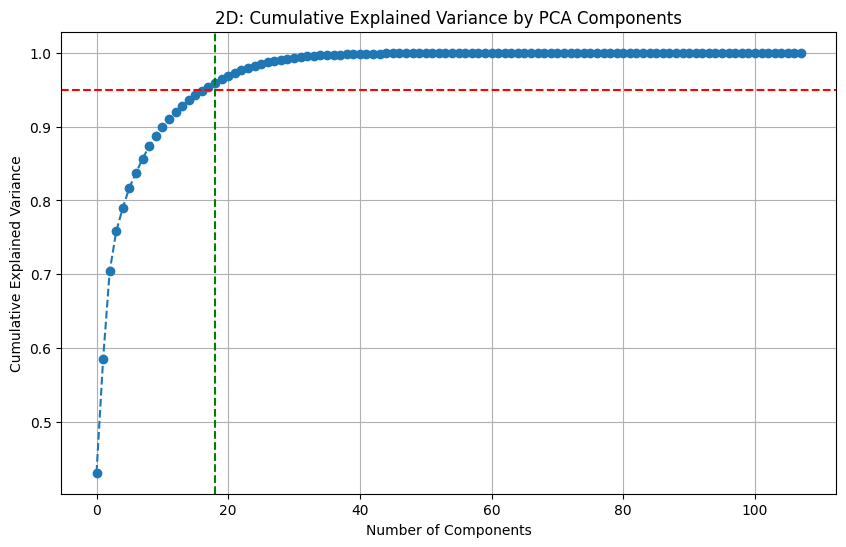

In [16]:
explained_variance_2d = pca_2d.explained_variance_ratio_
cumulative_variance_2d = explained_variance_2d.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_2d, marker='o', linestyle='--')
plt.title('2D: Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold line
plt.axvline(x=np.argmax(cumulative_variance_2d >= 0.95) + 1, color='g', linestyle='--')  # Number of components for 95%
plt.show()

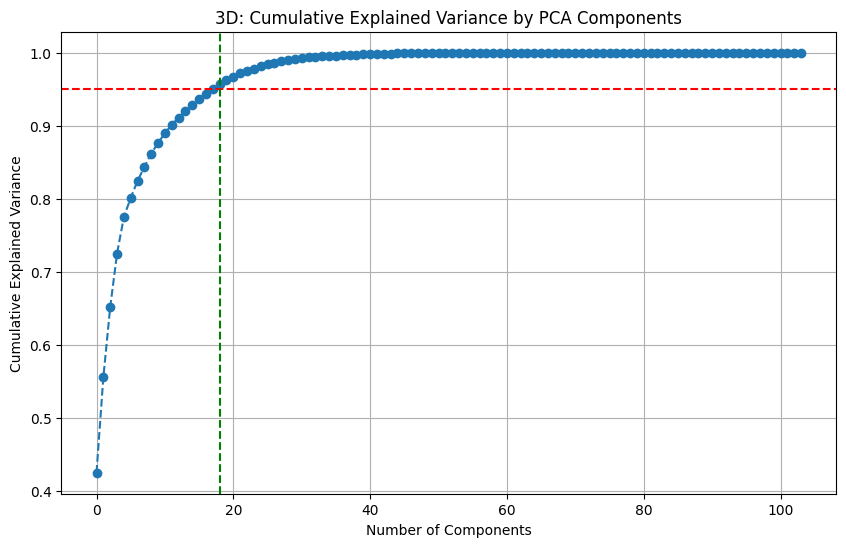

In [17]:
explained_variance_3d = pca_3d.explained_variance_ratio_
cumulative_variance_3d = explained_variance_3d.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_3d, marker='o', linestyle='--')
plt.title('3D: Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold line
plt.axvline(x=np.argmax(cumulative_variance_3d >= 0.95) + 1, color='g', linestyle='--')  # Number of components for 95%
plt.show()

Determinamos o número de componentes para a variância desejada.

In [18]:
n_components_2d = np.argmax(cumulative_variance_2d >= 0.95) + 1 # quantidade de componentes que explica 95% da variância)
pca_final_2d = PCA(n_components = n_components_2d)
reduced_features_2d = pca_final_2d.fit_transform(X_scaled_2d)
print("Número de features selecionadas 2D: ", n_components_2d)

print("\n ------------------------ \n")

n_components_3d = np.argmax(cumulative_variance_3d >= 0.95) + 1 # quantidade de componentes que explica 95% da variância)
pca_final_3d = PCA(n_components = n_components_3d)
reduced_features_3d = pca_final_3d.fit_transform(X_scaled_3d)
print("Número de features selecionadas 3D: ", n_components_3d)

Número de features selecionadas 2D:  18

 ------------------------ 

Número de features selecionadas 3D:  18


Como podemos ver o PCA determinou o número de features a agrupar de acordo com a variância encontrada, sendo essas:

In [19]:
print("Dataset com features agrupadas 2D:")
data_pca_2d = pd.DataFrame(data=reduced_features_2d, columns=[f'PC{i}' for i in range(n_components_2d)])
pd.concat([data_pca_2d, y_2d.reset_index(drop=True)], axis=1)

Dataset com features agrupadas 2D:


PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     0.605527  14.312994  2.618862 -5.010918 -1.873619  0.486000  3.780943   
1    -2.267379  -1.819947  0.040090  0.846899 -1.514118 -0.992908 -0.811545   
2     5.058170  -2.480426 -3.601613 -4.459463 -1.977084 -3.833077  1.266602   
3    26.065083   6.727777 -6.985184  4.449976 -1.804223  1.655932 -2.786482   
4    -2.158470  -3.958437 -0.673922  0.104410  1.383675 -1.097692  0.958196   
..         ...        ...       ...       ...       ...       ...       ...   
405  -2.233398  -2.998710 -0.378282  0.497056 -0.144041 -1.423559 -0.648699   
406  -2.923210  11.711044  5.856770  4.536946  0.801008 -0.007470  1.331167   
407  -2.716925   5.627624  3.129216  2.034017 -1.944248  1.328403  0.538597   
408  -2.511517   3.152825  2.056172  1.597862 -1.588072  0.221263  0.574015   
409  -2.493756  -2.801108 -0.163597 -0.006073  0.120255  1.392496 -1.301845   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0    4.509357 -3.000581  2.485737  0.280072  1.281586 -1.161818  2.506096   
1    0.548039 -0.191325  0.474135  0.777253  0.522630 -0.555025 -0.525174   
2    3.487037  0.174202 -3.689468 -2.493443 -2.397851  2.413588 -1.744844   
3   -3.047505  1.827419  1.127816  1.851693  0.324629 -2.575421  1.917357   
4   -0.653246  0.245743  0.075601 -0.395550  0.432105 -0.498446 -0.096061   
..        ...       ...       ...       ...       ...       ...       ...   
405  0.289676  0.122413  0.325009 -0.998632 -0.439882 -0.165449  0.604338   
406 -1.196007  0.614933 -2.745411 -1.343567 -0.232678  0.409916 -1.701848   
407 -0.491240  0.276382 -0.707462 -0.799203 -1.466120  0.316186 -0.732913   
408 -0.519261  0.386101 -0.228512 -0.288422  0.197071 -0.046711  0.199059   
409  0.218497 -0.266445  0.052311 -0.835398 -0.070959  0.625990 -0.076007   

         PC14      PC15      PC16      PC17  Malignancy  
0   -1.418022 -0.960150  0.979622 -2.705202           1  
1    0.099056 -0.658362 -0.094486 -0.035771           1  
2    2.832277  4.918582 -0.709808  0.405147           0  
3    1.008172  2.188989 -2.696890 -2.489348           1  
4    0.030861  0.062598 -0.281642 -0.444985           0  
..        ...       ...       ...       ...         ...  
405 -0.485219  0.312282 -0.701358  0.533368           0  
406 -1.518696 -0.590536 -0.523272  0.608692           1  
407  0.573080 -0.718251  0.112633  0.807437           1  
408  0.393201  0.331136 -0.147753  0.826526           1  
409  0.689238 -0.565327 -1.269216 -0.252564           0  

[410 rows x 19 columns]

In [20]:
print("Dataset com features agrupadas 3D:")
data_pca_3d = pd.DataFrame(data=reduced_features_3d, columns=[f'PC{i}' for i in range(n_components_3d)])
pd.concat([data_pca_3d, y_3d.reset_index(drop=True)], axis=1)

Dataset com features agrupadas 3D:


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0    -0.782122 -4.117717  1.807559  3.238631 -2.126003  0.470964  0.041700   
1    -2.459356  2.218242 -1.818623  2.089689  0.356737  1.117322 -0.424158   
2    13.960910  0.629641 -1.754254 -1.768815 -1.563777 -2.868636 -2.049989   
3    18.196420 -6.671389 -6.882279  1.530733  2.834788  2.809031 -2.197428   
4    -2.639728  3.325768 -2.169896  0.994315 -0.182417 -0.915270  1.220950   
..         ...       ...       ...       ...       ...       ...       ...   
405  -2.682271  3.198533 -2.295293  1.549300  0.057934 -0.301314  0.212454   
406  -2.269498 -5.455861  4.720836  7.225682  2.834643 -3.934610  3.135748   
407  -2.505729 -0.167273  0.442583  2.612708  2.009912  0.850195 -0.439097   
408  -2.686433  0.246159  0.531057  1.261710  1.665685  0.842926 -0.394356   
409  -2.196771  3.355261 -3.609834  4.514218 -0.464621  0.370936  0.322757   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0   -1.212518 -0.228025  1.411878 -0.530644  1.524379 -0.798404  0.067431   
1   -0.750689 -0.455177  0.237690 -0.714090  0.125701  0.490875 -0.677164   
2   -1.101771 -1.360056 -1.208177  2.233130 -1.096977 -0.204871  1.030177   
3    2.412911  1.963906 -0.768023 -0.338130  1.216001 -1.849959 -0.957012   
4    1.471481  0.151494 -0.920283  0.172468  0.007311 -0.018462 -0.373399   
..        ...       ...       ...       ...       ...       ...       ...   
405 -0.055443  0.960588 -1.390132  0.633414  0.079036 -0.302349  0.407926   
406 -0.186134  0.601032 -0.219536 -2.956456  1.584095  0.692787 -0.379135   
407  0.373260 -1.719275  0.402296  0.098159  0.101775 -0.011177  0.503033   
408  0.287286 -1.063678  0.383723 -0.668447 -0.059399  0.229292  1.453432   
409 -0.490927  1.152616 -0.312397 -0.888086 -0.959875 -0.120866 -0.603711   

         PC14      PC15      PC16      PC17  Malignancy  
0   -0.760704 -0.172903 -0.736586  0.546235           1  
1    0.364775  0.472962  0.032435 -0.078665           1  
2   -0.446237 -0.879446  1.539749  0.138501           0  
3    0.842149  2.095163  2.042272  1.706045           1  
4   -0.122091  0.597927 -0.449477  0.197056           0  
..        ...       ...       ...       ...         ...  
405 -0.701345 -0.262880  0.509413  0.069574           0  
406  0.373656 -0.605389  3.768712 -1.100696           1  
407 -0.334766 -0.264869 -0.247467 -0.241055           1  
408  0.633321 -0.060945 -0.111980  0.072243           1  
409  0.670398 -0.536214  0.393547  0.594748           0  

[410 rows x 19 columns]

**3. Random Forest -** <a name = "rd"></a> [CBMLN](#CBMLN)

[[Feature Importance and Selection]](#fias)

O algoritmo Random Forest também é usado para selecionar as features mais relevantes ao problema de classificação. Para tal, atribui determinada importância a cada feature na fase de treino do modelo, que corresponde à contribuição de cada feature para a classificação.

Começamos por preparar o dataset, retirando a coluna 'Malignancy' (target). A variável X guarda as features e a variável y guarda o target.

In [21]:
X_2d = data_2d.drop(columns=["Malignancy"]) 
y_2d = data_2d["Malignancy"]  # Target (0: benign, 1: malignant)

X_3d = data_3d.drop(columns=["Malignancy"]) 
y_3d = data_3d["Malignancy"]  # Target (0: benign, 1: malignant)

Podemos agora aplicar inicializar um modelo Random Forest para as features.

In [22]:
rf_features_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_features_2d.fit(X_2d, y_2d)

RandomForestClassifier(random_state=42)

In [23]:
rf_features_3d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_features_3d.fit(X_3d, y_3d)

RandomForestClassifier(random_state=42)

Para obter o valor de importância de cada feature, usamos o atributo do classificador .feature_importances_. Tendo estes valores, criamos um dataset com os nomes das features por ordem de importância

Feature Importances 2D:
                                             Feature  Importance
6                                      Calcification    0.119684
1                                         Lobulation    0.079919
0                                        Spiculation    0.069371
93              original_gldm_GrayLevelNonUniformity    0.051023
9                   original_shape2D_MajorAxisLength    0.047379
..                                               ...         ...
27   original_firstorder_RobustMeanAbsoluteDeviation    0.000050
25                        original_firstorder_Median    0.000000
104                        original_ngtdm_Coarseness    0.000000
53                  original_glcm_MaximumProbability    0.000000
40                   original_glcm_DifferenceEntropy    0.000000

[108 rows x 2 columns]


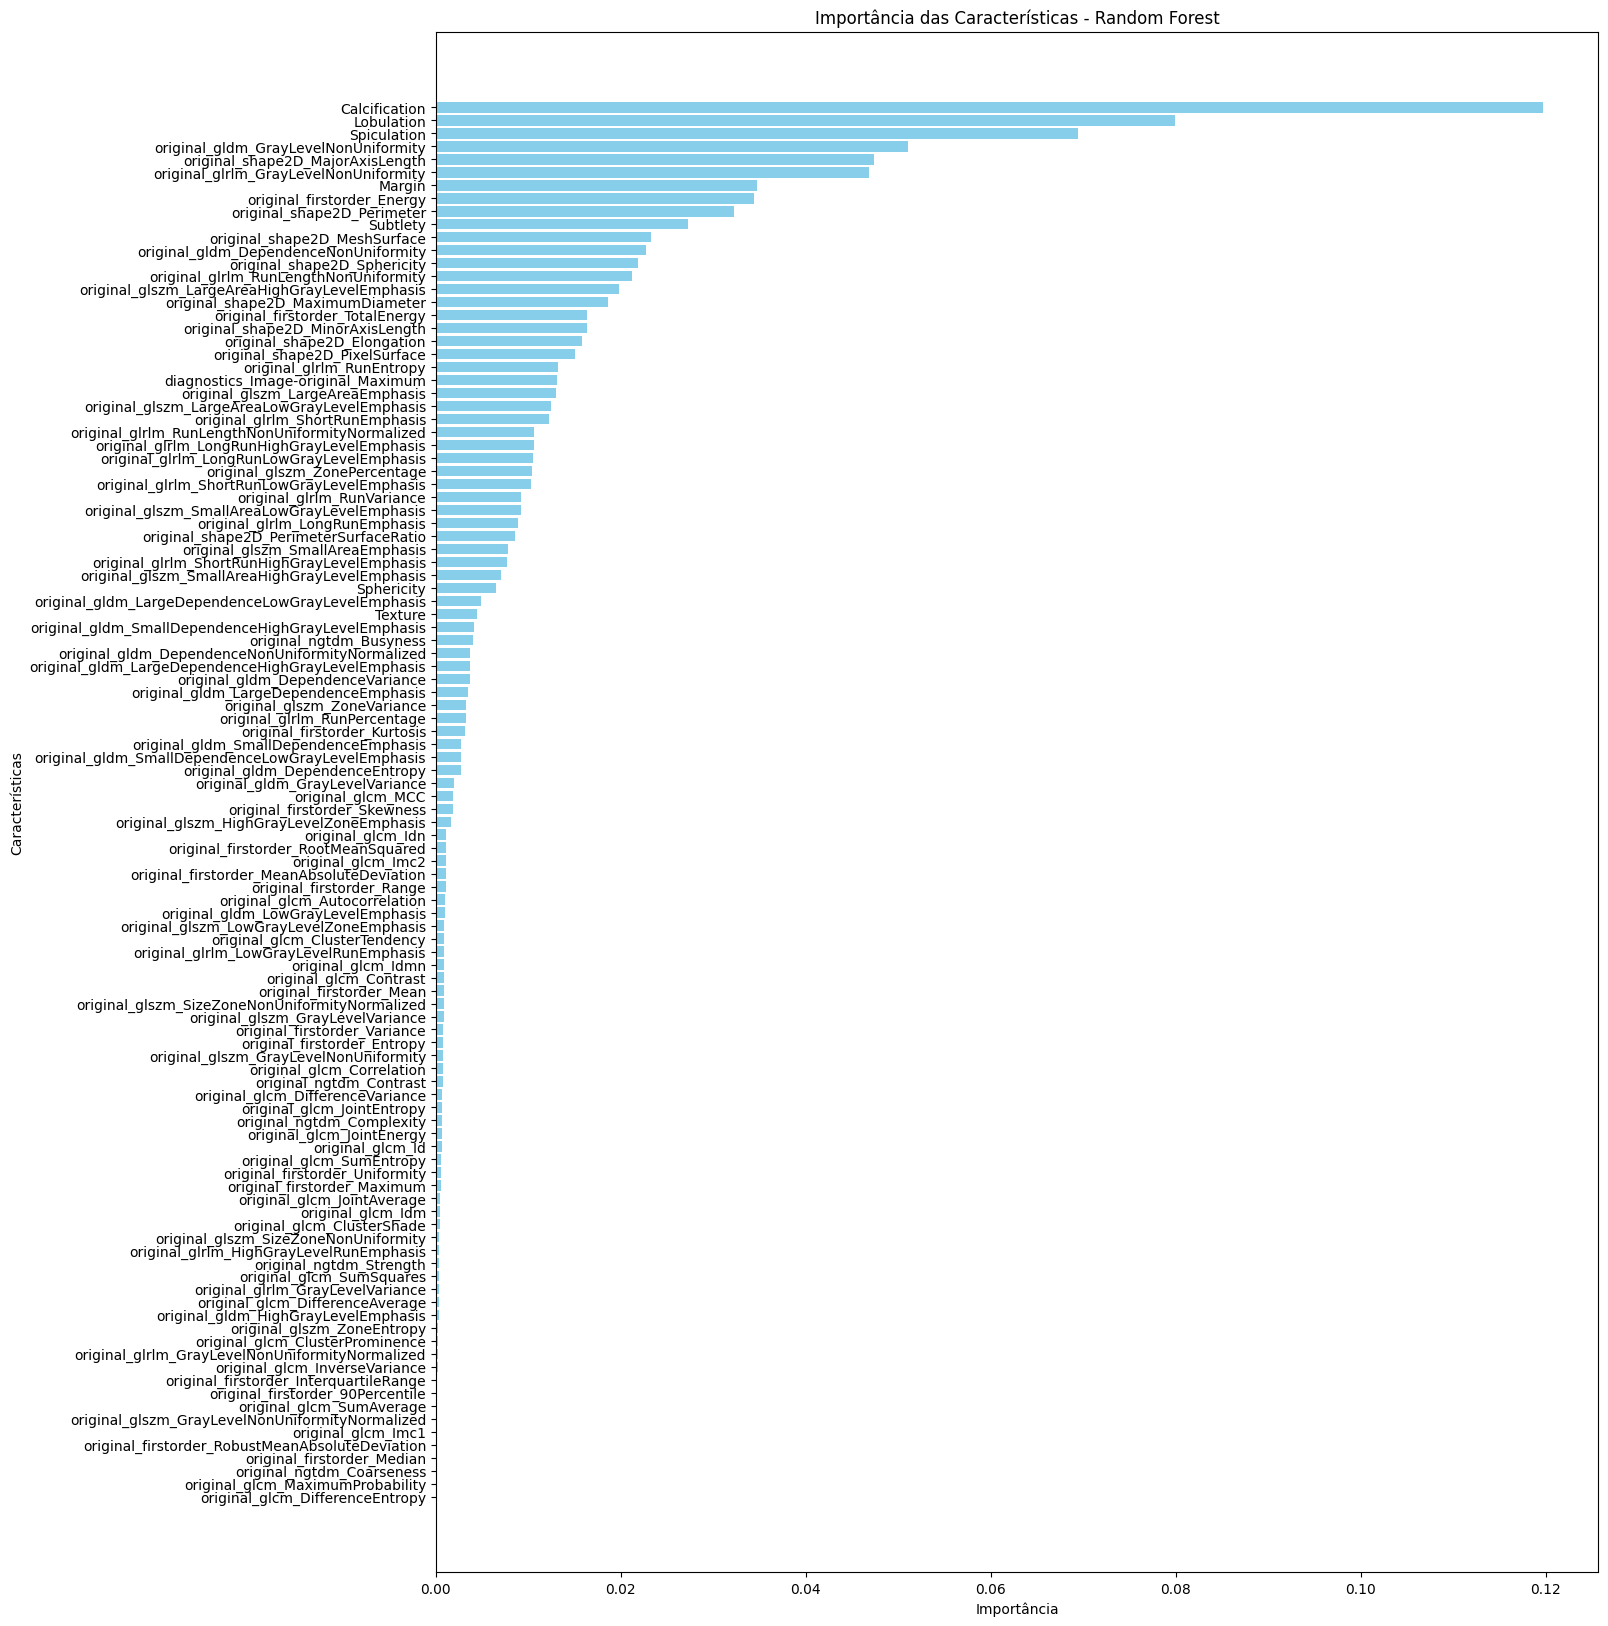

In [24]:
feature_importances_2d = rf_features_2d.feature_importances_
importances_df_2d = pd.DataFrame({"Feature": X_2d.columns, "Importance": feature_importances_2d})
importances_df_2d = importances_df_2d.sort_values(by="Importance", ascending=False)
print("Feature Importances 2D:")
print(importances_df_2d)

plt.figure(figsize=(15, 20))
plt.barh(importances_df_2d["Feature"], importances_df_2d["Importance"], color="skyblue")
plt.xlabel("Importância")
plt.ylabel("Características")
plt.title("Importância das Características - Random Forest")
plt.gca().invert_yaxis()  # Inverte o eixo para mostrar as características mais importantes no topo
plt.show()

Feature Importances 3D:
                                   Feature    Importance
6                            Calcification  1.436337e-01
0                              Spiculation  8.593508e-02
1                               Lobulation  7.461222e-02
3                                   Margin  4.364640e-02
47   original_glrlm_GrayLevelNonUniformity  4.244826e-02
..                                     ...           ...
7       diagnostics_Image-original_Maximum  3.615520e-07
99       diagnostics_Image-original_Size_y  0.000000e+00
100      diagnostics_Image-original_Size_z  0.000000e+00
102       diagnostics_Mask-original_Size_y  0.000000e+00
103       diagnostics_Mask-original_Size_z  0.000000e+00

[104 rows x 2 columns]


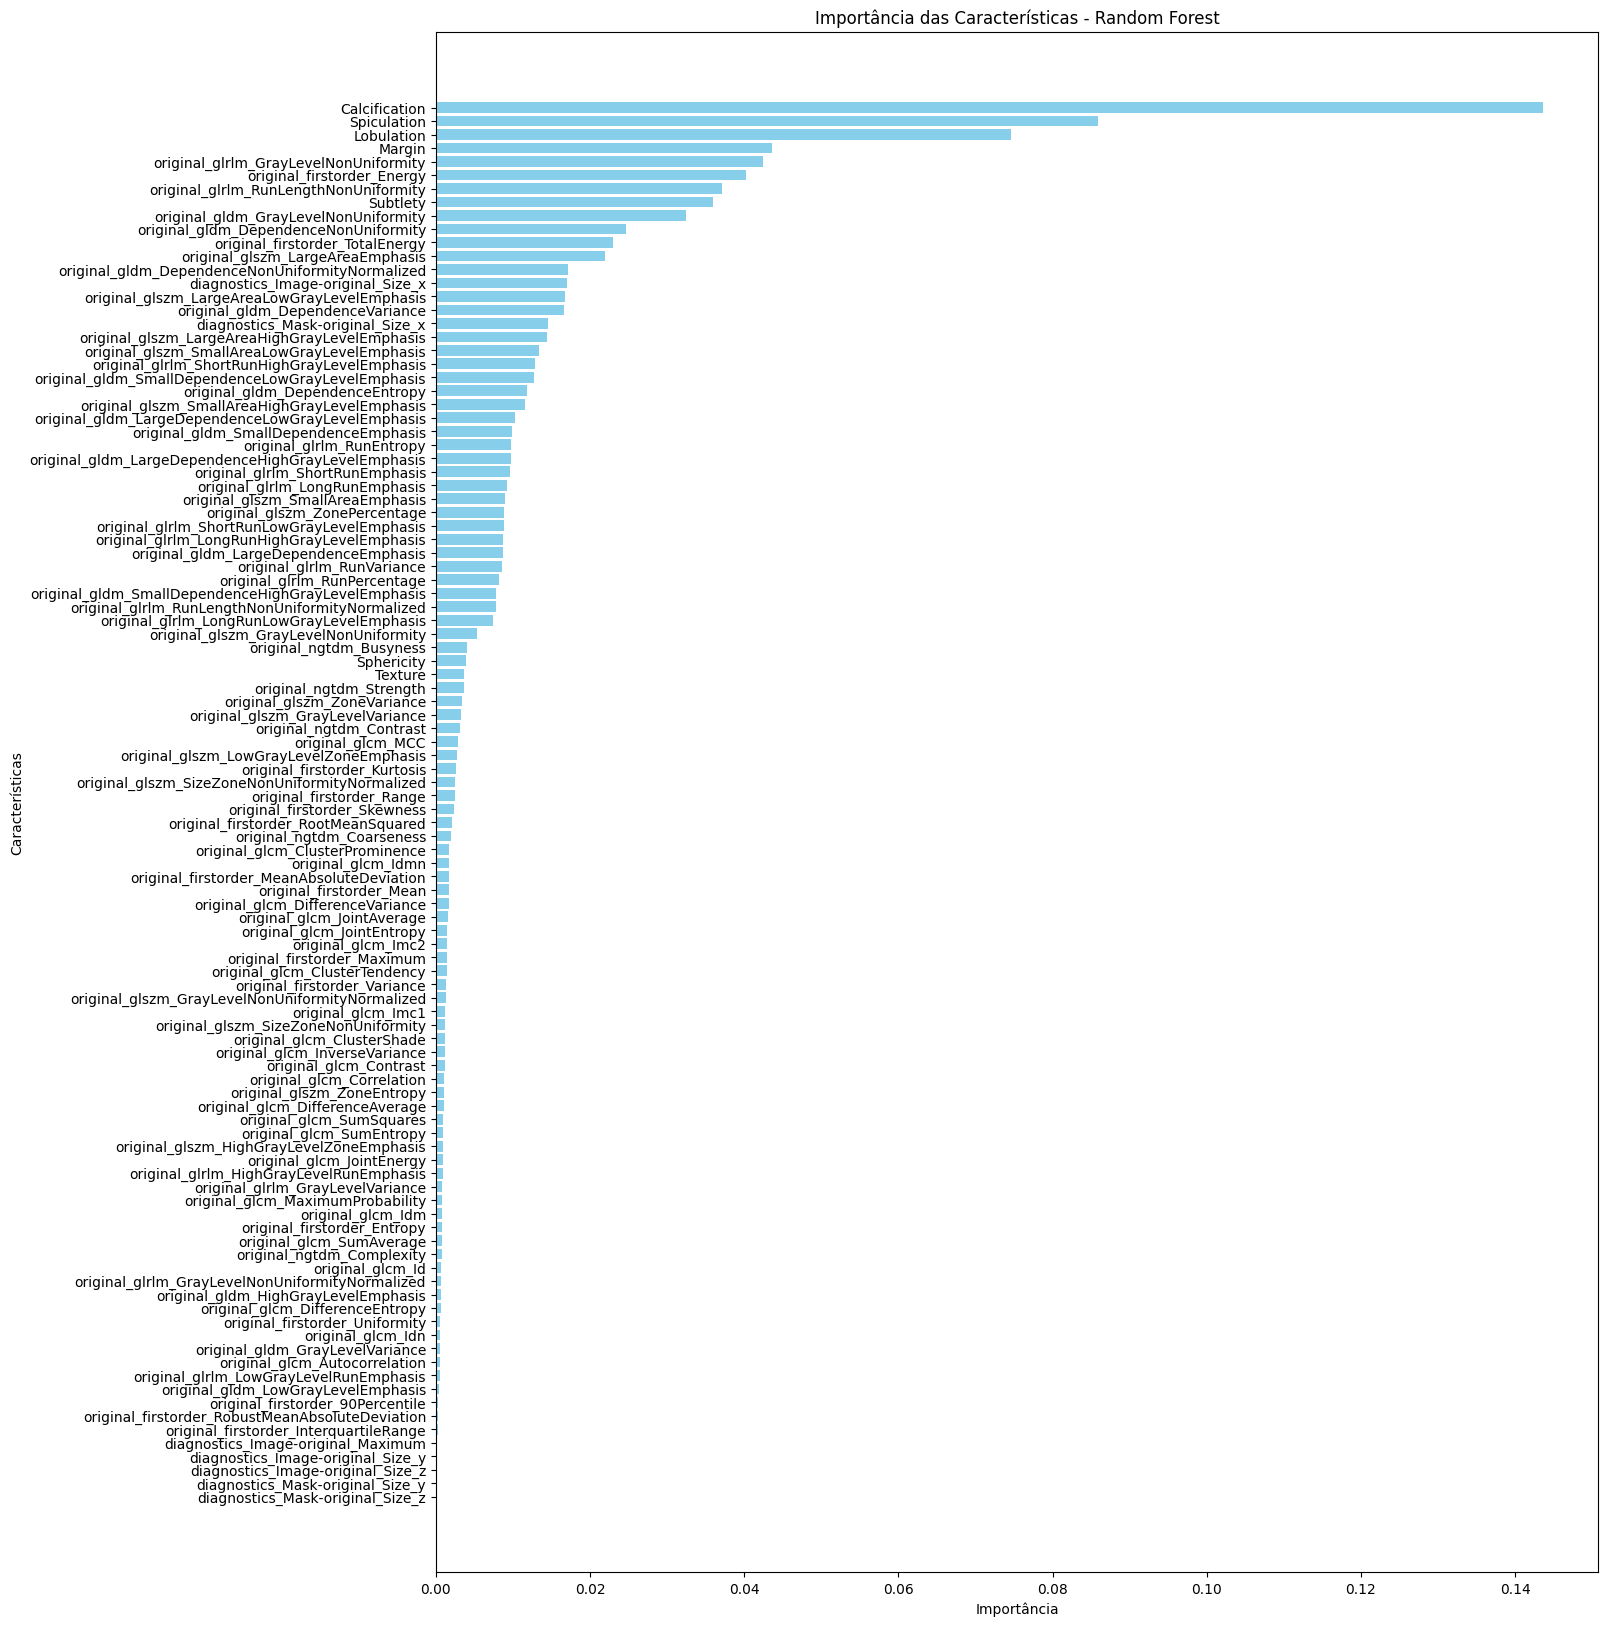

In [25]:
feature_importances_3d = rf_features_3d.feature_importances_
importances_df_3d = pd.DataFrame({"Feature": X_3d.columns, "Importance": feature_importances_3d})
importances_df_3d = importances_df_3d.sort_values(by="Importance", ascending=False)
print("Feature Importances 3D:")
print(importances_df_3d)

plt.figure(figsize=(15, 20))
plt.barh(importances_df_3d["Feature"], importances_df_3d["Importance"], color="skyblue")
plt.xlabel("Importância")
plt.ylabel("Características")
plt.title("Importância das Características - Random Forest")
plt.gca().invert_yaxis()  # Inverte o eixo para mostrar as características mais importantes no topo
plt.show()

Temos apenas o valor de importância de cada feature. Para encontrarmos o número de features relevantes decidimos apoiar a decisão num método utilizado em machine learning, método **Elbow**, que encontra o threshold ideal para a seleção de features com base na sua importância, usualmente 95%. Para aplicar o método, calculamos a importância cumulativa de cada feature e selecionamos as que se encontram abaixo do valor de corte.

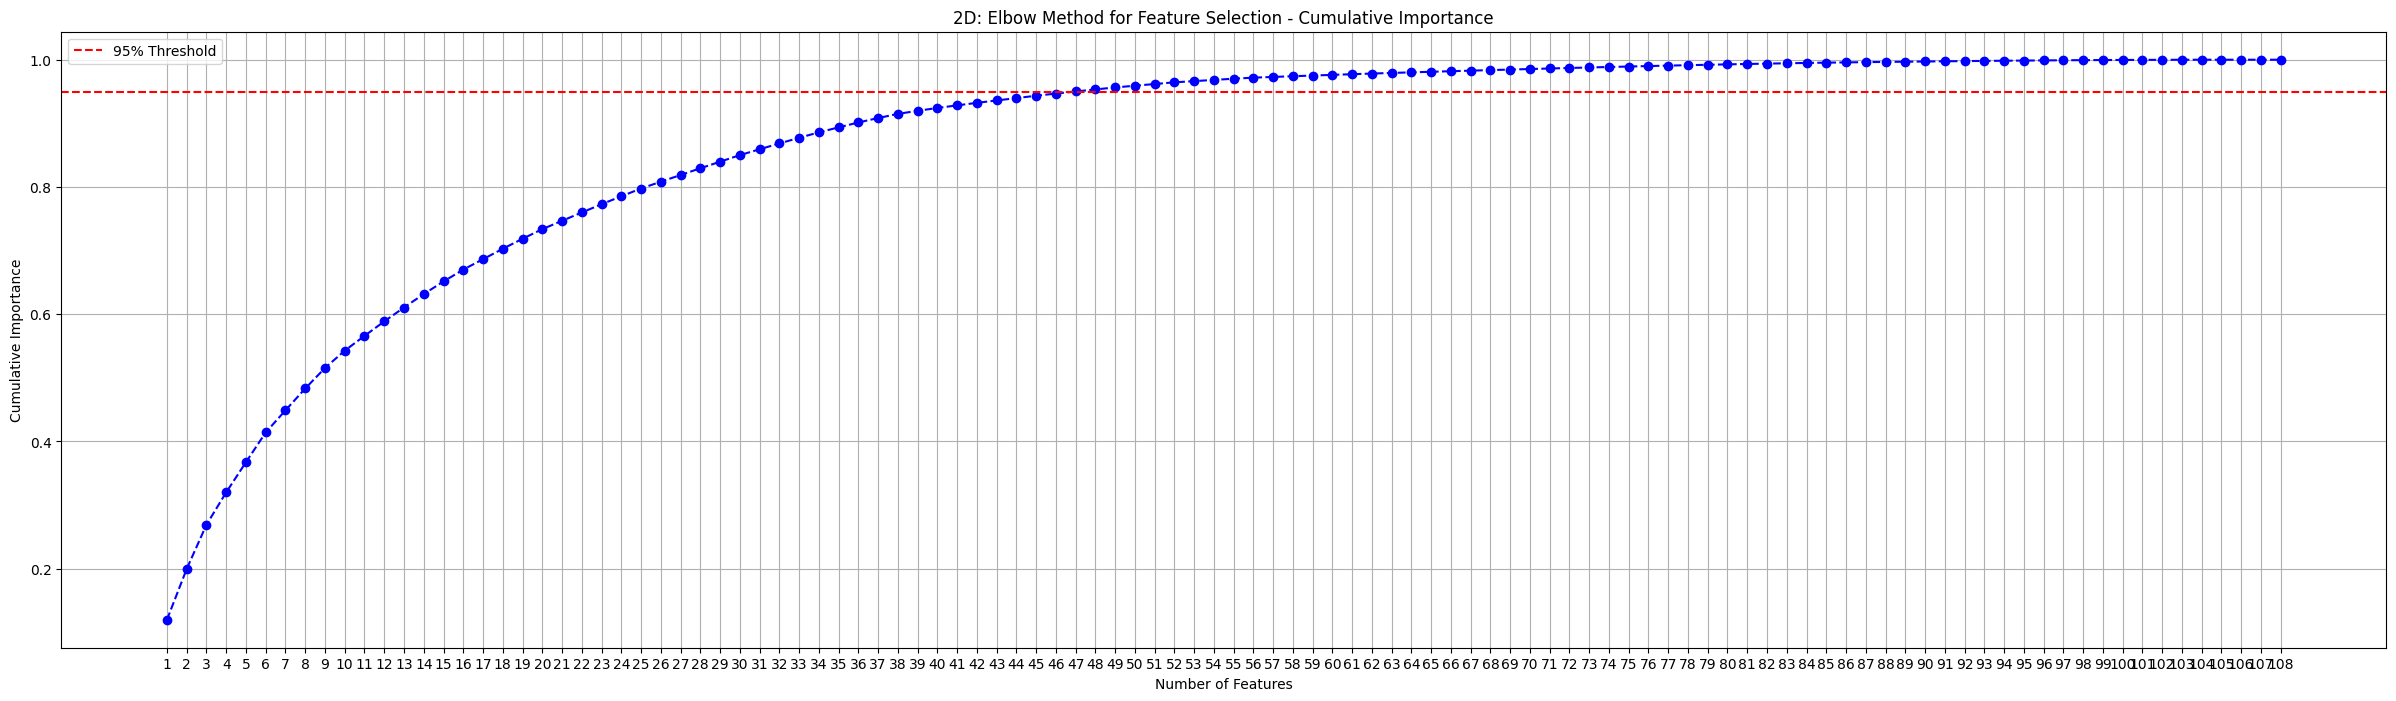

In [26]:
indices_2d = np.argsort(feature_importances_2d)[::-1]
cumulative_importance_2d = np.cumsum(feature_importances_2d[indices_2d])

num_features_2d = len(feature_importances_2d)
x = range(1, num_features_2d + 1)

plt.figure(figsize=(30, 8))
plt.plot(x, cumulative_importance_2d, marker='o', linestyle='--', color='blue')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')  # Optional: threshold line
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("2D: Elbow Method for Feature Selection - Cumulative Importance")
plt.xticks(x)
plt.grid()
plt.legend()
plt.show()

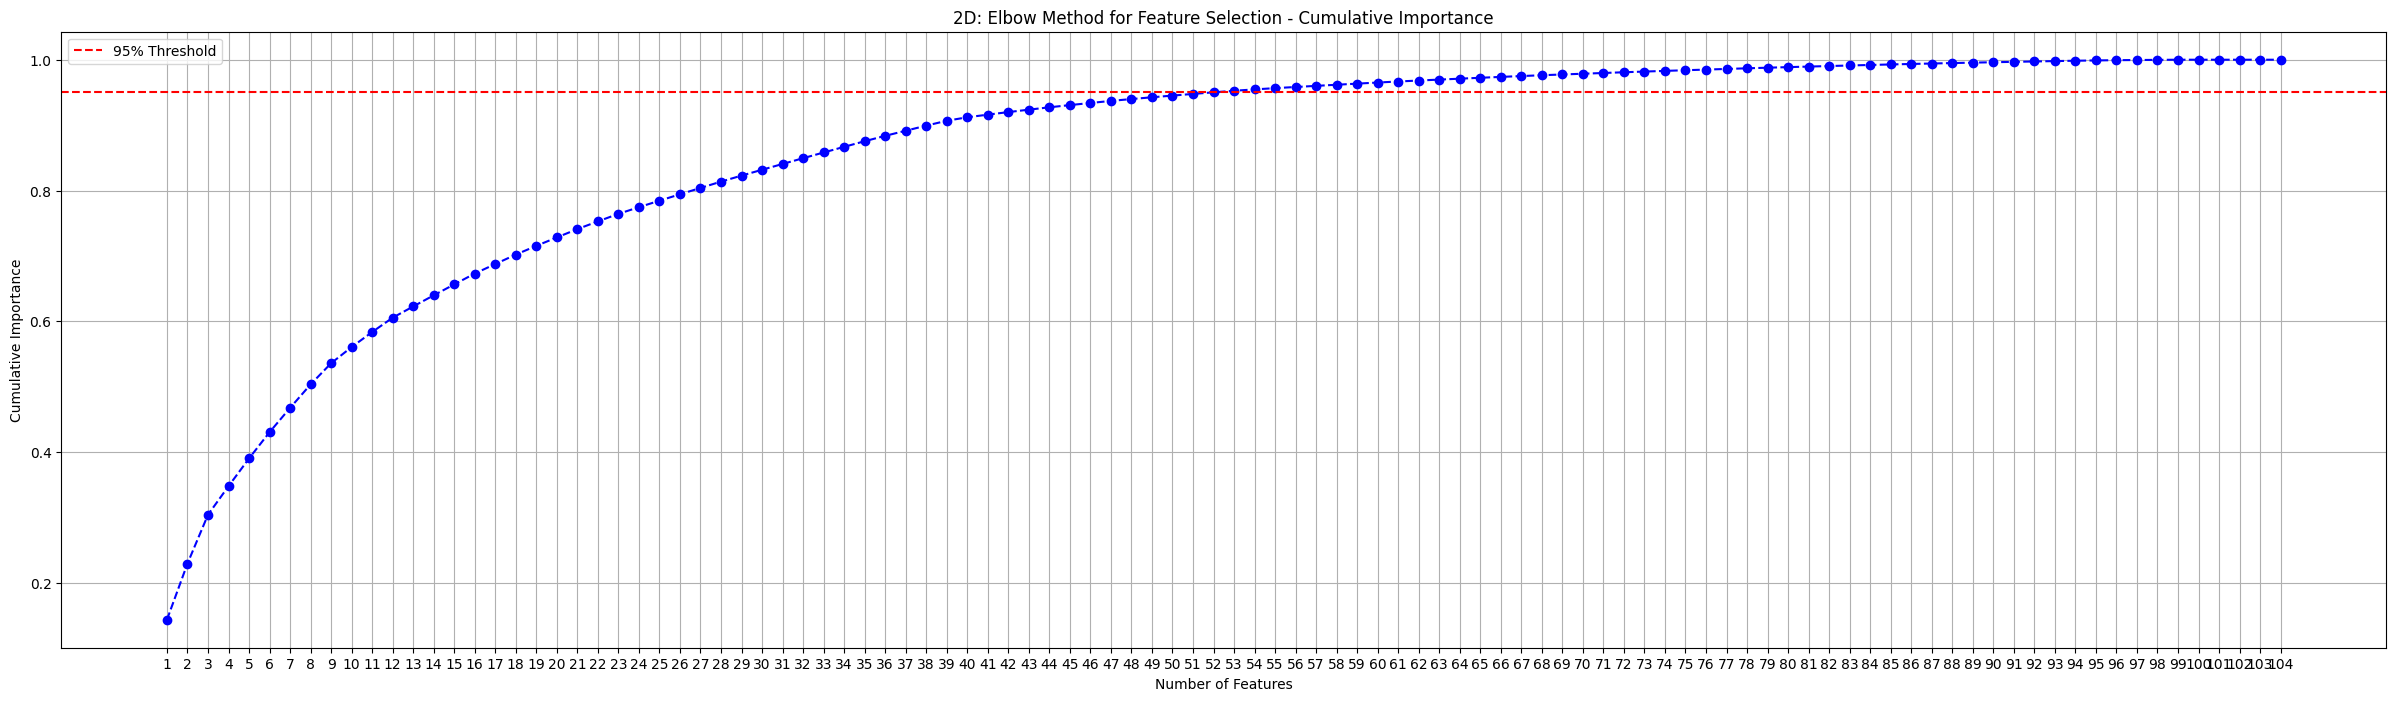

In [27]:
indices_3d = np.argsort(feature_importances_3d)[::-1]
cumulative_importance_3d = np.cumsum(feature_importances_3d[indices_3d])

num_features_3d = len(feature_importances_3d)
x = range(1, num_features_3d + 1)

plt.figure(figsize=(30, 8))
plt.plot(x, cumulative_importance_3d, marker='o', linestyle='--', color='blue')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')  # Optional: threshold line
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("2D: Elbow Method for Feature Selection - Cumulative Importance")
plt.xticks(x)
plt.grid()
plt.legend()
plt.show()

Por fim, selecionamos as features relevantes, com base no threshold=0.95

In [28]:
threshold = 0.95

selected_indices_2d = np.where(cumulative_importance_2d >= threshold)[0]
if selected_indices_2d.size > 0:
    selected_features_indices_2d = selected_indices_2d[0]
    selected_features_2d = importances_df_2d['Feature'].head(selected_features_indices_2d + 1).tolist()
else:
    selected_features_2d = []
print("Número de features selecionadas 2D:", len(selected_features_2d))

print("\n ------------------------ \n")

selected_indices_3d = np.where(cumulative_importance_3d >= threshold)[0]
if selected_indices_3d.size > 0:
    selected_features_indices_3d = selected_indices_3d[0]
    selected_features_3d = importances_df_3d['Feature'].head(selected_features_indices_3d + 1).tolist()
else:
    selected_features_3d = []
print("Número de features selecionadas 3D:", len(selected_features_3d))

Número de features selecionadas 2D: 47

 ------------------------ 

Número de features selecionadas 3D: 52


Como podemos ver o RandomForest selecionou as features que considera relevantes.

In [29]:
print("Features selecionadas 2D:")
data_rf_2d = data_2d[selected_features_2d]
pd.concat([data_rf_2d, y_2d], axis=1)

Features selecionadas 2D:


Calcification  Lobulation  Spiculation  \
0                6           3            5   
1                6           2            2   
2                3           1            1   
3                6           1            5   
4                3           1            1   
..             ...         ...          ...   
405              6           1            1   
406              6           2            2   
407              6           3            1   
408              6           1            1   
409              6           1            1   

     original_gldm_GrayLevelNonUniformity  original_shape2D_MajorAxisLength  \
0                              160.036585                         57.542760   
1                               33.000000                         17.090541   
2                               12.142857                          9.244896   
3                               43.079208                         40.718270   
4                               18.000000                         10.327956   
..                                    ...                               ...   
405                             24.000000                         13.852837   
406                            157.000000                         61.575217   
407                            101.000000                         51.164214   
408                             79.000000                         41.452617   
409                             21.000000                         12.494295   

     original_glrlm_GrayLevelNonUniformity  Margin  \
0                               113.551582       4   
1                                24.750000       3   
2                                 9.184343       5   
3                                31.512433       3   
4                                13.500000       5   
..                                     ...     ...   
405                              18.000000       4   
406                             116.000000       4   
407                              73.000000       4   
408                              58.000000       3   
409                              15.500000       2   

     original_firstorder_Energy  original_shape2D_Perimeter  Subtlety  ...  \
0                   163807321.0                  356.877200         5  ...   
1                    33000000.0                   76.769553         5  ...   
2                    13646416.0                   36.284271         2  ...   
3                    90440738.0                  224.994949         5  ...   
4                    18000000.0                   44.284271         3  ...   
..                          ...                         ...       ...  ...   
405                  24000000.0                   59.597980         3  ...   
406                 157000000.0                  357.948268         5  ...   
407                 101000000.0                  229.521861         5  ...   
408                  79000000.0                  181.580736         5  ...   
409                  21000000.0                   50.526912         4  ...   

     original_gldm_LargeDependenceLowGrayLevelEmphasis  Texture  \
0                                            11.258299        5   
1                                             9.000000        4   
2                                             7.643973        5   
3                                             5.172723        5   
4                                             9.000000        5   
..                                                 ...      ...   
405                                           9.000000        5   
406                                           9.636943        5   
407                                          10.524752        5   
408                                           9.886076        5   
409                                           9.666667        5   

     original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                        

In [30]:
print("Features selecionadas 3D:")
data_rf_3d = data_3d[selected_features_3d]
data_rf_3d = pd.concat([data_rf_3d, y_3d], axis=1)
data_rf_3d

Features selecionadas 3D:


Calcification  Spiculation  Lobulation  Margin  \
0                6            5           3       4   
1                6            2           2       3   
2                3            1           1       5   
3                6            5           1       3   
4                3            1           1       5   
..             ...          ...         ...     ...   
405              6            1           1       4   
406              6            2           2       4   
407              6            1           3       4   
408              6            1           1       3   
409              6            1           1       2   

     original_glrlm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                               757.880362                9.385304e+08   
1                                88.384615                1.060000e+08   
2                                34.515260                5.373786e+07   
3                               437.070150                8.652093e+08   
4                                33.846154                4.100000e+07   
..                                     ...                         ...   
405                              41.769231                5.000000e+07   
406                            1239.769231                1.482982e+09   
407                             573.307692                7.040000e+08   
408                             444.769231                5.560000e+08   
409                              47.846154                5.400000e+07   

     original_glrlm_RunLengthNonUniformity  Subtlety  \
0                               560.437962         5   
1                                65.418418         5   
2                                34.624099         2   
3                               674.745089         5   
4                                25.277877         3   
..                                     ...       ...   
405                              30.870197         3   
406                             950.216242         5   
407                             411.691071         5   
408                             314.515156         5   
409                              40.702319         4   

     original_gldm_GrayLevelNonUniformity  \
0                              931.027689   
1                              106.000000   
2                               44.017544   
3                              534.484914   
4                               41.000000   
..                                    ...   
405                             50.000000   
406                           1483.000000   
407                            704.000000   
408                            556.000000   
409                             54.000000   

     original_gldm_DependenceNonUniformity  ...  original_ngtdm_Strength  \
0                               155.261981  ...                 0.950551   
1                                26.660377  ...                 0.000000   
2                                 8.929825  ...                13.837206   
3                               134.415948  ...                 4.995332   
4                                13.682927  ...                 0.000000   
..                                     ...  ...                      ...   
405                              19.320000  ...                 0.000000   
406                             324.684423  ...                 0.000000   
407                             112.750000  ...                 0.000000   
408                              90.420863  ...                 0.000000   
409                              19.148148  ...                 0.000000   

     original_glszm_ZoneVariance  original_glszm_GrayLevelVariance  \
0                  139576.960000                          0.640000   
1                       0.000000                          0.000000   
2                     292.122449                         45.346939   
3                    1441.356256                

## Training Models <a name = "tm"></a>
[[voltar ao índice]](#indice)

Após preparar os datasets com a seleção das features relevantes podemos iniciar o treino dos modelos para classificação dos nódulos. Para isso decidimos utilizar diversos modelos e compará-los, sendo justificada a utilização de cada um na sua respetiva parte. Além disso realizamos testes para os diferentes modos de [Features Importance and Selection](#fias) utilizados.

- [Support Vector Machine](#svm)
    - [Support Vector Machine sem seleção de features](#svm_sem_seleção)
    - [Support Vector Machine + PCA](#svm_pca)
    - [Support Vector Machine + t-test](#svm_t_test)
    - [Support Vector Machine + Random Forest (seleção de features)](#svm_rf)
    - [Resultados Support Vector Machine](#svm_resultados)
- [Random Forest](#rf)
    - [Random Forest sem seleção de features](#rf_sem_selecao)
    - [Random Forest + PCA](#rf_pca)
    - [Random Forest + t-test](#rf_t_test)
    - [Random Forest + Random Forest (seleção de Features)](#rf_rf)
    - [Resultados Random Forest](#rf_resultados)
- [XGBoost](#xgboost)
    - [XGBoost sem seleção de features](#xgboost_sem_selecao)
    - [XGBoost + PCA](#xgboost_pca)
    - [XGBoost + t-test](#xgboost_t_test)
    - [XGBoost + Random Forest (seleção de features)](#xgboost_rf)
    - [Resultados XGBoost](#xgboost_resultados)


Critérios de Avaliação usados: 

 -> Accuracy: Mede a proporção de previsões corretas em relação ao total de previsões. Bom para problemas de classificação binária. 

 -> Log Loss: Avalia a probabilidade predita pelo modelo para a classe correta. No caso da classificação de nódulos, é essencial saber se o modelo está "muito confiante" ao classificar um nódulo como benigno ou maligno. Métrica valiosa para decisões médicas, onde a decisão pode custar vidas humanas. 

 -> Dice Coefficient: Métrica usada para avaliar a sobreposição de duas amostras, especialmente em problemas de segmentação de imagem. Importante para capturar bem os nódulos malignos, sem ignorar os benignos. 

 Estes critérios são usados no estudo [[DCLC]](#DCLC)

**K-Fold Cross Validation - Divisão do dataset**

K-fold Cross Validation é uma técnica de divisão de dados que consiste em realizar a divisão de treino/teste k vezes. OS resultados finais são posteriormente obtidos através das médias dos resultados de cada iteração. Este método é utilizado para garantir que o modelo não está a ser treinado com um dataset específico, mas sim com o dataset completo. [[CBMLN]](#CBMLN)

Vamos usar o método k_fold para dividir os dados de teste e treino e usar os mesmos folds para os diferentes modelos: 

In [31]:
def k_fold_cross_validation(data, labels, k=5, random_state=42):
    fold = []
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(data):
        # Converte os subconjuntos de treino e teste em listas
        X_train, X_test = data.iloc[train_index].values.tolist(), data.iloc[test_index].values.tolist()
        y_train, y_test = labels.iloc[train_index].values.tolist(), labels.iloc[test_index].values.tolist()
        fold.append([X_train, X_test, y_train, y_test])
    
    return fold


In [32]:
fold_2d = k_fold_cross_validation(data_2d, y_2d)
fold_2d_pca = k_fold_cross_validation(data_pca_2d, y_2d)
fold_2d_rf = k_fold_cross_validation(data_rf_2d,y_2d)
fold_2d_ttest = k_fold_cross_validation(data_ttest_2d,y_2d)

fold_3d = k_fold_cross_validation(data_3d, y_3d)
fold_3d_pca = k_fold_cross_validation(data_pca_3d, y_3d)
fold_3d_rf = k_fold_cross_validation(data_rf_3d,y_3d)
fold_3d_ttest = k_fold_cross_validation(data_ttest_3d,y_3d)

Antes de iniciarmos o treino dos modelos iremos apenas colocar aqui todas as funções que serão utilizadas para a vizualização dos resultados:

[[skip code]](#skip_code)

In [33]:
# confusion matrix
def heatmap(test,pred, model):
    cm = confusion_matrix(test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Benign", "Malign"], yticklabels=["Benign", "Malign"])
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.figure(figsize=(5, 5))
    plt.show()
    return cm

In [34]:
# Métricas
def metrics_testing(test,pred, model):
    cm = heatmap(test,pred, model)
    dice_coef = 2 * (cm[1][1]) / (2 * (cm[1][1]) + cm[1][0] + cm[0][1])
    accuracy = accuracy_score(test, pred)
    report = classification_report(test, pred, zero_division=1)
    
    logloss = log_loss(test, pred)
    # print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    # print("Log Loss:", logloss)
    # print("Dice Coefficient:", dice_coef)
    return accuracy, logloss, dice_coef

In [35]:
# Gráficos das métricas - retorna uma lista com as médias das métricas
def plot_metrics(accuracies, log_losses, dice_coefs):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))  # Create three subplots

    k = len(accuracies)  # Number of folds

    # Create an array of fold numbers (1, 2, ..., k)
    folds = np.arange(1, k + 1)

    # Plot accuracies
    ax1.bar(folds, accuracies, color='blue', alpha=0.7)
    ax1.set_xticks(folds)  # Set x-ticks to be fold numbers
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy average score: {:.2f}'.format(np.mean(accuracies)))

    # Plot log losses
    ax2.bar(folds, log_losses, color='green', alpha=0.7)
    ax2.set_xticks(folds)  # Set x-ticks to be fold numbers
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Log Loss')
    ax2.set_title('Log Loss average score: {:.2f}'.format(np.mean(log_losses)))

    # Plot Dice coefficients
    ax3.bar(folds, dice_coefs, color='purple', alpha=0.7)
    ax3.set_xticks(folds)  # Set x-ticks to be fold numbers
    ax3.set_xlabel('Fold')
    ax3.set_ylabel('Dice Coefficient')
    ax3.set_title('Dice Coefficient average score: {:.2f}'.format(np.mean(dice_coefs)))

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

    metrics_average = [np.mean(accuracies), np.mean(log_losses), np.mean(dice_coefs)]
    return metrics_average

In [36]:
# Comparação e Visualização de resultados 
def plot_scores(average_metrics, model_name):
    average_acc, average_logloss, average_dice = zip(*average_metrics)

    x = np.arange(len(average_metrics))
    width = 0.20

    # Set the style for the plot
    plt.style.use('seaborn-darkgrid')

    fig, ax = plt.subplots(figsize=(8, 6))  # Increased figure size
    bars1 = ax.bar(x - width, average_acc, width, label='Accuracy', color='lightskyblue')
    bars2 = ax.bar(x, average_logloss, width, label='Log Loss', color='yellowgreen')
    bars3 = ax.bar(x + width, average_dice, width, label='Dice Coefficient', color='plum')

    ax.set_ylabel('Scores', fontsize=10)
    ax.set_title(f'Scores for {model_name}', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Without Selection', 'Approach PCA', 'Approach T-test', 'Approach RF'], fontsize=8)
    ax.legend(fontsize=8)

    # Add gridlines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Add data labels on bars
    for bar in bars1 + bars2 + bars3:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2),
                ha='center', va='bottom', fontsize=8, color='black')

    # Set limits for better spacing
    ax.set_ylim(0, max(average_acc + average_logloss + average_dice) * 1.1)

    # Adjust layout
    plt.tight_layout()
    plt.show()

[[end skip code]]<a name = "skip_code"></a>

### **Support Vector Machine** <a name = "svm"></a>
[[Voltar a Training Models]](#tm)

O algoritmo Support Vector Machine é frequentemente utilizado na fase de classificação de dados linearmente separáveis. Contudo, é possível adaptar o algoritmo a fim de transformar dados não linearmente separáveis (o nosso caso) em linearmente separáveis. Isto é conseguido através da função de kernel utilizada e escolhida. Com base no estudo [LLZ18](#LLZ18), concluímos que obteremos uma melhor performance quando escolhemos como função de kernel a função de Radial Basis (RBF). 

Estudos que usam SVM na classificação dos nódulos:
- Classification of Benign and Malignant Lung Nodules Based on Deep Convolutional Network Feature Extraction, 
Enhui Lv,1 Wenfeng Liu,2 Pengbo Wen ,1 and Xingxing Kang1

- [LLZ18](#LLZ18)
- [TOR23](#Tor23)

**Algoritmo de Particle Swarm Optimization**

Para melhorar a sua performance de classificação do Support Vector Classifier, iremos usar o algoritmo de otimização Particle Swarm Optimization.

O algoritmo de Particle Swarm Optimization é um algoritmo de otimização heurística que se baseia na simulação de um grupo de "partículas" e permite uma mais eficaz procura de solução global para o problema em causa, em detrimento de uma solução local.

Quando associado ao Support Vector Classifier, este algoritmo pode, então, ser utilizado para otimizar hiperparâmetros usados pelo modelo, nomeadamente os parâmetros C (o parâmetro de regularização) e gamma (parâmetro que define a influência de um único ponto de dados). Ao encontrar combinações ideais destes parâmetros, o algoritmo PSO melhora o desempenho da Support Vector Machine, obtendo maior precisão na classificação.


refs.
- [LLZ18](#LLZ18)
- https://ieeexplore.ieee.org/document/8940822

Código que iremos usar para treinar os modelos: 

In [37]:
def svm_k_fold(fold, k=5, random_state=42):

    accuracies = []
    log_losses = []
    dice_coefs = []

    # Definir os limites dos parâmetros C e gamma
    lower_bounds = [0.1, 0.001] 
    upper_bounds = [100, 1]     

    # Função objetivo para otimização
    def objective_function(params):
        C, gamma = params
        fold_accuracies = []
        
            
        for X_train, X_test, y_train, y_test in fold:
            model = SVC(C=C, gamma=gamma, kernel='rbf', random_state=random_state)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_accuracies.append(accuracy_score(y_test, y_pred))

        return -np.mean(fold_accuracies) 

    # Algoritmo PSO para otimização
    best_params, _ = pso(objective_function, lower_bounds, upper_bounds)
    best_C, best_gamma = best_params
    print(f"Melhores parâmetros a partir do PSO: C={best_C}, gamma={best_gamma}")

    # K-fold cross-validation com os melhores parâmetros
    n_fold = 1
    
    for (X_train, X_test, y_train, y_test) in fold:
        print(f"Numero do Fold: {n_fold}")
        model = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=random_state)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        acc, logloss, dice = metrics_testing(y_test, predictions, "SVM")

        accuracies.append(acc)
        log_losses.append(logloss)
        dice_coefs.append(dice)
        
        n_fold += 1 
        
    return accuracies, log_losses, dice_coefs

Lista que vai guardar os resultados dos diferentes testes:

In [38]:
results_svm_2d = []
results_svm_3d = []

th_svm_2d = []
th_svm_3d = []


**Support Vector Machine sem seleção de features** <a name = "svm_sem_seleção"></a>

[[Voltar a Support Vector Machine]](#svm)

**-> 2D**

In [39]:
data_2d

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0              5           3           3       4         5        5   
1              2           2           4       3         5        4   
2              1           1           2       5         2        5   
3              5           1           4       3         5        5   
4              1           1           5       5         3        5   
..           ...         ...         ...     ...       ...      ...   
405            1           1           3       4         3        5   
406            2           2           4       4         5        5   
407            1           3           3       4         5        5   
408            1           1           3       3         5        5   
409            1           1           4       2         4        5   

     Calcification  Malignancy  diagnostics_Image-original_Maximum  \
0                6           1                               400.0   
1                6           1                               400.0   
2                3           0                               185.0   
3                6           1                               400.0   
4                3           0                               400.0   
..             ...         ...                                 ...   
405              6           0                               400.0   
406              6           1                               400.0   
407              6           1                               241.0   
408              6           1                               238.0   
409              6           0                               245.0   

     original_shape2D_Elongation  ...  \
0                       0.780478  ...   
1                       0.784334  ...   
2                       0.628837  ...   
3                       0.759355  ...   
4                       0.866025  ...   
..                           ...  ...   
405                     0.748025  ...   
406                     0.648281  ...   
407                     0.561402  ...   
408                     0.798296  ...   
409                     0.650249  ...   

     original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                            11.258299   
1                                             9.000000   
2                                             7.643973   
3                                             5.172723   
4                                             9.000000   
..                                                 ...   
405                                           9.000000   
406                                           9.636943   
407                                          10.524752   
408                                           9.886076   
409                                           9.666667   

     original_gldm_LowGrayLevelEmphasis  \
0                              0.990007   
1                              1.000000   
2                              0.929688   
3                              0.665108   
4                              1.000000   
..                                  ...   
405                            1.000000   
406                            1.000000   
407                            1.000000   
408                            1.000000   
409                            1.000000   

     original_gldm_SmallDependenceEmphasis  \
0                                 0.111187   
1                                 0.111111   
2                                 0.194444   
3                                 0.406474   
4                                 0.111111   
..                                     ...   
405                               0.111111   
406                               0.106943   
407                               0.100523   
408                               0.104958   
409                               0.106481   

     original_gldm_SmallDependenceHighGrayLevelEmph

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=59.09690523786994, gamma=0.001
Numero do Fold: 1


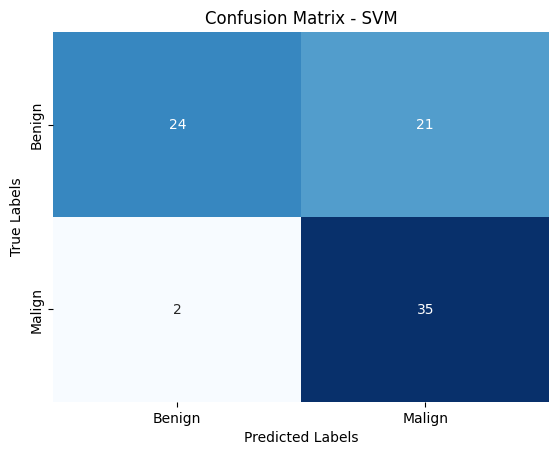

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.53      0.68        45
           1       0.62      0.95      0.75        37

    accuracy                           0.72        82
   macro avg       0.77      0.74      0.71        82
weighted avg       0.79      0.72      0.71        82

Numero do Fold: 2


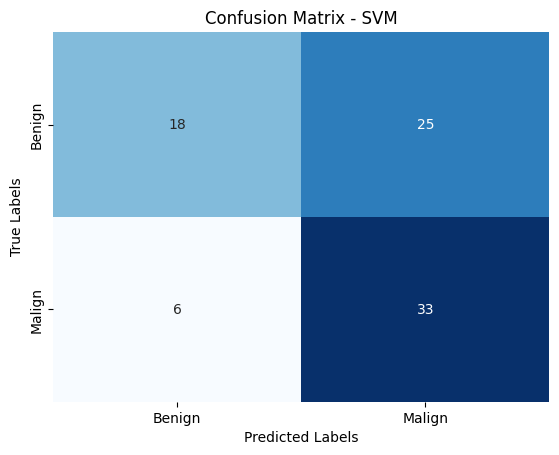

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.42      0.54        43
           1       0.57      0.85      0.68        39

    accuracy                           0.62        82
   macro avg       0.66      0.63      0.61        82
weighted avg       0.66      0.62      0.61        82

Numero do Fold: 3


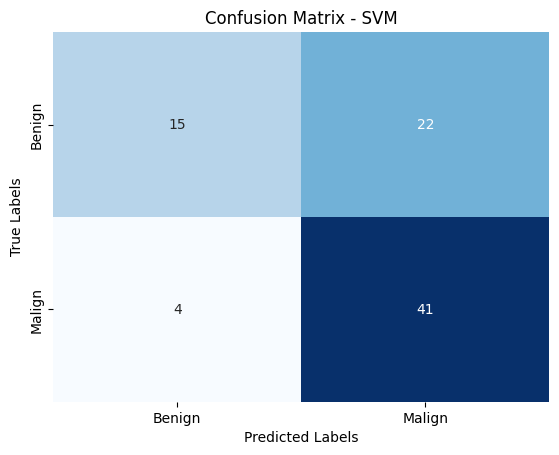

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.41      0.54        37
           1       0.65      0.91      0.76        45

    accuracy                           0.68        82
   macro avg       0.72      0.66      0.65        82
weighted avg       0.71      0.68      0.66        82

Numero do Fold: 4


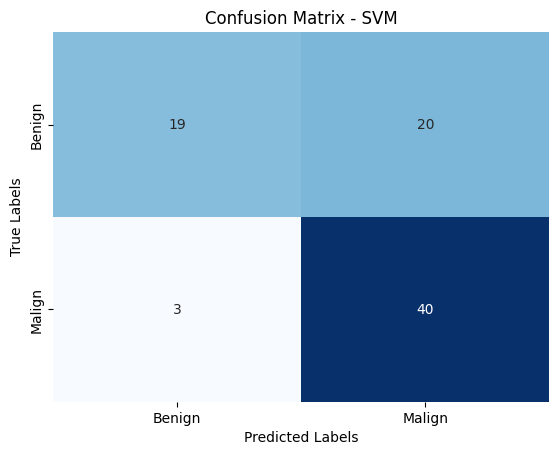

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.49      0.62        39
           1       0.67      0.93      0.78        43

    accuracy                           0.72        82
   macro avg       0.77      0.71      0.70        82
weighted avg       0.76      0.72      0.70        82

Numero do Fold: 5


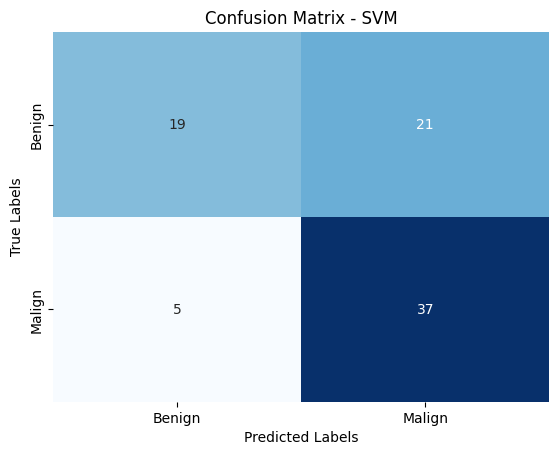

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.47      0.59        40
           1       0.64      0.88      0.74        42

    accuracy                           0.68        82
   macro avg       0.71      0.68      0.67        82
weighted avg       0.71      0.68      0.67        82



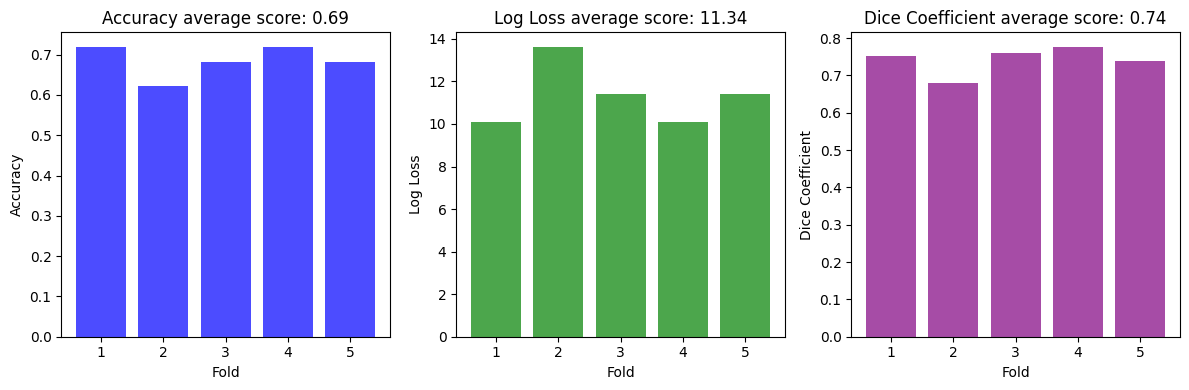

[0.6853658536585366, 11.34056411511247, 0.7418117663125008]


In [40]:
accuracies_2d, log_losses_2d, dice_coefs_2d = svm_k_fold(fold_2d)
th_svm_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

**-> 3D**

In [41]:
data_3d

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0              5           3           3       4         5        5   
1              2           2           4       3         5        4   
2              1           1           2       5         2        5   
3              5           1           4       3         5        5   
4              1           1           5       5         3        5   
..           ...         ...         ...     ...       ...      ...   
405            1           1           3       4         3        5   
406            2           2           4       4         5        5   
407            1           3           3       4         5        5   
408            1           1           3       3         5        5   
409            1           1           4       2         4        5   

     Calcification  Malignancy  diagnostics_Image-original_Maximum  \
0                6           1                               400.0   
1                6           1                               400.0   
2                3           0                               400.0   
3                6           1                               400.0   
4                3           0                               400.0   
..             ...         ...                                 ...   
405              6           0                               400.0   
406              6           1                               400.0   
407              6           1                               400.0   
408              6           1                               400.0   
409              6           0                               400.0   

     original_firstorder_90Percentile  ...  original_ngtdm_Coarseness  \
0                             -1000.0  ...                   0.284191   
1                             -1000.0  ...             1000000.000000   
2                              -902.4  ...                   0.015397   
3                              -845.5  ...                   0.002780   
4                             -1000.0  ...             1000000.000000   
..                                ...  ...                        ...   
405                           -1000.0  ...             1000000.000000   
406                           -1000.0  ...             1000000.000000   
407                           -1000.0  ...             1000000.000000   
408                           -1000.0  ...             1000000.000000   
409                           -1000.0  ...             1000000.000000   

     original_ngtdm_Complexity  original_ngtdm_Contrast  \
0                     0.032596                 0.000051   
1                     0.000000                 0.000000   
2                   200.108114                 1.744897   
3                   400.910706                 0.059704   
4                     0.000000                 0.000000   
..                         ...                      ...   
405                   0.000000                 0.000000   
406                   0.000000                 0.000000   
407                   0.000000                 0.000000   
408                   0.000000                 0.000000   
409                   0.000000                 0.000000   

     original_ngtdm_Strength  diagnostics_Image-original_Size_x  \
0                   0.950551                              133.0   
1                   0.000000                              140.0   
2                  13.837206                              241.0   
3                   4.995332                              145.0   
4                   0.000000                              128.0   
..                       ...                                ...   
405                 0.000000                              186.0   
406                 0.000000                              186.0   
407                 0.000000                              133.0   
408                 0.000000                           

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=100.0, gamma=0.001
Numero do Fold: 1


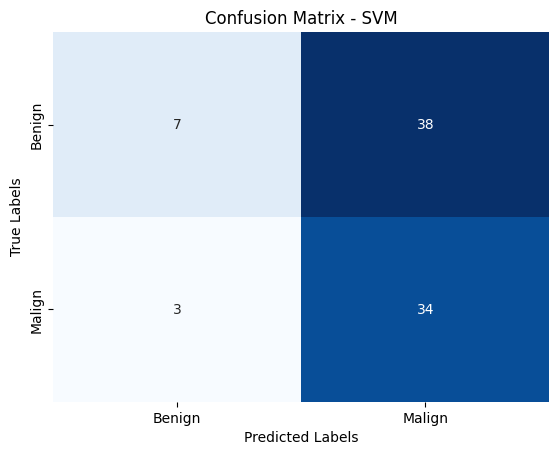

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.16      0.25        45
           1       0.47      0.92      0.62        37

    accuracy                           0.50        82
   macro avg       0.59      0.54      0.44        82
weighted avg       0.60      0.50      0.42        82

Numero do Fold: 2


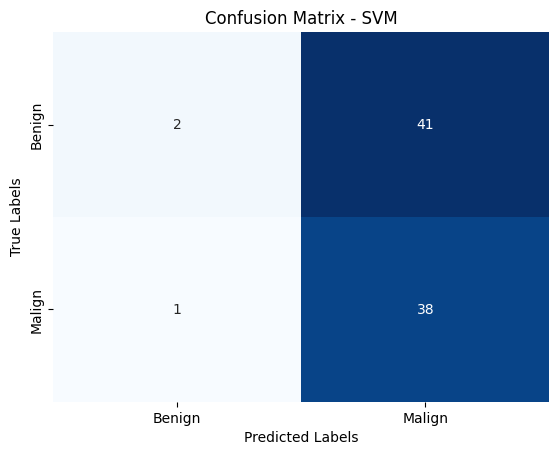

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.05      0.09        43
           1       0.48      0.97      0.64        39

    accuracy                           0.49        82
   macro avg       0.57      0.51      0.37        82
weighted avg       0.58      0.49      0.35        82

Numero do Fold: 3


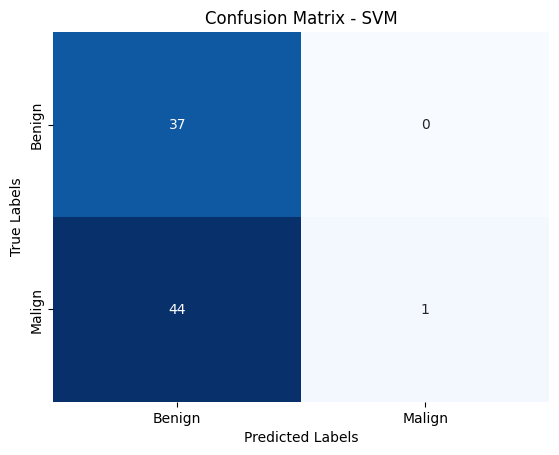

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        37
           1       1.00      0.02      0.04        45

    accuracy                           0.46        82
   macro avg       0.73      0.51      0.34        82
weighted avg       0.75      0.46      0.31        82

Numero do Fold: 4


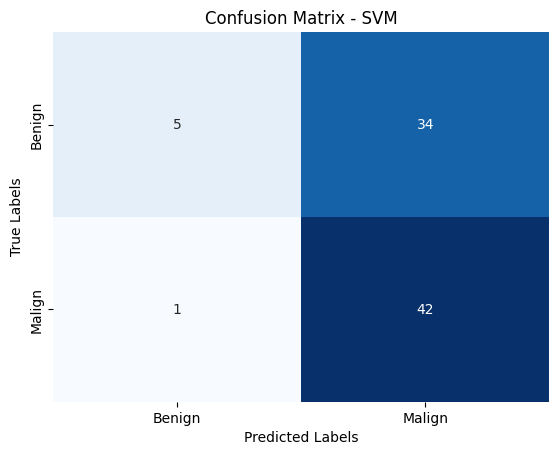

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.13      0.22        39
           1       0.55      0.98      0.71        43

    accuracy                           0.57        82
   macro avg       0.69      0.55      0.46        82
weighted avg       0.69      0.57      0.48        82

Numero do Fold: 5


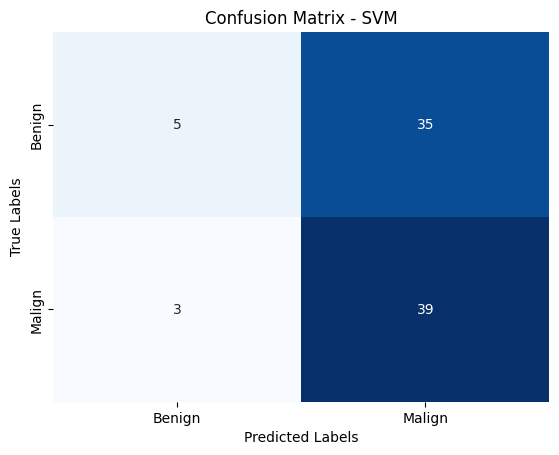

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.12      0.21        40
           1       0.53      0.93      0.67        42

    accuracy                           0.54        82
   macro avg       0.58      0.53      0.44        82
weighted avg       0.57      0.54      0.45        82



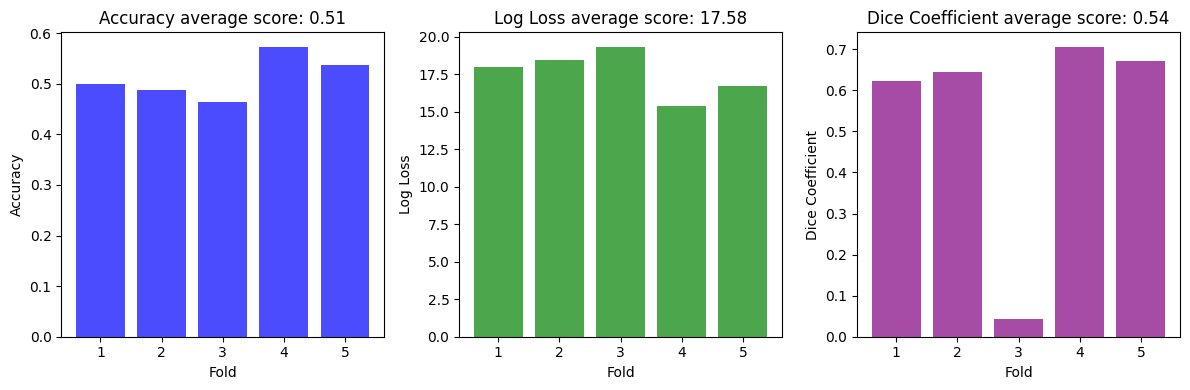

[0.5121951219512195, 17.582269945910802, 0.5379390829067068]


In [42]:
accuracies_3d, log_losses_3d, dice_coefs_3d = svm_k_fold(fold_3d)
th_svm_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

**Support Vector Machine + PCA** <a name = "svm_pca"></a>

[[Voltar a Support Vector Machine]](#svm)

Iremos agora passar à implementação do modelo SVM, utilizando o algoritmo PSO e usando o dataset preparado a partir do método de Principal Component Analysis.

**-> 2D**

In [43]:
data_pca_2d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     0.605527  14.312994  2.618862 -5.010918 -1.873619  0.486000  3.780943   
1    -2.267379  -1.819947  0.040090  0.846899 -1.514118 -0.992908 -0.811545   
2     5.058170  -2.480426 -3.601613 -4.459463 -1.977084 -3.833077  1.266602   
3    26.065083   6.727777 -6.985184  4.449976 -1.804223  1.655932 -2.786482   
4    -2.158470  -3.958437 -0.673922  0.104410  1.383675 -1.097692  0.958196   
..         ...        ...       ...       ...       ...       ...       ...   
405  -2.233398  -2.998710 -0.378282  0.497056 -0.144041 -1.423559 -0.648699   
406  -2.923210  11.711044  5.856770  4.536946  0.801008 -0.007470  1.331167   
407  -2.716925   5.627624  3.129216  2.034017 -1.944248  1.328403  0.538597   
408  -2.511517   3.152825  2.056172  1.597862 -1.588072  0.221263  0.574015   
409  -2.493756  -2.801108 -0.163597 -0.006073  0.120255  1.392496 -1.301845   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0    4.509357 -3.000581  2.485737  0.280072  1.281586 -1.161818  2.506096   
1    0.548039 -0.191325  0.474135  0.777253  0.522630 -0.555025 -0.525174   
2    3.487037  0.174202 -3.689468 -2.493443 -2.397851  2.413588 -1.744844   
3   -3.047505  1.827419  1.127816  1.851693  0.324629 -2.575421  1.917357   
4   -0.653246  0.245743  0.075601 -0.395550  0.432105 -0.498446 -0.096061   
..        ...       ...       ...       ...       ...       ...       ...   
405  0.289676  0.122413  0.325009 -0.998632 -0.439882 -0.165449  0.604338   
406 -1.196007  0.614933 -2.745411 -1.343567 -0.232678  0.409916 -1.701848   
407 -0.491240  0.276382 -0.707462 -0.799203 -1.466120  0.316186 -0.732913   
408 -0.519261  0.386101 -0.228512 -0.288422  0.197071 -0.046711  0.199059   
409  0.218497 -0.266445  0.052311 -0.835398 -0.070959  0.625990 -0.076007   

         PC14      PC15      PC16      PC17  
0   -1.418022 -0.960150  0.979622 -2.705202  
1    0.099056 -0.658362 -0.094486 -0.035771  
2    2.832277  4.918582 -0.709808  0.405147  
3    1.008172  2.188989 -2.696890 -2.489348  
4    0.030861  0.062598 -0.281642 -0.444985  
..        ...       ...       ...       ...  
405 -0.485219  0.312282 -0.701358  0.533368  
406 -1.518696 -0.590536 -0.523272  0.608692  
407  0.573080 -0.718251  0.112633  0.807437  
408  0.393201  0.331136 -0.147753  0.826526  
409  0.689238 -0.565327 -1.269216 -0.252564  

[410 rows x 18 columns]

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=13.992519905646507, gamma=0.004291192414143649
Numero do Fold: 1


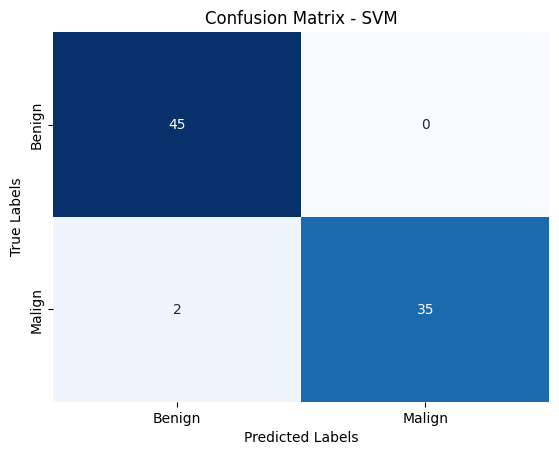

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       1.00      0.95      0.97        37

    accuracy                           0.98        82
   macro avg       0.98      0.97      0.98        82
weighted avg       0.98      0.98      0.98        82

Numero do Fold: 2


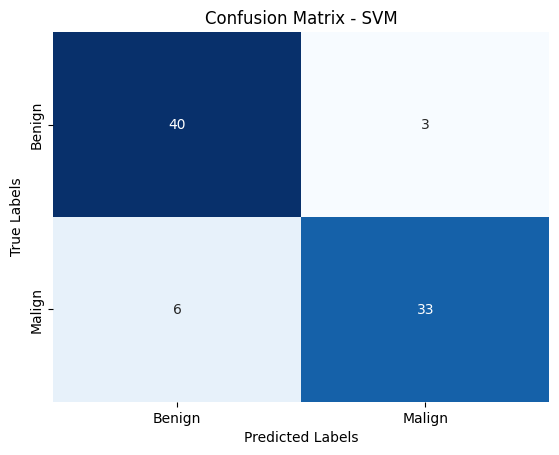

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90        43
           1       0.92      0.85      0.88        39

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82

Numero do Fold: 3


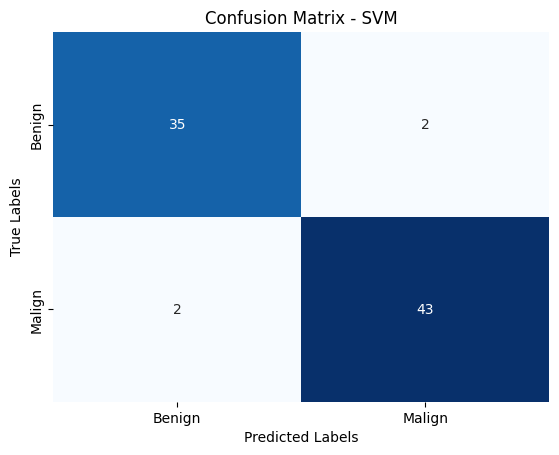

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        37
           1       0.96      0.96      0.96        45

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Numero do Fold: 4


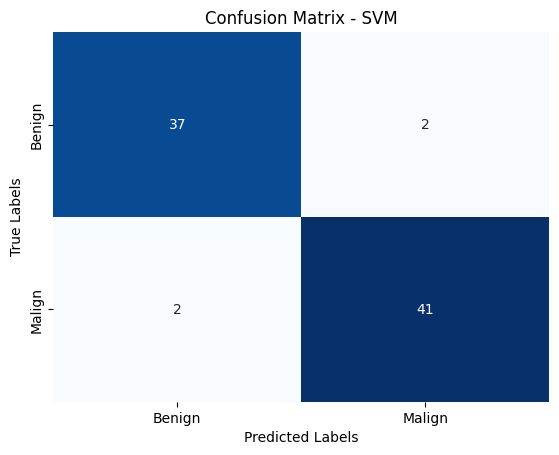

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.95      0.95      0.95        43

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Numero do Fold: 5


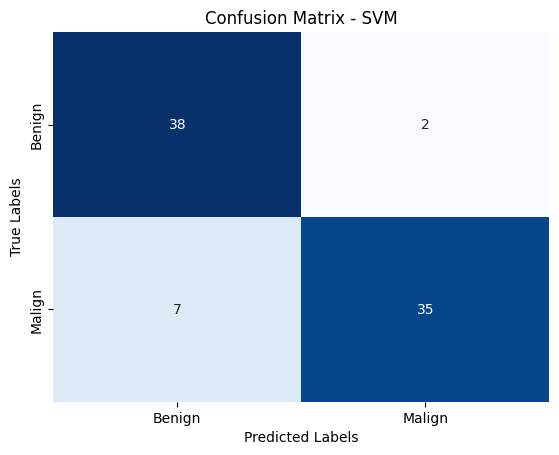

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89        40
           1       0.95      0.83      0.89        42

    accuracy                           0.89        82
   macro avg       0.90      0.89      0.89        82
weighted avg       0.90      0.89      0.89        82



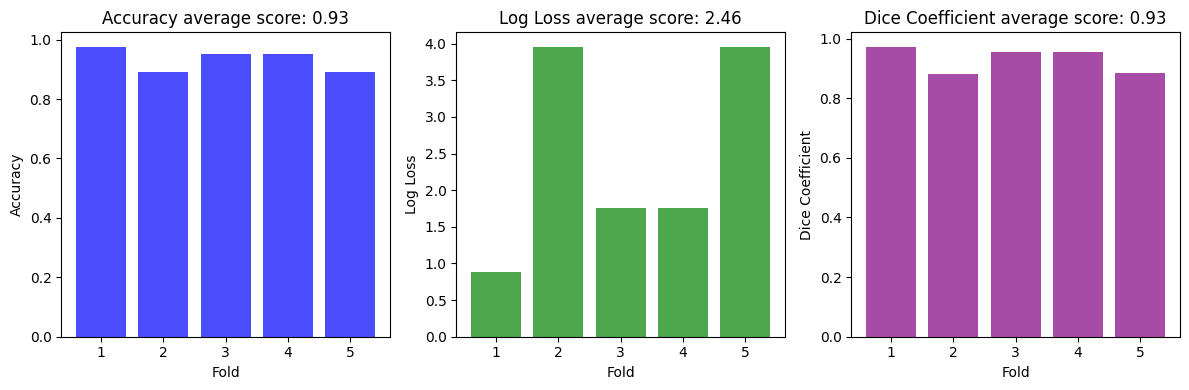

[0.9317073170731707, 2.4615177924275127, 0.929468419847578]


In [44]:
accuracies_2d, log_losses_2d, dice_coefs_2d = svm_k_fold(fold_2d_pca)
th_svm_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

**-> 3D**

In [45]:
data_pca_3d

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0    -0.782122 -4.117717  1.807559  3.238631 -2.126003  0.470964  0.041700   
1    -2.459356  2.218242 -1.818623  2.089689  0.356737  1.117322 -0.424158   
2    13.960910  0.629641 -1.754254 -1.768815 -1.563777 -2.868636 -2.049989   
3    18.196420 -6.671389 -6.882279  1.530733  2.834788  2.809031 -2.197428   
4    -2.639728  3.325768 -2.169896  0.994315 -0.182417 -0.915270  1.220950   
..         ...       ...       ...       ...       ...       ...       ...   
405  -2.682271  3.198533 -2.295293  1.549300  0.057934 -0.301314  0.212454   
406  -2.269498 -5.455861  4.720836  7.225682  2.834643 -3.934610  3.135748   
407  -2.505729 -0.167273  0.442583  2.612708  2.009912  0.850195 -0.439097   
408  -2.686433  0.246159  0.531057  1.261710  1.665685  0.842926 -0.394356   
409  -2.196771  3.355261 -3.609834  4.514218 -0.464621  0.370936  0.322757   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0   -1.212518 -0.228025  1.411878 -0.530644  1.524379 -0.798404  0.067431   
1   -0.750689 -0.455177  0.237690 -0.714090  0.125701  0.490875 -0.677164   
2   -1.101771 -1.360056 -1.208177  2.233130 -1.096977 -0.204871  1.030177   
3    2.412911  1.963906 -0.768023 -0.338130  1.216001 -1.849959 -0.957012   
4    1.471481  0.151494 -0.920283  0.172468  0.007311 -0.018462 -0.373399   
..        ...       ...       ...       ...       ...       ...       ...   
405 -0.055443  0.960588 -1.390132  0.633414  0.079036 -0.302349  0.407926   
406 -0.186134  0.601032 -0.219536 -2.956456  1.584095  0.692787 -0.379135   
407  0.373260 -1.719275  0.402296  0.098159  0.101775 -0.011177  0.503033   
408  0.287286 -1.063678  0.383723 -0.668447 -0.059399  0.229292  1.453432   
409 -0.490927  1.152616 -0.312397 -0.888086 -0.959875 -0.120866 -0.603711   

         PC14      PC15      PC16      PC17  
0   -0.760704 -0.172903 -0.736586  0.546235  
1    0.364775  0.472962  0.032435 -0.078665  
2   -0.446237 -0.879446  1.539749  0.138501  
3    0.842149  2.095163  2.042272  1.706045  
4   -0.122091  0.597927 -0.449477  0.197056  
..        ...       ...       ...       ...  
405 -0.701345 -0.262880  0.509413  0.069574  
406  0.373656 -0.605389  3.768712 -1.100696  
407 -0.334766 -0.264869 -0.247467 -0.241055  
408  0.633321 -0.060945 -0.111980  0.072243  
409  0.670398 -0.536214  0.393547  0.594748  

[410 rows x 18 columns]

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=78.95050253492441, gamma=0.0019512837939529293
Numero do Fold: 1


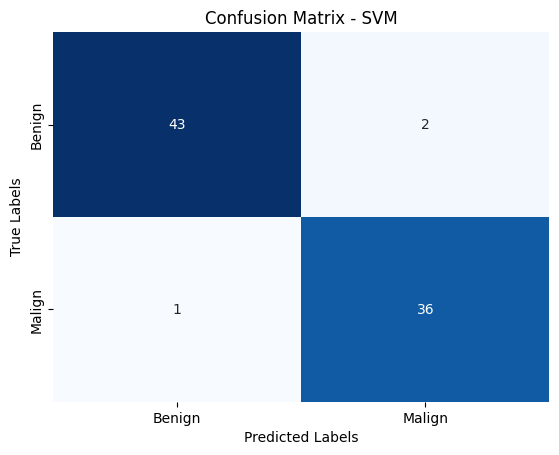

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.95      0.97      0.96        37

    accuracy                           0.96        82
   macro avg       0.96      0.96      0.96        82
weighted avg       0.96      0.96      0.96        82

Numero do Fold: 2


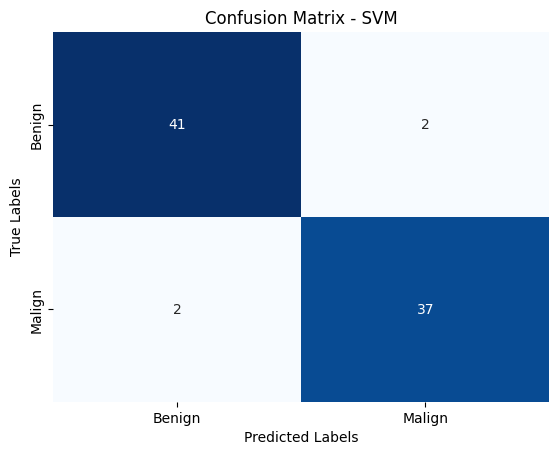

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.95      0.95      0.95        39

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Numero do Fold: 3


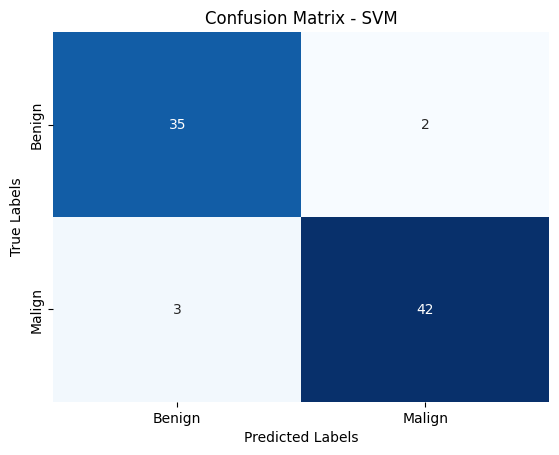

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93        37
           1       0.95      0.93      0.94        45

    accuracy                           0.94        82
   macro avg       0.94      0.94      0.94        82
weighted avg       0.94      0.94      0.94        82

Numero do Fold: 4


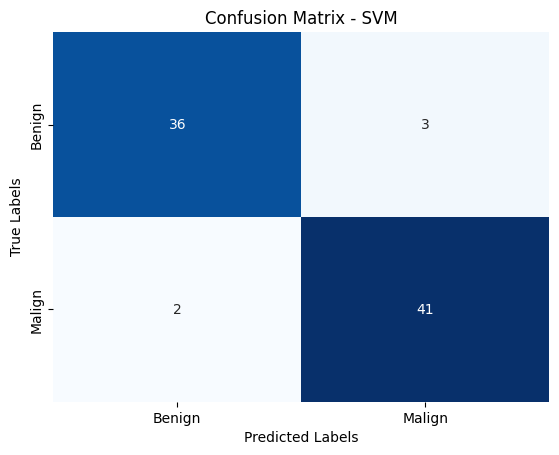

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94        39
           1       0.93      0.95      0.94        43

    accuracy                           0.94        82
   macro avg       0.94      0.94      0.94        82
weighted avg       0.94      0.94      0.94        82

Numero do Fold: 5


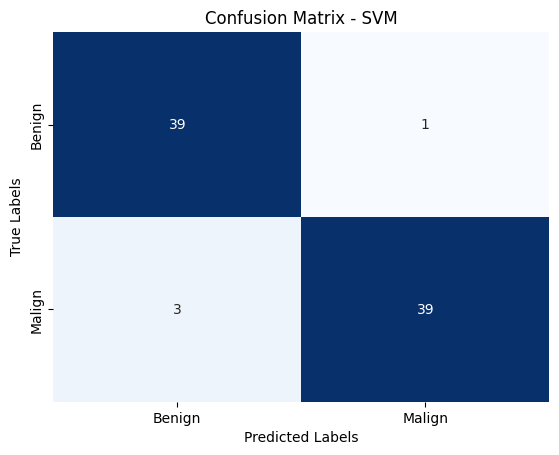

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.97      0.93      0.95        42

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82



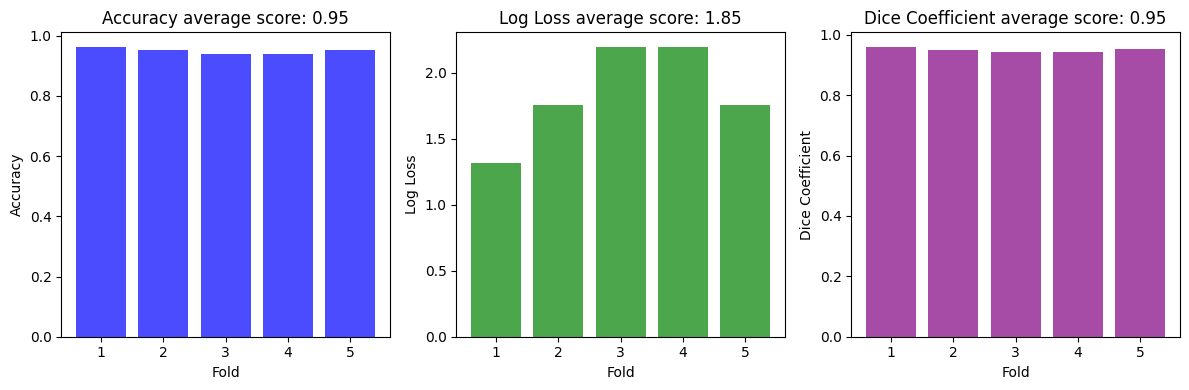

[0.9487804878048781, 1.8461383443206347, 0.949257284252871]


In [46]:
accuracies_3d, log_losses_3d, dice_coefs_3d = svm_k_fold(fold_3d_pca)
th_svm_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

**Support Vector Machine + t-test** <a name = "svm_t_test"></a>

[[Voltar a Support Vector Machine]](#svm)

Podemos repetir todo o processo usando agora o dataset obtido pela aplicação do teste de hipóteses 't-test' para selecionar as features mais significantes.

**-> 2D**

In [47]:
data_ttest_2d

Calcification  original_shape2D_Sphericity  \
0                6                     0.116476   
1                6                     0.237705   
2                3                     0.293095   
3                6                     0.145259   
4                3                     0.288620   
..             ...                          ...   
405              6                     0.245244   
406              6                     0.112044   
407              6                     0.138573   
408              6                     0.154955   
409              6                     0.276215   

     original_shape2D_MajorAxisLength  original_shape2D_MaximumDiameter  \
0                           57.542760                         46.615448   
1                           17.090541                         14.317821   
2                            9.244896                          7.615773   
3                           40.718270                         34.205263   
4                           10.327956                          9.055385   
..                                ...                               ...   
405                         13.852837                         11.180340   
406                         61.575217                         53.907328   
407                         51.164214                         43.657760   
408                         41.452617                         32.140317   
409                         12.494295                         10.440307   

     original_shape2D_MinorAxisLength  original_firstorder_TotalEnergy  \
0                           44.910854                      163807321.0   
1                           13.404688                       33000000.0   
2                            5.813537                       13646416.0   
3                           30.919604                       90440738.0   
4                            8.944272                       18000000.0   
..                                ...                              ...   
405                         10.362272                       24000000.0   
406                         39.918046                      157000000.0   
407                         28.723704                      101000000.0   
408                         33.091465                       79000000.0   
409                          8.124406                       21000000.0   

     original_firstorder_Energy  original_shape2D_Perimeter  Spiculation  \
0                   163807321.0                  356.877200            5   
1                    33000000.0                   76.769553            2   
2                    13646416.0                   36.284271            1   
3                    90440738.0                  224.994949            5   
4                    18000000.0                   44.284271            1   
..                          ...                         ...          ...   
405                  24000000.0                   59.597980            1   
406                 157000000.0                  357.948268            2   
407                 101000000.0                  229.521861            1   
408                  79000000.0                  181.580736            1   
409                  21000000.0                   50.526912            1   

     original_shape2D_PixelSurface  ...  \
0                            164.0  ...   
1                             33.0  ...   
2                             14.0  ...   
3                            101.0  ...   
4                             18.0  ...   
..                             ...  ...   
405                           24.0  ...   
406                          157.0  ...   
407                          101.0  ...   
408                           79.0  ...   
409                           21.0  ...   

     original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                        0.912201   
1                                        0.821844   
2            

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=74.17000763281251, gamma=0.001
Numero do Fold: 1


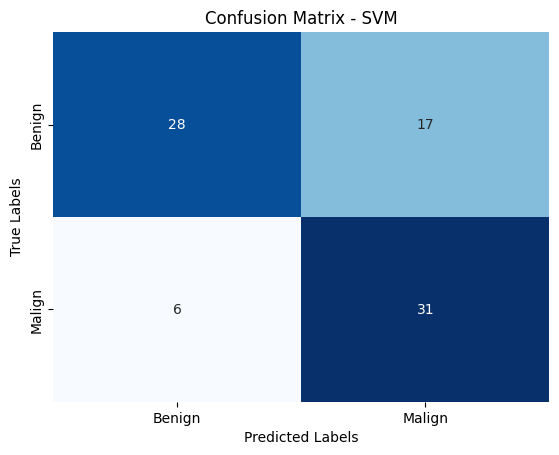

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.62      0.71        45
           1       0.65      0.84      0.73        37

    accuracy                           0.72        82
   macro avg       0.73      0.73      0.72        82
weighted avg       0.74      0.72      0.72        82

Numero do Fold: 2


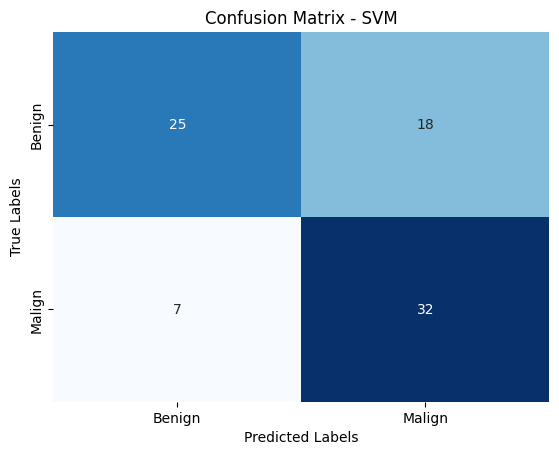

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.58      0.67        43
           1       0.64      0.82      0.72        39

    accuracy                           0.70        82
   macro avg       0.71      0.70      0.69        82
weighted avg       0.71      0.70      0.69        82

Numero do Fold: 3


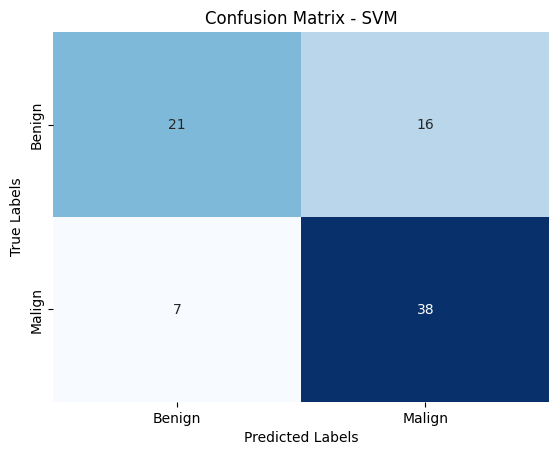

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.57      0.65        37
           1       0.70      0.84      0.77        45

    accuracy                           0.72        82
   macro avg       0.73      0.71      0.71        82
weighted avg       0.72      0.72      0.71        82

Numero do Fold: 4


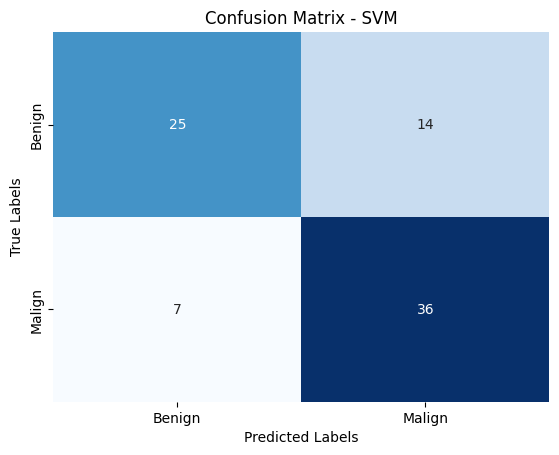

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.64      0.70        39
           1       0.72      0.84      0.77        43

    accuracy                           0.74        82
   macro avg       0.75      0.74      0.74        82
weighted avg       0.75      0.74      0.74        82

Numero do Fold: 5


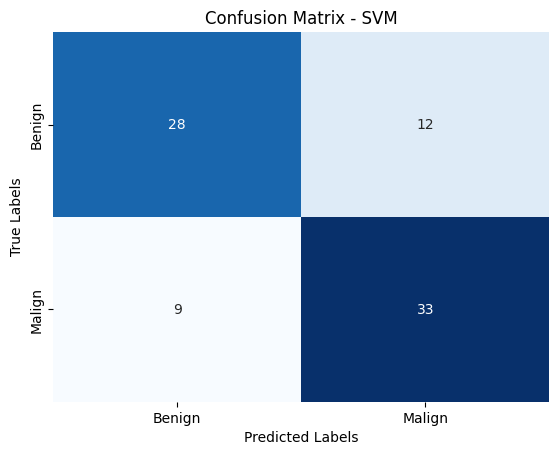

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73        40
           1       0.73      0.79      0.76        42

    accuracy                           0.74        82
   macro avg       0.75      0.74      0.74        82
weighted avg       0.74      0.74      0.74        82



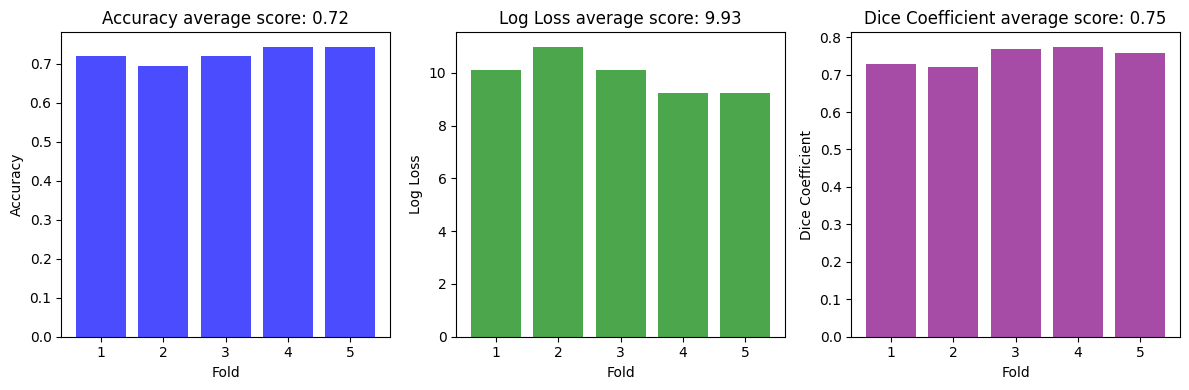

[0.724390243902439, 9.933982519439605, 0.749800778804085]


In [48]:
accuracies_2d, log_losses_2d, dice_coefs_2d = svm_k_fold(fold_2d_ttest)
th_svm_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

**-> 3D**

In [49]:
data_ttest_3d

Calcification  Spiculation  Lobulation  Margin  Subtlety  \
0                6            5           3       4         5   
1                6            2           2       3         5   
2                3            1           1       5         2   
3                6            5           1       3         5   
4                3            1           1       5         3   
..             ...          ...         ...     ...       ...   
405              6            1           1       4         3   
406              6            2           2       4         5   
407              6            1           3       4         5   
408              6            1           1       3         5   
409              6            1           1       2         4   

     original_glrlm_GrayLevelNonUniformity  \
0                               757.880362   
1                                88.384615   
2                                34.515260   
3                               437.070150   
4                                33.846154   
..                                     ...   
405                              41.769231   
406                            1239.769231   
407                             573.307692   
408                             444.769231   
409                              47.846154   

     original_glrlm_RunLengthNonUniformity  \
0                               560.437962   
1                                65.418418   
2                                34.624099   
3                               674.745089   
4                                25.277877   
..                                     ...   
405                              30.870197   
406                             950.216242   
407                             411.691071   
408                             314.515156   
409                              40.702319   

     original_gldm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                              931.027689                9.385304e+08   
1                              106.000000                1.060000e+08   
2                               44.017544                5.373786e+07   
3                              534.484914                8.652093e+08   
4                               41.000000                4.100000e+07   
..                                    ...                         ...   
405                             50.000000                5.000000e+07   
406                           1483.000000                1.482982e+09   
407                            704.000000                7.040000e+08   
408                            556.000000                5.560000e+08   
409                             54.000000                5.400000e+07   

     original_firstorder_TotalEnergy  ...  \
0                       9.385304e+08  ...   
1                       1.060000e+08  ...   
2                       5.373786e+07  ...   
3                       8.652093e+08  ...   
4                       4.100000e+07  ...   
..                               ...  ...   
405                     5.000000e+07  ...   
406                     1.482982e+09  ...   
407                     7.040000e+08  ...   
408                     5.560000e+08  ...   
409                     5.400000e+07  ...   

     original_glszm_SmallAreaHighGrayLevelEmphasis  original_glcm_Idmn  \
0                                         6.200000            0.998849   
1                                         0.000089            1.000000   
2                                       135.571486            0.940932   
3                                        59.289969            0.980366   
4                                         0.000595            1.000000   
..                                             ...                 ...   
405                                       0.000400            1.000000   
406                                       0.000433            1.000000   
407                               

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=63.20212876135028, gamma=0.001
Numero do Fold: 1


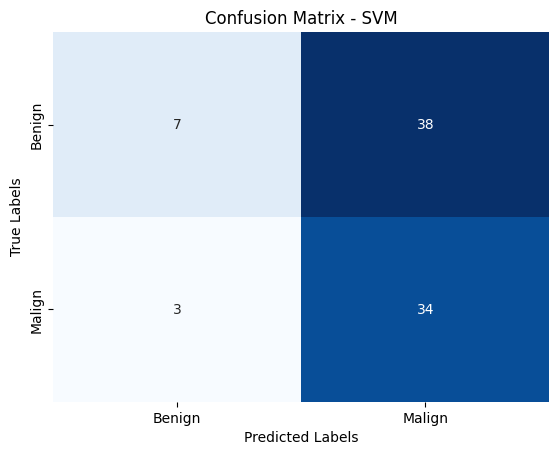

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.16      0.25        45
           1       0.47      0.92      0.62        37

    accuracy                           0.50        82
   macro avg       0.59      0.54      0.44        82
weighted avg       0.60      0.50      0.42        82

Numero do Fold: 2


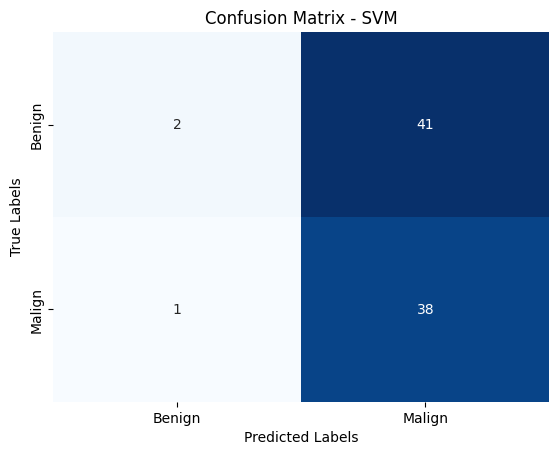

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.05      0.09        43
           1       0.48      0.97      0.64        39

    accuracy                           0.49        82
   macro avg       0.57      0.51      0.37        82
weighted avg       0.58      0.49      0.35        82

Numero do Fold: 3


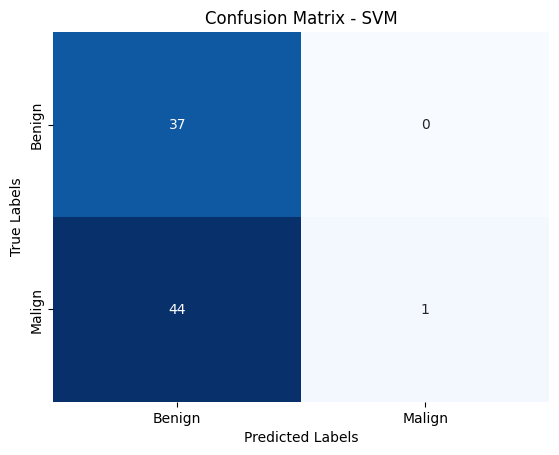

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        37
           1       1.00      0.02      0.04        45

    accuracy                           0.46        82
   macro avg       0.73      0.51      0.34        82
weighted avg       0.75      0.46      0.31        82

Numero do Fold: 4


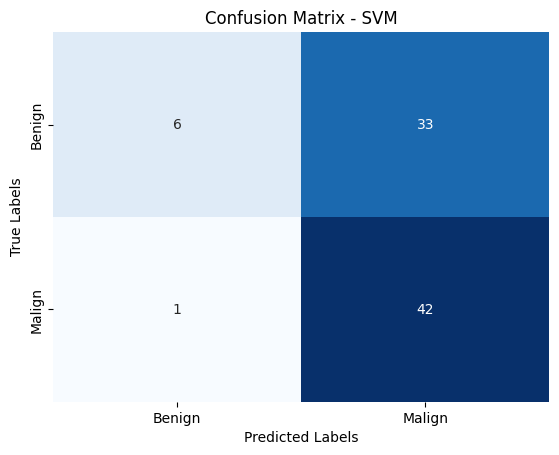

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.15      0.26        39
           1       0.56      0.98      0.71        43

    accuracy                           0.59        82
   macro avg       0.71      0.57      0.49        82
weighted avg       0.70      0.59      0.50        82

Numero do Fold: 5


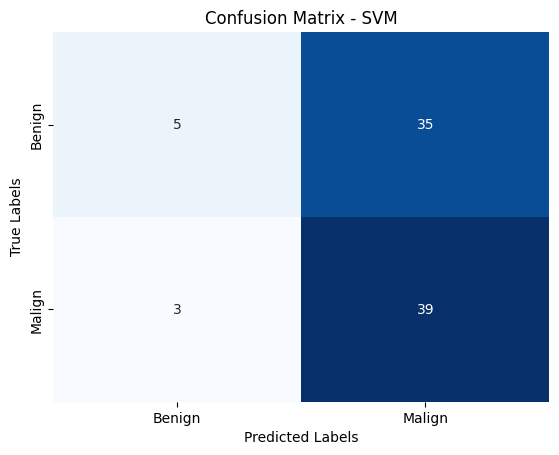

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.12      0.21        40
           1       0.53      0.93      0.67        42

    accuracy                           0.54        82
   macro avg       0.58      0.53      0.44        82
weighted avg       0.57      0.54      0.45        82



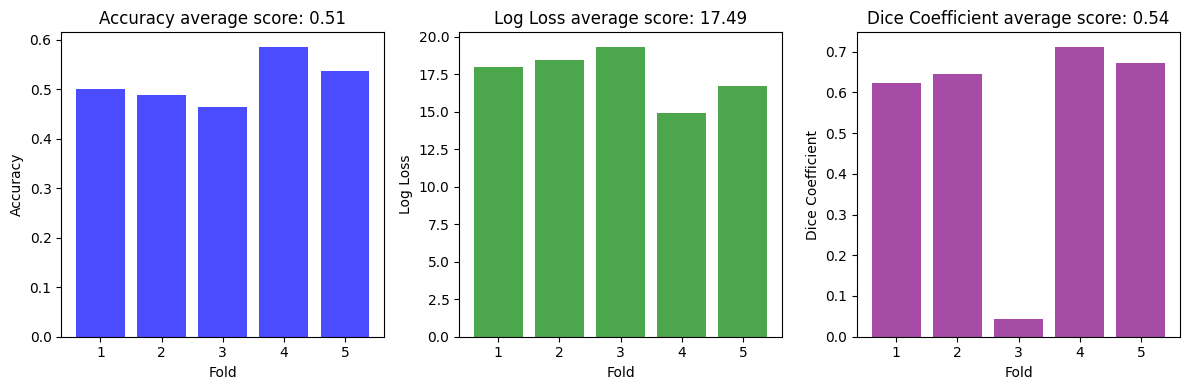

[0.5146341463414634, 17.49435859618125, 0.5391354936744037]


In [50]:
accuracies_3d, log_losses_3d, dice_coefs_3d = svm_k_fold(fold_3d_ttest)
th_svm_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

**Support Vector Machine + Random Forest (seleção de features)** <a name = "svm_rf"></a>

[[Voltar a Support Vector Machine]](#svm)

Por fim, repetimos o processo para o dataset obtido pelo Random Forest, usado na seleção das features.

**-> 2D**

In [51]:
data_rf_2d

Calcification  Lobulation  Spiculation  \
0                6           3            5   
1                6           2            2   
2                3           1            1   
3                6           1            5   
4                3           1            1   
..             ...         ...          ...   
405              6           1            1   
406              6           2            2   
407              6           3            1   
408              6           1            1   
409              6           1            1   

     original_gldm_GrayLevelNonUniformity  original_shape2D_MajorAxisLength  \
0                              160.036585                         57.542760   
1                               33.000000                         17.090541   
2                               12.142857                          9.244896   
3                               43.079208                         40.718270   
4                               18.000000                         10.327956   
..                                    ...                               ...   
405                             24.000000                         13.852837   
406                            157.000000                         61.575217   
407                            101.000000                         51.164214   
408                             79.000000                         41.452617   
409                             21.000000                         12.494295   

     original_glrlm_GrayLevelNonUniformity  Margin  \
0                               113.551582       4   
1                                24.750000       3   
2                                 9.184343       5   
3                                31.512433       3   
4                                13.500000       5   
..                                     ...     ...   
405                              18.000000       4   
406                             116.000000       4   
407                              73.000000       4   
408                              58.000000       3   
409                              15.500000       2   

     original_firstorder_Energy  original_shape2D_Perimeter  Subtlety  ...  \
0                   163807321.0                  356.877200         5  ...   
1                    33000000.0                   76.769553         5  ...   
2                    13646416.0                   36.284271         2  ...   
3                    90440738.0                  224.994949         5  ...   
4                    18000000.0                   44.284271         3  ...   
..                          ...                         ...       ...  ...   
405                  24000000.0                   59.597980         3  ...   
406                 157000000.0                  357.948268         5  ...   
407                 101000000.0                  229.521861         5  ...   
408                  79000000.0                  181.580736         5  ...   
409                  21000000.0                   50.526912         4  ...   

     Sphericity  original_gldm_LargeDependenceLowGrayLevelEmphasis  Texture  \
0             3                                          11.258299        5   
1             4                                           9.000000        4   
2             2                                           7.643973        5   
3             4                                           5.172723        5   
4             5                                           9.000000        5   
..          ...                                                ...      ...   
405           3                                           9.000000        5   
406           4                                           9.636943        5   
407           3                                          10.524752        5   
408           3                                           9.886076        5   
409           4                     

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=67.44775326777929, gamma=0.001
Numero do Fold: 1


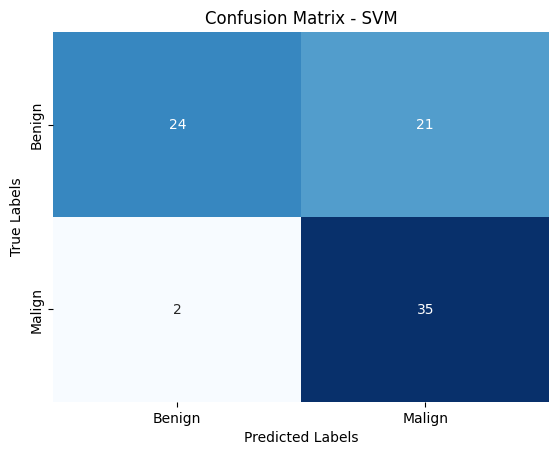

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.53      0.68        45
           1       0.62      0.95      0.75        37

    accuracy                           0.72        82
   macro avg       0.77      0.74      0.71        82
weighted avg       0.79      0.72      0.71        82

Numero do Fold: 2


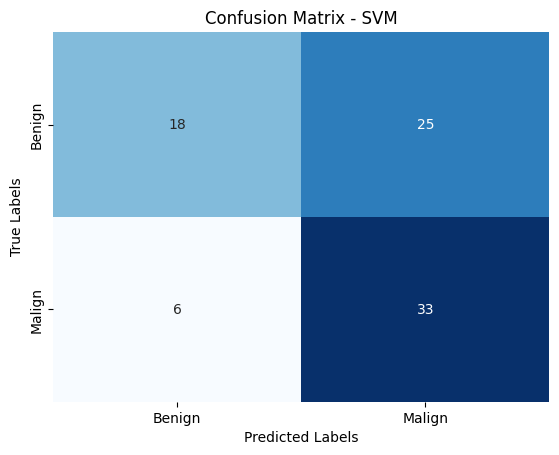

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.42      0.54        43
           1       0.57      0.85      0.68        39

    accuracy                           0.62        82
   macro avg       0.66      0.63      0.61        82
weighted avg       0.66      0.62      0.61        82

Numero do Fold: 3


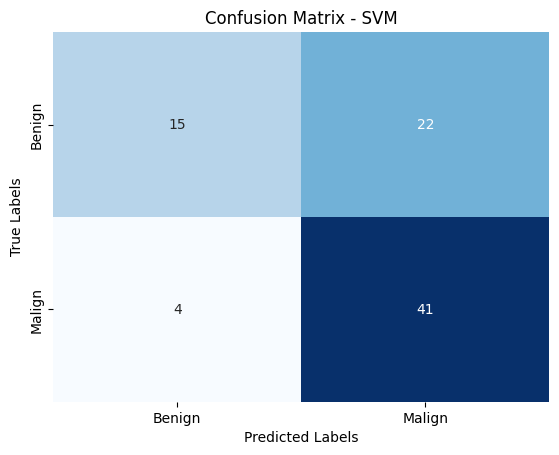

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.41      0.54        37
           1       0.65      0.91      0.76        45

    accuracy                           0.68        82
   macro avg       0.72      0.66      0.65        82
weighted avg       0.71      0.68      0.66        82

Numero do Fold: 4


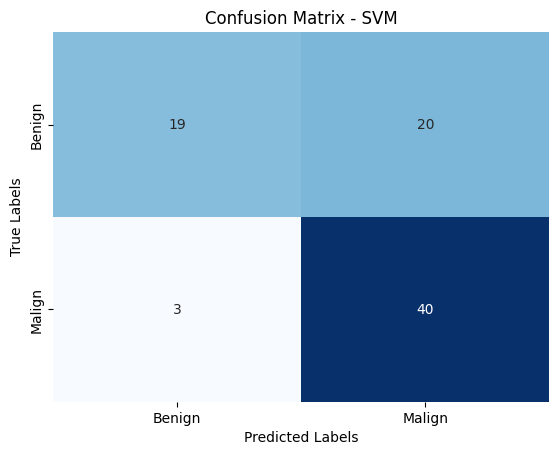

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.49      0.62        39
           1       0.67      0.93      0.78        43

    accuracy                           0.72        82
   macro avg       0.77      0.71      0.70        82
weighted avg       0.76      0.72      0.70        82

Numero do Fold: 5


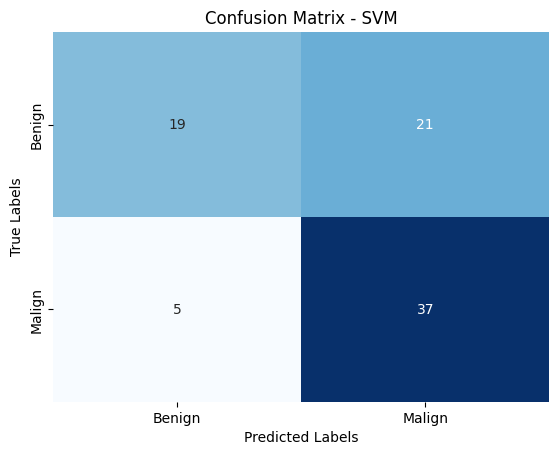

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.47      0.59        40
           1       0.64      0.88      0.74        42

    accuracy                           0.68        82
   macro avg       0.71      0.68      0.67        82
weighted avg       0.71      0.68      0.67        82



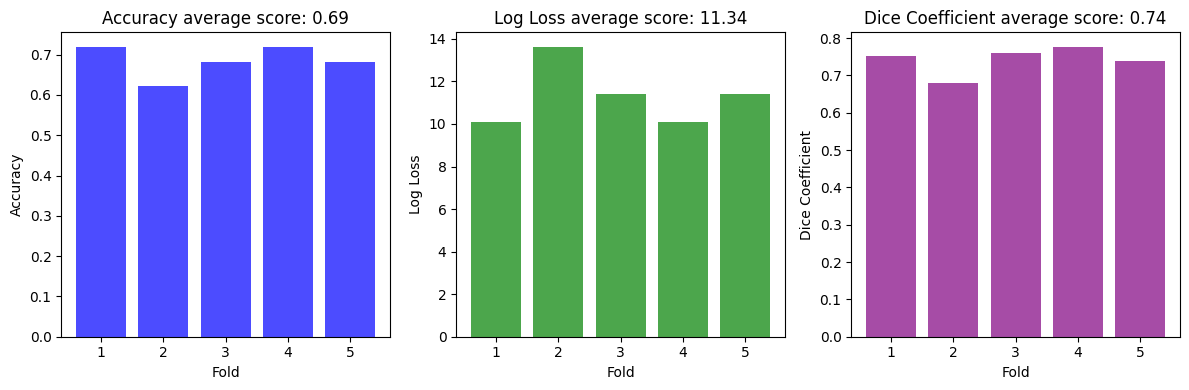

[0.6853658536585366, 11.34056411511247, 0.7418117663125008]


In [52]:
accuracies_2d, log_losses_2d, dice_coefs_2d = svm_k_fold(fold_2d_rf)
th_svm_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

**-> 3D**

In [53]:
data_rf_3d

Calcification  Spiculation  Lobulation  Margin  \
0                6            5           3       4   
1                6            2           2       3   
2                3            1           1       5   
3                6            5           1       3   
4                3            1           1       5   
..             ...          ...         ...     ...   
405              6            1           1       4   
406              6            2           2       4   
407              6            1           3       4   
408              6            1           1       3   
409              6            1           1       2   

     original_glrlm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                               757.880362                9.385304e+08   
1                                88.384615                1.060000e+08   
2                                34.515260                5.373786e+07   
3                               437.070150                8.652093e+08   
4                                33.846154                4.100000e+07   
..                                     ...                         ...   
405                              41.769231                5.000000e+07   
406                            1239.769231                1.482982e+09   
407                             573.307692                7.040000e+08   
408                             444.769231                5.560000e+08   
409                              47.846154                5.400000e+07   

     original_glrlm_RunLengthNonUniformity  Subtlety  \
0                               560.437962         5   
1                                65.418418         5   
2                                34.624099         2   
3                               674.745089         5   
4                                25.277877         3   
..                                     ...       ...   
405                              30.870197         3   
406                             950.216242         5   
407                             411.691071         5   
408                             314.515156         5   
409                              40.702319         4   

     original_gldm_GrayLevelNonUniformity  \
0                              931.027689   
1                              106.000000   
2                               44.017544   
3                              534.484914   
4                               41.000000   
..                                    ...   
405                             50.000000   
406                           1483.000000   
407                            704.000000   
408                            556.000000   
409                             54.000000   

     original_gldm_DependenceNonUniformity  ...  original_ngtdm_Strength  \
0                               155.261981  ...                 0.950551   
1                                26.660377  ...                 0.000000   
2                                 8.929825  ...                13.837206   
3                               134.415948  ...                 4.995332   
4                                13.682927  ...                 0.000000   
..                                     ...  ...                      ...   
405                              19.320000  ...                 0.000000   
406                             324.684423  ...                 0.000000   
407                             112.750000  ...                 0.000000   
408                              90.420863  ...                 0.000000   
409                              19.148148  ...                 0.000000   

     original_glszm_ZoneVariance  original_glszm_GrayLevelVariance  \
0                  139576.960000                          0.640000   
1                       0.000000                          0.000000   
2                     292.122449                         45.346939   
3                    1441.356256                

Stopping search: maximum iterations reached --> 100
Melhores parâmetros a partir do PSO: C=26.87564432225858, gamma=0.001
Numero do Fold: 1


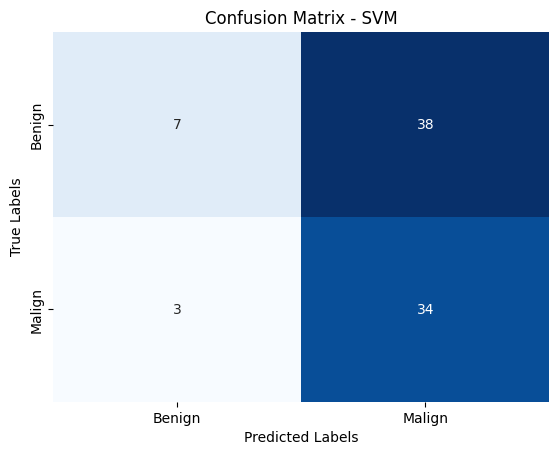

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.16      0.25        45
           1       0.47      0.92      0.62        37

    accuracy                           0.50        82
   macro avg       0.59      0.54      0.44        82
weighted avg       0.60      0.50      0.42        82

Numero do Fold: 2


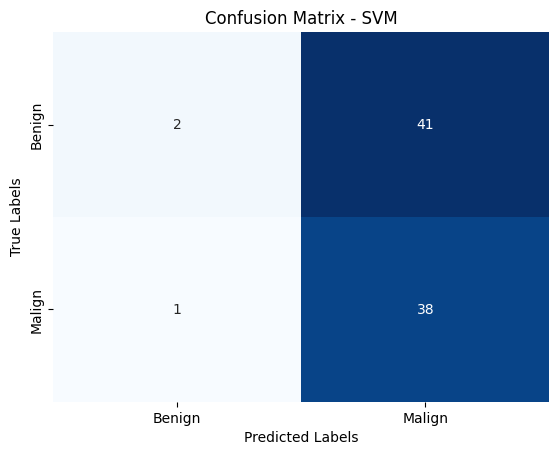

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.05      0.09        43
           1       0.48      0.97      0.64        39

    accuracy                           0.49        82
   macro avg       0.57      0.51      0.37        82
weighted avg       0.58      0.49      0.35        82

Numero do Fold: 3


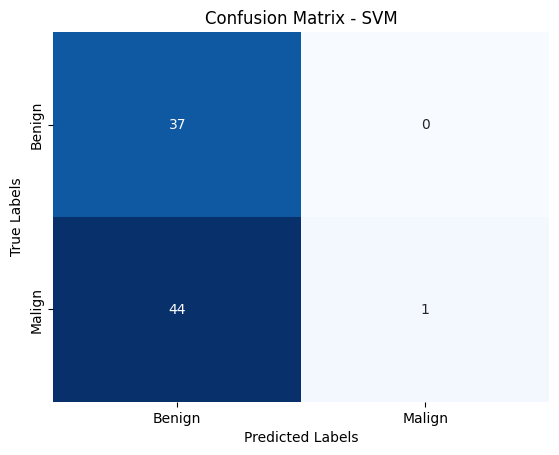

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        37
           1       1.00      0.02      0.04        45

    accuracy                           0.46        82
   macro avg       0.73      0.51      0.34        82
weighted avg       0.75      0.46      0.31        82

Numero do Fold: 4


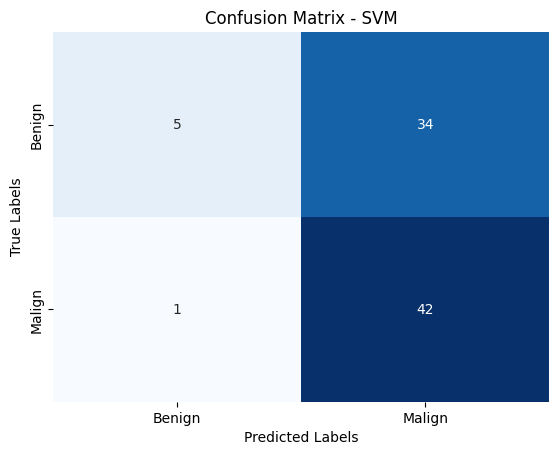

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.13      0.22        39
           1       0.55      0.98      0.71        43

    accuracy                           0.57        82
   macro avg       0.69      0.55      0.46        82
weighted avg       0.69      0.57      0.48        82

Numero do Fold: 5


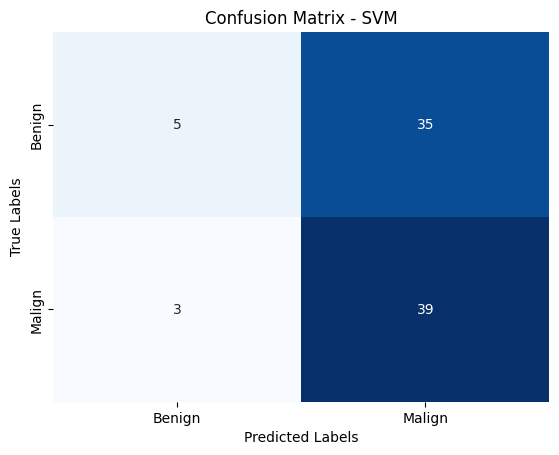

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.12      0.21        40
           1       0.53      0.93      0.67        42

    accuracy                           0.54        82
   macro avg       0.58      0.53      0.44        82
weighted avg       0.57      0.54      0.45        82



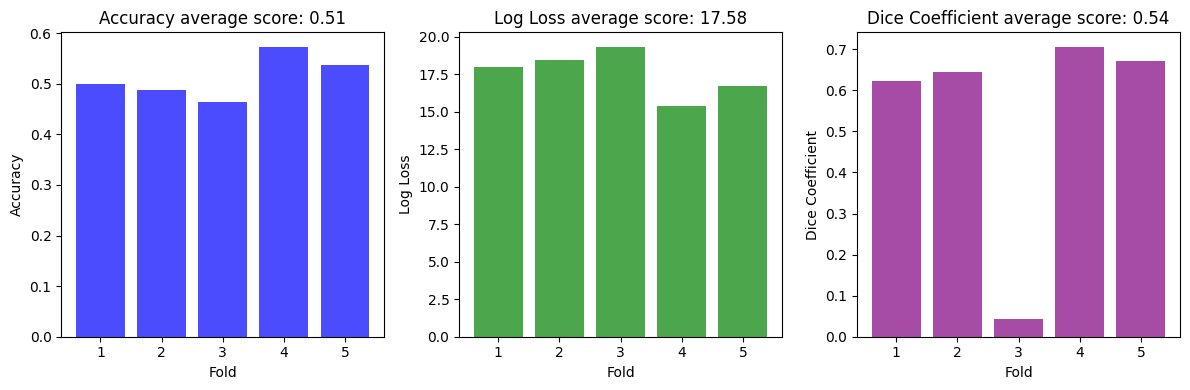

[0.5121951219512195, 17.582269945910802, 0.5379390829067068]


In [54]:
accuracies_3d, log_losses_3d, dice_coefs_3d = svm_k_fold(fold_3d_rf)
th_svm_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

**Resultados Support Vector Machine** <a name = "svm_resultados"></a>

[[Voltar a Support Vector Machine]](#svm)

**-> 2D**

In [55]:
print(results_svm_2d)

[[0.6853658536585366, 11.34056411511247, 0.7418117663125008], [0.9317073170731707, 2.4615177924275127, 0.929468419847578], [0.724390243902439, 9.933982519439605, 0.749800778804085], [0.6853658536585366, 11.34056411511247, 0.7418117663125008]]


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/3843270632.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


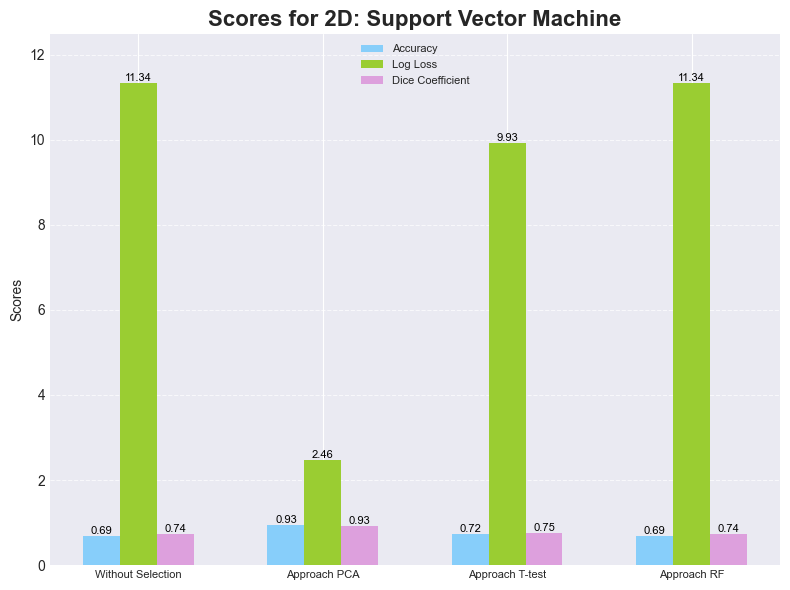

In [56]:
plot_scores(results_svm_2d, "2D: Support Vector Machine")

**-> 3D**

In [57]:
print(results_svm_3d)

[[0.5121951219512195, 17.582269945910802, 0.5379390829067068], [0.9487804878048781, 1.8461383443206347, 0.949257284252871], [0.5146341463414634, 17.49435859618125, 0.5391354936744037], [0.5121951219512195, 17.582269945910802, 0.5379390829067068]]


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/3843270632.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


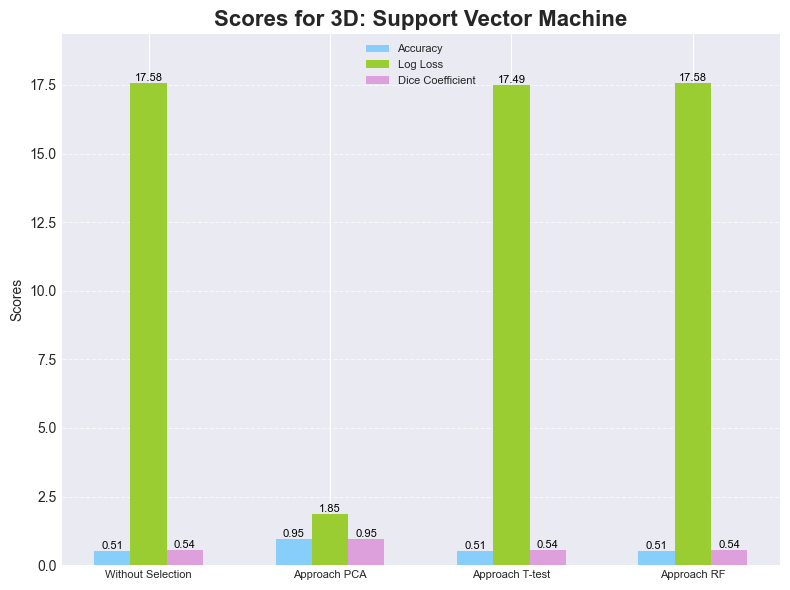

In [58]:
plot_scores(results_svm_3d, "3D: Support Vector Machine")

### **Random Forest** <a name = "rf"></a>
[[Voltar a Training Models]](#tm)

O algoritmo Random Forest também é um dos algoritmos mais vulgarmente utilizados para a fase de classificação dos nódulos como malignos ou benignos. É um algoritmo que lida bem com a variabilidade dos dados e é robusto contra overlap de variáveis, o que pode ser útil tendo em contra que temos muitas features a considerar. 

Estudos que usam Random Forest na classificação:
- [LG18](#LG18) (Random Forest + PCA)


Código que iremos usar para treinar os modelos:

In [59]:
def random_forest_kfold(fold, k=5, random_state=42):
    
    accuracies = []
    log_losses = []
    dice_coefs = []
    n_fold = 1
    model = RandomForestClassifier(random_state=random_state)
    for  (X_train, X_test, y_train, y_test) in fold:
        print(f"Número do Fold: {n_fold}" )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        acc, logloss, dice = metrics_testing(y_test, predictions, "Random Forest")
        accuracies.append(acc)
        log_losses.append(logloss)
        dice_coefs.append(dice)
        n_fold += 1

    return accuracies, log_losses, dice_coefs

In [60]:
results_rf_2d = []
results_rf_3d = []
th_rf_2d = []
th_rf_3d = []

**Random Forest sem seleção de features** <a name = "rf_sem_selecao"></a>

[[Voltar a Random Forest]](#rf)

**-> 2D**

In [61]:
data_2d

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0              5           3           3       4         5        5   
1              2           2           4       3         5        4   
2              1           1           2       5         2        5   
3              5           1           4       3         5        5   
4              1           1           5       5         3        5   
..           ...         ...         ...     ...       ...      ...   
405            1           1           3       4         3        5   
406            2           2           4       4         5        5   
407            1           3           3       4         5        5   
408            1           1           3       3         5        5   
409            1           1           4       2         4        5   

     Calcification  Malignancy  diagnostics_Image-original_Maximum  \
0                6           1                               400.0   
1                6           1                               400.0   
2                3           0                               185.0   
3                6           1                               400.0   
4                3           0                               400.0   
..             ...         ...                                 ...   
405              6           0                               400.0   
406              6           1                               400.0   
407              6           1                               241.0   
408              6           1                               238.0   
409              6           0                               245.0   

     original_shape2D_Elongation  ...  \
0                       0.780478  ...   
1                       0.784334  ...   
2                       0.628837  ...   
3                       0.759355  ...   
4                       0.866025  ...   
..                           ...  ...   
405                     0.748025  ...   
406                     0.648281  ...   
407                     0.561402  ...   
408                     0.798296  ...   
409                     0.650249  ...   

     original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                            11.258299   
1                                             9.000000   
2                                             7.643973   
3                                             5.172723   
4                                             9.000000   
..                                                 ...   
405                                           9.000000   
406                                           9.636943   
407                                          10.524752   
408                                           9.886076   
409                                           9.666667   

     original_gldm_LowGrayLevelEmphasis  \
0                              0.990007   
1                              1.000000   
2                              0.929688   
3                              0.665108   
4                              1.000000   
..                                  ...   
405                            1.000000   
406                            1.000000   
407                            1.000000   
408                            1.000000   
409                            1.000000   

     original_gldm_SmallDependenceEmphasis  \
0                                 0.111187   
1                                 0.111111   
2                                 0.194444   
3                                 0.406474   
4                                 0.111111   
..                                     ...   
405                               0.111111   
406                               0.106943   
407                               0.100523   
408                               0.104958   
409                               0.106481   

     original_gldm_SmallDependenceHighGrayLevelEmph

Número do Fold: 1


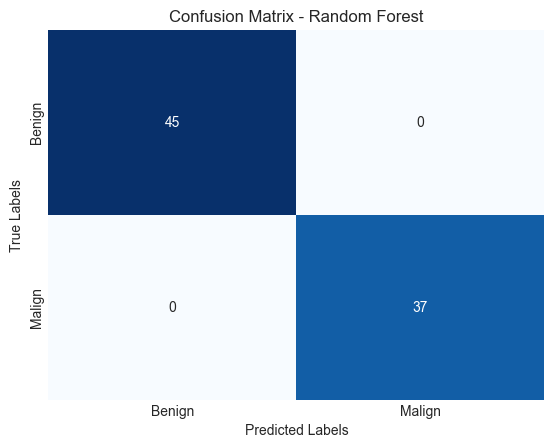

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 2


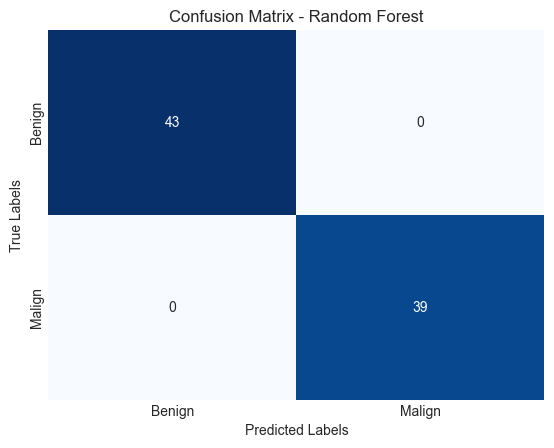

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        39

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 3


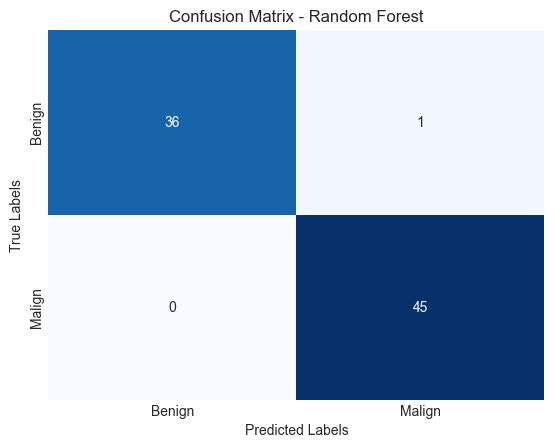

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.98      1.00      0.99        45

    accuracy                           0.99        82
   macro avg       0.99      0.99      0.99        82
weighted avg       0.99      0.99      0.99        82

Número do Fold: 4


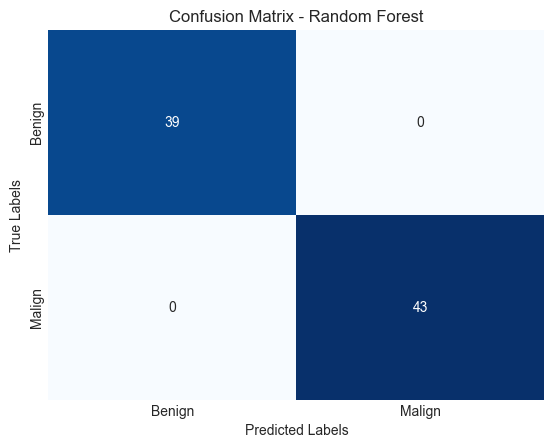

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        43

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 5


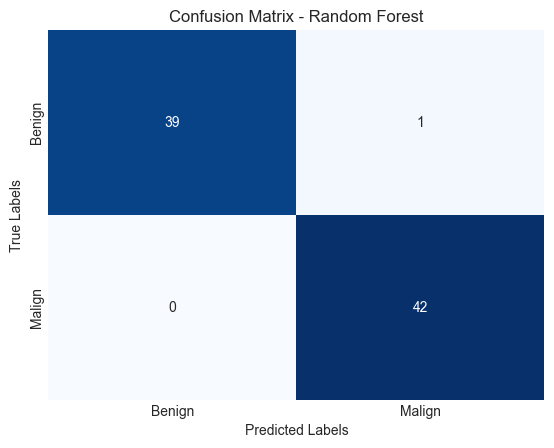

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        42

    accuracy                           0.99        82
   macro avg       0.99      0.99      0.99        82
weighted avg       0.99      0.99      0.99        82



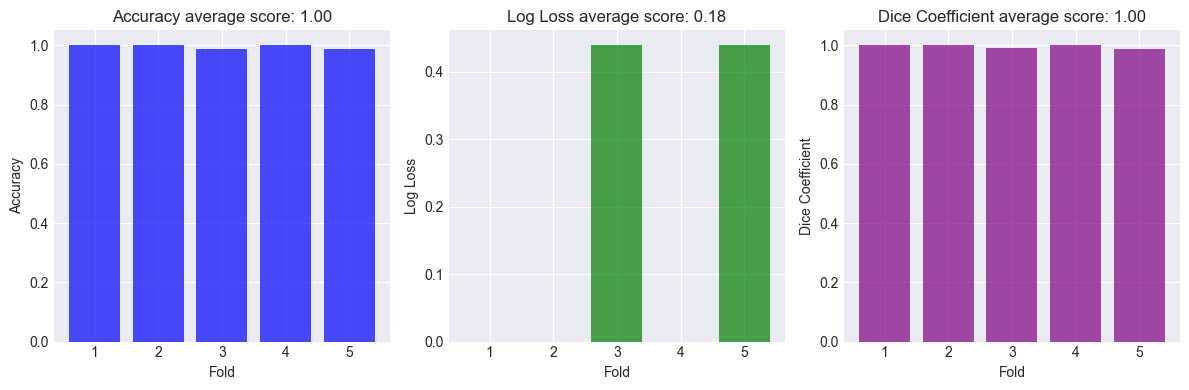

[0.9951219512195122, 0.17582269945910828, 0.9954492566257273]


In [62]:
accuracies_2d, log_losses_2d, dice_coefs_2d = random_forest_kfold(fold_2d)
th_rf_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
print(average_metrics_2d)
results_rf_2d.append(average_metrics_2d)

**-> 3D**

In [63]:
data_3d

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0              5           3           3       4         5        5   
1              2           2           4       3         5        4   
2              1           1           2       5         2        5   
3              5           1           4       3         5        5   
4              1           1           5       5         3        5   
..           ...         ...         ...     ...       ...      ...   
405            1           1           3       4         3        5   
406            2           2           4       4         5        5   
407            1           3           3       4         5        5   
408            1           1           3       3         5        5   
409            1           1           4       2         4        5   

     Calcification  Malignancy  diagnostics_Image-original_Maximum  \
0                6           1                               400.0   
1                6           1                               400.0   
2                3           0                               400.0   
3                6           1                               400.0   
4                3           0                               400.0   
..             ...         ...                                 ...   
405              6           0                               400.0   
406              6           1                               400.0   
407              6           1                               400.0   
408              6           1                               400.0   
409              6           0                               400.0   

     original_firstorder_90Percentile  ...  original_ngtdm_Coarseness  \
0                             -1000.0  ...                   0.284191   
1                             -1000.0  ...             1000000.000000   
2                              -902.4  ...                   0.015397   
3                              -845.5  ...                   0.002780   
4                             -1000.0  ...             1000000.000000   
..                                ...  ...                        ...   
405                           -1000.0  ...             1000000.000000   
406                           -1000.0  ...             1000000.000000   
407                           -1000.0  ...             1000000.000000   
408                           -1000.0  ...             1000000.000000   
409                           -1000.0  ...             1000000.000000   

     original_ngtdm_Complexity  original_ngtdm_Contrast  \
0                     0.032596                 0.000051   
1                     0.000000                 0.000000   
2                   200.108114                 1.744897   
3                   400.910706                 0.059704   
4                     0.000000                 0.000000   
..                         ...                      ...   
405                   0.000000                 0.000000   
406                   0.000000                 0.000000   
407                   0.000000                 0.000000   
408                   0.000000                 0.000000   
409                   0.000000                 0.000000   

     original_ngtdm_Strength  diagnostics_Image-original_Size_x  \
0                   0.950551                              133.0   
1                   0.000000                              140.0   
2                  13.837206                              241.0   
3                   4.995332                              145.0   
4                   0.000000                              128.0   
..                       ...                                ...   
405                 0.000000                              186.0   
406                 0.000000                              186.0   
407                 0.000000                              133.0   
408                 0.000000                           

Número do Fold: 1


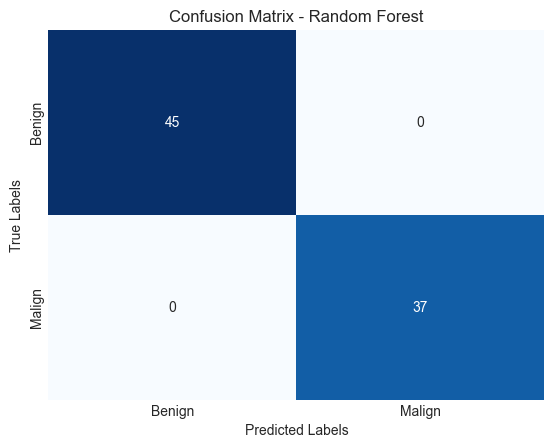

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 2


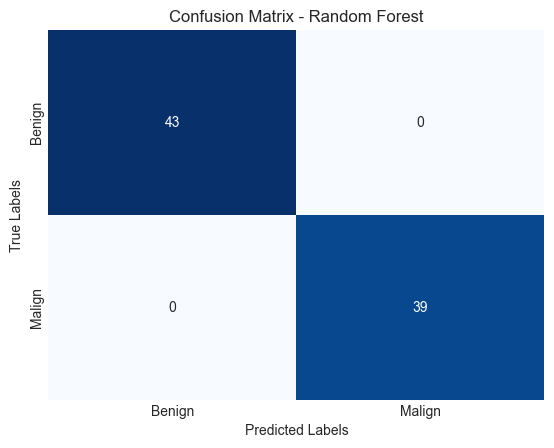

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        39

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 3


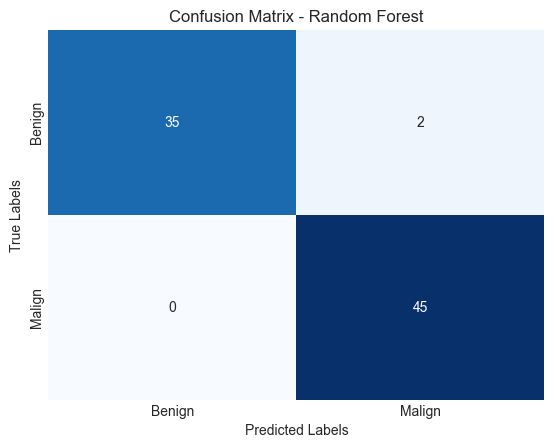

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.96      1.00      0.98        45

    accuracy                           0.98        82
   macro avg       0.98      0.97      0.98        82
weighted avg       0.98      0.98      0.98        82

Número do Fold: 4


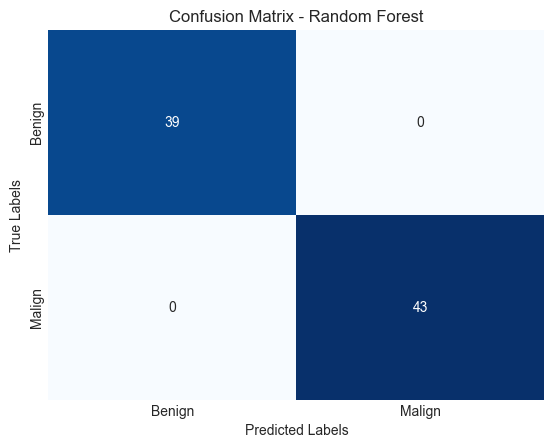

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        43

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 5


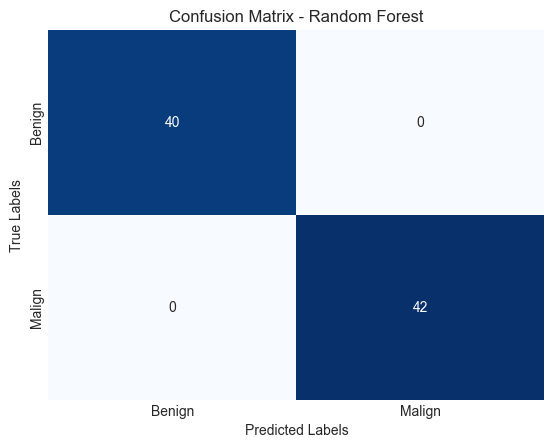

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        42

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



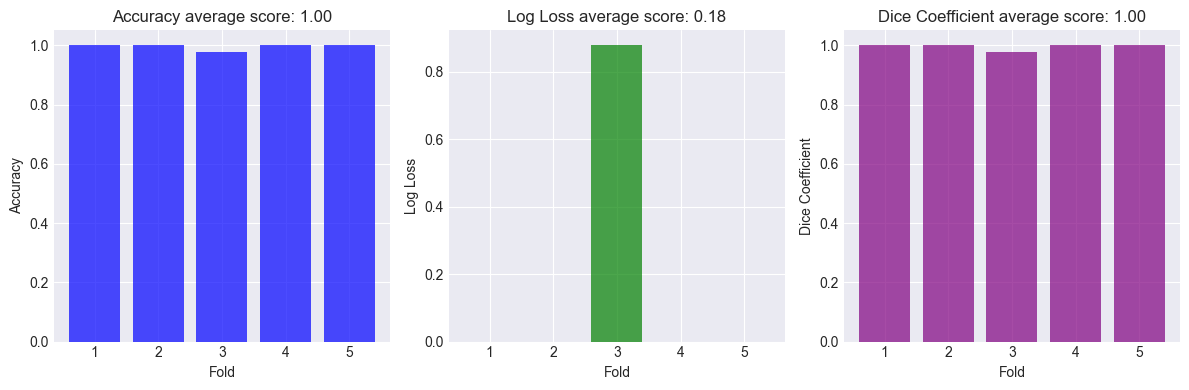

[0.9951219512195122, 0.17582269945910828, 0.9956521739130434]


In [64]:
accuracies_3d, log_losses_3d, dice_coefs_3d = random_forest_kfold(fold_3d)
th_rf_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
print(average_metrics_3d)
results_rf_3d.append(average_metrics_3d)

**Random Forest + PCA <a name = "rf_pca"></a>- abordagem usada pelo estudo [LG18](#LG18)**

[[Voltar a Random Forest]](#rf)

Iremos agora passar à implementação do modelo Random Forest, usando o dataset preparado a partir do método de Principal Component Analysis, data_pca.

**-> 2D**

In [65]:
data_pca_2d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     0.605527  14.312994  2.618862 -5.010918 -1.873619  0.486000  3.780943   
1    -2.267379  -1.819947  0.040090  0.846899 -1.514118 -0.992908 -0.811545   
2     5.058170  -2.480426 -3.601613 -4.459463 -1.977084 -3.833077  1.266602   
3    26.065083   6.727777 -6.985184  4.449976 -1.804223  1.655932 -2.786482   
4    -2.158470  -3.958437 -0.673922  0.104410  1.383675 -1.097692  0.958196   
..         ...        ...       ...       ...       ...       ...       ...   
405  -2.233398  -2.998710 -0.378282  0.497056 -0.144041 -1.423559 -0.648699   
406  -2.923210  11.711044  5.856770  4.536946  0.801008 -0.007470  1.331167   
407  -2.716925   5.627624  3.129216  2.034017 -1.944248  1.328403  0.538597   
408  -2.511517   3.152825  2.056172  1.597862 -1.588072  0.221263  0.574015   
409  -2.493756  -2.801108 -0.163597 -0.006073  0.120255  1.392496 -1.301845   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0    4.509357 -3.000581  2.485737  0.280072  1.281586 -1.161818  2.506096   
1    0.548039 -0.191325  0.474135  0.777253  0.522630 -0.555025 -0.525174   
2    3.487037  0.174202 -3.689468 -2.493443 -2.397851  2.413588 -1.744844   
3   -3.047505  1.827419  1.127816  1.851693  0.324629 -2.575421  1.917357   
4   -0.653246  0.245743  0.075601 -0.395550  0.432105 -0.498446 -0.096061   
..        ...       ...       ...       ...       ...       ...       ...   
405  0.289676  0.122413  0.325009 -0.998632 -0.439882 -0.165449  0.604338   
406 -1.196007  0.614933 -2.745411 -1.343567 -0.232678  0.409916 -1.701848   
407 -0.491240  0.276382 -0.707462 -0.799203 -1.466120  0.316186 -0.732913   
408 -0.519261  0.386101 -0.228512 -0.288422  0.197071 -0.046711  0.199059   
409  0.218497 -0.266445  0.052311 -0.835398 -0.070959  0.625990 -0.076007   

         PC14      PC15      PC16      PC17  
0   -1.418022 -0.960150  0.979622 -2.705202  
1    0.099056 -0.658362 -0.094486 -0.035771  
2    2.832277  4.918582 -0.709808  0.405147  
3    1.008172  2.188989 -2.696890 -2.489348  
4    0.030861  0.062598 -0.281642 -0.444985  
..        ...       ...       ...       ...  
405 -0.485219  0.312282 -0.701358  0.533368  
406 -1.518696 -0.590536 -0.523272  0.608692  
407  0.573080 -0.718251  0.112633  0.807437  
408  0.393201  0.331136 -0.147753  0.826526  
409  0.689238 -0.565327 -1.269216 -0.252564  

[410 rows x 18 columns]

Número do Fold: 1


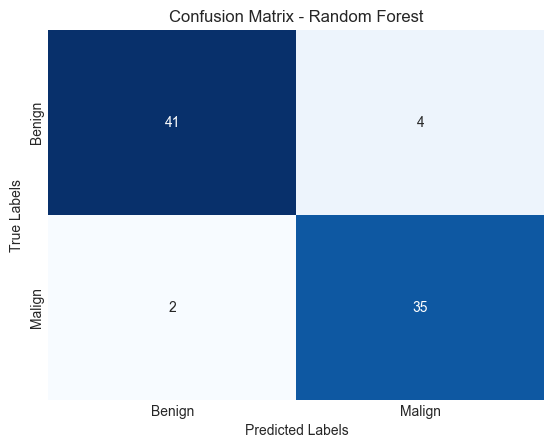

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        45
           1       0.90      0.95      0.92        37

    accuracy                           0.93        82
   macro avg       0.93      0.93      0.93        82
weighted avg       0.93      0.93      0.93        82

Número do Fold: 2


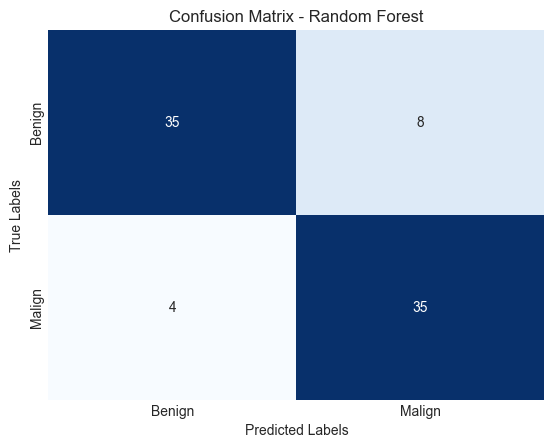

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        43
           1       0.81      0.90      0.85        39

    accuracy                           0.85        82
   macro avg       0.86      0.86      0.85        82
weighted avg       0.86      0.85      0.85        82

Número do Fold: 3


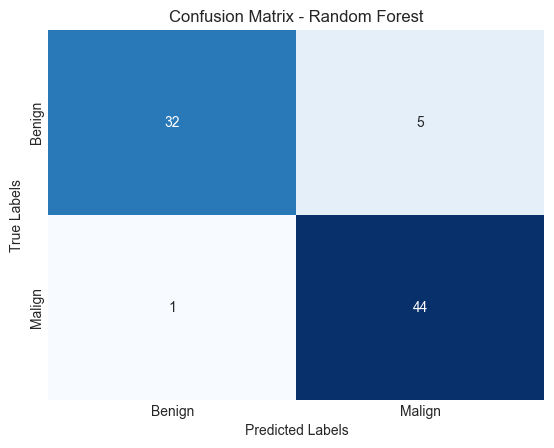

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91        37
           1       0.90      0.98      0.94        45

    accuracy                           0.93        82
   macro avg       0.93      0.92      0.93        82
weighted avg       0.93      0.93      0.93        82

Número do Fold: 4


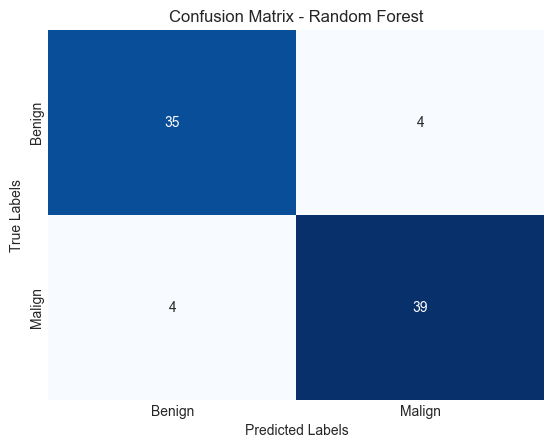

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        39
           1       0.91      0.91      0.91        43

    accuracy                           0.90        82
   macro avg       0.90      0.90      0.90        82
weighted avg       0.90      0.90      0.90        82

Número do Fold: 5


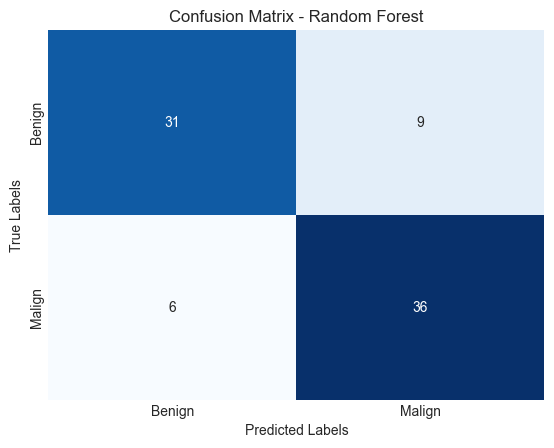

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81        40
           1       0.80      0.86      0.83        42

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82



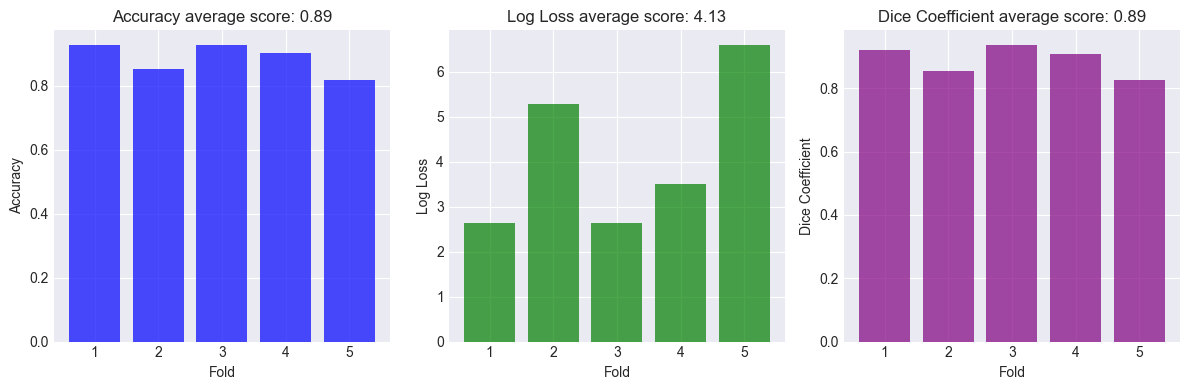

In [66]:
accuracies_2d, log_losses_2d, dice_coefs_2d = random_forest_kfold(fold_2d_pca)
th_rf_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
results_rf_2d.append(average_metrics_2d)

**-> 3D**

In [67]:
data_pca_3d

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0    -0.782122 -4.117717  1.807559  3.238631 -2.126003  0.470964  0.041700   
1    -2.459356  2.218242 -1.818623  2.089689  0.356737  1.117322 -0.424158   
2    13.960910  0.629641 -1.754254 -1.768815 -1.563777 -2.868636 -2.049989   
3    18.196420 -6.671389 -6.882279  1.530733  2.834788  2.809031 -2.197428   
4    -2.639728  3.325768 -2.169896  0.994315 -0.182417 -0.915270  1.220950   
..         ...       ...       ...       ...       ...       ...       ...   
405  -2.682271  3.198533 -2.295293  1.549300  0.057934 -0.301314  0.212454   
406  -2.269498 -5.455861  4.720836  7.225682  2.834643 -3.934610  3.135748   
407  -2.505729 -0.167273  0.442583  2.612708  2.009912  0.850195 -0.439097   
408  -2.686433  0.246159  0.531057  1.261710  1.665685  0.842926 -0.394356   
409  -2.196771  3.355261 -3.609834  4.514218 -0.464621  0.370936  0.322757   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0   -1.212518 -0.228025  1.411878 -0.530644  1.524379 -0.798404  0.067431   
1   -0.750689 -0.455177  0.237690 -0.714090  0.125701  0.490875 -0.677164   
2   -1.101771 -1.360056 -1.208177  2.233130 -1.096977 -0.204871  1.030177   
3    2.412911  1.963906 -0.768023 -0.338130  1.216001 -1.849959 -0.957012   
4    1.471481  0.151494 -0.920283  0.172468  0.007311 -0.018462 -0.373399   
..        ...       ...       ...       ...       ...       ...       ...   
405 -0.055443  0.960588 -1.390132  0.633414  0.079036 -0.302349  0.407926   
406 -0.186134  0.601032 -0.219536 -2.956456  1.584095  0.692787 -0.379135   
407  0.373260 -1.719275  0.402296  0.098159  0.101775 -0.011177  0.503033   
408  0.287286 -1.063678  0.383723 -0.668447 -0.059399  0.229292  1.453432   
409 -0.490927  1.152616 -0.312397 -0.888086 -0.959875 -0.120866 -0.603711   

         PC14      PC15      PC16      PC17  
0   -0.760704 -0.172903 -0.736586  0.546235  
1    0.364775  0.472962  0.032435 -0.078665  
2   -0.446237 -0.879446  1.539749  0.138501  
3    0.842149  2.095163  2.042272  1.706045  
4   -0.122091  0.597927 -0.449477  0.197056  
..        ...       ...       ...       ...  
405 -0.701345 -0.262880  0.509413  0.069574  
406  0.373656 -0.605389  3.768712 -1.100696  
407 -0.334766 -0.264869 -0.247467 -0.241055  
408  0.633321 -0.060945 -0.111980  0.072243  
409  0.670398 -0.536214  0.393547  0.594748  

[410 rows x 18 columns]

Número do Fold: 1


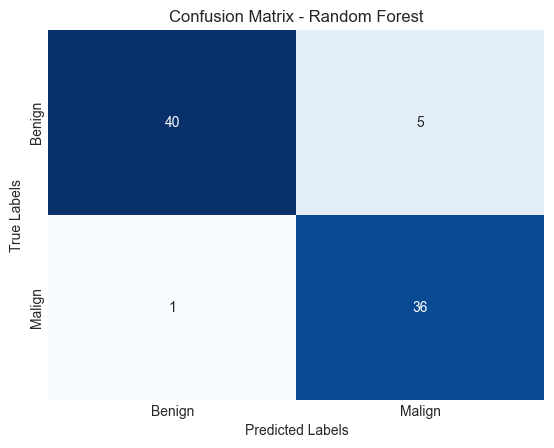

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93        45
           1       0.88      0.97      0.92        37

    accuracy                           0.93        82
   macro avg       0.93      0.93      0.93        82
weighted avg       0.93      0.93      0.93        82

Número do Fold: 2


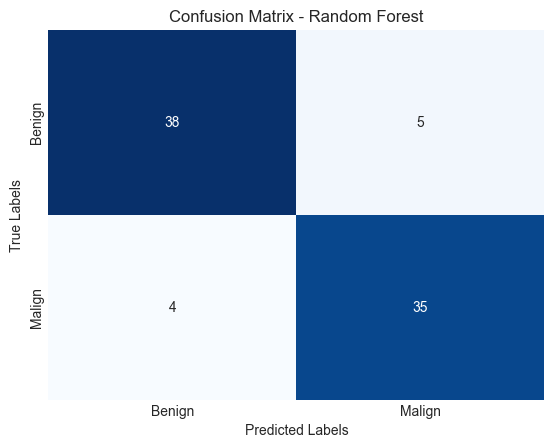

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        43
           1       0.88      0.90      0.89        39

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82

Número do Fold: 3


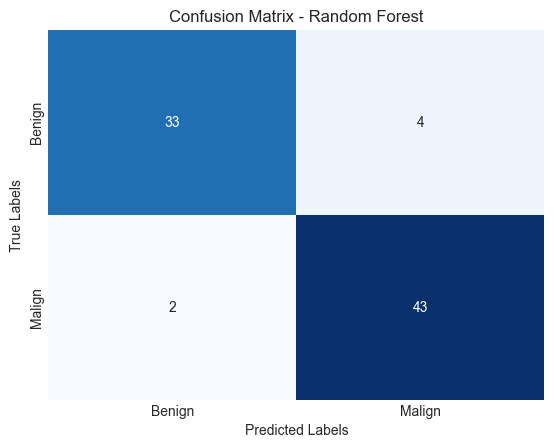

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92        37
           1       0.91      0.96      0.93        45

    accuracy                           0.93        82
   macro avg       0.93      0.92      0.93        82
weighted avg       0.93      0.93      0.93        82

Número do Fold: 4


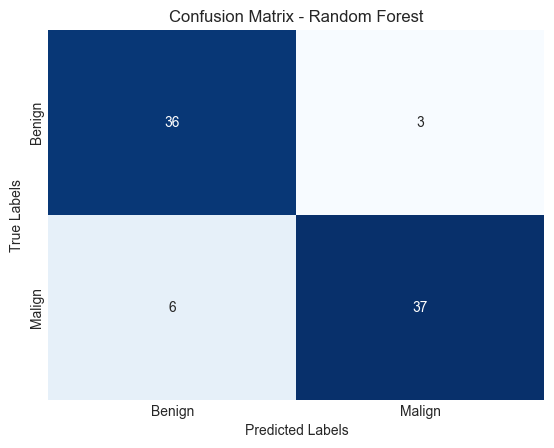

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        39
           1       0.93      0.86      0.89        43

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82

Número do Fold: 5


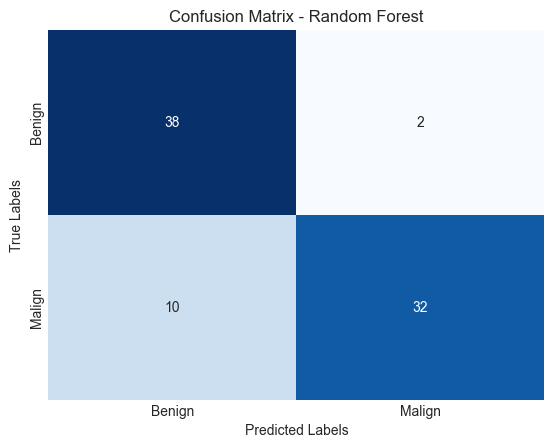

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86        40
           1       0.94      0.76      0.84        42

    accuracy                           0.85        82
   macro avg       0.87      0.86      0.85        82
weighted avg       0.87      0.85      0.85        82



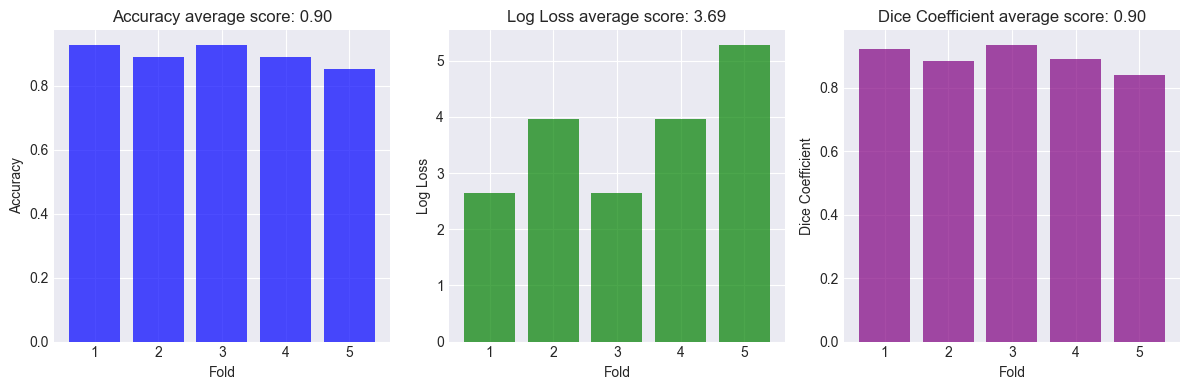

In [68]:
accuracies_3d, log_losses_3d, dice_coefs_3d = random_forest_kfold(fold_3d_pca)
th_rf_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
results_rf_3d.append(average_metrics_3d)

**Random Forest + t-test**<a name = "rf_t_test"></a>

[[Voltar a Random Forest]](#rf)

Repetimos o processo anterior, utilizando este dataset para o treino e teste do modelo Random Forest.

**-> 2D**

In [69]:
data_ttest_2d

Calcification  original_shape2D_Sphericity  \
0                6                     0.116476   
1                6                     0.237705   
2                3                     0.293095   
3                6                     0.145259   
4                3                     0.288620   
..             ...                          ...   
405              6                     0.245244   
406              6                     0.112044   
407              6                     0.138573   
408              6                     0.154955   
409              6                     0.276215   

     original_shape2D_MajorAxisLength  original_shape2D_MaximumDiameter  \
0                           57.542760                         46.615448   
1                           17.090541                         14.317821   
2                            9.244896                          7.615773   
3                           40.718270                         34.205263   
4                           10.327956                          9.055385   
..                                ...                               ...   
405                         13.852837                         11.180340   
406                         61.575217                         53.907328   
407                         51.164214                         43.657760   
408                         41.452617                         32.140317   
409                         12.494295                         10.440307   

     original_shape2D_MinorAxisLength  original_firstorder_TotalEnergy  \
0                           44.910854                      163807321.0   
1                           13.404688                       33000000.0   
2                            5.813537                       13646416.0   
3                           30.919604                       90440738.0   
4                            8.944272                       18000000.0   
..                                ...                              ...   
405                         10.362272                       24000000.0   
406                         39.918046                      157000000.0   
407                         28.723704                      101000000.0   
408                         33.091465                       79000000.0   
409                          8.124406                       21000000.0   

     original_firstorder_Energy  original_shape2D_Perimeter  Spiculation  \
0                   163807321.0                  356.877200            5   
1                    33000000.0                   76.769553            2   
2                    13646416.0                   36.284271            1   
3                    90440738.0                  224.994949            5   
4                    18000000.0                   44.284271            1   
..                          ...                         ...          ...   
405                  24000000.0                   59.597980            1   
406                 157000000.0                  357.948268            2   
407                 101000000.0                  229.521861            1   
408                  79000000.0                  181.580736            1   
409                  21000000.0                   50.526912            1   

     original_shape2D_PixelSurface  ...  \
0                            164.0  ...   
1                             33.0  ...   
2                             14.0  ...   
3                            101.0  ...   
4                             18.0  ...   
..                             ...  ...   
405                           24.0  ...   
406                          157.0  ...   
407                          101.0  ...   
408                           79.0  ...   
409                           21.0  ...   

     original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                        0.912201   
1                                        0.821844   
2            

Número do Fold: 1


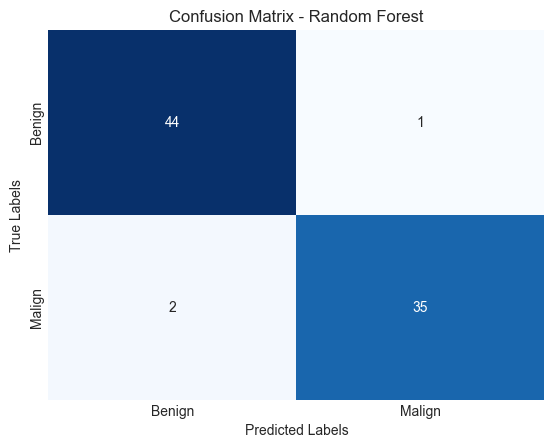

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       0.97      0.95      0.96        37

    accuracy                           0.96        82
   macro avg       0.96      0.96      0.96        82
weighted avg       0.96      0.96      0.96        82

Número do Fold: 2


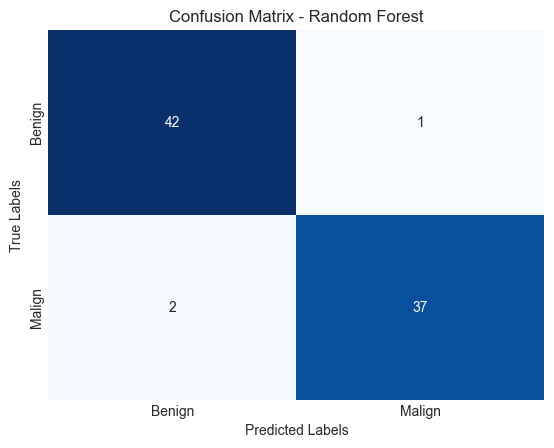

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.97      0.95      0.96        39

    accuracy                           0.96        82
   macro avg       0.96      0.96      0.96        82
weighted avg       0.96      0.96      0.96        82

Número do Fold: 3


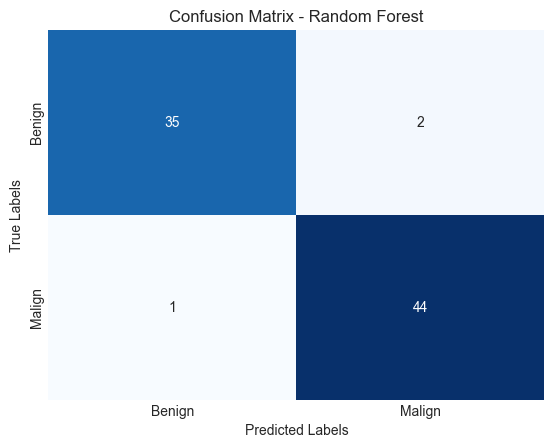

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           1       0.96      0.98      0.97        45

    accuracy                           0.96        82
   macro avg       0.96      0.96      0.96        82
weighted avg       0.96      0.96      0.96        82

Número do Fold: 4


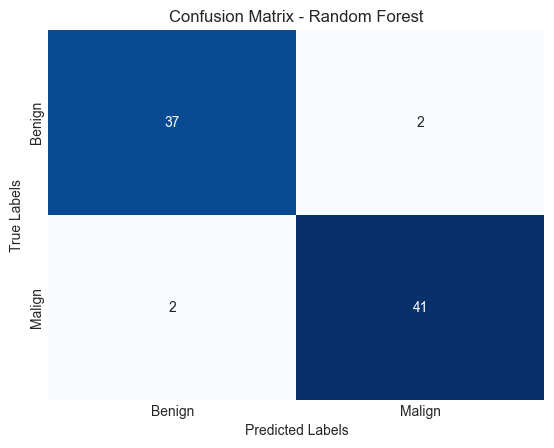

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.95      0.95      0.95        43

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Número do Fold: 5


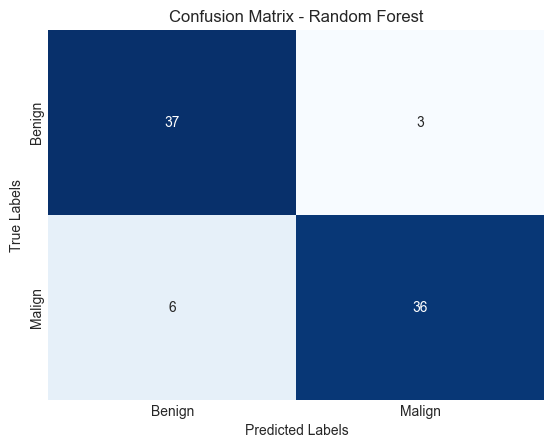

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89        40
           1       0.92      0.86      0.89        42

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82



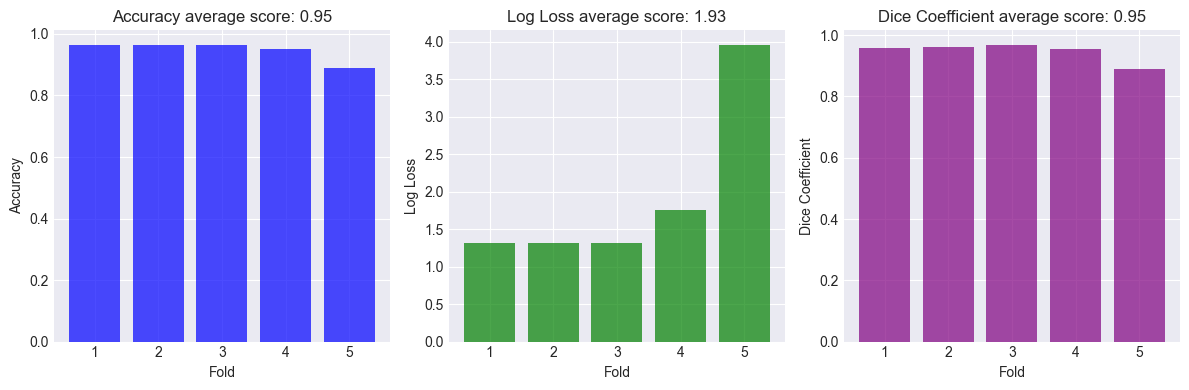

In [70]:
accuracies_2d, log_losses_2d, dice_coefs_2d = random_forest_kfold(fold_2d_ttest)
th_rf_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
results_rf_2d.append(average_metrics_2d)

**-> 3D**

In [71]:
data_ttest_3d

Calcification  Spiculation  Lobulation  Margin  Subtlety  \
0                6            5           3       4         5   
1                6            2           2       3         5   
2                3            1           1       5         2   
3                6            5           1       3         5   
4                3            1           1       5         3   
..             ...          ...         ...     ...       ...   
405              6            1           1       4         3   
406              6            2           2       4         5   
407              6            1           3       4         5   
408              6            1           1       3         5   
409              6            1           1       2         4   

     original_glrlm_GrayLevelNonUniformity  \
0                               757.880362   
1                                88.384615   
2                                34.515260   
3                               437.070150   
4                                33.846154   
..                                     ...   
405                              41.769231   
406                            1239.769231   
407                             573.307692   
408                             444.769231   
409                              47.846154   

     original_glrlm_RunLengthNonUniformity  \
0                               560.437962   
1                                65.418418   
2                                34.624099   
3                               674.745089   
4                                25.277877   
..                                     ...   
405                              30.870197   
406                             950.216242   
407                             411.691071   
408                             314.515156   
409                              40.702319   

     original_gldm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                              931.027689                9.385304e+08   
1                              106.000000                1.060000e+08   
2                               44.017544                5.373786e+07   
3                              534.484914                8.652093e+08   
4                               41.000000                4.100000e+07   
..                                    ...                         ...   
405                             50.000000                5.000000e+07   
406                           1483.000000                1.482982e+09   
407                            704.000000                7.040000e+08   
408                            556.000000                5.560000e+08   
409                             54.000000                5.400000e+07   

     original_firstorder_TotalEnergy  ...  \
0                       9.385304e+08  ...   
1                       1.060000e+08  ...   
2                       5.373786e+07  ...   
3                       8.652093e+08  ...   
4                       4.100000e+07  ...   
..                               ...  ...   
405                     5.000000e+07  ...   
406                     1.482982e+09  ...   
407                     7.040000e+08  ...   
408                     5.560000e+08  ...   
409                     5.400000e+07  ...   

     original_glszm_SmallAreaHighGrayLevelEmphasis  original_glcm_Idmn  \
0                                         6.200000            0.998849   
1                                         0.000089            1.000000   
2                                       135.571486            0.940932   
3                                        59.289969            0.980366   
4                                         0.000595            1.000000   
..                                             ...                 ...   
405                                       0.000400            1.000000   
406                                       0.000433            1.000000   
407                               

Número do Fold: 1


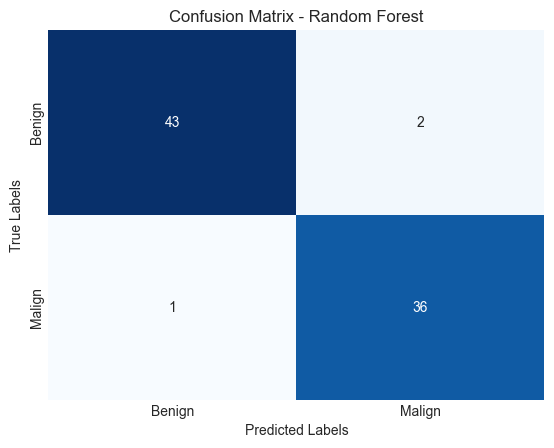

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.95      0.97      0.96        37

    accuracy                           0.96        82
   macro avg       0.96      0.96      0.96        82
weighted avg       0.96      0.96      0.96        82

Número do Fold: 2


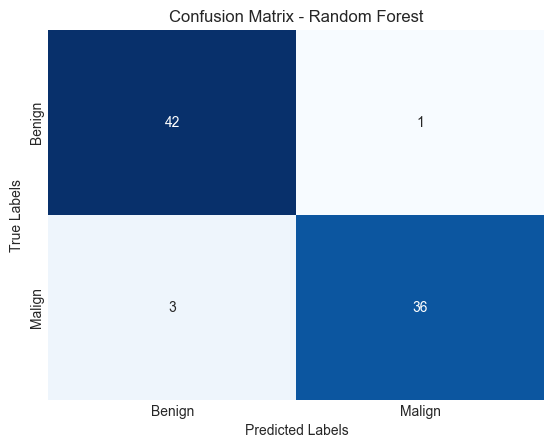

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95        43
           1       0.97      0.92      0.95        39

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Número do Fold: 3


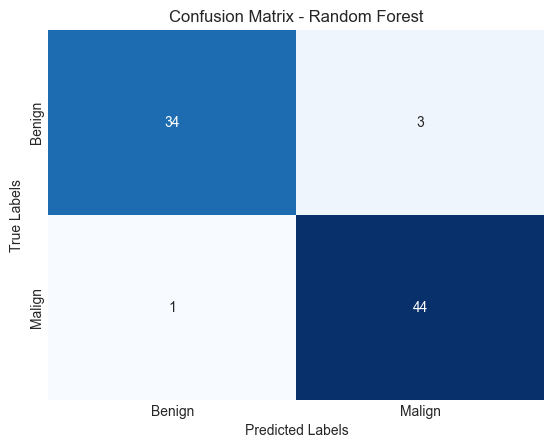

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.94      0.98      0.96        45

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Número do Fold: 4


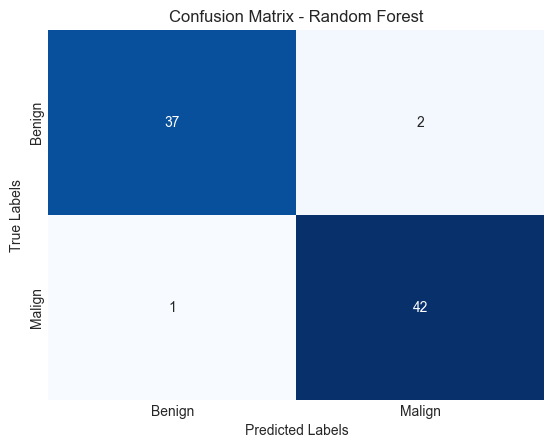

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        39
           1       0.95      0.98      0.97        43

    accuracy                           0.96        82
   macro avg       0.96      0.96      0.96        82
weighted avg       0.96      0.96      0.96        82

Número do Fold: 5


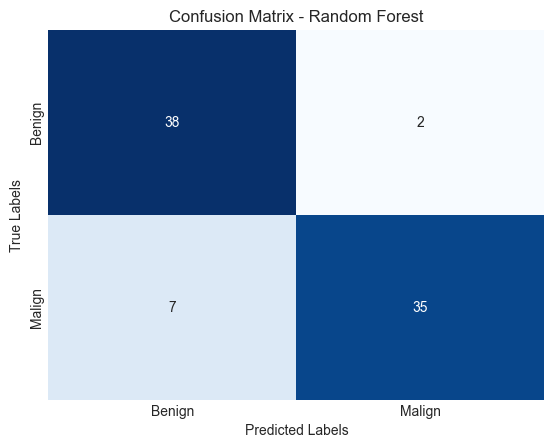

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89        40
           1       0.95      0.83      0.89        42

    accuracy                           0.89        82
   macro avg       0.90      0.89      0.89        82
weighted avg       0.90      0.89      0.89        82



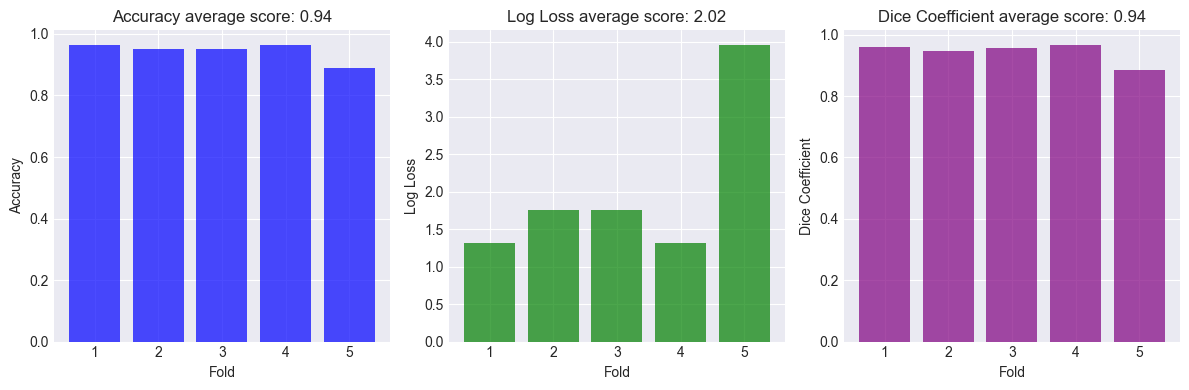

In [72]:
accuracies_3d, log_losses_3d, dice_coefs_3d = random_forest_kfold(fold_3d_ttest)
th_rf_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
results_rf_3d.append(average_metrics_3d)

**Random Forest + Random Forest (seleção de Features)**<a name = "rf_rf"></a>

[[Voltar a Random Forest]](#rf)

Por fim, repetimos o processo para o dataset obtido pelo Random Forest, usado na seleção das features.

**-> 2D**

In [73]:
data_rf_2d

Calcification  Lobulation  Spiculation  \
0                6           3            5   
1                6           2            2   
2                3           1            1   
3                6           1            5   
4                3           1            1   
..             ...         ...          ...   
405              6           1            1   
406              6           2            2   
407              6           3            1   
408              6           1            1   
409              6           1            1   

     original_gldm_GrayLevelNonUniformity  original_shape2D_MajorAxisLength  \
0                              160.036585                         57.542760   
1                               33.000000                         17.090541   
2                               12.142857                          9.244896   
3                               43.079208                         40.718270   
4                               18.000000                         10.327956   
..                                    ...                               ...   
405                             24.000000                         13.852837   
406                            157.000000                         61.575217   
407                            101.000000                         51.164214   
408                             79.000000                         41.452617   
409                             21.000000                         12.494295   

     original_glrlm_GrayLevelNonUniformity  Margin  \
0                               113.551582       4   
1                                24.750000       3   
2                                 9.184343       5   
3                                31.512433       3   
4                                13.500000       5   
..                                     ...     ...   
405                              18.000000       4   
406                             116.000000       4   
407                              73.000000       4   
408                              58.000000       3   
409                              15.500000       2   

     original_firstorder_Energy  original_shape2D_Perimeter  Subtlety  ...  \
0                   163807321.0                  356.877200         5  ...   
1                    33000000.0                   76.769553         5  ...   
2                    13646416.0                   36.284271         2  ...   
3                    90440738.0                  224.994949         5  ...   
4                    18000000.0                   44.284271         3  ...   
..                          ...                         ...       ...  ...   
405                  24000000.0                   59.597980         3  ...   
406                 157000000.0                  357.948268         5  ...   
407                 101000000.0                  229.521861         5  ...   
408                  79000000.0                  181.580736         5  ...   
409                  21000000.0                   50.526912         4  ...   

     Sphericity  original_gldm_LargeDependenceLowGrayLevelEmphasis  Texture  \
0             3                                          11.258299        5   
1             4                                           9.000000        4   
2             2                                           7.643973        5   
3             4                                           5.172723        5   
4             5                                           9.000000        5   
..          ...                                                ...      ...   
405           3                                           9.000000        5   
406           4                                           9.636943        5   
407           3                                          10.524752        5   
408           3                                           9.886076        5   
409           4                     

Número do Fold: 1


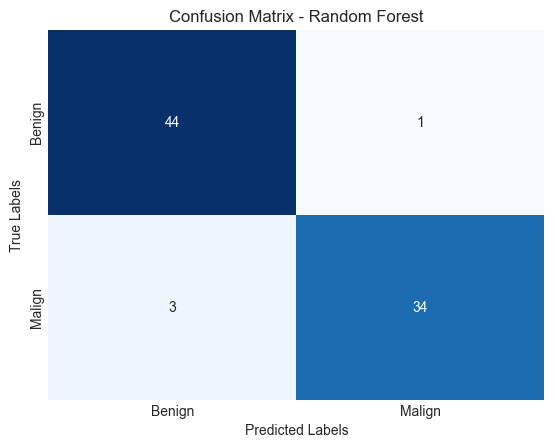

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       0.97      0.92      0.94        37

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Número do Fold: 2


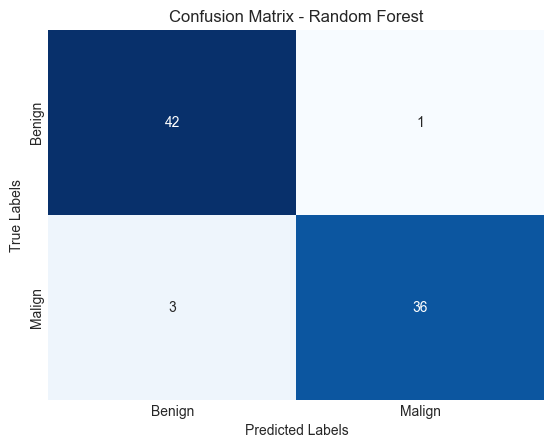

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95        43
           1       0.97      0.92      0.95        39

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Número do Fold: 3


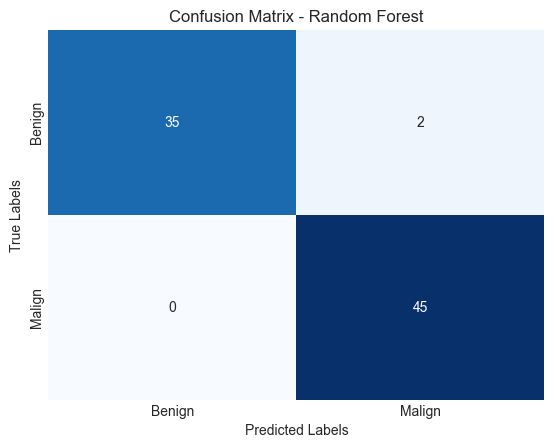

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.96      1.00      0.98        45

    accuracy                           0.98        82
   macro avg       0.98      0.97      0.98        82
weighted avg       0.98      0.98      0.98        82

Número do Fold: 4


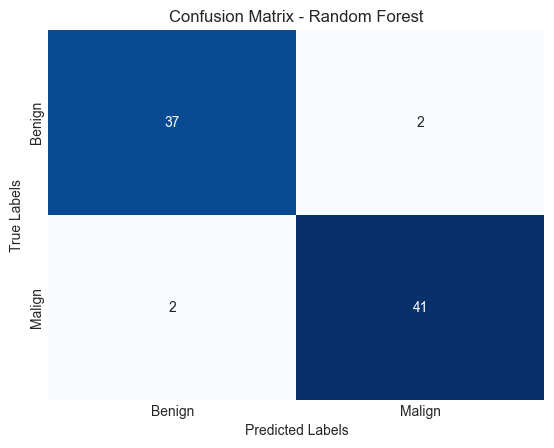

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.95      0.95      0.95        43

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Número do Fold: 5


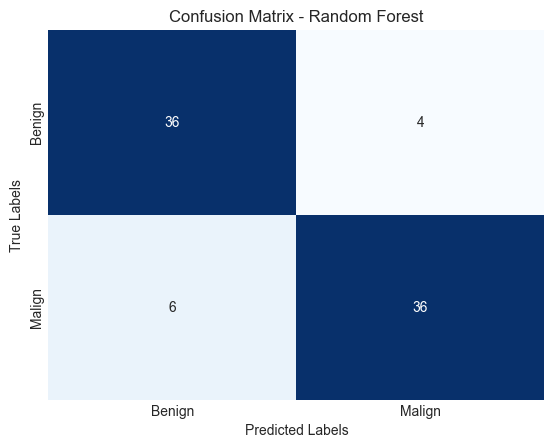

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.90      0.86      0.88        42

    accuracy                           0.88        82
   macro avg       0.88      0.88      0.88        82
weighted avg       0.88      0.88      0.88        82



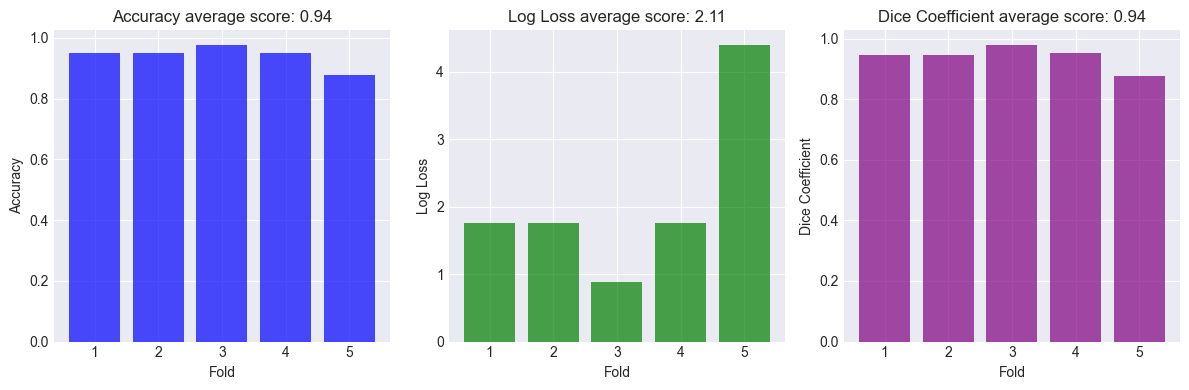

In [74]:
accuracies_2d, log_losses_2d, dice_coefs_2d = random_forest_kfold(fold_2d_rf)
th_rf_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
results_rf_2d.append(average_metrics_2d)

**-> 3D**

In [75]:
data_rf_3d

Calcification  Spiculation  Lobulation  Margin  \
0                6            5           3       4   
1                6            2           2       3   
2                3            1           1       5   
3                6            5           1       3   
4                3            1           1       5   
..             ...          ...         ...     ...   
405              6            1           1       4   
406              6            2           2       4   
407              6            1           3       4   
408              6            1           1       3   
409              6            1           1       2   

     original_glrlm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                               757.880362                9.385304e+08   
1                                88.384615                1.060000e+08   
2                                34.515260                5.373786e+07   
3                               437.070150                8.652093e+08   
4                                33.846154                4.100000e+07   
..                                     ...                         ...   
405                              41.769231                5.000000e+07   
406                            1239.769231                1.482982e+09   
407                             573.307692                7.040000e+08   
408                             444.769231                5.560000e+08   
409                              47.846154                5.400000e+07   

     original_glrlm_RunLengthNonUniformity  Subtlety  \
0                               560.437962         5   
1                                65.418418         5   
2                                34.624099         2   
3                               674.745089         5   
4                                25.277877         3   
..                                     ...       ...   
405                              30.870197         3   
406                             950.216242         5   
407                             411.691071         5   
408                             314.515156         5   
409                              40.702319         4   

     original_gldm_GrayLevelNonUniformity  \
0                              931.027689   
1                              106.000000   
2                               44.017544   
3                              534.484914   
4                               41.000000   
..                                    ...   
405                             50.000000   
406                           1483.000000   
407                            704.000000   
408                            556.000000   
409                             54.000000   

     original_gldm_DependenceNonUniformity  ...  original_ngtdm_Strength  \
0                               155.261981  ...                 0.950551   
1                                26.660377  ...                 0.000000   
2                                 8.929825  ...                13.837206   
3                               134.415948  ...                 4.995332   
4                                13.682927  ...                 0.000000   
..                                     ...  ...                      ...   
405                              19.320000  ...                 0.000000   
406                             324.684423  ...                 0.000000   
407                             112.750000  ...                 0.000000   
408                              90.420863  ...                 0.000000   
409                              19.148148  ...                 0.000000   

     original_glszm_ZoneVariance  original_glszm_GrayLevelVariance  \
0                  139576.960000                          0.640000   
1                       0.000000                          0.000000   
2                     292.122449                         45.346939   
3                    1441.356256                

Número do Fold: 1


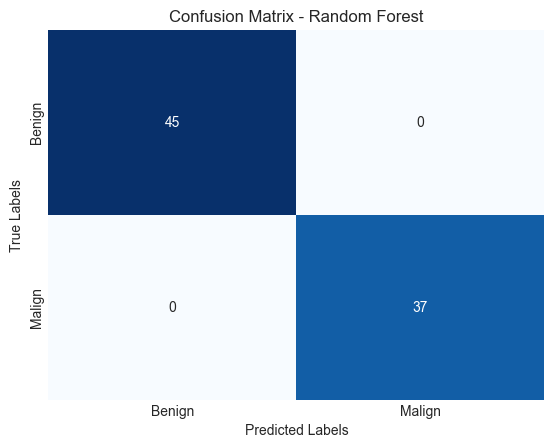

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 2


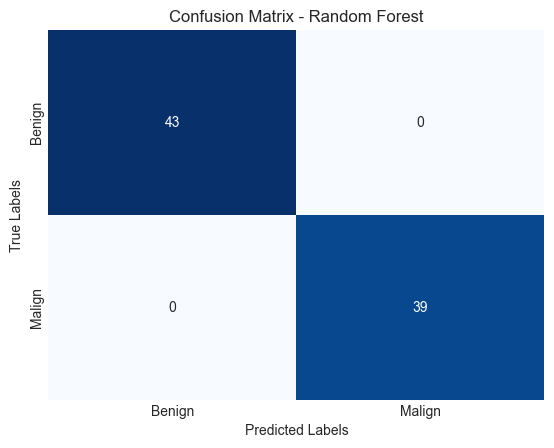

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        39

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 3


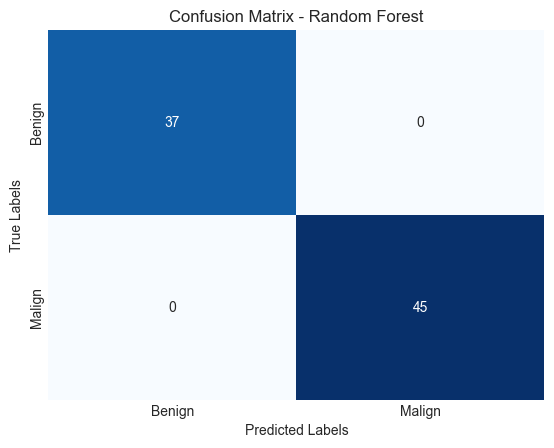

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        45

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 4


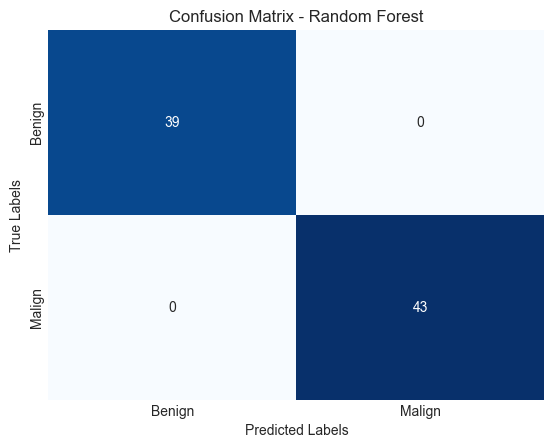

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        43

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número do Fold: 5


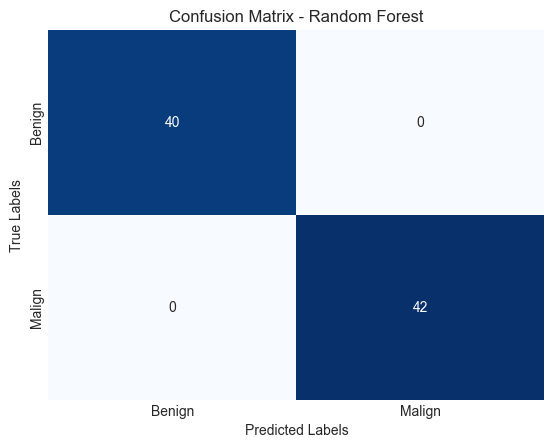

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        42

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



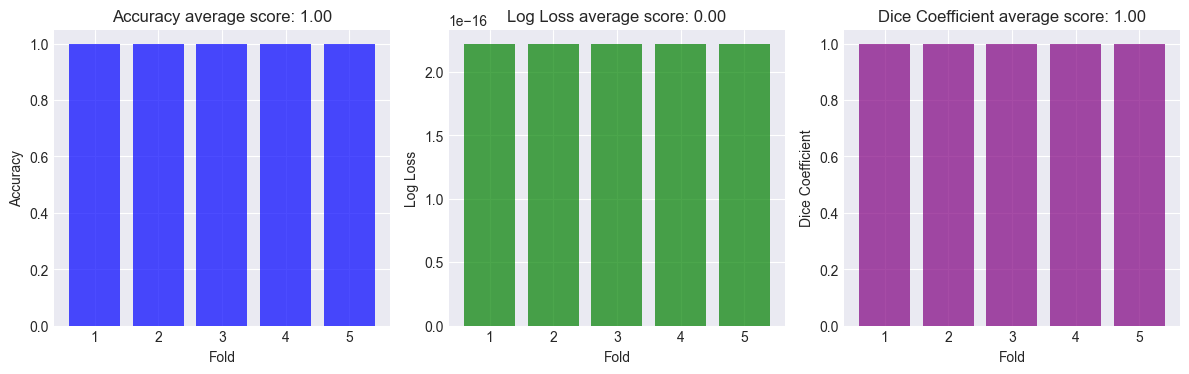

In [76]:
accuracies_3d, log_losses_3d, dice_coefs_3d = random_forest_kfold(fold_3d_rf)
th_rf_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
results_rf_3d.append(average_metrics_3d)

**Resultados Random Forest**<a name = "rf_resultados"></a>

[[Voltar a Random Forest]](#rf)

**-> 2D**

In [77]:
print(results_rf_2d)

[[0.9951219512195122, 0.17582269945910828, 0.9954492566257273], [0.8853658536585366, 4.13183343728904, 0.8890888664025738], [0.9463414634146341, 1.9340496940501886, 0.9458706597285762], [0.9414634146341463, 2.109872393509297, 0.9403221775286242]]


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/3843270632.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


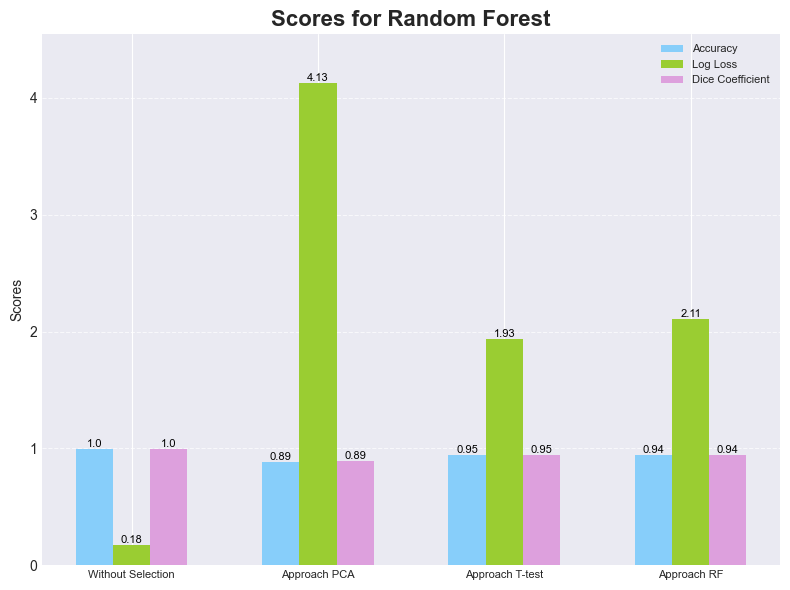

In [78]:
plot_scores(results_rf_2d, "Random Forest")

**-> 3D**

In [79]:
print(results_rf_3d)

[[0.9951219512195122, 0.17582269945910828, 0.9956521739130434], [0.8975609756097562, 3.692276688641269, 0.8955214018715599], [0.9439024390243903, 2.0219610437797426, 0.9430966701858932], [1.0, 2.2204460492503136e-16, 1.0]]


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/3843270632.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


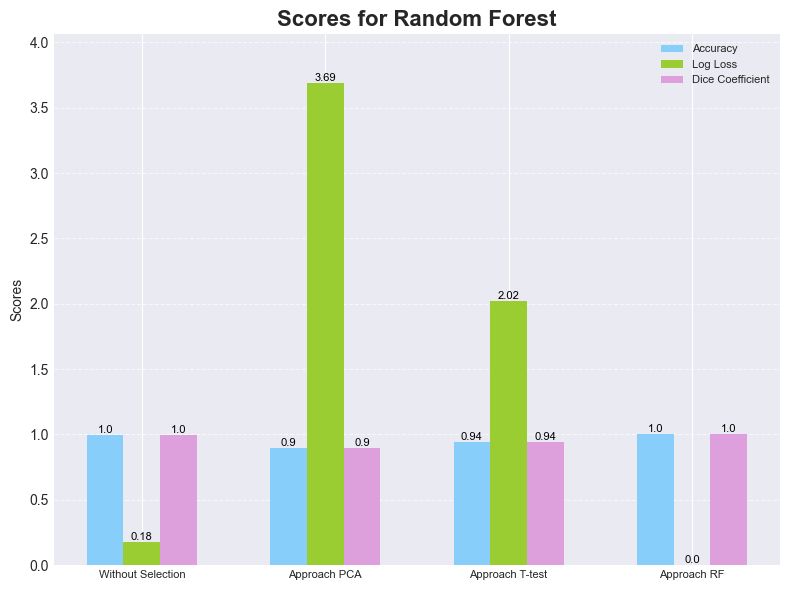

In [80]:
plot_scores(results_rf_3d, "Random Forest")

### **XGBoost** <a name = "xgboost"></a>
[[Voltar a Training Models]](#tm)

O  XGBoost (Extreme Gradient Boosting) é utilizado como um modelo de classificação para prever labels de uma variável alvo y (neste caso a malignancy) a partir do input. O XGBoost é um algoritmo baseado em boosting, uma técnica de machine learning que combina vários modelos fracos (normalmente árvores de decisão) numa previsão mais robusta.

Código que iremos usar para treinar os modelos:

In [81]:
def xgboots_k_fold(fold, k=5, random_state=42):
    
    accuracies = []
    log_losses = []
    dice_coefs = []
    
    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    n_fold = 1
    for X_train, X_test, y_train, y_test in fold:
        print(f"Número de Fold: {n_fold}")
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        acc, logloss, dice = metrics_testing(y_test, predictions, "XGBoost")
        accuracies.append(acc)
        log_losses.append(logloss)
        dice_coefs.append(dice)
        n_fold +=1 

    return accuracies, log_losses, dice_coefs

In [82]:
results_xgb_2d = []
results_xgb_3d = []
th_xgb_2d = []
th_xgb_3d =[]

**XGBoost sem seleção de features**<a name = "xgboost_sem_selecao"></a>

[[Voltar a XGBoost]](#xgboost)

**-> 2D**

In [83]:
data_2d

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0              5           3           3       4         5        5   
1              2           2           4       3         5        4   
2              1           1           2       5         2        5   
3              5           1           4       3         5        5   
4              1           1           5       5         3        5   
..           ...         ...         ...     ...       ...      ...   
405            1           1           3       4         3        5   
406            2           2           4       4         5        5   
407            1           3           3       4         5        5   
408            1           1           3       3         5        5   
409            1           1           4       2         4        5   

     Calcification  Malignancy  diagnostics_Image-original_Maximum  \
0                6           1                               400.0   
1                6           1                               400.0   
2                3           0                               185.0   
3                6           1                               400.0   
4                3           0                               400.0   
..             ...         ...                                 ...   
405              6           0                               400.0   
406              6           1                               400.0   
407              6           1                               241.0   
408              6           1                               238.0   
409              6           0                               245.0   

     original_shape2D_Elongation  ...  \
0                       0.780478  ...   
1                       0.784334  ...   
2                       0.628837  ...   
3                       0.759355  ...   
4                       0.866025  ...   
..                           ...  ...   
405                     0.748025  ...   
406                     0.648281  ...   
407                     0.561402  ...   
408                     0.798296  ...   
409                     0.650249  ...   

     original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                            11.258299   
1                                             9.000000   
2                                             7.643973   
3                                             5.172723   
4                                             9.000000   
..                                                 ...   
405                                           9.000000   
406                                           9.636943   
407                                          10.524752   
408                                           9.886076   
409                                           9.666667   

     original_gldm_LowGrayLevelEmphasis  \
0                              0.990007   
1                              1.000000   
2                              0.929688   
3                              0.665108   
4                              1.000000   
..                                  ...   
405                            1.000000   
406                            1.000000   
407                            1.000000   
408                            1.000000   
409                            1.000000   

     original_gldm_SmallDependenceEmphasis  \
0                                 0.111187   
1                                 0.111111   
2                                 0.194444   
3                                 0.406474   
4                                 0.111111   
..                                     ...   
405                               0.111111   
406                               0.106943   
407                               0.100523   
408                               0.104958   
409                               0.106481   

     original_gldm_SmallDependenceHighGrayLevelEmph

Número de Fold: 1


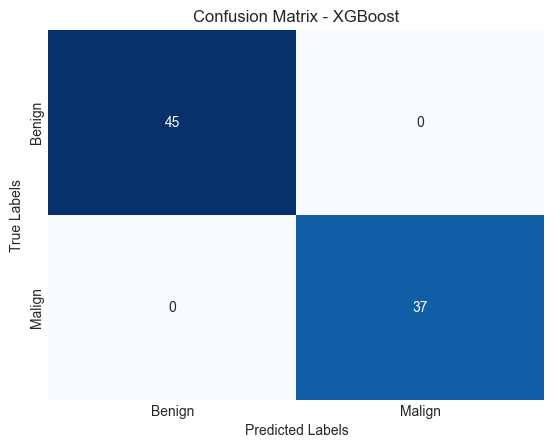

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 2


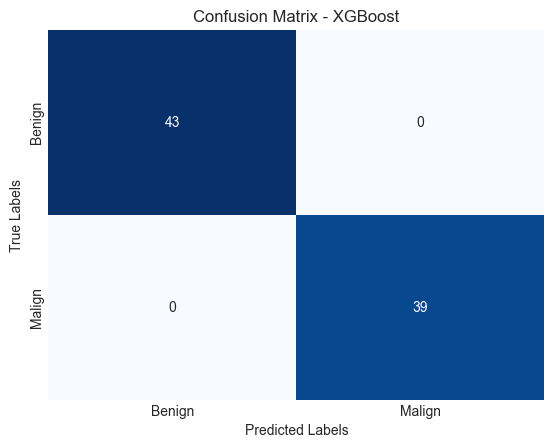

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        39

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 3


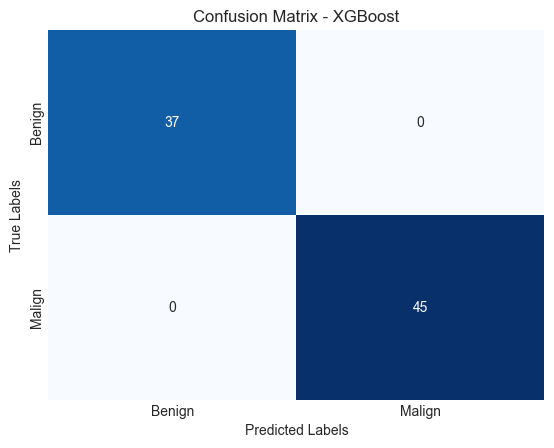

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        45

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 4


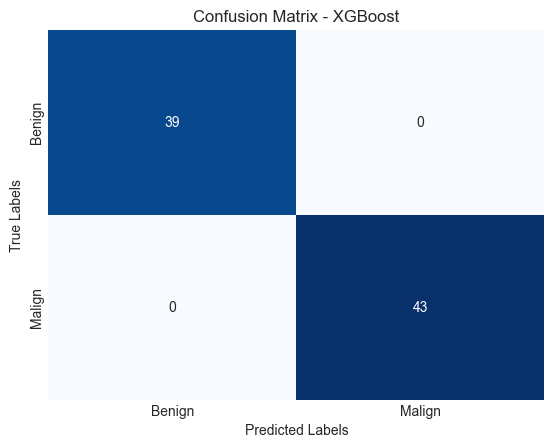

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        43

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 5


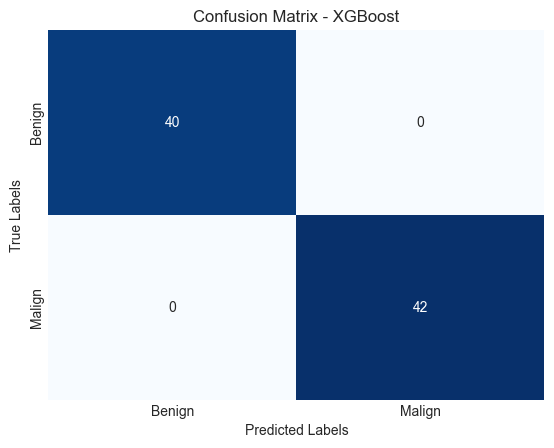

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        42

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



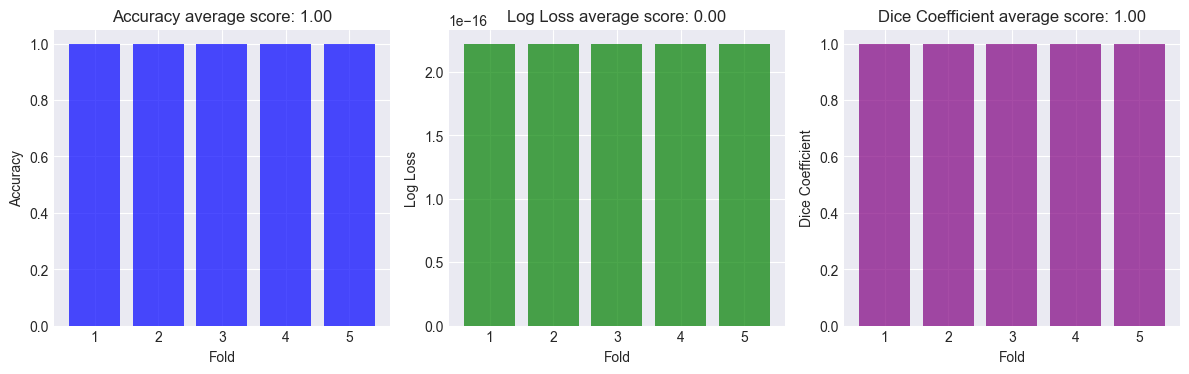

[1.0, 2.2204460492503136e-16, 1.0]


In [84]:
accuracies_2d, log_losses_2d, dice_coefs_2d = xgboots_k_fold(fold_2d)
th_xgb_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
print(average_metrics_2d)
results_xgb_2d.append(average_metrics_2d)

**-> 3D**

In [85]:
data_3d

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0              5           3           3       4         5        5   
1              2           2           4       3         5        4   
2              1           1           2       5         2        5   
3              5           1           4       3         5        5   
4              1           1           5       5         3        5   
..           ...         ...         ...     ...       ...      ...   
405            1           1           3       4         3        5   
406            2           2           4       4         5        5   
407            1           3           3       4         5        5   
408            1           1           3       3         5        5   
409            1           1           4       2         4        5   

     Calcification  Malignancy  diagnostics_Image-original_Maximum  \
0                6           1                               400.0   
1                6           1                               400.0   
2                3           0                               400.0   
3                6           1                               400.0   
4                3           0                               400.0   
..             ...         ...                                 ...   
405              6           0                               400.0   
406              6           1                               400.0   
407              6           1                               400.0   
408              6           1                               400.0   
409              6           0                               400.0   

     original_firstorder_90Percentile  ...  original_ngtdm_Coarseness  \
0                             -1000.0  ...                   0.284191   
1                             -1000.0  ...             1000000.000000   
2                              -902.4  ...                   0.015397   
3                              -845.5  ...                   0.002780   
4                             -1000.0  ...             1000000.000000   
..                                ...  ...                        ...   
405                           -1000.0  ...             1000000.000000   
406                           -1000.0  ...             1000000.000000   
407                           -1000.0  ...             1000000.000000   
408                           -1000.0  ...             1000000.000000   
409                           -1000.0  ...             1000000.000000   

     original_ngtdm_Complexity  original_ngtdm_Contrast  \
0                     0.032596                 0.000051   
1                     0.000000                 0.000000   
2                   200.108114                 1.744897   
3                   400.910706                 0.059704   
4                     0.000000                 0.000000   
..                         ...                      ...   
405                   0.000000                 0.000000   
406                   0.000000                 0.000000   
407                   0.000000                 0.000000   
408                   0.000000                 0.000000   
409                   0.000000                 0.000000   

     original_ngtdm_Strength  diagnostics_Image-original_Size_x  \
0                   0.950551                              133.0   
1                   0.000000                              140.0   
2                  13.837206                              241.0   
3                   4.995332                              145.0   
4                   0.000000                              128.0   
..                       ...                                ...   
405                 0.000000                              186.0   
406                 0.000000                              186.0   
407                 0.000000                              133.0   
408                 0.000000                           

Número de Fold: 1


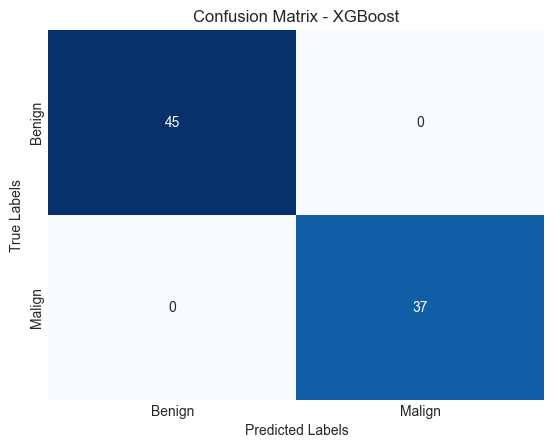

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 2


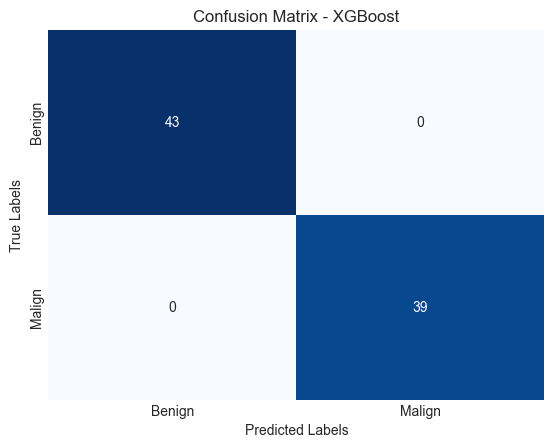

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        39

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 3


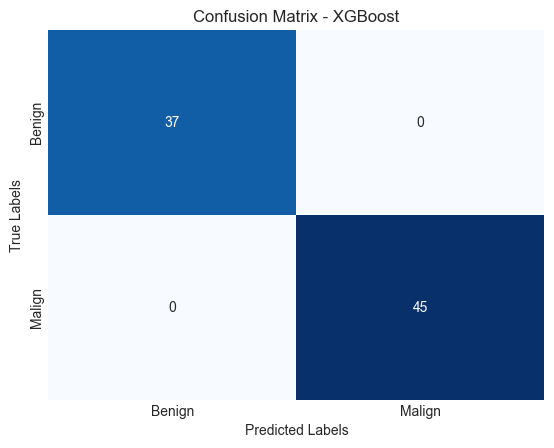

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        45

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 4


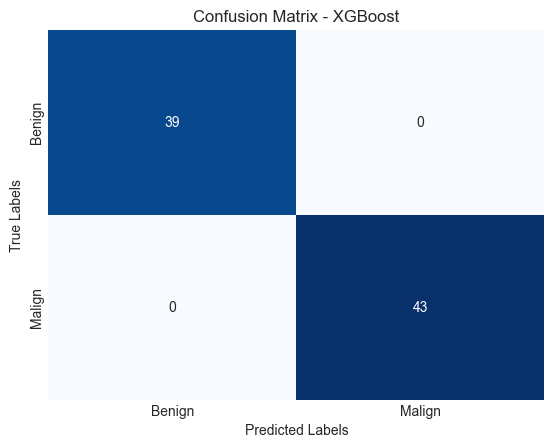

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        43

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 5


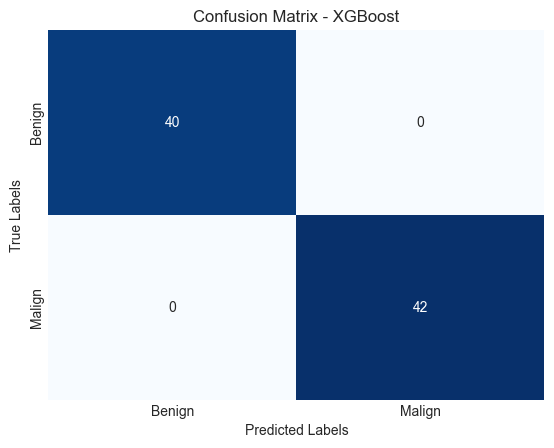

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        42

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



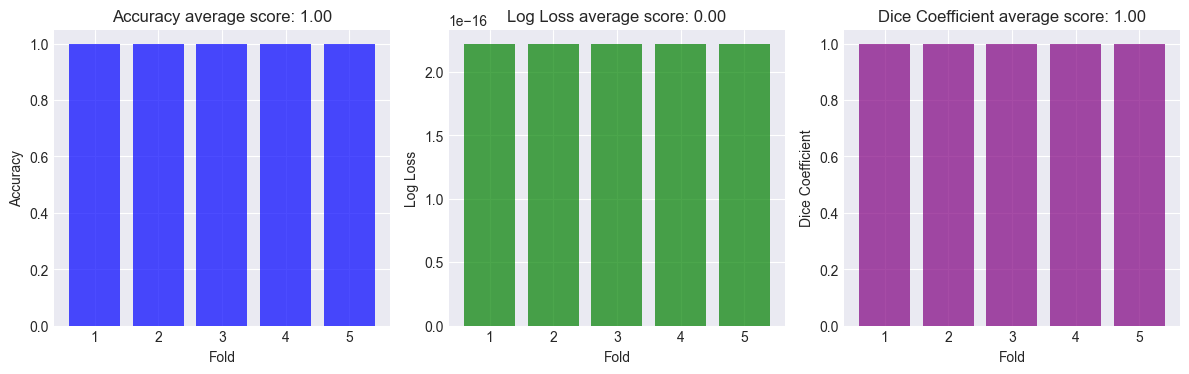

[1.0, 2.2204460492503136e-16, 1.0]


In [86]:
accuracies_3d, log_losses_3d, dice_coefs_3d = xgboots_k_fold(fold_3d)
th_xgb_3d.append([accuracies_3d,log_losses_3d,dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
print(average_metrics_3d)
results_xgb_3d.append(average_metrics_3d)

**XGBoost + PCA**<a name = "xgboost_pca"></a>

[[Voltar a XGBoost]](#xgboost)

Iremos agora passar à implementação do modelo XGBoost, usando o dataset preparado a partir do método de Principal Component Analysis, data_pca.

**-> 2D**

In [87]:
data_pca_2d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     0.605527  14.312994  2.618862 -5.010918 -1.873619  0.486000  3.780943   
1    -2.267379  -1.819947  0.040090  0.846899 -1.514118 -0.992908 -0.811545   
2     5.058170  -2.480426 -3.601613 -4.459463 -1.977084 -3.833077  1.266602   
3    26.065083   6.727777 -6.985184  4.449976 -1.804223  1.655932 -2.786482   
4    -2.158470  -3.958437 -0.673922  0.104410  1.383675 -1.097692  0.958196   
..         ...        ...       ...       ...       ...       ...       ...   
405  -2.233398  -2.998710 -0.378282  0.497056 -0.144041 -1.423559 -0.648699   
406  -2.923210  11.711044  5.856770  4.536946  0.801008 -0.007470  1.331167   
407  -2.716925   5.627624  3.129216  2.034017 -1.944248  1.328403  0.538597   
408  -2.511517   3.152825  2.056172  1.597862 -1.588072  0.221263  0.574015   
409  -2.493756  -2.801108 -0.163597 -0.006073  0.120255  1.392496 -1.301845   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0    4.509357 -3.000581  2.485737  0.280072  1.281586 -1.161818  2.506096   
1    0.548039 -0.191325  0.474135  0.777253  0.522630 -0.555025 -0.525174   
2    3.487037  0.174202 -3.689468 -2.493443 -2.397851  2.413588 -1.744844   
3   -3.047505  1.827419  1.127816  1.851693  0.324629 -2.575421  1.917357   
4   -0.653246  0.245743  0.075601 -0.395550  0.432105 -0.498446 -0.096061   
..        ...       ...       ...       ...       ...       ...       ...   
405  0.289676  0.122413  0.325009 -0.998632 -0.439882 -0.165449  0.604338   
406 -1.196007  0.614933 -2.745411 -1.343567 -0.232678  0.409916 -1.701848   
407 -0.491240  0.276382 -0.707462 -0.799203 -1.466120  0.316186 -0.732913   
408 -0.519261  0.386101 -0.228512 -0.288422  0.197071 -0.046711  0.199059   
409  0.218497 -0.266445  0.052311 -0.835398 -0.070959  0.625990 -0.076007   

         PC14      PC15      PC16      PC17  
0   -1.418022 -0.960150  0.979622 -2.705202  
1    0.099056 -0.658362 -0.094486 -0.035771  
2    2.832277  4.918582 -0.709808  0.405147  
3    1.008172  2.188989 -2.696890 -2.489348  
4    0.030861  0.062598 -0.281642 -0.444985  
..        ...       ...       ...       ...  
405 -0.485219  0.312282 -0.701358  0.533368  
406 -1.518696 -0.590536 -0.523272  0.608692  
407  0.573080 -0.718251  0.112633  0.807437  
408  0.393201  0.331136 -0.147753  0.826526  
409  0.689238 -0.565327 -1.269216 -0.252564  

[410 rows x 18 columns]

Número de Fold: 1


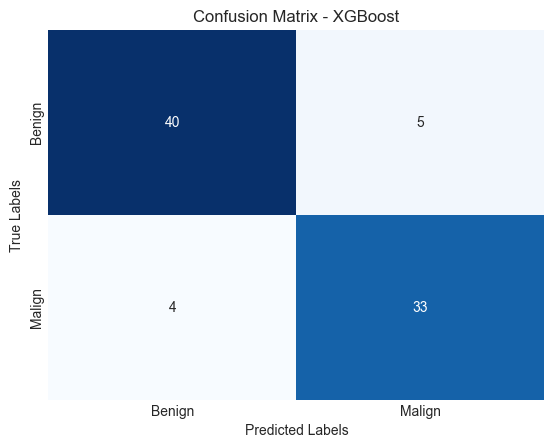

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        45
           1       0.87      0.89      0.88        37

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82

Número de Fold: 2


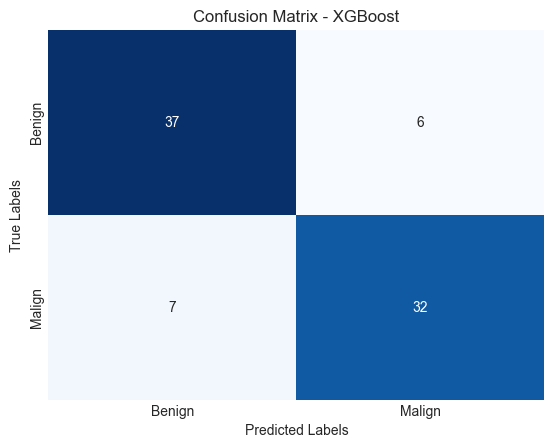

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85        43
           1       0.84      0.82      0.83        39

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82

Número de Fold: 3


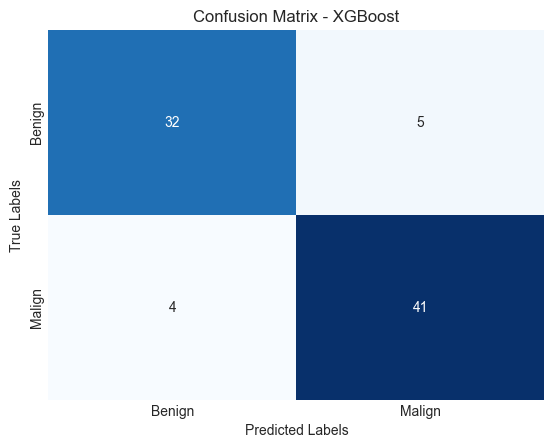

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        37
           1       0.89      0.91      0.90        45

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82

Número de Fold: 4


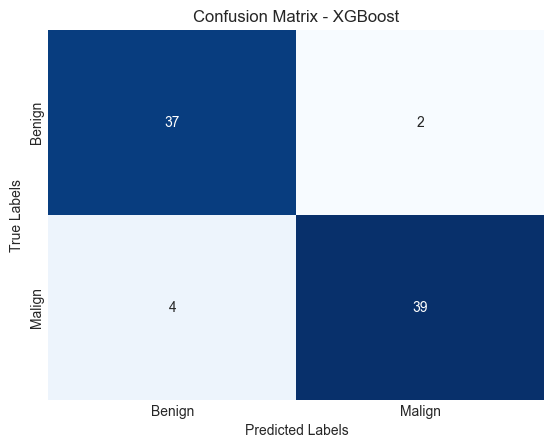

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        39
           1       0.95      0.91      0.93        43

    accuracy                           0.93        82
   macro avg       0.93      0.93      0.93        82
weighted avg       0.93      0.93      0.93        82

Número de Fold: 5


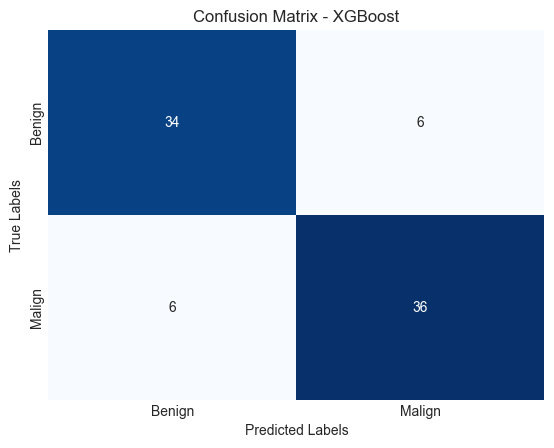

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        40
           1       0.86      0.86      0.86        42

    accuracy                           0.85        82
   macro avg       0.85      0.85      0.85        82
weighted avg       0.85      0.85      0.85        82



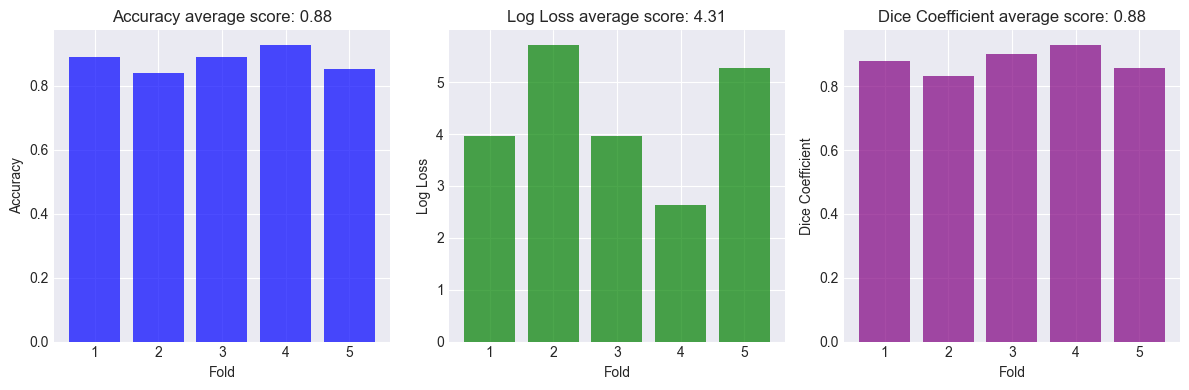

In [88]:
accuracies_2d, log_losses_2d, dice_coefs_2d = xgboots_k_fold(fold_2d_pca)
th_xgb_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
results_xgb_2d.append(average_metrics_2d)

**-> 3D**

In [89]:
data_pca_3d

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0    -0.782122 -4.117717  1.807559  3.238631 -2.126003  0.470964  0.041700   
1    -2.459356  2.218242 -1.818623  2.089689  0.356737  1.117322 -0.424158   
2    13.960910  0.629641 -1.754254 -1.768815 -1.563777 -2.868636 -2.049989   
3    18.196420 -6.671389 -6.882279  1.530733  2.834788  2.809031 -2.197428   
4    -2.639728  3.325768 -2.169896  0.994315 -0.182417 -0.915270  1.220950   
..         ...       ...       ...       ...       ...       ...       ...   
405  -2.682271  3.198533 -2.295293  1.549300  0.057934 -0.301314  0.212454   
406  -2.269498 -5.455861  4.720836  7.225682  2.834643 -3.934610  3.135748   
407  -2.505729 -0.167273  0.442583  2.612708  2.009912  0.850195 -0.439097   
408  -2.686433  0.246159  0.531057  1.261710  1.665685  0.842926 -0.394356   
409  -2.196771  3.355261 -3.609834  4.514218 -0.464621  0.370936  0.322757   

          PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
0   -1.212518 -0.228025  1.411878 -0.530644  1.524379 -0.798404  0.067431   
1   -0.750689 -0.455177  0.237690 -0.714090  0.125701  0.490875 -0.677164   
2   -1.101771 -1.360056 -1.208177  2.233130 -1.096977 -0.204871  1.030177   
3    2.412911  1.963906 -0.768023 -0.338130  1.216001 -1.849959 -0.957012   
4    1.471481  0.151494 -0.920283  0.172468  0.007311 -0.018462 -0.373399   
..        ...       ...       ...       ...       ...       ...       ...   
405 -0.055443  0.960588 -1.390132  0.633414  0.079036 -0.302349  0.407926   
406 -0.186134  0.601032 -0.219536 -2.956456  1.584095  0.692787 -0.379135   
407  0.373260 -1.719275  0.402296  0.098159  0.101775 -0.011177  0.503033   
408  0.287286 -1.063678  0.383723 -0.668447 -0.059399  0.229292  1.453432   
409 -0.490927  1.152616 -0.312397 -0.888086 -0.959875 -0.120866 -0.603711   

         PC14      PC15      PC16      PC17  
0   -0.760704 -0.172903 -0.736586  0.546235  
1    0.364775  0.472962  0.032435 -0.078665  
2   -0.446237 -0.879446  1.539749  0.138501  
3    0.842149  2.095163  2.042272  1.706045  
4   -0.122091  0.597927 -0.449477  0.197056  
..        ...       ...       ...       ...  
405 -0.701345 -0.262880  0.509413  0.069574  
406  0.373656 -0.605389  3.768712 -1.100696  
407 -0.334766 -0.264869 -0.247467 -0.241055  
408  0.633321 -0.060945 -0.111980  0.072243  
409  0.670398 -0.536214  0.393547  0.594748  

[410 rows x 18 columns]

Número de Fold: 1


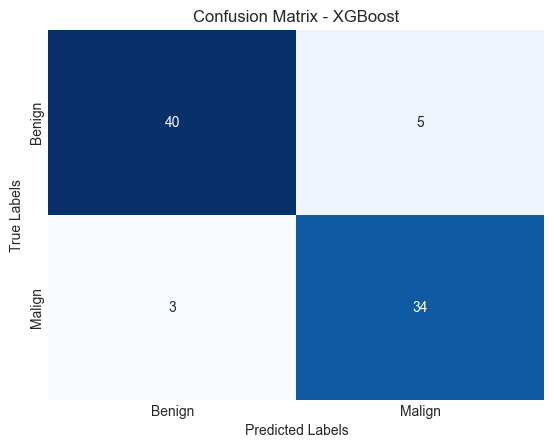

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91        45
           1       0.87      0.92      0.89        37

    accuracy                           0.90        82
   macro avg       0.90      0.90      0.90        82
weighted avg       0.90      0.90      0.90        82

Número de Fold: 2


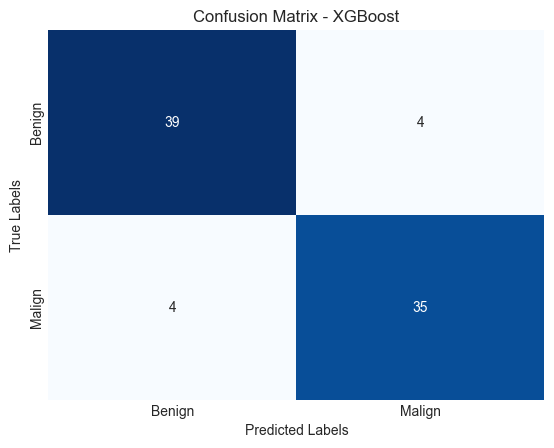

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        43
           1       0.90      0.90      0.90        39

    accuracy                           0.90        82
   macro avg       0.90      0.90      0.90        82
weighted avg       0.90      0.90      0.90        82

Número de Fold: 3


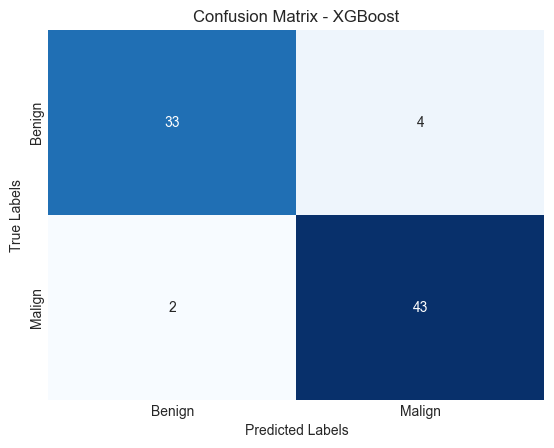

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92        37
           1       0.91      0.96      0.93        45

    accuracy                           0.93        82
   macro avg       0.93      0.92      0.93        82
weighted avg       0.93      0.93      0.93        82

Número de Fold: 4


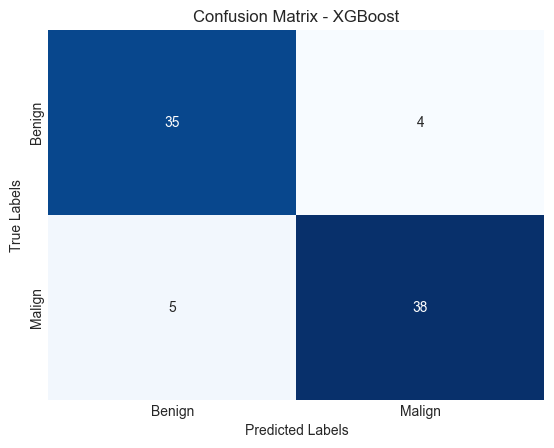

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        39
           1       0.90      0.88      0.89        43

    accuracy                           0.89        82
   macro avg       0.89      0.89      0.89        82
weighted avg       0.89      0.89      0.89        82

Número de Fold: 5


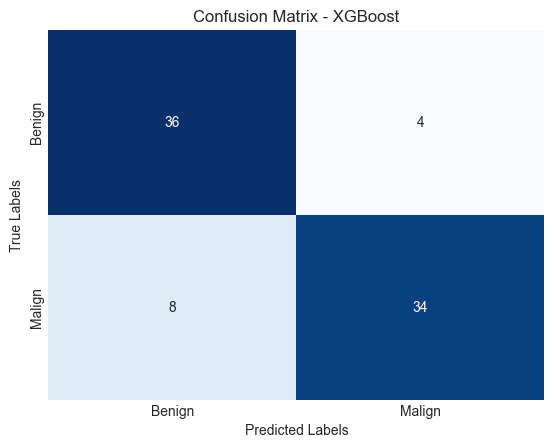

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        40
           1       0.89      0.81      0.85        42

    accuracy                           0.85        82
   macro avg       0.86      0.85      0.85        82
weighted avg       0.86      0.85      0.85        82



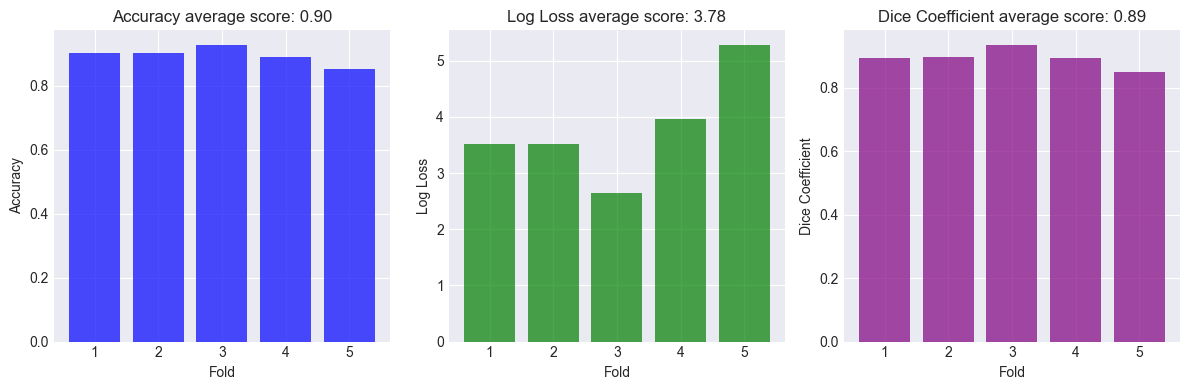

In [90]:
accuracies_3d, log_losses_3d, dice_coefs_3d = xgboots_k_fold(fold_3d_pca)
th_xgb_3d.append([accuracies_3d,log_losses_3d, dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
results_xgb_3d.append(average_metrics_3d)

**XGBoost + t-test** <a name = "xgboost_t_test"></a>

[[Voltar a XGBoost]](#xgboost)

Repetimos agora o processo para o dataset obtido pelo t-test.

**-> 2D**

In [91]:
data_ttest_2d

Calcification  original_shape2D_Sphericity  \
0                6                     0.116476   
1                6                     0.237705   
2                3                     0.293095   
3                6                     0.145259   
4                3                     0.288620   
..             ...                          ...   
405              6                     0.245244   
406              6                     0.112044   
407              6                     0.138573   
408              6                     0.154955   
409              6                     0.276215   

     original_shape2D_MajorAxisLength  original_shape2D_MaximumDiameter  \
0                           57.542760                         46.615448   
1                           17.090541                         14.317821   
2                            9.244896                          7.615773   
3                           40.718270                         34.205263   
4                           10.327956                          9.055385   
..                                ...                               ...   
405                         13.852837                         11.180340   
406                         61.575217                         53.907328   
407                         51.164214                         43.657760   
408                         41.452617                         32.140317   
409                         12.494295                         10.440307   

     original_shape2D_MinorAxisLength  original_firstorder_TotalEnergy  \
0                           44.910854                      163807321.0   
1                           13.404688                       33000000.0   
2                            5.813537                       13646416.0   
3                           30.919604                       90440738.0   
4                            8.944272                       18000000.0   
..                                ...                              ...   
405                         10.362272                       24000000.0   
406                         39.918046                      157000000.0   
407                         28.723704                      101000000.0   
408                         33.091465                       79000000.0   
409                          8.124406                       21000000.0   

     original_firstorder_Energy  original_shape2D_Perimeter  Spiculation  \
0                   163807321.0                  356.877200            5   
1                    33000000.0                   76.769553            2   
2                    13646416.0                   36.284271            1   
3                    90440738.0                  224.994949            5   
4                    18000000.0                   44.284271            1   
..                          ...                         ...          ...   
405                  24000000.0                   59.597980            1   
406                 157000000.0                  357.948268            2   
407                 101000000.0                  229.521861            1   
408                  79000000.0                  181.580736            1   
409                  21000000.0                   50.526912            1   

     original_shape2D_PixelSurface  ...  \
0                            164.0  ...   
1                             33.0  ...   
2                             14.0  ...   
3                            101.0  ...   
4                             18.0  ...   
..                             ...  ...   
405                           24.0  ...   
406                          157.0  ...   
407                          101.0  ...   
408                           79.0  ...   
409                           21.0  ...   

     original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                        0.912201   
1                                        0.821844   
2            

Número de Fold: 1


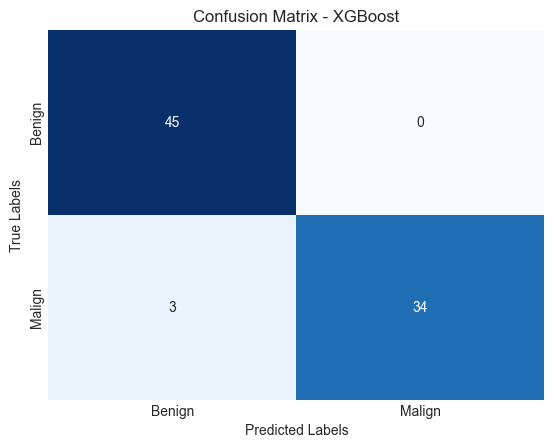

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        45
           1       1.00      0.92      0.96        37

    accuracy                           0.96        82
   macro avg       0.97      0.96      0.96        82
weighted avg       0.97      0.96      0.96        82

Número de Fold: 2


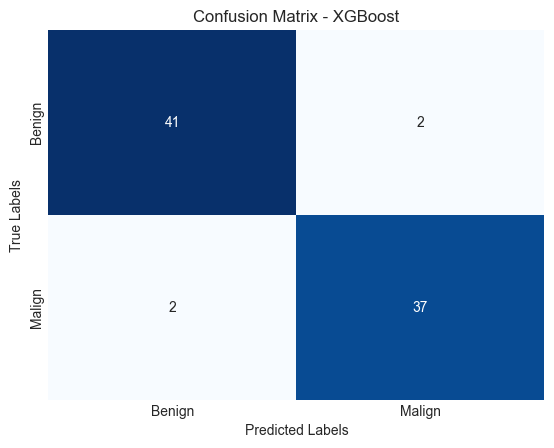

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.95      0.95      0.95        39

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82

Número de Fold: 3


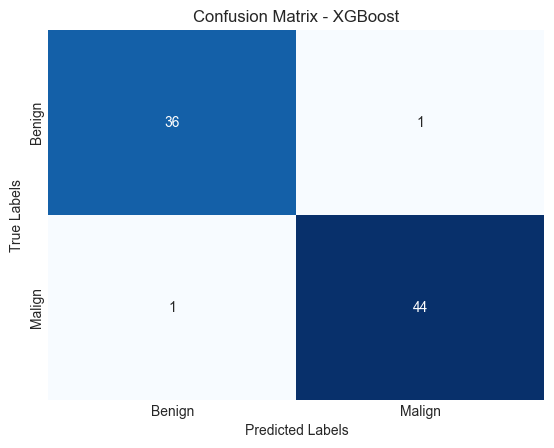

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        37
           1       0.98      0.98      0.98        45

    accuracy                           0.98        82
   macro avg       0.98      0.98      0.98        82
weighted avg       0.98      0.98      0.98        82

Número de Fold: 4


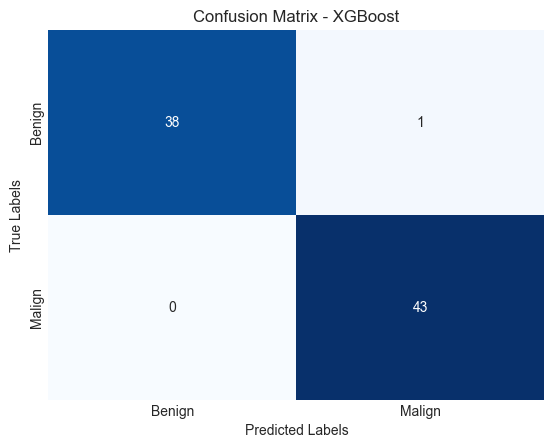

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       0.98      1.00      0.99        43

    accuracy                           0.99        82
   macro avg       0.99      0.99      0.99        82
weighted avg       0.99      0.99      0.99        82

Número de Fold: 5


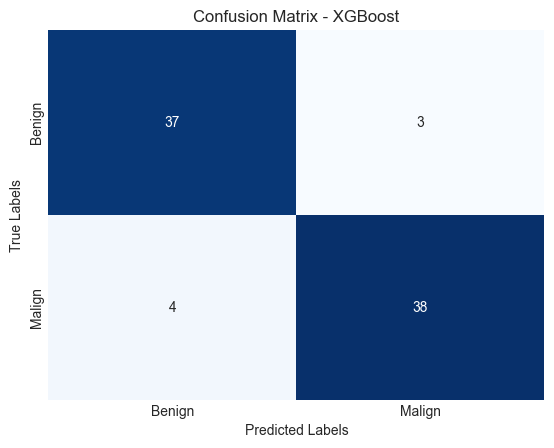

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.93      0.90      0.92        42

    accuracy                           0.91        82
   macro avg       0.91      0.91      0.91        82
weighted avg       0.91      0.91      0.91        82



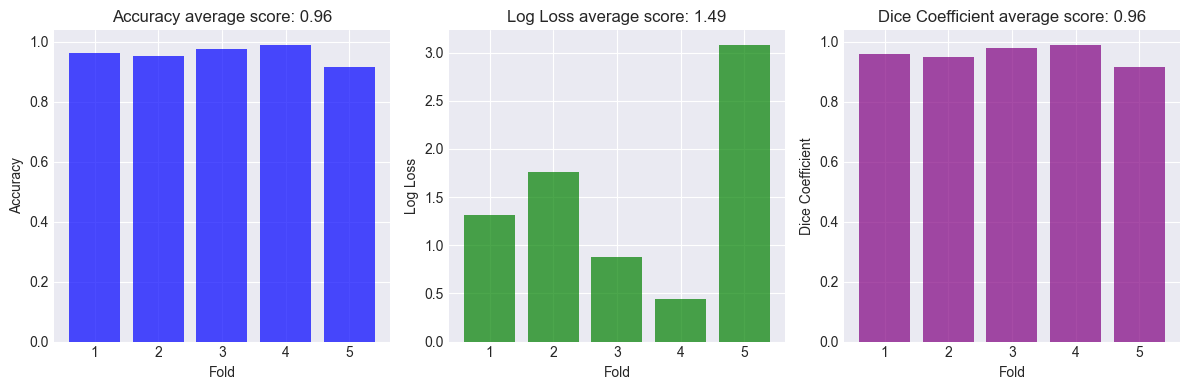

In [92]:
accuracies_2d, log_losses_2d, dice_coefs_2d = xgboots_k_fold(fold_2d_ttest)
th_xgb_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
results_xgb_2d.append(average_metrics_2d)

**-> 3D**

In [93]:
data_ttest_3d

Calcification  Spiculation  Lobulation  Margin  Subtlety  \
0                6            5           3       4         5   
1                6            2           2       3         5   
2                3            1           1       5         2   
3                6            5           1       3         5   
4                3            1           1       5         3   
..             ...          ...         ...     ...       ...   
405              6            1           1       4         3   
406              6            2           2       4         5   
407              6            1           3       4         5   
408              6            1           1       3         5   
409              6            1           1       2         4   

     original_glrlm_GrayLevelNonUniformity  \
0                               757.880362   
1                                88.384615   
2                                34.515260   
3                               437.070150   
4                                33.846154   
..                                     ...   
405                              41.769231   
406                            1239.769231   
407                             573.307692   
408                             444.769231   
409                              47.846154   

     original_glrlm_RunLengthNonUniformity  \
0                               560.437962   
1                                65.418418   
2                                34.624099   
3                               674.745089   
4                                25.277877   
..                                     ...   
405                              30.870197   
406                             950.216242   
407                             411.691071   
408                             314.515156   
409                              40.702319   

     original_gldm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                              931.027689                9.385304e+08   
1                              106.000000                1.060000e+08   
2                               44.017544                5.373786e+07   
3                              534.484914                8.652093e+08   
4                               41.000000                4.100000e+07   
..                                    ...                         ...   
405                             50.000000                5.000000e+07   
406                           1483.000000                1.482982e+09   
407                            704.000000                7.040000e+08   
408                            556.000000                5.560000e+08   
409                             54.000000                5.400000e+07   

     original_firstorder_TotalEnergy  ...  \
0                       9.385304e+08  ...   
1                       1.060000e+08  ...   
2                       5.373786e+07  ...   
3                       8.652093e+08  ...   
4                       4.100000e+07  ...   
..                               ...  ...   
405                     5.000000e+07  ...   
406                     1.482982e+09  ...   
407                     7.040000e+08  ...   
408                     5.560000e+08  ...   
409                     5.400000e+07  ...   

     original_glszm_SmallAreaHighGrayLevelEmphasis  original_glcm_Idmn  \
0                                         6.200000            0.998849   
1                                         0.000089            1.000000   
2                                       135.571486            0.940932   
3                                        59.289969            0.980366   
4                                         0.000595            1.000000   
..                                             ...                 ...   
405                                       0.000400            1.000000   
406                                       0.000433            1.000000   
407                               

Número de Fold: 1


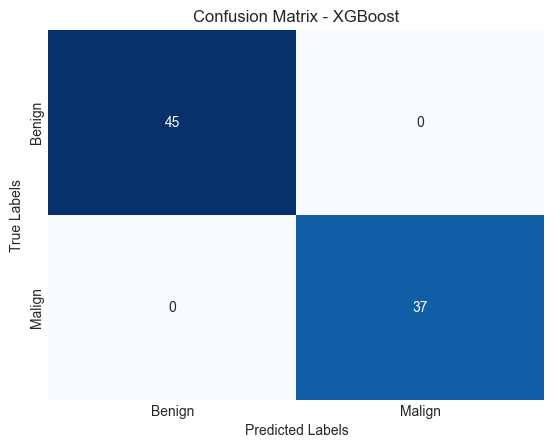

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 2


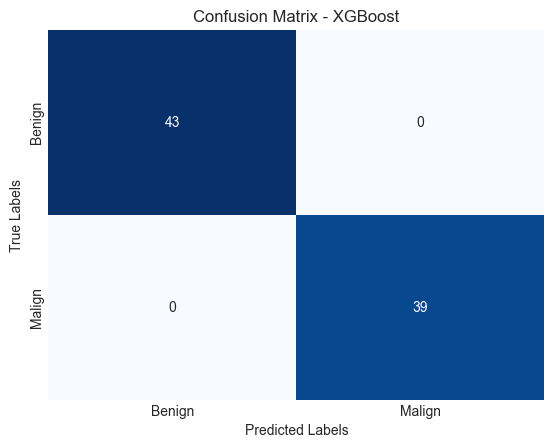

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        39

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 3


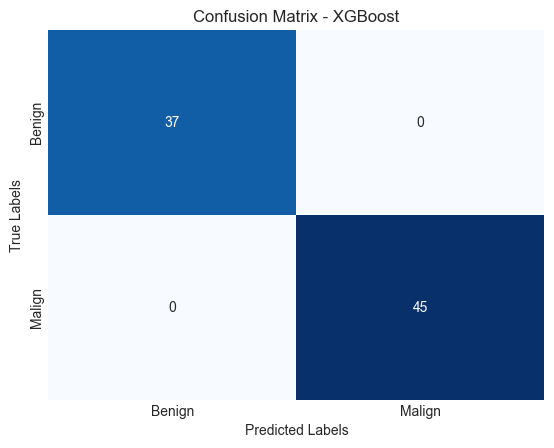

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        45

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 4


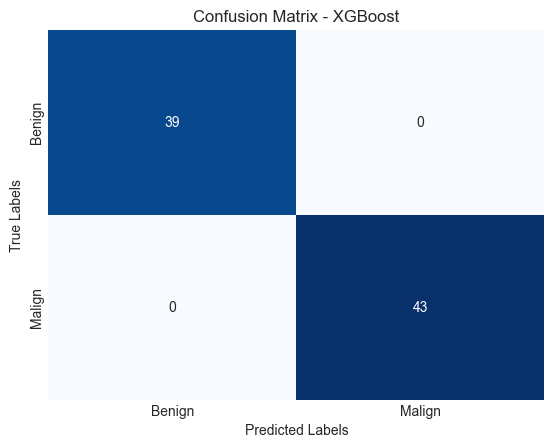

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        43

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 5


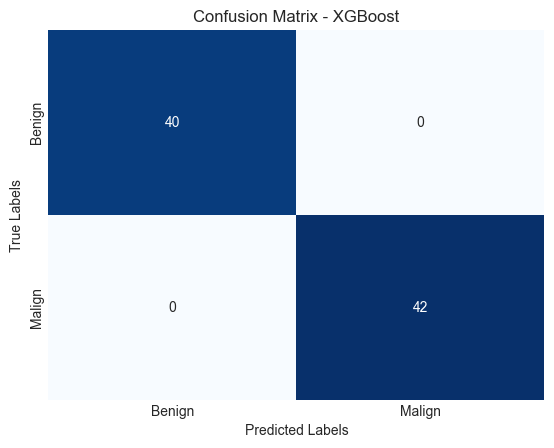

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        42

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



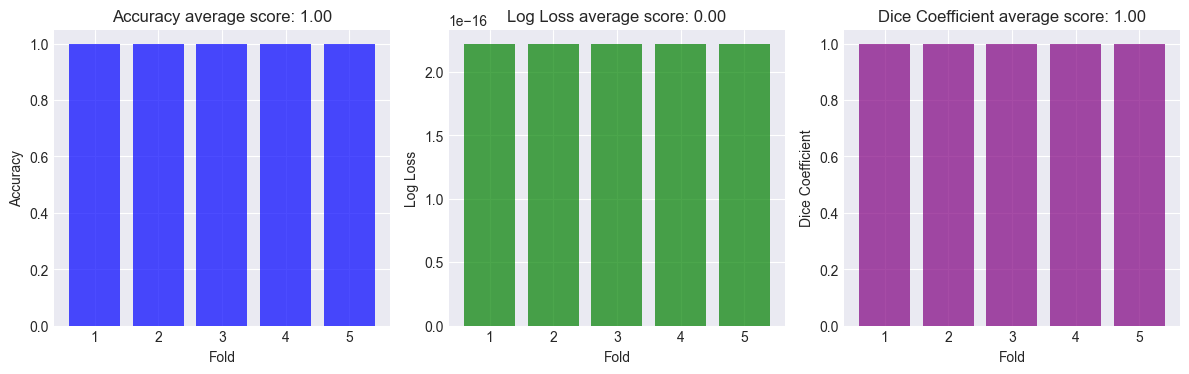

In [94]:
accuracies_3d, log_losses_3d, dice_coefs_3d = xgboots_k_fold(fold_3d_rf)
th_xgb_3d.append([accuracies_3d,log_losses_3d, dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
results_xgb_3d.append(average_metrics_3d)

**XGBoost + Random Forest (seleção de features)**<a name = "xgboost_rf"></a>

[[Voltar a XGBoost]](#xgboost)

Por fim, utilizamos o dataset obtido pelo Random Forest (na seleção das features)

**-> 2D**

In [95]:
data_rf_2d

Calcification  Lobulation  Spiculation  \
0                6           3            5   
1                6           2            2   
2                3           1            1   
3                6           1            5   
4                3           1            1   
..             ...         ...          ...   
405              6           1            1   
406              6           2            2   
407              6           3            1   
408              6           1            1   
409              6           1            1   

     original_gldm_GrayLevelNonUniformity  original_shape2D_MajorAxisLength  \
0                              160.036585                         57.542760   
1                               33.000000                         17.090541   
2                               12.142857                          9.244896   
3                               43.079208                         40.718270   
4                               18.000000                         10.327956   
..                                    ...                               ...   
405                             24.000000                         13.852837   
406                            157.000000                         61.575217   
407                            101.000000                         51.164214   
408                             79.000000                         41.452617   
409                             21.000000                         12.494295   

     original_glrlm_GrayLevelNonUniformity  Margin  \
0                               113.551582       4   
1                                24.750000       3   
2                                 9.184343       5   
3                                31.512433       3   
4                                13.500000       5   
..                                     ...     ...   
405                              18.000000       4   
406                             116.000000       4   
407                              73.000000       4   
408                              58.000000       3   
409                              15.500000       2   

     original_firstorder_Energy  original_shape2D_Perimeter  Subtlety  ...  \
0                   163807321.0                  356.877200         5  ...   
1                    33000000.0                   76.769553         5  ...   
2                    13646416.0                   36.284271         2  ...   
3                    90440738.0                  224.994949         5  ...   
4                    18000000.0                   44.284271         3  ...   
..                          ...                         ...       ...  ...   
405                  24000000.0                   59.597980         3  ...   
406                 157000000.0                  357.948268         5  ...   
407                 101000000.0                  229.521861         5  ...   
408                  79000000.0                  181.580736         5  ...   
409                  21000000.0                   50.526912         4  ...   

     Sphericity  original_gldm_LargeDependenceLowGrayLevelEmphasis  Texture  \
0             3                                          11.258299        5   
1             4                                           9.000000        4   
2             2                                           7.643973        5   
3             4                                           5.172723        5   
4             5                                           9.000000        5   
..          ...                                                ...      ...   
405           3                                           9.000000        5   
406           4                                           9.636943        5   
407           3                                          10.524752        5   
408           3                                           9.886076        5   
409           4                     

Número de Fold: 1


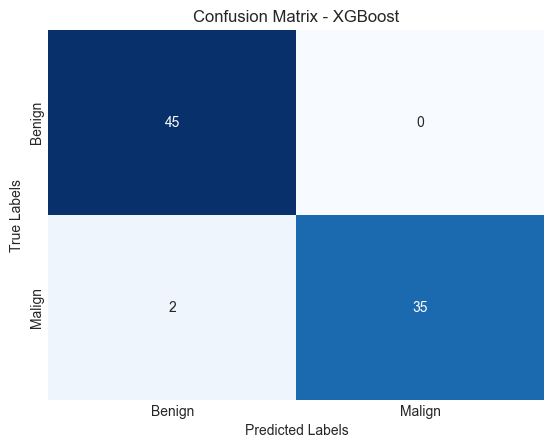

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       1.00      0.95      0.97        37

    accuracy                           0.98        82
   macro avg       0.98      0.97      0.98        82
weighted avg       0.98      0.98      0.98        82

Número de Fold: 2


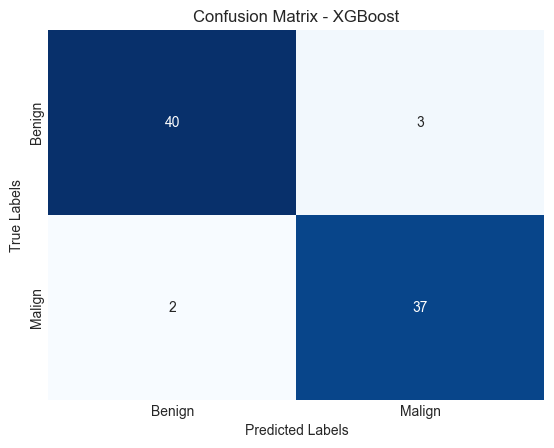

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.93      0.95      0.94        39

    accuracy                           0.94        82
   macro avg       0.94      0.94      0.94        82
weighted avg       0.94      0.94      0.94        82

Número de Fold: 3


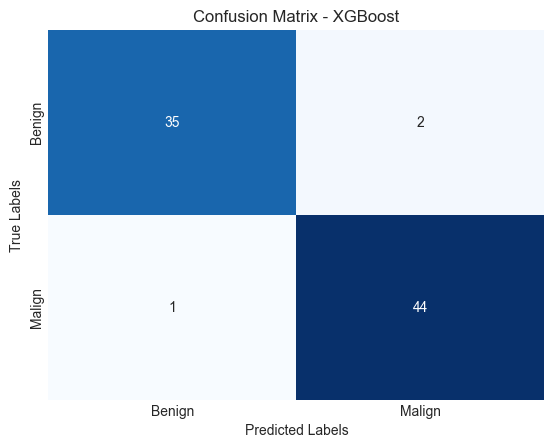

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           1       0.96      0.98      0.97        45

    accuracy                           0.96        82
   macro avg       0.96      0.96      0.96        82
weighted avg       0.96      0.96      0.96        82

Número de Fold: 4


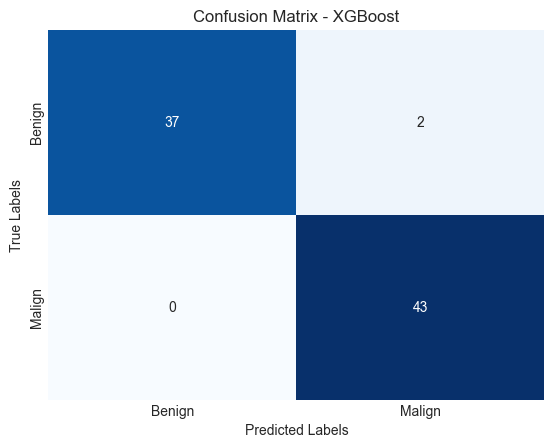

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       0.96      1.00      0.98        43

    accuracy                           0.98        82
   macro avg       0.98      0.97      0.98        82
weighted avg       0.98      0.98      0.98        82

Número de Fold: 5


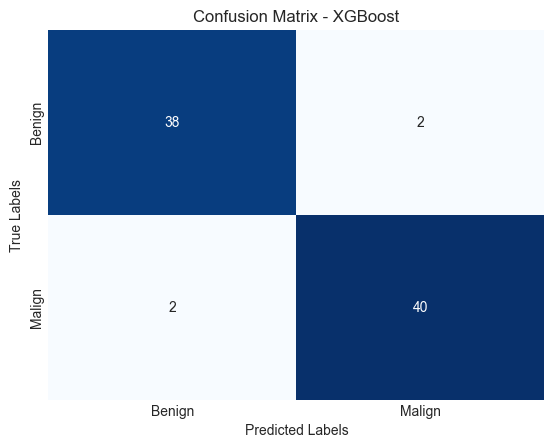

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.95      0.95      0.95        42

    accuracy                           0.95        82
   macro avg       0.95      0.95      0.95        82
weighted avg       0.95      0.95      0.95        82



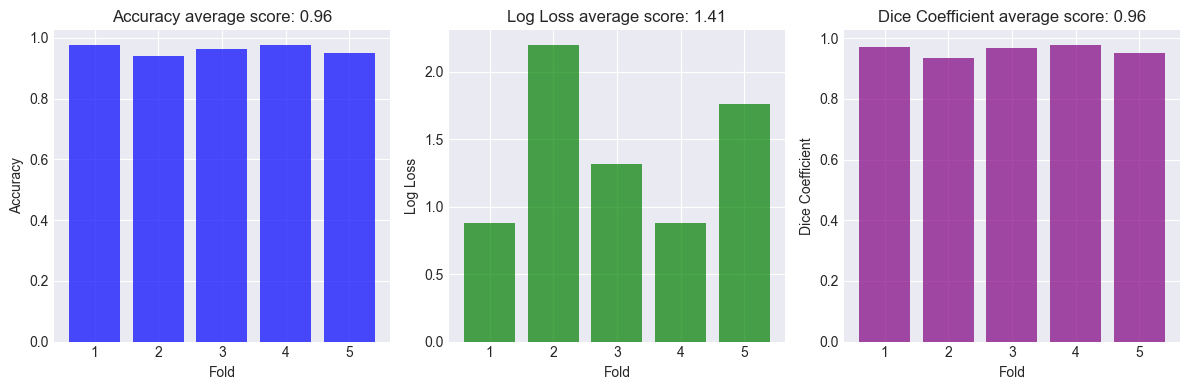

In [96]:
accuracies_2d, log_losses_2d, dice_coefs_2d = xgboots_k_fold(fold_2d_rf)
th_xgb_2d.append([accuracies_2d,log_losses_2d,dice_coefs_2d])
average_metrics_2d = plot_metrics(accuracies_2d, log_losses_2d, dice_coefs_2d)
results_xgb_2d.append(average_metrics_2d)

**-> 3D**

In [97]:
data_rf_3d

Calcification  Spiculation  Lobulation  Margin  \
0                6            5           3       4   
1                6            2           2       3   
2                3            1           1       5   
3                6            5           1       3   
4                3            1           1       5   
..             ...          ...         ...     ...   
405              6            1           1       4   
406              6            2           2       4   
407              6            1           3       4   
408              6            1           1       3   
409              6            1           1       2   

     original_glrlm_GrayLevelNonUniformity  original_firstorder_Energy  \
0                               757.880362                9.385304e+08   
1                                88.384615                1.060000e+08   
2                                34.515260                5.373786e+07   
3                               437.070150                8.652093e+08   
4                                33.846154                4.100000e+07   
..                                     ...                         ...   
405                              41.769231                5.000000e+07   
406                            1239.769231                1.482982e+09   
407                             573.307692                7.040000e+08   
408                             444.769231                5.560000e+08   
409                              47.846154                5.400000e+07   

     original_glrlm_RunLengthNonUniformity  Subtlety  \
0                               560.437962         5   
1                                65.418418         5   
2                                34.624099         2   
3                               674.745089         5   
4                                25.277877         3   
..                                     ...       ...   
405                              30.870197         3   
406                             950.216242         5   
407                             411.691071         5   
408                             314.515156         5   
409                              40.702319         4   

     original_gldm_GrayLevelNonUniformity  \
0                              931.027689   
1                              106.000000   
2                               44.017544   
3                              534.484914   
4                               41.000000   
..                                    ...   
405                             50.000000   
406                           1483.000000   
407                            704.000000   
408                            556.000000   
409                             54.000000   

     original_gldm_DependenceNonUniformity  ...  original_ngtdm_Strength  \
0                               155.261981  ...                 0.950551   
1                                26.660377  ...                 0.000000   
2                                 8.929825  ...                13.837206   
3                               134.415948  ...                 4.995332   
4                                13.682927  ...                 0.000000   
..                                     ...  ...                      ...   
405                              19.320000  ...                 0.000000   
406                             324.684423  ...                 0.000000   
407                             112.750000  ...                 0.000000   
408                              90.420863  ...                 0.000000   
409                              19.148148  ...                 0.000000   

     original_glszm_ZoneVariance  original_glszm_GrayLevelVariance  \
0                  139576.960000                          0.640000   
1                       0.000000                          0.000000   
2                     292.122449                         45.346939   
3                    1441.356256                

Número de Fold: 1


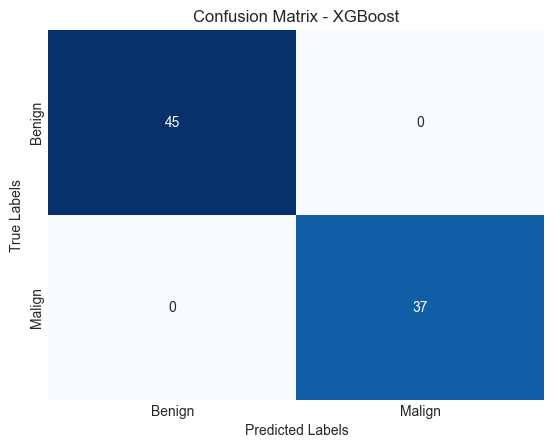

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        37

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 2


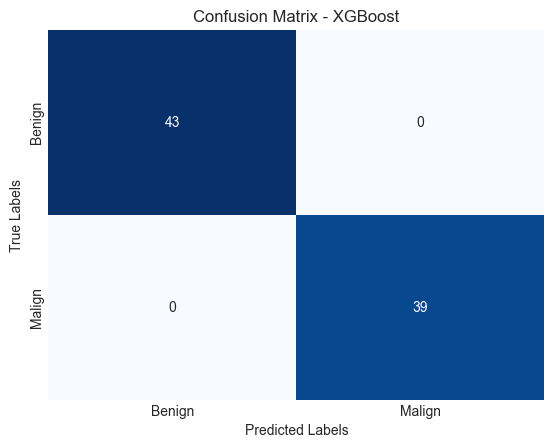

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        39

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 3


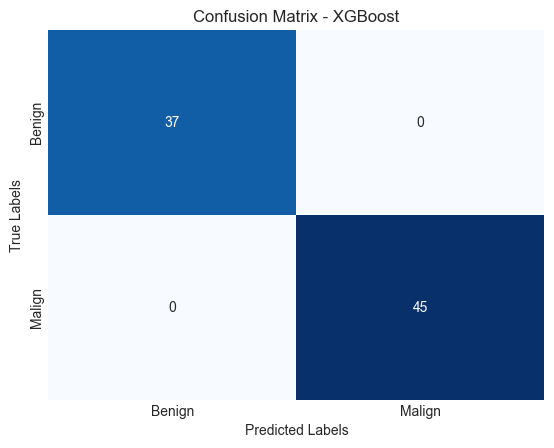

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        45

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 4


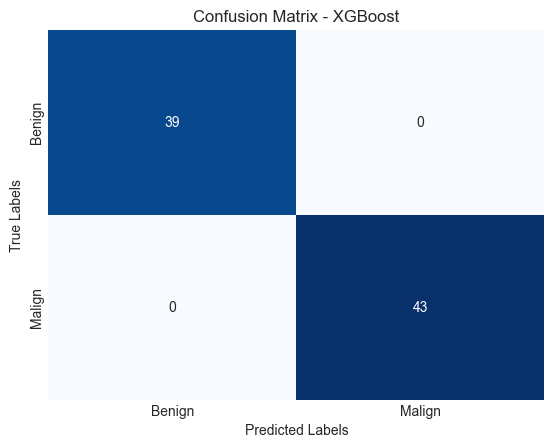

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        43

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Número de Fold: 5


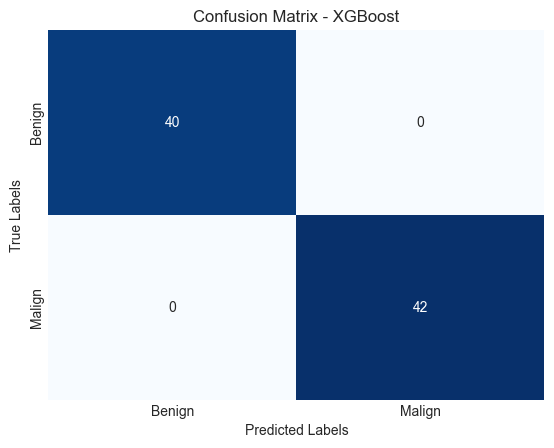

<Figure size 500x500 with 0 Axes>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        42

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



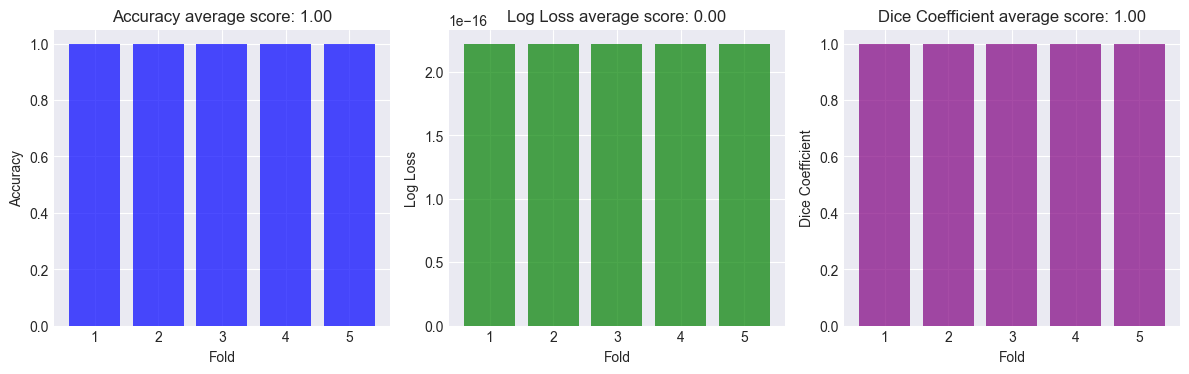

In [98]:
accuracies_3d, log_losses_3d, dice_coefs_3d = xgboots_k_fold(fold_3d_rf)
th_xgb_3d.append([accuracies_3d, log_losses_3d, dice_coefs_3d])
average_metrics_3d = plot_metrics(accuracies_3d, log_losses_3d, dice_coefs_3d)
results_xgb_3d.append(average_metrics_3d)

**Resultados XGBoost** <a name = "xgboost_resultados"></a>

[[Voltar a XGBoost]](#xgboost)

**-> 2D**

In [99]:
print(results_xgb_2d)

[[1.0, 2.2204460492503136e-16, 1.0], [0.8804878048780488, 4.307656136748148, 0.8795964035964035], [0.9585365853658537, 1.4944929454024187, 0.9576821206195625], [0.9609756097560975, 1.4065815956728644, 0.9611235459336726]]


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/3843270632.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


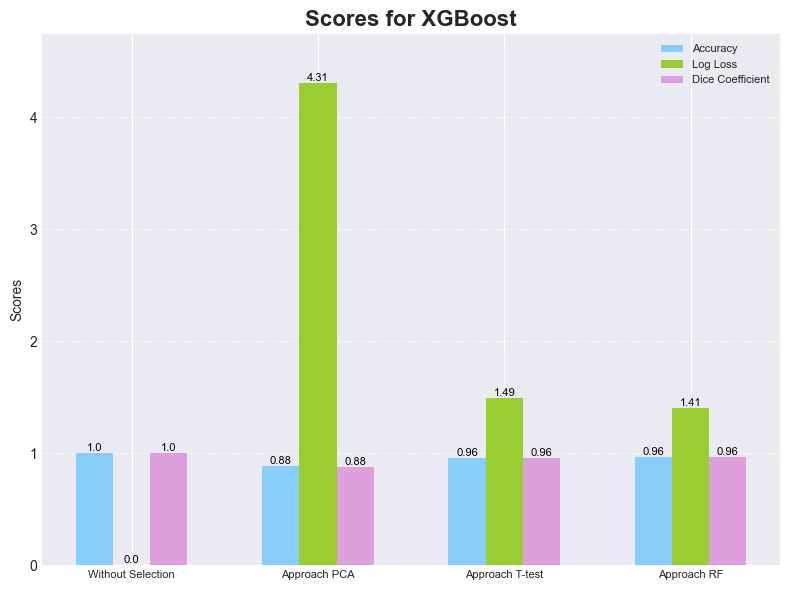

In [100]:
plot_scores(results_xgb_2d, "XGBoost")

**-> 3D**

In [101]:
print(results_xgb_3d)

[[1.0, 2.2204460492503136e-16, 1.0], [0.8951219512195122, 3.780188038370823, 0.8942145990591273], [1.0, 2.2204460492503136e-16, 1.0], [1.0, 2.2204460492503136e-16, 1.0]]


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_66041/3843270632.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


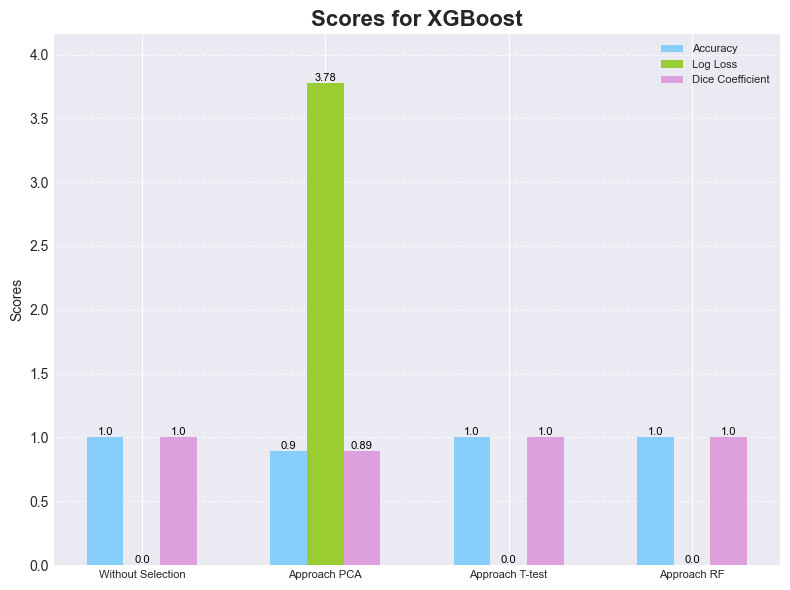

In [102]:
plot_scores(results_xgb_3d, "XGBoost")

## Comparação de resultados <a name = "cr"></a>
[[Voltar ao Indice]](#indice)

Função para plotar os resultados obtidos:


Explicar os critérios ...

In [103]:


def plot_all_models_combined(results_svm, results_rf, results_xgb):
    models = ['SVM', 'Random Forest', 'XGBoost']
    approaches = ['Without Selection', 'Approach PCA', 'Approach T-test', 'Approach RF']
    metrics = ['Accuracy', 'Log Loss', 'Dice Coefficient']

    # Preparar dados em uma estrutura única
    all_results = [results_svm, results_rf, results_xgb]
    bar_width = 0.2
    x = np.arange(len(approaches))

    # Verificação de estrutura
    for model, results in zip(models, all_results):
        if len(results) != len(approaches):
            raise ValueError(f"O número de abordagens em {model} ({len(results)}) não coincide com o número esperado ({len(approaches)}).")
        for result in results:
            if len(result) != len(metrics):
                raise ValueError(f"Cada abordagem em {model} deve ter exatamente {len(metrics)} métricas, mas uma das abordagens tem {len(result)} métricas.")

    fig, ax = plt.subplots(figsize=(15, 8))

    # Plotar cada métrica com barras agrupadas
    for i, (model, results) in enumerate(zip(models, all_results)):
        for j, metric in enumerate(metrics):
            # Extrair apenas os dados da métrica específica para cada abordagem
            metric_scores = [result[j] for result in results]
            
            # Posicionar as barras de forma que elas fiquem agrupadas por métrica e modelo
            ax.bar(x + i * bar_width + j * bar_width / len(metrics), metric_scores, 
                   width=bar_width / len(metrics), label=f'{model} - {metric}')

    # Configurar o gráfico
    ax.set_xlabel('Approaches')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Models and Metrics Across Approaches')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(approaches)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

**-> 2D** 

In [104]:
print(results_svm_2d)
print(results_rf_2d)
print(results_xgb_2d)

[[0.6853658536585366, 11.34056411511247, 0.7418117663125008], [0.9317073170731707, 2.4615177924275127, 0.929468419847578], [0.724390243902439, 9.933982519439605, 0.749800778804085], [0.6853658536585366, 11.34056411511247, 0.7418117663125008]]
[[0.9951219512195122, 0.17582269945910828, 0.9954492566257273], [0.8853658536585366, 4.13183343728904, 0.8890888664025738], [0.9463414634146341, 1.9340496940501886, 0.9458706597285762], [0.9414634146341463, 2.109872393509297, 0.9403221775286242]]
[[1.0, 2.2204460492503136e-16, 1.0], [0.8804878048780488, 4.307656136748148, 0.8795964035964035], [0.9585365853658537, 1.4944929454024187, 0.9576821206195625], [0.9609756097560975, 1.4065815956728644, 0.9611235459336726]]


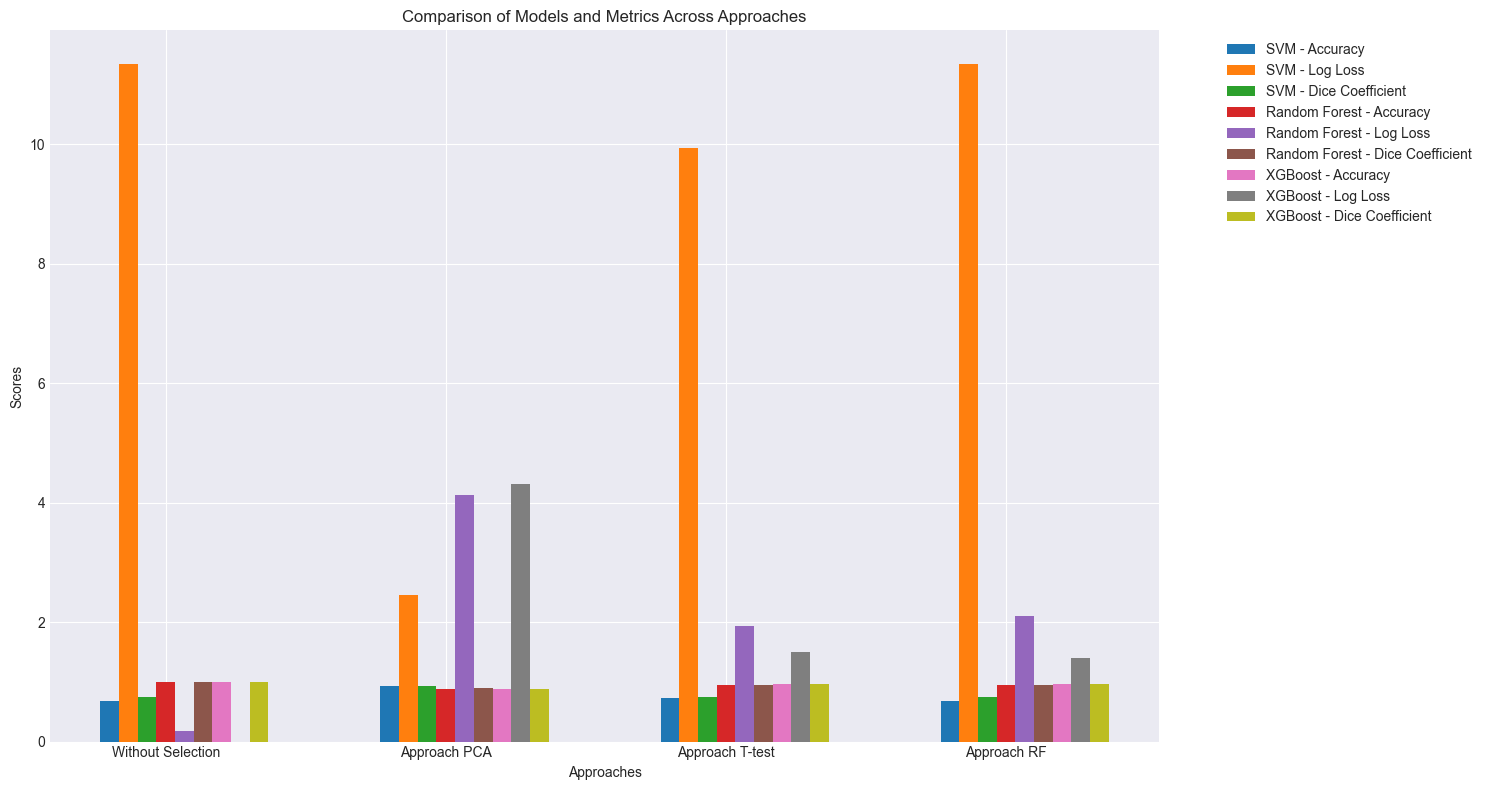

In [105]:
plot_all_models_combined(results_svm_2d, results_rf_2d, results_xgb_2d)

**-> 3D** 

In [106]:
print(results_svm_3d)
print(results_rf_3d)
print(results_xgb_3d)

[[0.5121951219512195, 17.582269945910802, 0.5379390829067068], [0.9487804878048781, 1.8461383443206347, 0.949257284252871], [0.5146341463414634, 17.49435859618125, 0.5391354936744037], [0.5121951219512195, 17.582269945910802, 0.5379390829067068]]
[[0.9951219512195122, 0.17582269945910828, 0.9956521739130434], [0.8975609756097562, 3.692276688641269, 0.8955214018715599], [0.9439024390243903, 2.0219610437797426, 0.9430966701858932], [1.0, 2.2204460492503136e-16, 1.0]]
[[1.0, 2.2204460492503136e-16, 1.0], [0.8951219512195122, 3.780188038370823, 0.8942145990591273], [1.0, 2.2204460492503136e-16, 1.0], [1.0, 2.2204460492503136e-16, 1.0]]


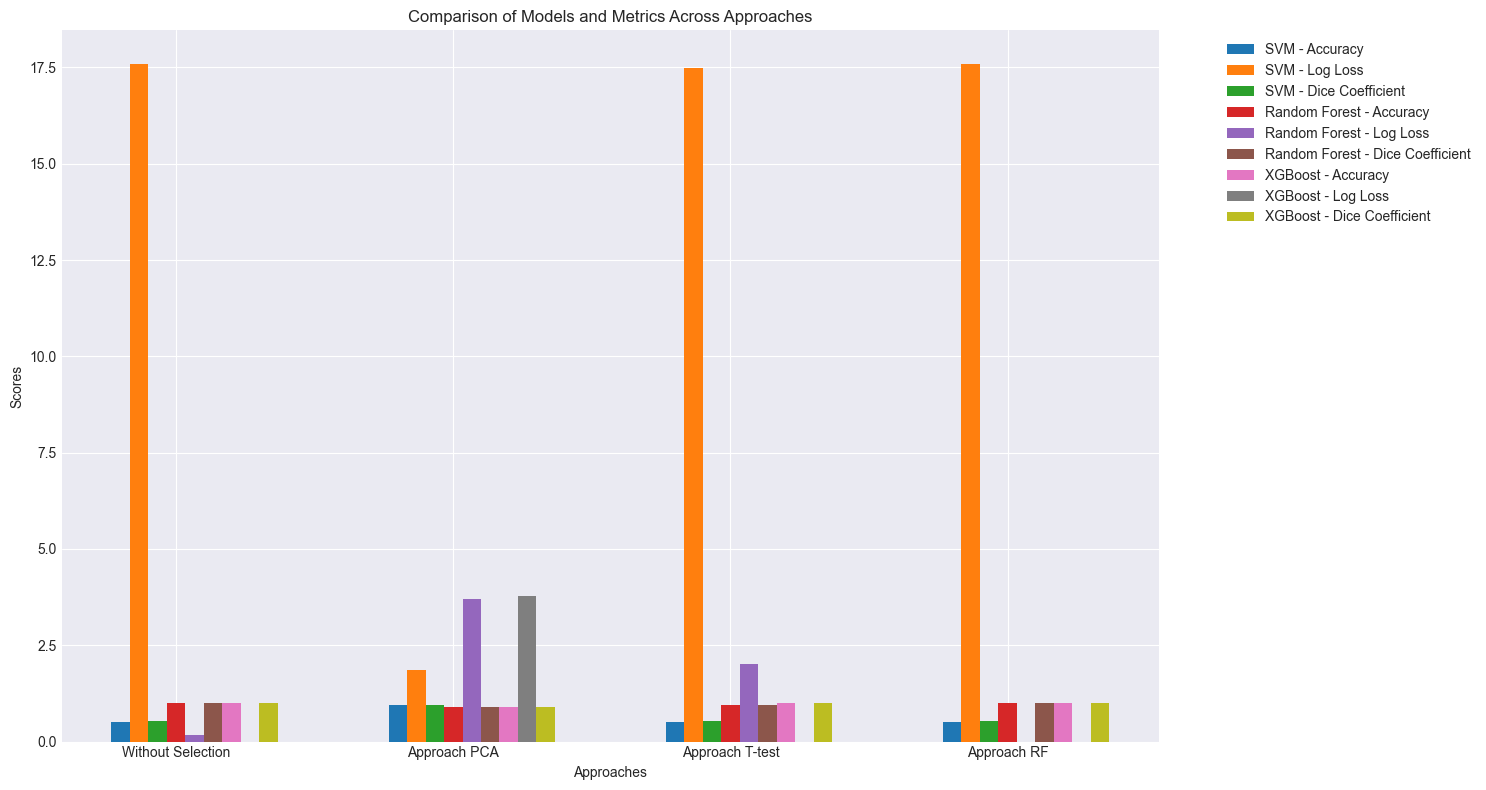

In [107]:
plot_all_models_combined(results_svm_3d, results_rf_3d, results_xgb_3d)

Embora as médias forneçam uma visão preliminar do desempenho central de cada configuração, elas não permitem concluir se as diferenças observadas são estatisticamente significativas ou apenas resultados do acaso. Por esse motivo iremos agora realizar testes de hipóteses, que são preferíveis à simples análise das médias porque eles oferecem uma forma estatisticamente rigorosa de avaliar diferenças de desempenho entre os modelos e métodos de seleção de features.

## Comparação entre diferentes modelos com o mesmo método de seleção de features

Este código foi desenvolvido para comparar o desempenho de três modelos de machine learning (SVM, Random Forest e XGBoost) em diferentes métodos de extração de features (Sem Seleção, PCA, t-test e Random Forest) usando três métricas de avaliação: accuracy, log loss e dice coefficient. Cada modelo foi avaliado utilizando 5 folds (ou partições) dos dados, e as métricas foram calculadas para cada fold em cada método de extração de features. O objetivo é determinar, para cada método de extração de features, qual modelo de machine learning se destaca como o melhor, com base em testes estatísticos.

Objetivo do Código
O principal objetivo deste código é identificar, com base em testes de hipóteses, se algum dos três modelos (SVM, Random Forest ou XGBoost) apresenta um desempenho significativamente superior aos outros em cada combinação de método de extração de features e métrica. Ao realizar essa análise, é possível escolher o modelo de machine learning mais adequado para cada cenário específico de extração de features, maximizando assim o desempenho de acordo com a métrica que é mais importante para a aplicação.

Uso dos Testes de Hipóteses
Para identificar se há diferenças significativas no desempenho dos modelos, o código utiliza uma abordagem baseada em testes de hipóteses. Os testes aplicados incluem:

Teste ANOVA (Análise de Variância):

O teste ANOVA é utilizado para verificar se há diferenças estatisticamente significativas entre as médias das métricas dos três modelos (SVM, Random Forest, XGBoost) para cada método de extração de features.
Para cada métrica (accuracy, log loss, e dice coefficient), o teste ANOVA compara as médias dos valores obtidos pelos modelos. Se o teste indicar uma diferença significativa, isso sugere que pelo menos um dos modelos apresenta um desempenho diferente dos outros para a métrica e o método de extração de features em questão.
Esse teste é importante porque evita a suposição de que diferenças observadas nas médias sejam necessariamente relevantes. Somente quando o ANOVA identifica significância (com um p-valor menor que 0,05), passamos a considerar que pode haver diferenças reais entre os modelos.
Teste de Comparações Múltiplas de Tukey (Post Hoc):

Quando o ANOVA detecta uma diferença significativa, o código realiza uma análise post hoc com o teste de Tukey.
O teste de Tukey é um teste de comparações múltiplas que nos permite identificar exatamente quais pares de modelos são significativamente diferentes entre si.
Isso é crucial para determinar se um modelo é consistentemente superior ou inferior aos outros em termos de uma métrica específica. Por exemplo, ele pode mostrar que um modelo (como o XGBoost) é estatisticamente melhor em accuracy do que o SVM e o Random Forest para um método de extração específico.
O Que os Testes Fazem
Teste ANOVA: Este teste determina se há uma diferença significativa entre os modelos, analisando se pelo menos um modelo se destaca dos outros em termos de média para uma métrica específica e método de extração de features. Ele serve como um filtro inicial para identificar diferenças globais.
Teste de Tukey: Este teste identifica quais modelos específicos têm diferenças significativas entre si. Após o ANOVA, o teste de Tukey permite uma análise detalhada, comparando cada par de modelos para confirmar quais realmente têm desempenho superior ou inferior.
Conclusão
O uso desses testes de hipóteses garante que a escolha do "melhor" modelo para cada método de extração de features seja baseada em evidências estatísticas, evitando conclusões que possam ser resultado de variações aleatórias nos dados. Com base nos resultados dos testes, o código determina o melhor modelo para cada combinação de método de extração e métrica, auxiliando na seleção de um modelo que maximize o desempenho de acordo com as necessidades específicas da aplicação.

In [108]:



def avaliar_modelos_por_metodo(th_svm, th_rf, th_xgb):
    # Nome das métricas e modelos para análise
    metricas = ["Accuracy", "Log Loss", "Dice Coefficient"]
    modelos = ["SVM", "Random Forest", "XGBoost"]
    metodos = ["Sem Seleção", "PCA", "t-test", "Random Forest"]
    
    # Iterar sobre cada método de extração de features
    for metodo_idx, metodo in enumerate(metodos):
        print(f"\nAnalisando método de extração de features: {metodo}\n" + "="*50)
        
        melhores_modelos = {}

        # Iterar sobre cada métrica (accuracy, log loss, dice coefficient)
        for metrica_idx, metrica in enumerate(metricas):
            print(f"\nMétrica: {metrica}\n" + "-"*50)
            
            # Extrair os dados para a métrica específica de cada modelo
            dados_metrica = [
                th_svm[metodo_idx][metrica_idx],  # Dados para SVM no método e métrica atual
                th_rf[metodo_idx][metrica_idx],   # Dados para Random Forest no método e métrica atual
                th_xgb[metodo_idx][metrica_idx]   # Dados para XGBoost no método e métrica atual
            ]
            
            # Calcular as médias para cada modelo para a métrica em questão
            medias = [np.mean(valores) for valores in dados_metrica]
            
            # Executar o teste ANOVA de uma via para comparar as médias entre os modelos
            f_stat, p_val = stats.f_oneway(*dados_metrica)
            
            if p_val < 0.05:
                print(f"Diferença significativa encontrada na métrica {metrica} (p = {p_val:.4f})")
                
                # Preparar dados para o teste de Tukey
                dados_flat = np.concatenate(dados_metrica)
                grupos = np.array([modelo for modelo in modelos for _ in range(5)])  # Repetir cada modelo 5 vezes
                
                # Executar o teste post hoc de Tukey para identificar quais modelos diferem
                tukey_result = pairwise_tukeyhsd(dados_flat, grupos, alpha=0.05)
                print(tukey_result)
                
                # Determinar o melhor modelo com base nas comparações de Tukey
                melhores = []
                if metrica == "Log Loss":
                    # Para log loss, menor média é melhor
                    for j, media in enumerate(medias):
                        # Verificar se o modelo atual é significativamente melhor que os outros
                        significativo = all(
                            tukey_result.reject[idx] 
                            for idx, group in enumerate(tukey_result.groupsunique) 
                            if modelos[j] == group
                        )
                        if significativo:
                            melhores.append((modelos[j], media))
                    melhor_modelo = min(melhores, key=lambda x: x[1])[0] if melhores else "Nenhum se destacou"
                    
                else:
                    # Para accuracy e dice coefficient, maior média é melhor
                    for j, media in enumerate(medias):
                        # Verificar se o modelo atual é significativamente melhor que os outros
                        significativo = all(
                            tukey_result.reject[idx] 
                            for idx, group in enumerate(tukey_result.groupsunique) 
                            if modelos[j] == group
                        )
                        if significativo:
                            melhores.append((modelos[j], media))
                    melhor_modelo = max(melhores, key=lambda x: x[1])[0] if melhores else "Nenhum se destacou"
                
                melhores_modelos[metrica] = melhor_modelo
                print(f"Melhor modelo para {metrica} com base no teste de hipóteses: {melhor_modelo}")
            
            else:
                print(f"Não há diferença significativa entre os modelos para a métrica {metrica} (p = {p_val:.4f})")
                melhores_modelos[metrica] = "Nenhum modelo se destacou"
        
        # Exibir o resumo dos melhores modelos para o método atual
        print(f"\nResumo dos melhores modelos para o método de extração '{metodo}':")
        for metrica, modelo in melhores_modelos.items():
            print(f"{metrica}: {modelo}")

In [109]:
melhores_modelos = avaliar_modelos_por_metodo(th_svm_2d, th_rf_2d, th_xgb_2d)
print("\nMelhores modelos por método de seleção:", melhores_modelos)


Analisando método de extração de features: Sem Seleção

Métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0000)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM  -0.3098    0.0 -0.3492 -0.2704   True
Random Forest XGBoost   0.0049 0.9419 -0.0345  0.0443  False
          SVM XGBoost   0.3146    0.0  0.2752   0.354   True
------------------------------------------------------------
Melhor modelo para Accuracy com base no teste de hipóteses: XGBoost

Métrica: Log Loss
--------------------------------------------------
Diferença significativa encontrada na métrica Log Loss (p = 0.0000)
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------

Agora, vamos ver com as features 3d: 

In [110]:
melhores_modelos = avaliar_modelos_por_metodo(th_svm_3d, th_rf_3d, th_xgb_3d)
print("\nMelhores modelos por método de seleção:", melhores_modelos)


Analisando método de extração de features: Sem Seleção

Métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0000)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM  -0.4829    0.0 -0.5263 -0.4396   True
Random Forest XGBoost   0.0049 0.9517 -0.0384  0.0482  False
          SVM XGBoost   0.4878    0.0  0.4445  0.5311   True
------------------------------------------------------------
Melhor modelo para Accuracy com base no teste de hipóteses: XGBoost

Métrica: Log Loss
--------------------------------------------------
Diferença significativa encontrada na métrica Log Loss (p = 0.0000)
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1     group2 meandiff p-adj   lower    upper   reject
-----------------------------------------------

**Análise e Discussão : comparação de modelos por método de seleção (3D)**

Após serem implementados os testes ANOVA (ver diferenças estatisticamente significativas entre modelos) e de Tukey (encontrar os pares com essas diferenças), foram obtidos os seguintes resultados, por método de seleção:

- **Sem seleção de features:** há diferença estatisticamente significativa entre o desempenho dos pares de modelos Random Forest-SVM e SVM-XGBoost para as 3 métricas (Accuracy, Dice Coefficient e Log loss). O modelo XGBoost apresenta valores mais elevados de Accuracy e Dice Coefficient e mais reduzidos de Log loss. Assim, de acordo com o sistema de pontuações implementado, para este método de seleção de features, o modelo XGBoost é o que obtem melhores resultados. No entanto, os resultados obtidos por este modelo são muito próximos de valores ótimos, o que pode sugerir que a não seleção de features leva a overfitting dos dados.

- **PCA:** há diferença estatisticamente significativa entre o desempenho dos pares de modelos Random Forest-SVM e SVM-XGBoost para as 3 métricas (Accuracy, Dice Coefficient e Log loss). O modelo Random Forest apresenta valores mais elevados de Accuracy e Dice Coefficient e mais reduzidos de Log loss, sendo então o modelo com melhores resultados quando usado o PCA.

- **t-test:** há diferença estatisticamente significativa entre as médias da Accuracy e da Log loss para todas os pares de modelos (Random Forest-SVM, Random Forest-XGBoost, SVM-XGBoost). Relativamente aos valores médios de Dice Coefficient, encontramos diferenças nos pares Random Forest-SVM e SVM-XGBoost. Através do sistema de pontuações que usamos, concluimos que para o método de seleção por t-test, é o modelo XGBoost quem apresenta os melhores resultados, ou seja, maior Accuracy e Dice Coefficient e menos Log loss.

- **Random Forest:** há diferença estatisticamente significativa entre o desempenho dos pares de modelos Random Forest-SVM e SVM-XGBoost para as 3 métricas (Accuracy, Dice Coefficient e Log loss). O modelo Random Forest, pelo sistema de pontuações, é considerado o melhor, quando selecionamos as features do dataset também com o Random Forest, apresentando valores mais elevados de Accuracy e Dice Coefficient e mais reduzidos de Log loss.

## Comparação entre diferente métodos de seleção de features para um mesmo modelo de classificação

Este código foi desenvolvido para avaliar diferentes métodos de seleção de features para um modelo de machine learning específico (por exemplo, SVM, Random Forest, ou XGBoost) com base em três métricas de desempenho: accuracy, log loss e dice coefficient. Ele compara quatro métodos de seleção de features (Sem Seleção, PCA, t-test e Random Forest) e utiliza testes de hipóteses para identificar se há diferenças estatisticamente significativas no desempenho desses métodos. O objetivo final é determinar qual método de seleção de features proporciona o melhor desempenho para cada métrica, com base em evidências estatísticas.

Objetivo do Código
O código visa ajudar na escolha do melhor método de seleção de features para um modelo específico ao analisar qual método se destaca em cada métrica de avaliação. Isso é feito ao:

Comparar as médias de desempenho dos métodos em várias métricas para avaliar se as diferenças observadas são estatisticamente significativas.
Identificar o método com o desempenho significativamente melhor para cada métrica, proporcionando uma escolha fundamentada para o pré-processamento de dados no contexto do modelo em uso.
Uso dos Testes de Hipóteses
Para assegurar que as diferenças de desempenho entre os métodos de seleção de features não são apenas fruto de variação aleatória, o código utiliza uma sequência de testes de hipóteses:

Teste ANOVA (Análise de Variância de Uma Via):

O teste ANOVA é utilizado inicialmente para avaliar se há uma diferença significativa entre as médias de desempenho dos métodos de seleção de features para cada métrica.
Ele testa a hipótese nula de que as médias dos grupos (métodos de seleção) são iguais, contra a hipótese alternativa de que pelo menos um dos grupos tem uma média diferente.
Se o p-valor do ANOVA é menor que 0,05, isso indica que existe uma diferença significativa entre pelo menos dois métodos, permitindo que se prossiga com uma análise mais detalhada.
Teste post hoc de Tukey (Comparações Múltiplas):

Se o ANOVA indicar significância, o teste de Tukey é aplicado como uma análise subsequente para identificar quais pares de métodos de seleção de features apresentam diferenças significativas.
O teste de Tukey fornece comparações pareadas entre todos os métodos, identificando quais métodos específicos têm desempenhos significativamente melhores que os outros.
Esse teste permite não apenas identificar a existência de uma diferença significativa, mas também determinar quais métodos são significativamente superiores.
Critério para Seleção do Melhor Método:

Para log loss: O menor valor indica melhor desempenho, então o método de seleção de features com a menor média e com diferenças significativas em relação aos outros é escolhido.
Para accuracy e dice coefficient: O maior valor indica melhor desempenho, então o método de seleção de features com a maior média e com diferenças significativas é selecionado.
Esse critério garante que o método escolhido para cada métrica é significativamente melhor do que os outros métodos, e não apenas aparentemente superior devido a flutuações nos dados.
Conclusão
O uso dos testes de hipóteses no código garante uma escolha baseada em evidências estatísticas para o melhor método de seleção de features em cada métrica. O teste ANOVA identifica a presença de diferenças significativas entre os métodos, enquanto o teste de Tukey especifica quais métodos são significativamente melhores. Com essa abordagem, o código permite uma seleção fundamentada do método de seleção de features mais eficaz, ajudando a otimizar o desempenho do modelo em relação às métricas de interesse..

In [111]:



#from statsmodels.stats.multicomp import pairwise_tukeyhsd

def avaliar_metodos(th_svm, name):
    # Nome das métricas e métodos para análise
    metricas = ["Accuracy", "Log Loss", "Dice Coefficient"]
    metodos = ["Sem Seleção", "PCA", "t-test", "Random Forest"]
    melhores_metodos = {}
    
    print(f"\n --------- Modelo selecionado: {name} --------- \n")
    
    # Iterar sobre cada métrica (accuracy, log loss, dice coefficient)
    for i, metrica in enumerate(metricas):
        print(f"\nAnalisando métrica: {metrica}\n" + "-"*50)
        
        # Extrair os dados para cada métrica específica
        dados_metrica = [metodo[i] for metodo in th_svm]
        
        # Calcular as médias para cada método para a métrica em questão
        medias = [np.mean(valores) for valores in dados_metrica]
        
        # Executar o teste ANOVA de uma via para comparar as médias entre os métodos
        f_stat, p_val = stats.f_oneway(*dados_metrica)
        
        if p_val < 0.05:
            print(f"Diferença significativa encontrada na métrica {metrica} (p = {p_val:.4f})")
            
            # Preparar dados para o teste de Tukey
            dados_flat = np.concatenate(dados_metrica)
            grupos = np.array([metodo for metodo in metodos for _ in range(5)])  # Repetir cada método 5 vezes
            
            # Executar o teste post hoc de Tukey para identificar quais métodos diferem
            tukey_result = pairwise_tukeyhsd(dados_flat, grupos, alpha=0.05)
            print(tukey_result)
            
            # Identificar métodos que são significativamente melhores com base no teste de Tukey
            significativos = {metodos[j]: medias[j] for j in range(len(medias)) 
                              if all(tukey_result.reject[idx] 
                                     for idx, comparacao in enumerate(tukey_result._results_table.data[1:]) 
                                     if metodos[j] in comparacao[:2])}
            
            # Selecionar o melhor método entre os que têm diferença significativa
            if metrica == "Log Loss":
                # Para log loss, menor média é melhor
                melhor_metodo = min(significativos, key=significativos.get, default="Nenhum se destacou")
            else:
                # Para accuracy e dice coefficient, maior média é melhor
                melhor_metodo = max(significativos, key=significativos.get, default="Nenhum se destacou")
                
            melhores_metodos[metrica] = melhor_metodo
            print(f"Melhor método para {metrica} com base no teste de hipóteses: {melhor_metodo}")
        
        else:
            print(f"Não há diferença significativa entre os métodos para a métrica {metrica} (p = {p_val:.4f})")
            melhores_metodos[metrica] = "Nenhum método se destacou"
    
    # Exibir o resumo dos melhores métodos
    print("\nResumo dos melhores métodos:")
    for metrica, metodo in melhores_metodos.items():
        print(f"{metrica}: {metodo}")



Vamos ver se existem então diferenças significaticas entre os métodos de seleção: 

In [112]:
melhor_metodo_svm = avaliar_metodos(th_svm_2d, "SVM")
melhor_metodo_rf = avaliar_metodos(th_rf_2d, "Random Forest")
melhor_metodo_svm = avaliar_metodos(th_xgb_2d, "XGBoost")


 --------- Modelo selecionado: SVM --------- 


Analisando métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0000)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
          PCA Random Forest  -0.2463    0.0 -0.3111 -0.1815   True
          PCA   Sem Seleção  -0.2463    0.0 -0.3111 -0.1815   True
          PCA        t-test  -0.2073    0.0 -0.2721 -0.1425   True
Random Forest   Sem Seleção      0.0    1.0 -0.0648  0.0648  False
Random Forest        t-test    0.039 0.3447 -0.0258  0.1038  False
  Sem Seleção        t-test    0.039 0.3447 -0.0258  0.1038  False
------------------------------------------------------------------
Melhor método para Accuracy com base no teste de hipóteses: PCA

Analisando métrica: Log Loss
---------------------------------------

**Análise e Discussão: Comparação de métodos de seleção de features para cada modelo (2D)**

A fim de verificar as diferenças entre a eficácia de cada método de seleção, recorremos novamente aos testes estatísticos ANOVA e Tukey, para identificar diferenças entre os valores médios das métricas (Accuracy, Dice Coefficient e Log Loss) obtidos para cada método de seleção de features.

- **SVM:** quando a classificação é feita pelo modelo SVM, há diferença estatisticamente significativa entre os pares PCA-Random Forest, PCA-Sem seleção e PCA-t-test, para as 3 métricas testadas. Os melhores resultados são obtidos quando usamos o dataset obtido pelo método PCA. Isto sugere que o PCA é o método de seleção de features mais eficaz para o modelo SVM.

- **Random Forest:** quando a classificação é feita pelo modelo Random Forest, há apenas diferença estatisticamente significativa entre o par PCA-Sem seleção. Como o PCA não apresenta diferenças com os outros métodos, não é possível concluir que haja algum método de seleção de features mais eficaz para o modelo Random Forest.

- **XGBoost:** quando a classificação é feita pelo modelo XGBoost, há diferença estatisticamente significativa entre os pares PCA-Random Forest, PCA-Sem seleção e PCA-t-test, para as 3 métricas testadas. Os melhores resultados são obtidos quando usamos o dataset obtido pelo método PCA. Isto sugere que o PCA é o método de seleção de features mais eficaz para o modelo XGBoost.

Vamos ver agora as diferenças significativas nos modelos 3D: 

In [113]:
melhor_metodo_svm = avaliar_metodos(th_svm_3d, "SVM")
melhor_metodo_rf = avaliar_metodos(th_rf_3d, "Random Forest")
melhor_metodo_xgb = avaliar_metodos(th_xgb_3d, "XGBoost")


 --------- Modelo selecionado: SVM --------- 


Analisando métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0000)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
          PCA Random Forest  -0.4366    0.0 -0.5071  -0.366   True
          PCA   Sem Seleção  -0.4366    0.0 -0.5071  -0.366   True
          PCA        t-test  -0.4341    0.0 -0.5047 -0.3636   True
Random Forest   Sem Seleção      0.0    1.0 -0.0706  0.0706  False
Random Forest        t-test   0.0024 0.9996 -0.0681   0.073  False
  Sem Seleção        t-test   0.0024 0.9996 -0.0681   0.073  False
------------------------------------------------------------------
Melhor método para Accuracy com base no teste de hipóteses: PCA

Analisando métrica: Log Loss
---------------------------------------

**Análise e Discussão: Comparação de métodos de seleção de features para cada modelo (3D)**

A fim de verificar as diferenças entre a eficácia de cada método de seleção, recorremos novamente aos testes estatísticos ANOVA e Tukey, para identificar diferenças entre os valores médios das métricas (Accuracy, Dice Coefficient e Log Loss) obtidos para cada método de seleção de features.

- **SVM:** quando a classificação é feita pelo modelo SVM, há diferença estatisticamente significativa entre os pares PCA-Random Forest, PCA-Sem seleção e PCA-t-test, para a Accuracy e para a Log loss. Já o Dice Coefficient, não apresenta diferenças estatisticamente significativas em todos os pares. Os melhores resultados são obtidos quando usamos o dataset obtido pelo método PCA. Isto sugere que o PCA é o método de seleção de features mais eficaz para o modelo SVM, apesar de na métrica Dice Coefficient nenhum dos métodos se ter destacado.

- **Random Forest:** quando a classificação é feita pelo modelo Random Forest, não há diferença estatisticamente significativa apenas entre o par Random Forest-Sem Seleção nas 3 métricas (Accuracy, Dice Coefficient e Log Loss). Através do sistema de pontuações, podemos então assim concluir que o melhor método no que toca ao Random Forest é o T-test.

- **XGBoost:** quando a classificação é feita pelo modelo XGBoost, há diferença estatisticamente significativa entre os pares PCA-Random Forest, PCA-Sem seleção e PCA-t-test, para as 3 métricas (Accuracy, Dice Coefficient e Log Loss). Como os melhores resultados são obtidos quando é usado o PCA emtodas as métricas, este será o melhor para ser usado no modelo XGBoost.

## Comparação 2D VS 3D

Este código foi desenvolvido para comparar o desempenho de dois tipos de dados, 2D e 3D, em três modelos de machine learning (SVM, Random Forest e XGBoost) e em quatro métodos de seleção de features (Sem Seleção, PCA, t-test e Random Forest) usando três métricas: accuracy, log loss e dice coefficient. O objetivo é identificar se existe um tipo de dados que, de modo geral, apresenta desempenho superior em relação ao outro em uma série de combinações de modelo, método de seleção e métrica.

Objetivo do Código
O objetivo do código é determinar, para cada combinação de modelo e método de seleção de features, se os dados 2D ou 3D possuem um desempenho significativamente superior, com base nas métricas de avaliação. Ao final, o código produz uma visão geral indicando qual tipo de dados (2D ou 3D) se destaca na maioria dos casos e, assim, pode ser considerado o melhor de forma geral.

Uso dos Testes de Hipóteses
Para comparar os tipos de dados 2D e 3D em cada métrica, modelo e método de seleção de features, o código utiliza o teste t pareado. O uso dos testes de hipóteses tem como objetivo verificar se as diferenças observadas entre os desempenhos de 2D e 3D são estatisticamente significativas, evitando conclusões baseadas em variações aleatórias.

Teste t pareado:

O teste t pareado é aplicado para cada métrica, modelo e método de seleção de features, comparando os resultados dos dados 2D e 3D nos 5 folds disponíveis.
O teste t é adequado aqui porque ele verifica se a diferença média entre os dois conjuntos de dados (2D e 3D) é significativamente diferente de zero, considerando que os mesmos folds foram aplicados para cada tipo de dado.
Se o p-valor do teste for menor que 0,05, consideramos que existe uma diferença significativa entre os desempenhos dos dados 2D e 3D para a combinação específica de modelo, método de extração e métrica.
Critério para Definir o Melhor Desempenho:

Para log loss, menor valor significa melhor desempenho, portanto, o tipo de dado com a média mais baixa é considerado melhor.
Para accuracy e dice coefficient, maior valor significa melhor desempenho, então o tipo de dado com a média mais alta é preferido.
Cada vez que os dados 2D ou 3D têm um desempenho significativamente melhor, isso é registrado como uma "vitória" para aquele tipo de dado.
Resultado Geral:

Ao longo de todas as comparações, o código acumula o número de "vitórias" para dados 2D e 3D.
Ao final, o tipo de dado com o maior número de vitórias é considerado o melhor de forma geral, indicando qual tipo de dados (2D ou 3D) tende a apresentar desempenho superior em um contexto amplo.
Conclusão
O uso do teste t pareado neste código permite uma comparação robusta entre os dados 2D e 3D, garantindo que as conclusões sobre o melhor tipo de dados são baseadas em evidências estatísticas. Isso evita que as diferenças observadas sejam atribuídas ao acaso e fornece uma visão clara sobre qual tipo de dados é mais eficaz, considerando todas as combinações de modelo, método de extração de features e métrica. Dessa forma, o código permite escolher de forma fundamentada o tipo de dados que oferece melhor desempenho global.

In [114]:
import numpy as np
import scipy.stats as stats

def avaliar_dados_2d_vs_3d(th_svm_2d, th_rf_2d, th_xgb_2d, th_svm_3d, th_rf_3d, th_xgb_3d):
    # Nome das métricas, modelos e métodos para análise
    metricas = ["Accuracy", "Log Loss", "Dice Coefficient"]
    modelos = ["SVM", "Random Forest", "XGBoost"]
    metodos = ["Sem Seleção", "PCA", "t-test", "Random Forest"]
    
    # Dados de cada tipo (2D e 3D) para cada modelo
    tipos_dados = {
        "Dados 2D": [th_svm_2d, th_rf_2d, th_xgb_2d],
        "Dados 3D": [th_svm_3d, th_rf_3d, th_xgb_3d]
    }
    
    # Contadores para o desempenho geral dos dados 2D e 3D
    vitorias_2d = 0
    vitorias_3d = 0

    # Iterar sobre cada modelo (SVM, Random Forest, XGBoost)
    for modelo_idx, modelo in enumerate(modelos):
        print(f"\nAnalisando o modelo: {modelo}\n" + "="*50)
        
        # Iterar sobre cada método de extração de features
        for metodo_idx, metodo in enumerate(metodos):
            print(f"\nMétodo de extração de features: {metodo}\n" + "="*50)
            
            # Iterar sobre cada métrica (accuracy, log loss, dice coefficient)
            for metrica_idx, metrica in enumerate(metricas):
                print(f"\nMétrica: {metrica}\n" + "-"*50)
                
                # Obter os dados 2D e 3D para a métrica, modelo e método atual
                dados_2d = tipos_dados["Dados 2D"][modelo_idx][metodo_idx][metrica_idx]
                dados_3d = tipos_dados["Dados 3D"][modelo_idx][metodo_idx][metrica_idx]
                
                # Calcular a média dos dados 2D e 3D
                media_2d = np.mean(dados_2d)
                media_3d = np.mean(dados_3d)
                
                # Executar o teste t pareado para comparar 2D e 3D
                t_stat, p_val = stats.ttest_rel(dados_2d, dados_3d)
                
                if p_val < 0.05:
                    # Determinar qual tipo de dado foi superior para a métrica atual
                    if metrica == "Log Loss":
                        # Para log loss, menor média é melhor
                        if media_2d < media_3d:
                            print(f"Dados 2D têm desempenho significativamente melhor em {metrica} (p = {p_val:.4f})")
                            vitorias_2d += 1
                        else:
                            print(f"Dados 3D têm desempenho significativamente melhor em {metrica} (p = {p_val:.4f})")
                            vitorias_3d += 1
                    else:
                        # Para accuracy e dice coefficient, maior média é melhor
                        if media_2d > media_3d:
                            print(f"Dados 2D têm desempenho significativamente melhor em {metrica} (p = {p_val:.4f})")
                            vitorias_2d += 1
                        else:
                            print(f"Dados 3D têm desempenho significativamente melhor em {metrica} (p = {p_val:.4f})")
                            vitorias_3d += 1
                else:
                    print(f"Não há diferença significativa entre dados 2D e 3D para {metrica} (p = {p_val:.4f})")

    # Comparação final para determinar qual tipo de dados foi melhor em geral
    print("\nComparação Geral entre Dados 2D e Dados 3D:")
    print(f"Vitórias para Dados 2D: {vitorias_2d}")
    print(f"Vitórias para Dados 3D: {vitorias_3d}")
    
    if vitorias_2d > vitorias_3d:
        print("Dados 2D apresentam, em geral, melhor desempenho.")
    elif vitorias_3d > vitorias_2d:
        print("Dados 3D apresentam, em geral, melhor desempenho.")
    else:
        print("Desempenho geral entre Dados 2D e Dados 3D é equivalente.")

In [115]:
avaliar_dados_2d_vs_3d(th_svm_2d, th_rf_2d, th_xgb_2d,th_svm_3d, th_rf_3d, th_xgb_3d)


Analisando o modelo: SVM

Método de extração de features: Sem Seleção

Métrica: Accuracy
--------------------------------------------------
Dados 2D têm desempenho significativamente melhor em Accuracy (p = 0.0008)

Métrica: Log Loss
--------------------------------------------------
Dados 2D têm desempenho significativamente melhor em Log Loss (p = 0.0008)

Métrica: Dice Coefficient
--------------------------------------------------
Não há diferença significativa entre dados 2D e 3D para Dice Coefficient (p = 0.1887)

Método de extração de features: PCA

Métrica: Accuracy
--------------------------------------------------
Não há diferença significativa entre dados 2D e 3D para Accuracy (p = 0.3947)

Métrica: Log Loss
--------------------------------------------------
Não há diferença significativa entre dados 2D e 3D para Log Loss (p = 0.3947)

Métrica: Dice Coefficient
--------------------------------------------------
Não há diferença significativa entre dados 2D e 3D para Dice Coe

**Análise e Discussão: comparação entre datasets obtidos a partir de imagens 2D vs 3D**

Para comparar a extração de features a partir de imagens 2D e 3D utilizamos o teste t pareado que nos permite identificar quais os modelos para cada método de seleção de features que são significativamente diferentes entre si.


De um modo geral, concluímos que, de acordo com o sistema de pontuação usado, os dados 3D tiveram um melhor desempenho que os 2D. Isto prende-se com o facto de estes dados apresentarem mais features que os 2D, sendo que estamos a analisar o nódulo como um todo e não só a slice que contém o centróide. Assim não corremos o risco de estarmos a analisar uma slice que não representa a parte maligna do nódulo e obtemos muitos mais detalhes sobre ele.

### **Conclusões finais**

Através da análise dos resultados obtidos, ercebemos que o uso dos datasets sem seleção de features pode levar a overfitting por parte dos modelos, levando a resultados muito próximos de valores ótimos. Assim, a seleção de features mostrou ser uma etapa crucial para a obtenção de resultados mais fiáveis e robustos, uma vez que permite reduzir a dimensionalidade do problema e eliminar features irrelevantes.

Os modelos de classificação apresentam, no geral, resultados semelhantes e métricas que sugerem um bom desempenho. No entanto, foi possível destacar a abordagem mais eficaz: o uso do modelo de classificação SVM com o método de seleção PCA. 

Por fim, a classificação de nódulos pulmonares torna-se mais eficaz quando as imagens 3D são utilizadas. Estas permitem que se analise o nódulo como um todo e não apenas uma slice (imagens 2D), evitando a análise de apenas slices que não representam a parte maligna do nódulo.

# Referências <a name = "ref"></a>
[[voltar ao índice]](#indice)

[LLZ18] <a name = "LLZ18">  Lu Liu, Yapeng Liu, and Hongyuan Zhao. Benign and malignant solitary pulmonary nod
ules classification based on CNN and SVM. In ACM International Conference Proceeding
 Series, 2018.

[XZX+18] <a name = "XZX+18"> Yutong Xie, Jianpeng Zhang, Yong Xia, Michael Fulham, and Yanning Zhang. Fus-
ing texture, shape and deep model-learned information at decision level for automated
classification of lung nodules on chest CT. Information Fusion, 2018.

[Tor23] <a name = "Tor23"> https://easychair.org/publications/preprint/x1bJT

[PCA] <a name = "pca_ref"> https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf

[CBMLN] <a name = "CBMLN"> https://www.researchgate.net/publication/355690036_Classification_of_Benign_and_Malignant_Lung_Nodules_Based_on_Deep_Convolutional_Network_Feature_Extraction

Classification of Benign and Malignant Lung Nodules Based on Deep Convolutional Network Feature Extraction, Enhui Lv,1 Wenfeng Liu,2 Pengbo Wen ,1 and Xingxing Kang1

https://ieeexplore.ieee.org/document/8940822

[DCLC] <a name = "DCLC"> https://iopscience.iop.org/article/10.1088/1742-6596/2286/1/012011/pdf

[LG18] <a name = "LG18"> Bak SH Lee HY Lee G, Park H. Radiomics in Lung Cancer from Basic to Advanced:
 Current Status and Future Directions. Korean J Radiol, 2018.